In [1]:
import pandas as pd
dataset= pd.read_csv(r"C:\Users\rafi\Desktop\master pro\NB7_by_LA1.csv", encoding= 'unicode_escape', delimiter= ',')
print(dataset)

dataset

dataset['EnergyUseAveragePerDwelling'] = dataset['EnergyUseAveragePerDwelling'].astype(int)
dataset['AverageFloorArea'] = dataset['AverageFloorArea'].astype(int)
dataset

      AverageFloorArea  Quarter  Property Type  EnergyUseAveragePerDwelling
0                  0.0        1              1                   160.777778
1                  0.0        1              2                   142.000000
2                  0.0        1              3                   159.000000
3                  0.0        1              4                   161.350000
4                  0.0        2              1                   200.000000
...                ...      ...            ...                          ...
2748             234.0        2              3                    78.000000
2749             234.0        3              1                   169.000000
2750             234.0        3              3                    87.000000
2751             234.0        4              1                    82.666667
2752             234.0        4              3                    87.000000

[2753 rows x 4 columns]


,AverageFloorArea,Quarter,Property Type,EnergyUseAveragePerDwelling
0,0,1,1,160
1,0,1,2,142
2,0,1,3,159
3,0,1,4,161
4,0,2,1,200
...,...,...,...,...
2748,234,2,3,78
2749,234,3,1,169
2750,234,3,3,87
2751,234,4,1,82


In [2]:
from sklearn.model_selection import train_test_split
X=dataset.drop('EnergyUseAveragePerDwelling',axis=1)
Y=dataset['EnergyUseAveragePerDwelling']
X_train, X_test, Y_train, Y_test =train_test_split(X,Y, test_size=0.3, random_state = 0)
X


,AverageFloorArea,Quarter,Property Type
0,0,1,1
1,0,1,2
2,0,1,3
3,0,1,4
4,0,2,1
...,...,...,...
2748,234,2,3
2749,234,3,1
2750,234,3,3
2751,234,4,1


## Random forest with keras tuner dense

In [3]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
RF= RandomForestRegressor(n_estimators=200,random_state=30)
RF.fit(X_train.values,Y_train.values)

RandomForestRegressor(n_estimators=200, random_state=30)

In [4]:
prediction = np.squeeze(RF.predict([[80,2,2]]))
print("Prediction: {}".format(prediction))

Prediction: 123.135


In [5]:
y_prd=RF.predict(X_test.values)
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

      Actual  predict  differences
352      167  165.965        1.035
1460      95   92.360        2.640
1023     123  122.520        0.480
2178     100   96.595        3.405
2630      87   96.380       -9.380
...      ...      ...          ...
305      104  195.290      -91.290
1242     125  118.615        6.385
442      173  153.255       19.745
1703      92   93.880       -1.880
1489     107  109.035       -2.035

[826 rows x 3 columns]


In [6]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

-85.23500000000001
100.46
-102.19999999999999
127.995
91.25
90.21
-94.28
99.41499999999999
89.97
109.41
-120.12
106.805
97.26499999999999
84.57499999999999
133.76
86.155
167.44
89.53999999999999
-124.19999999999999
-97.65
113.99
88.695
-91.28999999999999
lower bound: -85.21587455193334
upper bound: 84.34617721537158


In [7]:
A.drop(A[(A['differences'] >84)].index, inplace=True)
A.drop(A[(A['differences'] <-85)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

      AverageFloorArea  Quarter  Property Type  Actual  predict
1                    0        1              2     142  164.100
4                    0        2              1     200  166.815
9                    0        4              2     174  158.560
10                   0        4              3     108  161.745
11                   0        4              4     165  175.170
...                ...      ...            ...     ...      ...
2734               232        1              1      75   84.525
2736               232        2              1      96   97.140
2739               232        3              3     132  104.465
2740               232        4              3      70  109.375
2746               233        4              3      74  101.960

[803 rows x 5 columns]


In [8]:
from sklearn.model_selection import train_test_split
X1=B.drop('Actual',axis=1)
Y1=B['Actual']
X_train1, X_test1, Y_train1, Y_test1 =train_test_split(X1,Y1, test_size=0.3, random_state = 0)

In [9]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense
import kerastuner
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

C:\Users\rafi\AppData\Local\Temp\ipykernel_5016\3496013807.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner


In [10]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project1',project_name='A1')

tuner.search(X_train1,Y_train1 ,epochs=100,validation_data=(X_test1,Y_test1))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model1 = tuner.hypermodel.build(best_hps)
model1.fit(X_train1, Y_train1, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project1\A1\oracle.json
INFO:tensorflow:Reloading Tuner from project1\A1\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
13/13 [==============================] - 1s 25ms/step - loss: 116.7349 - mean_absolute_error: 116.7349 - val_loss: 44.5385 - val_mean_absolute_error: 44.5385
Epoch 2/2000
13/13 [==============================] - 0s 7ms/step - loss: 29.8223 - mean_absolute_error: 29.8223 - val_loss: 27.6525 - val_mean_absolute_error: 27.6525
Epoch 3/2000
13/13 [==============================] - 0s 6ms/step - loss: 21.2163 - mean_absolute_error: 21.2163 - val_loss: 17.4523 - val_mean_absolute_error: 17.4523
Epoch 4/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.6027 - mean_absolute_error: 16.6027 - val_loss: 16.9104 - val_mean_absolute_error: 16.9104
Epoch 5/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.6361 - mean_absolute_error: 16.6361 - val_loss: 17.2449 - val_mean_abs

13/13 [==============================] - 0s 6ms/step - loss: 16.4983 - mean_absolute_error: 16.4983 - val_loss: 19.9869 - val_mean_absolute_error: 19.9869
Epoch 49/2000
13/13 [==============================] - 0s 6ms/step - loss: 18.1320 - mean_absolute_error: 18.1320 - val_loss: 19.1413 - val_mean_absolute_error: 19.1413
Epoch 50/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.7431 - mean_absolute_error: 16.7431 - val_loss: 17.2472 - val_mean_absolute_error: 17.2472
Epoch 51/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.7235 - mean_absolute_error: 16.7235 - val_loss: 21.5498 - val_mean_absolute_error: 21.5498
Epoch 52/2000
13/13 [==============================] - 0s 6ms/step - loss: 18.0103 - mean_absolute_error: 18.0103 - val_loss: 16.9405 - val_mean_absolute_error: 16.9405
Epoch 53/2000
13/13 [==============================] - 0s 5ms/step - loss: 17.3438 - mean_absolute_error: 17.3438 - val_loss: 16.5282 - val_mean_absolute_error: 16.5282


13/13 [==============================] - 0s 6ms/step - loss: 17.3240 - mean_absolute_error: 17.3240 - val_loss: 16.2508 - val_mean_absolute_error: 16.2508
Epoch 97/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.9741 - mean_absolute_error: 15.9741 - val_loss: 16.4281 - val_mean_absolute_error: 16.4281
Epoch 98/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.4939 - mean_absolute_error: 16.4939 - val_loss: 16.6178 - val_mean_absolute_error: 16.6178
Epoch 99/2000
13/13 [==============================] - 0s 8ms/step - loss: 19.0853 - mean_absolute_error: 19.0853 - val_loss: 16.9515 - val_mean_absolute_error: 16.9515
Epoch 100/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.3939 - mean_absolute_error: 16.3939 - val_loss: 17.8508 - val_mean_absolute_error: 17.8508
Epoch 101/2000
13/13 [==============================] - 0s 6ms/step - loss: 19.4413 - mean_absolute_error: 19.4413 - val_loss: 16.8492 - val_mean_absolute_error: 16.849

13/13 [==============================] - 0s 5ms/step - loss: 16.0349 - mean_absolute_error: 16.0349 - val_loss: 17.1243 - val_mean_absolute_error: 17.1243
Epoch 145/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.0030 - mean_absolute_error: 16.0030 - val_loss: 16.3412 - val_mean_absolute_error: 16.3412
Epoch 146/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.7885 - mean_absolute_error: 15.7885 - val_loss: 16.3244 - val_mean_absolute_error: 16.3244
Epoch 147/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.2188 - mean_absolute_error: 16.2188 - val_loss: 16.1327 - val_mean_absolute_error: 16.1327
Epoch 148/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.4731 - mean_absolute_error: 15.4731 - val_loss: 17.4257 - val_mean_absolute_error: 17.4257
Epoch 149/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.3910 - mean_absolute_error: 16.3910 - val_loss: 16.0621 - val_mean_absolute_error: 16.

13/13 [==============================] - 0s 5ms/step - loss: 15.5184 - mean_absolute_error: 15.5184 - val_loss: 16.0330 - val_mean_absolute_error: 16.0330
Epoch 193/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.2686 - mean_absolute_error: 16.2686 - val_loss: 17.8786 - val_mean_absolute_error: 17.8786
Epoch 194/2000
13/13 [==============================] - 0s 5ms/step - loss: 17.2520 - mean_absolute_error: 17.2520 - val_loss: 16.3551 - val_mean_absolute_error: 16.3551
Epoch 195/2000
13/13 [==============================] - 0s 5ms/step - loss: 17.6727 - mean_absolute_error: 17.6727 - val_loss: 17.1917 - val_mean_absolute_error: 17.1917
Epoch 196/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.7914 - mean_absolute_error: 16.7914 - val_loss: 16.2160 - val_mean_absolute_error: 16.2160
Epoch 197/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.8413 - mean_absolute_error: 15.8413 - val_loss: 18.9180 - val_mean_absolute_error: 18.

13/13 [==============================] - 0s 5ms/step - loss: 15.6791 - mean_absolute_error: 15.6791 - val_loss: 16.1820 - val_mean_absolute_error: 16.1820
Epoch 241/2000
13/13 [==============================] - 0s 4ms/step - loss: 15.4679 - mean_absolute_error: 15.4679 - val_loss: 15.9514 - val_mean_absolute_error: 15.9514
Epoch 242/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.2538 - mean_absolute_error: 16.2538 - val_loss: 17.2205 - val_mean_absolute_error: 17.2205
Epoch 243/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.7769 - mean_absolute_error: 15.7769 - val_loss: 16.0027 - val_mean_absolute_error: 16.0027
Epoch 244/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.3733 - mean_absolute_error: 15.3733 - val_loss: 16.6327 - val_mean_absolute_error: 16.6327
Epoch 245/2000
13/13 [==============================] - 0s 4ms/step - loss: 16.1230 - mean_absolute_error: 16.1230 - val_loss: 16.5159 - val_mean_absolute_error: 16.

13/13 [==============================] - 0s 5ms/step - loss: 16.8649 - mean_absolute_error: 16.8649 - val_loss: 16.1649 - val_mean_absolute_error: 16.1649
Epoch 289/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.8586 - mean_absolute_error: 16.8586 - val_loss: 16.1363 - val_mean_absolute_error: 16.1363
Epoch 290/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.4508 - mean_absolute_error: 16.4508 - val_loss: 16.0638 - val_mean_absolute_error: 16.0638
Epoch 291/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.5160 - mean_absolute_error: 15.5160 - val_loss: 17.6021 - val_mean_absolute_error: 17.6021
Epoch 292/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.7821 - mean_absolute_error: 15.7821 - val_loss: 15.9293 - val_mean_absolute_error: 15.9293
Epoch 293/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.7802 - mean_absolute_error: 15.7802 - val_loss: 16.2871 - val_mean_absolute_error: 16.

13/13 [==============================] - 0s 4ms/step - loss: 15.5043 - mean_absolute_error: 15.5043 - val_loss: 17.0024 - val_mean_absolute_error: 17.0024
Epoch 337/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.0203 - mean_absolute_error: 16.0203 - val_loss: 18.6072 - val_mean_absolute_error: 18.6072
Epoch 338/2000
13/13 [==============================] - 0s 5ms/step - loss: 17.2928 - mean_absolute_error: 17.2928 - val_loss: 16.8257 - val_mean_absolute_error: 16.8257
Epoch 339/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.6164 - mean_absolute_error: 16.6164 - val_loss: 17.0956 - val_mean_absolute_error: 17.0956
Epoch 340/2000
13/13 [==============================] - 0s 4ms/step - loss: 16.0741 - mean_absolute_error: 16.0741 - val_loss: 15.9512 - val_mean_absolute_error: 15.9512
Epoch 341/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.4063 - mean_absolute_error: 15.4063 - val_loss: 18.4741 - val_mean_absolute_error: 18.

13/13 [==============================] - 0s 6ms/step - loss: 15.6120 - mean_absolute_error: 15.6120 - val_loss: 16.1669 - val_mean_absolute_error: 16.1669
Epoch 385/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.2509 - mean_absolute_error: 16.2509 - val_loss: 15.7693 - val_mean_absolute_error: 15.7693
Epoch 386/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.4342 - mean_absolute_error: 16.4342 - val_loss: 17.1311 - val_mean_absolute_error: 17.1311
Epoch 387/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.0470 - mean_absolute_error: 16.0470 - val_loss: 16.1609 - val_mean_absolute_error: 16.1609
Epoch 388/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.9523 - mean_absolute_error: 15.9523 - val_loss: 15.9024 - val_mean_absolute_error: 15.9024
Epoch 389/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.6471 - mean_absolute_error: 15.6471 - val_loss: 16.6573 - val_mean_absolute_error: 16.

13/13 [==============================] - 0s 6ms/step - loss: 15.3498 - mean_absolute_error: 15.3498 - val_loss: 15.6568 - val_mean_absolute_error: 15.6568
Epoch 433/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.7084 - mean_absolute_error: 15.7084 - val_loss: 15.5809 - val_mean_absolute_error: 15.5809
Epoch 434/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.1091 - mean_absolute_error: 16.1091 - val_loss: 16.6830 - val_mean_absolute_error: 16.6830
Epoch 435/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.9591 - mean_absolute_error: 15.9591 - val_loss: 16.8770 - val_mean_absolute_error: 16.8770
Epoch 436/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.4790 - mean_absolute_error: 15.4790 - val_loss: 15.5526 - val_mean_absolute_error: 15.5526
Epoch 437/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2182 - mean_absolute_error: 15.2182 - val_loss: 16.1316 - val_mean_absolute_error: 16.

13/13 [==============================] - 0s 8ms/step - loss: 16.0054 - mean_absolute_error: 16.0054 - val_loss: 15.6296 - val_mean_absolute_error: 15.6296
Epoch 481/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.6141 - mean_absolute_error: 16.6141 - val_loss: 16.9532 - val_mean_absolute_error: 16.9532
Epoch 482/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.5974 - mean_absolute_error: 15.5974 - val_loss: 16.1282 - val_mean_absolute_error: 16.1282
Epoch 483/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.0500 - mean_absolute_error: 16.0500 - val_loss: 15.5918 - val_mean_absolute_error: 15.5918
Epoch 484/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.2462 - mean_absolute_error: 15.2462 - val_loss: 15.7851 - val_mean_absolute_error: 15.7851
Epoch 485/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.5563 - mean_absolute_error: 15.5563 - val_loss: 15.8604 - val_mean_absolute_error: 15.

13/13 [==============================] - 0s 9ms/step - loss: 15.5483 - mean_absolute_error: 15.5483 - val_loss: 15.6465 - val_mean_absolute_error: 15.6465
Epoch 529/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.2428 - mean_absolute_error: 15.2428 - val_loss: 15.5876 - val_mean_absolute_error: 15.5876
Epoch 530/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.6344 - mean_absolute_error: 15.6344 - val_loss: 16.0268 - val_mean_absolute_error: 16.0268
Epoch 531/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.9529 - mean_absolute_error: 15.9529 - val_loss: 15.6111 - val_mean_absolute_error: 15.6111
Epoch 532/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.2305 - mean_absolute_error: 16.2305 - val_loss: 20.4028 - val_mean_absolute_error: 20.4028
Epoch 533/2000
13/13 [==============================] - 0s 7ms/step - loss: 17.4030 - mean_absolute_error: 17.4030 - val_loss: 15.7305 - val_mean_absolute_error: 15.

13/13 [==============================] - 0s 8ms/step - loss: 15.6056 - mean_absolute_error: 15.6056 - val_loss: 16.0974 - val_mean_absolute_error: 16.0974
Epoch 577/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.4493 - mean_absolute_error: 15.4493 - val_loss: 15.7061 - val_mean_absolute_error: 15.7061
Epoch 578/2000
13/13 [==============================] - 0s 11ms/step - loss: 16.5748 - mean_absolute_error: 16.5748 - val_loss: 15.6282 - val_mean_absolute_error: 15.6282
Epoch 579/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.2851 - mean_absolute_error: 16.2851 - val_loss: 18.1027 - val_mean_absolute_error: 18.1027
Epoch 580/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.3016 - mean_absolute_error: 16.3016 - val_loss: 16.2690 - val_mean_absolute_error: 16.2690
Epoch 581/2000
13/13 [==============================] - 0s 13ms/step - loss: 17.0722 - mean_absolute_error: 17.0722 - val_loss: 16.5788 - val_mean_absolute_error: 

13/13 [==============================] - 0s 12ms/step - loss: 16.1051 - mean_absolute_error: 16.1051 - val_loss: 15.7737 - val_mean_absolute_error: 15.7737
Epoch 625/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.3944 - mean_absolute_error: 15.3944 - val_loss: 15.5847 - val_mean_absolute_error: 15.5847
Epoch 626/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.2472 - mean_absolute_error: 15.2472 - val_loss: 17.0562 - val_mean_absolute_error: 17.0562
Epoch 627/2000
13/13 [==============================] - 0s 12ms/step - loss: 16.7708 - mean_absolute_error: 16.7708 - val_loss: 15.7206 - val_mean_absolute_error: 15.7206
Epoch 628/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.4148 - mean_absolute_error: 15.4148 - val_loss: 15.6216 - val_mean_absolute_error: 15.6216
Epoch 629/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.5897 - mean_absolute_error: 15.5897 - val_loss: 15.7581 - val_mean_absolute_error: 

13/13 [==============================] - 0s 10ms/step - loss: 15.5195 - mean_absolute_error: 15.5195 - val_loss: 15.8463 - val_mean_absolute_error: 15.8463
Epoch 673/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.7606 - mean_absolute_error: 15.7606 - val_loss: 15.6546 - val_mean_absolute_error: 15.6546
Epoch 674/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.6329 - mean_absolute_error: 15.6329 - val_loss: 15.9761 - val_mean_absolute_error: 15.9761
Epoch 675/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.8218 - mean_absolute_error: 15.8218 - val_loss: 15.5459 - val_mean_absolute_error: 15.5459
Epoch 676/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.3027 - mean_absolute_error: 16.3027 - val_loss: 16.1636 - val_mean_absolute_error: 16.1636
Epoch 677/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.0659 - mean_absolute_error: 16.0659 - val_loss: 15.6457 - val_mean_absolute_error:

13/13 [==============================] - 0s 9ms/step - loss: 15.1798 - mean_absolute_error: 15.1798 - val_loss: 16.0993 - val_mean_absolute_error: 16.0993
Epoch 721/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.8603 - mean_absolute_error: 15.8603 - val_loss: 16.1220 - val_mean_absolute_error: 16.1220
Epoch 722/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.7799 - mean_absolute_error: 15.7799 - val_loss: 16.8380 - val_mean_absolute_error: 16.8380
Epoch 723/2000
13/13 [==============================] - 0s 12ms/step - loss: 16.4362 - mean_absolute_error: 16.4362 - val_loss: 15.5858 - val_mean_absolute_error: 15.5858
Epoch 724/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.5831 - mean_absolute_error: 15.5831 - val_loss: 15.5500 - val_mean_absolute_error: 15.5500
Epoch 725/2000
13/13 [==============================] - 0s 13ms/step - loss: 15.6208 - mean_absolute_error: 15.6208 - val_loss: 15.6988 - val_mean_absolute_error: 

13/13 [==============================] - 0s 8ms/step - loss: 15.4078 - mean_absolute_error: 15.4078 - val_loss: 16.0441 - val_mean_absolute_error: 16.0441
Epoch 769/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.7438 - mean_absolute_error: 15.7438 - val_loss: 15.5828 - val_mean_absolute_error: 15.5828
Epoch 770/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.9272 - mean_absolute_error: 15.9272 - val_loss: 15.7958 - val_mean_absolute_error: 15.7958
Epoch 771/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.4814 - mean_absolute_error: 15.4814 - val_loss: 16.5834 - val_mean_absolute_error: 16.5834
Epoch 772/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.7037 - mean_absolute_error: 15.7037 - val_loss: 15.5816 - val_mean_absolute_error: 15.5816
Epoch 773/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.0351 - mean_absolute_error: 16.0351 - val_loss: 16.1565 - val_mean_absolute_error: 16.

13/13 [==============================] - 0s 13ms/step - loss: 17.0539 - mean_absolute_error: 17.0539 - val_loss: 23.1529 - val_mean_absolute_error: 23.1529
Epoch 817/2000
13/13 [==============================] - 0s 12ms/step - loss: 20.1931 - mean_absolute_error: 20.1931 - val_loss: 15.5735 - val_mean_absolute_error: 15.5735
Epoch 818/2000
13/13 [==============================] - 0s 16ms/step - loss: 15.4121 - mean_absolute_error: 15.4121 - val_loss: 15.5756 - val_mean_absolute_error: 15.5756
Epoch 819/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.1299 - mean_absolute_error: 16.1299 - val_loss: 16.9980 - val_mean_absolute_error: 16.9980
Epoch 820/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.1410 - mean_absolute_error: 16.1410 - val_loss: 15.9149 - val_mean_absolute_error: 15.9149
Epoch 821/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.8677 - mean_absolute_error: 15.8677 - val_loss: 19.8782 - val_mean_absolute_error:

13/13 [==============================] - 0s 9ms/step - loss: 16.2262 - mean_absolute_error: 16.2262 - val_loss: 16.3742 - val_mean_absolute_error: 16.3742
Epoch 865/2000
13/13 [==============================] - 0s 8ms/step - loss: 17.2827 - mean_absolute_error: 17.2827 - val_loss: 15.8292 - val_mean_absolute_error: 15.8292
Epoch 866/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.5888 - mean_absolute_error: 15.5888 - val_loss: 15.6418 - val_mean_absolute_error: 15.6418
Epoch 867/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2927 - mean_absolute_error: 15.2927 - val_loss: 15.7012 - val_mean_absolute_error: 15.7012
Epoch 868/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.5311 - mean_absolute_error: 15.5311 - val_loss: 16.0391 - val_mean_absolute_error: 16.0391
Epoch 869/2000
13/13 [==============================] - 0s 11ms/step - loss: 16.4407 - mean_absolute_error: 16.4407 - val_loss: 15.9177 - val_mean_absolute_error: 15

13/13 [==============================] - 0s 11ms/step - loss: 20.6574 - mean_absolute_error: 20.6574 - val_loss: 16.8746 - val_mean_absolute_error: 16.8746
Epoch 913/2000
13/13 [==============================] - 0s 9ms/step - loss: 18.6835 - mean_absolute_error: 18.6835 - val_loss: 17.5792 - val_mean_absolute_error: 17.5792
Epoch 914/2000
13/13 [==============================] - 0s 8ms/step - loss: 17.1311 - mean_absolute_error: 17.1311 - val_loss: 17.1019 - val_mean_absolute_error: 17.1019
Epoch 915/2000
13/13 [==============================] - 0s 11ms/step - loss: 16.0733 - mean_absolute_error: 16.0733 - val_loss: 15.9254 - val_mean_absolute_error: 15.9254
Epoch 916/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.4507 - mean_absolute_error: 15.4507 - val_loss: 15.5063 - val_mean_absolute_error: 15.5063
Epoch 917/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.2346 - mean_absolute_error: 15.2346 - val_loss: 15.6047 - val_mean_absolute_error: 

13/13 [==============================] - 0s 6ms/step - loss: 16.2666 - mean_absolute_error: 16.2666 - val_loss: 17.7897 - val_mean_absolute_error: 17.7897
Epoch 961/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.4464 - mean_absolute_error: 15.4464 - val_loss: 15.7914 - val_mean_absolute_error: 15.7914
Epoch 962/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.2728 - mean_absolute_error: 15.2728 - val_loss: 15.7963 - val_mean_absolute_error: 15.7963
Epoch 963/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.7632 - mean_absolute_error: 15.7632 - val_loss: 15.5613 - val_mean_absolute_error: 15.5613
Epoch 964/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.8893 - mean_absolute_error: 15.8893 - val_loss: 15.8668 - val_mean_absolute_error: 15.8668
Epoch 965/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.4327 - mean_absolute_error: 15.4327 - val_loss: 16.3454 - val_mean_absolute_error: 16.

13/13 [==============================] - 0s 11ms/step - loss: 16.0158 - mean_absolute_error: 16.0158 - val_loss: 15.5460 - val_mean_absolute_error: 15.5460
Epoch 1009/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.6818 - mean_absolute_error: 15.6818 - val_loss: 15.6975 - val_mean_absolute_error: 15.6975
Epoch 1010/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.2225 - mean_absolute_error: 16.2225 - val_loss: 17.4282 - val_mean_absolute_error: 17.4282
Epoch 1011/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.4166 - mean_absolute_error: 16.4166 - val_loss: 16.7623 - val_mean_absolute_error: 16.7623
Epoch 1012/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.8731 - mean_absolute_error: 15.8731 - val_loss: 15.5467 - val_mean_absolute_error: 15.5467
Epoch 1013/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2433 - mean_absolute_error: 15.2433 - val_loss: 15.4931 - val_mean_absolute_err

Epoch 1056/2000
13/13 [==============================] - 0s 11ms/step - loss: 18.1243 - mean_absolute_error: 18.1243 - val_loss: 18.0507 - val_mean_absolute_error: 18.0507
Epoch 1057/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.9238 - mean_absolute_error: 15.9238 - val_loss: 15.5877 - val_mean_absolute_error: 15.5877
Epoch 1058/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.3488 - mean_absolute_error: 15.3488 - val_loss: 15.5711 - val_mean_absolute_error: 15.5711
Epoch 1059/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.4879 - mean_absolute_error: 15.4879 - val_loss: 15.5607 - val_mean_absolute_error: 15.5607
Epoch 1060/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.5822 - mean_absolute_error: 15.5822 - val_loss: 15.8383 - val_mean_absolute_error: 15.8383
Epoch 1061/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.8602 - mean_absolute_error: 16.8602 - val_loss: 20.3692 - val_me

Epoch 1104/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.8263 - mean_absolute_error: 15.8263 - val_loss: 16.7778 - val_mean_absolute_error: 16.7778
Epoch 1105/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.9322 - mean_absolute_error: 15.9322 - val_loss: 15.7641 - val_mean_absolute_error: 15.7641
Epoch 1106/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.3982 - mean_absolute_error: 15.3982 - val_loss: 17.5141 - val_mean_absolute_error: 17.5141
Epoch 1107/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.0073 - mean_absolute_error: 16.0073 - val_loss: 16.0653 - val_mean_absolute_error: 16.0653
Epoch 1108/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.4068 - mean_absolute_error: 16.4068 - val_loss: 15.5903 - val_mean_absolute_error: 15.5903
Epoch 1109/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.6345 - mean_absolute_error: 15.6345 - val_loss: 15.8696 - val_mea

Epoch 1152/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.6368 - mean_absolute_error: 15.6368 - val_loss: 16.3971 - val_mean_absolute_error: 16.3971
Epoch 1153/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.6046 - mean_absolute_error: 15.6046 - val_loss: 16.1948 - val_mean_absolute_error: 16.1948
Epoch 1154/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.3742 - mean_absolute_error: 16.3742 - val_loss: 15.5376 - val_mean_absolute_error: 15.5376
Epoch 1155/2000
13/13 [==============================] - 0s 17ms/step - loss: 15.8994 - mean_absolute_error: 15.8994 - val_loss: 15.9174 - val_mean_absolute_error: 15.9174
Epoch 1156/2000
13/13 [==============================] - 0s 21ms/step - loss: 15.5639 - mean_absolute_error: 15.5639 - val_loss: 15.5305 - val_mean_absolute_error: 15.5305
Epoch 1157/2000
13/13 [==============================] - 0s 17ms/step - loss: 15.3215 - mean_absolute_error: 15.3215 - val_loss: 16.1441 - val_

Epoch 1200/2000
13/13 [==============================] - 0s 11ms/step - loss: 16.0642 - mean_absolute_error: 16.0642 - val_loss: 15.4960 - val_mean_absolute_error: 15.4960
Epoch 1201/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.4947 - mean_absolute_error: 15.4947 - val_loss: 15.9851 - val_mean_absolute_error: 15.9851
Epoch 1202/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.5977 - mean_absolute_error: 15.5977 - val_loss: 17.4555 - val_mean_absolute_error: 17.4555
Epoch 1203/2000
13/13 [==============================] - 0s 12ms/step - loss: 16.9909 - mean_absolute_error: 16.9909 - val_loss: 17.3185 - val_mean_absolute_error: 17.3185
Epoch 1204/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.8489 - mean_absolute_error: 15.8489 - val_loss: 16.3420 - val_mean_absolute_error: 16.3420
Epoch 1205/2000
13/13 [==============================] - 0s 17ms/step - loss: 16.1825 - mean_absolute_error: 16.1825 - val_loss: 16.0243 - v

Epoch 1248/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.8134 - mean_absolute_error: 15.8134 - val_loss: 16.7395 - val_mean_absolute_error: 16.7395
Epoch 1249/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.2526 - mean_absolute_error: 16.2526 - val_loss: 16.3748 - val_mean_absolute_error: 16.3748
Epoch 1250/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.8208 - mean_absolute_error: 15.8208 - val_loss: 15.6802 - val_mean_absolute_error: 15.6802
Epoch 1251/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.5295 - mean_absolute_error: 15.5295 - val_loss: 17.0374 - val_mean_absolute_error: 17.0374
Epoch 1252/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.0373 - mean_absolute_error: 16.0373 - val_loss: 15.9286 - val_mean_absolute_error: 15.9286
Epoch 1253/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.7940 - mean_absolute_error: 15.7940 - val_loss: 15.5279 - val_mea

Epoch 1296/2000
13/13 [==============================] - 0s 6ms/step - loss: 17.9690 - mean_absolute_error: 17.9690 - val_loss: 17.4019 - val_mean_absolute_error: 17.4019
Epoch 1297/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.2329 - mean_absolute_error: 16.2329 - val_loss: 16.7665 - val_mean_absolute_error: 16.7665
Epoch 1298/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.4708 - mean_absolute_error: 15.4708 - val_loss: 15.7137 - val_mean_absolute_error: 15.7137
Epoch 1299/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.8475 - mean_absolute_error: 15.8475 - val_loss: 15.5250 - val_mean_absolute_error: 15.5250
Epoch 1300/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.0663 - mean_absolute_error: 16.0663 - val_loss: 17.9105 - val_mean_absolute_error: 17.9105
Epoch 1301/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.4694 - mean_absolute_error: 16.4694 - val_loss: 15.5660 - val_mea

Epoch 1344/2000
13/13 [==============================] - 0s 7ms/step - loss: 18.2814 - mean_absolute_error: 18.2814 - val_loss: 15.7858 - val_mean_absolute_error: 15.7858
Epoch 1345/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.2239 - mean_absolute_error: 16.2239 - val_loss: 15.6684 - val_mean_absolute_error: 15.6684
Epoch 1346/2000
13/13 [==============================] - 0s 14ms/step - loss: 15.5905 - mean_absolute_error: 15.5905 - val_loss: 15.5452 - val_mean_absolute_error: 15.5452
Epoch 1347/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.8472 - mean_absolute_error: 15.8472 - val_loss: 16.1232 - val_mean_absolute_error: 16.1232
Epoch 1348/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.3886 - mean_absolute_error: 15.3886 - val_loss: 15.5289 - val_mean_absolute_error: 15.5289
Epoch 1349/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.5512 - mean_absolute_error: 15.5512 - val_loss: 17.0625 - val_me

Epoch 1392/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.7935 - mean_absolute_error: 15.7935 - val_loss: 15.6891 - val_mean_absolute_error: 15.6891
Epoch 1393/2000
13/13 [==============================] - 0s 10ms/step - loss: 17.0536 - mean_absolute_error: 17.0536 - val_loss: 21.4110 - val_mean_absolute_error: 21.4110
Epoch 1394/2000
13/13 [==============================] - 0s 8ms/step - loss: 17.5388 - mean_absolute_error: 17.5388 - val_loss: 15.5226 - val_mean_absolute_error: 15.5226
Epoch 1395/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.4310 - mean_absolute_error: 16.4310 - val_loss: 16.1512 - val_mean_absolute_error: 16.1512
Epoch 1396/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.5498 - mean_absolute_error: 15.5498 - val_loss: 15.7088 - val_mean_absolute_error: 15.7088
Epoch 1397/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.4889 - mean_absolute_error: 15.4889 - val_loss: 15.6562 - val_me

Epoch 1440/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.6528 - mean_absolute_error: 15.6528 - val_loss: 15.5044 - val_mean_absolute_error: 15.5044
Epoch 1441/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.1902 - mean_absolute_error: 15.1902 - val_loss: 15.7817 - val_mean_absolute_error: 15.7817
Epoch 1442/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.0214 - mean_absolute_error: 16.0214 - val_loss: 16.5187 - val_mean_absolute_error: 16.5187
Epoch 1443/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.3713 - mean_absolute_error: 16.3713 - val_loss: 16.4853 - val_mean_absolute_error: 16.4853
Epoch 1444/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.6281 - mean_absolute_error: 15.6281 - val_loss: 15.4772 - val_mean_absolute_error: 15.4772
Epoch 1445/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.3878 - mean_absolute_error: 15.3878 - val_loss: 15.7195 - val_

Epoch 1488/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.2684 - mean_absolute_error: 15.2684 - val_loss: 16.1828 - val_mean_absolute_error: 16.1828
Epoch 1489/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.5936 - mean_absolute_error: 15.5936 - val_loss: 15.6129 - val_mean_absolute_error: 15.6129
Epoch 1490/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.5199 - mean_absolute_error: 15.5199 - val_loss: 15.8448 - val_mean_absolute_error: 15.8448
Epoch 1491/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.8626 - mean_absolute_error: 15.8626 - val_loss: 15.7390 - val_mean_absolute_error: 15.7390
Epoch 1492/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.6557 - mean_absolute_error: 15.6557 - val_loss: 15.5224 - val_mean_absolute_error: 15.5224
Epoch 1493/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.3137 - mean_absolute_error: 15.3137 - val_loss: 15.4777 - val_m

Epoch 1536/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.4150 - mean_absolute_error: 16.4150 - val_loss: 15.4969 - val_mean_absolute_error: 15.4969
Epoch 1537/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.4244 - mean_absolute_error: 15.4244 - val_loss: 15.4733 - val_mean_absolute_error: 15.4733
Epoch 1538/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.2869 - mean_absolute_error: 15.2869 - val_loss: 15.5263 - val_mean_absolute_error: 15.5263
Epoch 1539/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.5841 - mean_absolute_error: 15.5841 - val_loss: 16.2968 - val_mean_absolute_error: 16.2968
Epoch 1540/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.8539 - mean_absolute_error: 15.8539 - val_loss: 15.8634 - val_mean_absolute_error: 15.8634
Epoch 1541/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.8138 - mean_absolute_error: 15.8138 - val_loss: 16.3405 - val_mea

Epoch 1584/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.7109 - mean_absolute_error: 15.7109 - val_loss: 17.3610 - val_mean_absolute_error: 17.3610
Epoch 1585/2000
13/13 [==============================] - 0s 13ms/step - loss: 18.1783 - mean_absolute_error: 18.1783 - val_loss: 20.4115 - val_mean_absolute_error: 20.4115
Epoch 1586/2000
13/13 [==============================] - 0s 11ms/step - loss: 17.2715 - mean_absolute_error: 17.2715 - val_loss: 15.8528 - val_mean_absolute_error: 15.8528
Epoch 1587/2000
13/13 [==============================] - 0s 8ms/step - loss: 17.0587 - mean_absolute_error: 17.0587 - val_loss: 18.4396 - val_mean_absolute_error: 18.4396
Epoch 1588/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.3304 - mean_absolute_error: 16.3304 - val_loss: 15.7291 - val_mean_absolute_error: 15.7291
Epoch 1589/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.0497 - mean_absolute_error: 16.0497 - val_loss: 15.4806 - val_m

Epoch 1632/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.6965 - mean_absolute_error: 15.6965 - val_loss: 15.6946 - val_mean_absolute_error: 15.6946
Epoch 1633/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.3032 - mean_absolute_error: 16.3032 - val_loss: 15.6390 - val_mean_absolute_error: 15.6390
Epoch 1634/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.6432 - mean_absolute_error: 15.6432 - val_loss: 15.6708 - val_mean_absolute_error: 15.6708
Epoch 1635/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.1050 - mean_absolute_error: 16.1050 - val_loss: 15.9508 - val_mean_absolute_error: 15.9508
Epoch 1636/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.5202 - mean_absolute_error: 16.5202 - val_loss: 21.4008 - val_mean_absolute_error: 21.4008
Epoch 1637/2000
13/13 [==============================] - 0s 10ms/step - loss: 17.8697 - mean_absolute_error: 17.8697 - val_loss: 18.3106 - val

Epoch 1680/2000
13/13 [==============================] - 0s 13ms/step - loss: 15.7742 - mean_absolute_error: 15.7742 - val_loss: 15.6226 - val_mean_absolute_error: 15.6226
Epoch 1681/2000
13/13 [==============================] - 0s 16ms/step - loss: 15.9190 - mean_absolute_error: 15.9190 - val_loss: 15.6787 - val_mean_absolute_error: 15.6787
Epoch 1682/2000
13/13 [==============================] - 0s 17ms/step - loss: 15.4407 - mean_absolute_error: 15.4407 - val_loss: 15.4762 - val_mean_absolute_error: 15.4762
Epoch 1683/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.2606 - mean_absolute_error: 15.2606 - val_loss: 15.4701 - val_mean_absolute_error: 15.4701
Epoch 1684/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.5536 - mean_absolute_error: 15.5536 - val_loss: 15.7683 - val_mean_absolute_error: 15.7683
Epoch 1685/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.5159 - mean_absolute_error: 15.5159 - val_loss: 17.6621 - v

Epoch 1728/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.7484 - mean_absolute_error: 15.7484 - val_loss: 15.5709 - val_mean_absolute_error: 15.5709
Epoch 1729/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.5023 - mean_absolute_error: 15.5023 - val_loss: 16.5585 - val_mean_absolute_error: 16.5585
Epoch 1730/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.2128 - mean_absolute_error: 16.2128 - val_loss: 16.1365 - val_mean_absolute_error: 16.1365
Epoch 1731/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.3990 - mean_absolute_error: 15.3990 - val_loss: 15.5353 - val_mean_absolute_error: 15.5353
Epoch 1732/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.3821 - mean_absolute_error: 15.3821 - val_loss: 15.9765 - val_mean_absolute_error: 15.9765
Epoch 1733/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.3506 - mean_absolute_error: 15.3506 - val_loss: 15.9644 - val_

Epoch 1776/2000
13/13 [==============================] - 0s 12ms/step - loss: 16.9132 - mean_absolute_error: 16.9132 - val_loss: 16.7707 - val_mean_absolute_error: 16.7707
Epoch 1777/2000
13/13 [==============================] - 0s 12ms/step - loss: 16.0284 - mean_absolute_error: 16.0284 - val_loss: 15.7014 - val_mean_absolute_error: 15.7014
Epoch 1778/2000
13/13 [==============================] - 0s 13ms/step - loss: 16.1367 - mean_absolute_error: 16.1367 - val_loss: 18.1603 - val_mean_absolute_error: 18.1603
Epoch 1779/2000
13/13 [==============================] - 0s 12ms/step - loss: 16.6759 - mean_absolute_error: 16.6759 - val_loss: 16.6491 - val_mean_absolute_error: 16.6491
Epoch 1780/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.9269 - mean_absolute_error: 15.9269 - val_loss: 15.7511 - val_mean_absolute_error: 15.7511
Epoch 1781/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.5775 - mean_absolute_error: 15.5775 - val_loss: 15.8313 - val

Epoch 1824/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.2948 - mean_absolute_error: 15.2948 - val_loss: 15.5593 - val_mean_absolute_error: 15.5593
Epoch 1825/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.3677 - mean_absolute_error: 15.3677 - val_loss: 16.2802 - val_mean_absolute_error: 16.2802
Epoch 1826/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.9764 - mean_absolute_error: 15.9764 - val_loss: 15.7332 - val_mean_absolute_error: 15.7332
Epoch 1827/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.6095 - mean_absolute_error: 15.6095 - val_loss: 16.0492 - val_mean_absolute_error: 16.0492
Epoch 1828/2000
13/13 [==============================] - 0s 14ms/step - loss: 15.5116 - mean_absolute_error: 15.5116 - val_loss: 15.4963 - val_mean_absolute_error: 15.4963
Epoch 1829/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.5882 - mean_absolute_error: 15.5882 - val_loss: 15.5354 - va

Epoch 1872/2000
13/13 [==============================] - 0s 11ms/step - loss: 16.1894 - mean_absolute_error: 16.1894 - val_loss: 16.3076 - val_mean_absolute_error: 16.3076
Epoch 1873/2000
13/13 [==============================] - 0s 14ms/step - loss: 15.7196 - mean_absolute_error: 15.7196 - val_loss: 16.4427 - val_mean_absolute_error: 16.4427
Epoch 1874/2000
13/13 [==============================] - 0s 13ms/step - loss: 17.2569 - mean_absolute_error: 17.2569 - val_loss: 16.7101 - val_mean_absolute_error: 16.7101
Epoch 1875/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.4535 - mean_absolute_error: 15.4535 - val_loss: 15.4949 - val_mean_absolute_error: 15.4949
Epoch 1876/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.3036 - mean_absolute_error: 15.3036 - val_loss: 16.0786 - val_mean_absolute_error: 16.0786
Epoch 1877/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.9131 - mean_absolute_error: 15.9131 - val_loss: 15.4475 - v

Epoch 1920/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.5583 - mean_absolute_error: 15.5583 - val_loss: 15.4705 - val_mean_absolute_error: 15.4705
Epoch 1921/2000
13/13 [==============================] - 0s 13ms/step - loss: 15.8350 - mean_absolute_error: 15.8350 - val_loss: 16.3038 - val_mean_absolute_error: 16.3038
Epoch 1922/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.6019 - mean_absolute_error: 15.6019 - val_loss: 15.7742 - val_mean_absolute_error: 15.7742
Epoch 1923/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.5515 - mean_absolute_error: 15.5515 - val_loss: 15.4662 - val_mean_absolute_error: 15.4662
Epoch 1924/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.3828 - mean_absolute_error: 15.3828 - val_loss: 16.3396 - val_mean_absolute_error: 16.3396
Epoch 1925/2000
13/13 [==============================] - 0s 11ms/step - loss: 16.2602 - mean_absolute_error: 16.2602 - val_loss: 15.5090 - v

Epoch 1968/2000
13/13 [==============================] - 0s 17ms/step - loss: 15.9737 - mean_absolute_error: 15.9737 - val_loss: 15.4658 - val_mean_absolute_error: 15.4658
Epoch 1969/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.4408 - mean_absolute_error: 15.4408 - val_loss: 16.1756 - val_mean_absolute_error: 16.1756
Epoch 1970/2000
13/13 [==============================] - 0s 12ms/step - loss: 15.2344 - mean_absolute_error: 15.2344 - val_loss: 15.6996 - val_mean_absolute_error: 15.6996
Epoch 1971/2000
13/13 [==============================] - 0s 13ms/step - loss: 15.6153 - mean_absolute_error: 15.6153 - val_loss: 15.9066 - val_mean_absolute_error: 15.9066
Epoch 1972/2000
13/13 [==============================] - 0s 13ms/step - loss: 15.9744 - mean_absolute_error: 15.9744 - val_loss: 15.6129 - val_mean_absolute_error: 15.6129
Epoch 1973/2000
13/13 [==============================] - 0s 11ms/step - loss: 15.5192 - mean_absolute_error: 15.5192 - val_loss: 15.4753 - va

8/8 [==============================] - 0s 2ms/step
r2_score: 0.5054580100493347
8/8 [==============================] - 0s 2ms/step
mean squired error: 426.542291781205
mean absolute error: 13.820858998912003
8/8 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Actual vs predicted')

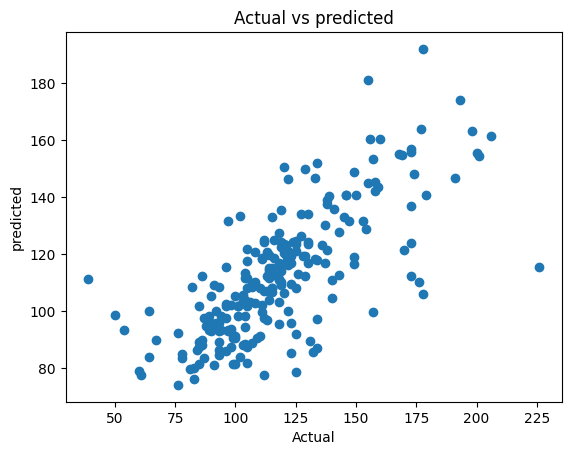

In [11]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test1, np.squeeze(model1.predict(X_test1)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test1, np.squeeze(model1.predict(X_test1)) )
mae= mean_absolute_error(Y_test1, np.squeeze(model1.predict(X_test1)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test1, np.squeeze(model1.predict(X_test1)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [12]:
prediction1 =np.squeeze(model1.predict([[80,2,2,prediction]]))
print("Prediction: {}".format(prediction1))

y_prd=np.squeeze(np.squeeze(model1.predict(X_test1)) )
predic_dif=pd.DataFrame({'Actual':Y_test1,'predict':y_prd,"differences":Y_test1-y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 233ms/step
Prediction: 119.43982696533203
8/8 [==============================] - 0s 2ms/step


,Actual,predict,differences
20,156,160.453094,-4.453094
2019,114,104.083527,9.916473
2153,108,103.086082,4.913918
531,119,135.439728,-16.439728
820,176,110.319366,65.680634
2311,54,93.417694,-39.417694
2126,82,108.694962,-26.694962
2548,83,76.155502,6.844498
2465,64,83.842644,-19.842644
558,116,124.988342,-8.988342


## RNN with Keras tuner dense

In [13]:
from keras.layers import Dense, Dropout,Activation, LSTM
from keras.models import Sequential
model2=Sequential()
model2.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],1)))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64, activation='relu', return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(units=32, activation='relu', return_sequences=True))
model2.add(Dropout(0.4))
model2.add(LSTM(units=64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(units=1))
model2.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 32)             12416     
                                                                 
 dropout_2 (Dropout)         (None, 3, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)               

In [14]:
model2.fit(X_train,Y_train ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
43/43 [==============================] - 28s 101ms/step - loss: 11775.3760 - mae: 96.0303 - val_loss: 5001.2490 - val_mae: 52.3734
Epoch 2/2000
43/43 [==============================] - 1s 22ms/step - loss: 4269.5718 - mae: 48.9068 - val_loss: 1460.2194 - val_mae: 26.8597
Epoch 3/2000
43/43 [==============================] - 1s 23ms/step - loss: 2624.9399 - mae: 38.5977 - val_loss: 1136.4734 - val_mae: 22.6143
Epoch 4/2000
43/43 [==============================] - 1s 24ms/step - loss: 2144.3291 - mae: 34.6242 - val_loss: 886.2520 - val_mae: 19.0155
Epoch 5/2000
43/43 [==============================] - 1s 27ms/step - loss: 2120.8870 - mae: 34.3207 - val_loss: 1683.4728 - val_mae: 32.3901
Epoch 6/2000
43/43 [==============================] - 1s 25ms/step - loss: 1827.9861 - mae: 32.0695 - val_loss: 1191.0752 - val_mae: 26.0200
Epoch 7/2000
43/43 [==============================] - 1s 22ms/step - loss: 1605.0475 - mae: 29.8959 - val_loss: 844.6310 - val_mae: 20.0632
Epoch 8/2000

43/43 [==============================] - 1s 26ms/step - loss: 1077.6619 - mae: 24.6367 - val_loss: 524.8407 - val_mae: 16.6897
Epoch 60/2000
43/43 [==============================] - 1s 25ms/step - loss: 1081.4392 - mae: 24.0593 - val_loss: 529.6515 - val_mae: 16.4552
Epoch 61/2000
43/43 [==============================] - 1s 21ms/step - loss: 1040.1132 - mae: 23.9904 - val_loss: 589.4377 - val_mae: 17.3087
Epoch 62/2000
43/43 [==============================] - 1s 23ms/step - loss: 1039.8982 - mae: 24.2054 - val_loss: 523.5305 - val_mae: 16.3640
Epoch 63/2000
43/43 [==============================] - 1s 27ms/step - loss: 1066.1599 - mae: 24.4884 - val_loss: 542.6288 - val_mae: 16.4809
Epoch 64/2000
43/43 [==============================] - 1s 26ms/step - loss: 1115.5516 - mae: 24.4656 - val_loss: 550.7219 - val_mae: 16.6019
Epoch 65/2000
43/43 [==============================] - 1s 23ms/step - loss: 1073.1538 - mae: 24.5760 - val_loss: 509.0489 - val_mae: 16.9177
Epoch 66/2000
43/43 [======

43/43 [==============================] - 1s 23ms/step - loss: 1008.4709 - mae: 23.5940 - val_loss: 546.7057 - val_mae: 16.6772
Epoch 118/2000
43/43 [==============================] - 1s 23ms/step - loss: 988.4957 - mae: 23.4660 - val_loss: 613.4122 - val_mae: 17.7717
Epoch 119/2000
43/43 [==============================] - 1s 25ms/step - loss: 983.6180 - mae: 23.0805 - val_loss: 519.1053 - val_mae: 16.0003
Epoch 120/2000
43/43 [==============================] - 1s 26ms/step - loss: 1022.9456 - mae: 23.9517 - val_loss: 576.9945 - val_mae: 17.1561
Epoch 121/2000
43/43 [==============================] - 1s 27ms/step - loss: 1000.2977 - mae: 23.3174 - val_loss: 481.0435 - val_mae: 15.5490
Epoch 122/2000
43/43 [==============================] - 2s 34ms/step - loss: 1004.2106 - mae: 23.5371 - val_loss: 528.6764 - val_mae: 16.2276
Epoch 123/2000
43/43 [==============================] - 1s 30ms/step - loss: 1011.6509 - mae: 23.7133 - val_loss: 521.3906 - val_mae: 16.2735
Epoch 124/2000
43/43 [=

Epoch 175/2000
43/43 [==============================] - 1s 28ms/step - loss: 965.1359 - mae: 22.6445 - val_loss: 473.3794 - val_mae: 15.5520
Epoch 176/2000
43/43 [==============================] - 1s 24ms/step - loss: 1003.7979 - mae: 23.5189 - val_loss: 507.9386 - val_mae: 16.0516
Epoch 177/2000
43/43 [==============================] - 1s 28ms/step - loss: 921.2941 - mae: 22.2827 - val_loss: 544.2017 - val_mae: 16.5167
Epoch 178/2000
43/43 [==============================] - 1s 30ms/step - loss: 1041.7705 - mae: 23.8312 - val_loss: 483.9833 - val_mae: 15.3282
Epoch 179/2000
43/43 [==============================] - 1s 32ms/step - loss: 919.9270 - mae: 22.3862 - val_loss: 583.5687 - val_mae: 17.0471
Epoch 180/2000
43/43 [==============================] - 1s 30ms/step - loss: 959.0416 - mae: 22.5588 - val_loss: 576.8174 - val_mae: 16.9868
Epoch 181/2000
43/43 [==============================] - 1s 33ms/step - loss: 944.3185 - mae: 22.7249 - val_loss: 500.0952 - val_mae: 15.7798
Epoch 182/2

43/43 [==============================] - 1s 29ms/step - loss: 918.7640 - mae: 22.5587 - val_loss: 569.5375 - val_mae: 16.6334
Epoch 234/2000
43/43 [==============================] - 1s 28ms/step - loss: 871.7334 - mae: 21.7932 - val_loss: 463.2900 - val_mae: 15.0104
Epoch 235/2000
43/43 [==============================] - 1s 31ms/step - loss: 894.0395 - mae: 21.8855 - val_loss: 460.5134 - val_mae: 15.3552
Epoch 236/2000
43/43 [==============================] - 1s 27ms/step - loss: 907.4561 - mae: 22.0821 - val_loss: 603.8428 - val_mae: 17.2580
Epoch 237/2000
43/43 [==============================] - 1s 30ms/step - loss: 897.9082 - mae: 22.1051 - val_loss: 519.1382 - val_mae: 15.8371
Epoch 238/2000
43/43 [==============================] - 1s 27ms/step - loss: 931.5329 - mae: 22.4504 - val_loss: 478.3448 - val_mae: 15.1994
Epoch 239/2000
43/43 [==============================] - 1s 31ms/step - loss: 917.3297 - mae: 21.9439 - val_loss: 478.2590 - val_mae: 15.0501
Epoch 240/2000
43/43 [======

43/43 [==============================] - 1s 27ms/step - loss: 971.9467 - mae: 22.6713 - val_loss: 471.1860 - val_mae: 15.1667
Epoch 292/2000
43/43 [==============================] - 1s 30ms/step - loss: 798.0543 - mae: 20.8195 - val_loss: 467.0315 - val_mae: 14.7784
Epoch 293/2000
43/43 [==============================] - 1s 29ms/step - loss: 901.8639 - mae: 22.0798 - val_loss: 492.9538 - val_mae: 15.1909
Epoch 294/2000
43/43 [==============================] - 1s 26ms/step - loss: 916.1212 - mae: 21.9422 - val_loss: 474.6082 - val_mae: 15.1424
Epoch 295/2000
43/43 [==============================] - 1s 26ms/step - loss: 872.6426 - mae: 21.6560 - val_loss: 451.6398 - val_mae: 14.4751
Epoch 296/2000
43/43 [==============================] - 1s 28ms/step - loss: 838.2574 - mae: 21.0235 - val_loss: 452.2801 - val_mae: 14.8397
Epoch 297/2000
43/43 [==============================] - 1s 25ms/step - loss: 869.2818 - mae: 21.6809 - val_loss: 441.0119 - val_mae: 14.5094
Epoch 298/2000
43/43 [======

43/43 [==============================] - 1s 28ms/step - loss: 830.6572 - mae: 21.5091 - val_loss: 499.8574 - val_mae: 15.3981
Epoch 350/2000
43/43 [==============================] - 1s 32ms/step - loss: 824.4952 - mae: 20.7332 - val_loss: 480.9751 - val_mae: 14.9317
Epoch 351/2000
43/43 [==============================] - 1s 29ms/step - loss: 841.0321 - mae: 20.9897 - val_loss: 472.2197 - val_mae: 14.7095
Epoch 352/2000
43/43 [==============================] - 1s 32ms/step - loss: 797.9061 - mae: 20.5471 - val_loss: 467.0403 - val_mae: 14.5358
Epoch 353/2000
43/43 [==============================] - 1s 27ms/step - loss: 853.1941 - mae: 21.4167 - val_loss: 490.7236 - val_mae: 15.0348
Epoch 354/2000
43/43 [==============================] - 1s 28ms/step - loss: 834.5445 - mae: 21.3106 - val_loss: 508.1497 - val_mae: 15.3230
Epoch 355/2000
43/43 [==============================] - 1s 30ms/step - loss: 835.5423 - mae: 21.0458 - val_loss: 458.1685 - val_mae: 14.5633
Epoch 356/2000
43/43 [======

43/43 [==============================] - 1s 32ms/step - loss: 810.1953 - mae: 20.7213 - val_loss: 452.3984 - val_mae: 14.7327
Epoch 408/2000
43/43 [==============================] - 1s 28ms/step - loss: 790.0571 - mae: 20.6430 - val_loss: 468.9887 - val_mae: 14.7917
Epoch 409/2000
43/43 [==============================] - 1s 33ms/step - loss: 808.2404 - mae: 20.7411 - val_loss: 466.0589 - val_mae: 14.4541
Epoch 410/2000
43/43 [==============================] - 1s 26ms/step - loss: 821.7805 - mae: 20.9170 - val_loss: 446.5367 - val_mae: 14.2007
Epoch 411/2000
43/43 [==============================] - 1s 27ms/step - loss: 821.4902 - mae: 21.1881 - val_loss: 469.4479 - val_mae: 14.5947
Epoch 412/2000
43/43 [==============================] - 1s 27ms/step - loss: 817.0378 - mae: 21.0399 - val_loss: 439.7886 - val_mae: 14.1831
Epoch 413/2000
43/43 [==============================] - 1s 27ms/step - loss: 820.6100 - mae: 21.1021 - val_loss: 443.2025 - val_mae: 14.1346
Epoch 414/2000
43/43 [======

43/43 [==============================] - 1s 26ms/step - loss: 835.1752 - mae: 21.0033 - val_loss: 451.6551 - val_mae: 14.2067
Epoch 466/2000
43/43 [==============================] - 1s 30ms/step - loss: 769.8832 - mae: 20.3406 - val_loss: 499.4220 - val_mae: 15.2341
Epoch 467/2000
43/43 [==============================] - 1s 30ms/step - loss: 763.2674 - mae: 20.2334 - val_loss: 479.1716 - val_mae: 14.8531
Epoch 468/2000
43/43 [==============================] - 1s 27ms/step - loss: 772.1650 - mae: 20.0227 - val_loss: 448.9737 - val_mae: 14.2124
Epoch 469/2000
43/43 [==============================] - 1s 27ms/step - loss: 795.8845 - mae: 20.4733 - val_loss: 444.5977 - val_mae: 14.1205
Epoch 470/2000
43/43 [==============================] - 1s 30ms/step - loss: 830.3568 - mae: 21.0691 - val_loss: 457.8695 - val_mae: 14.2538
Epoch 471/2000
43/43 [==============================] - 1s 30ms/step - loss: 747.2485 - mae: 19.8955 - val_loss: 466.4218 - val_mae: 14.4422
Epoch 472/2000
43/43 [======

43/43 [==============================] - 1s 27ms/step - loss: 772.7657 - mae: 20.6432 - val_loss: 462.0482 - val_mae: 14.4870
Epoch 524/2000
43/43 [==============================] - 1s 27ms/step - loss: 772.6378 - mae: 19.7767 - val_loss: 446.6228 - val_mae: 14.2318
Epoch 525/2000
43/43 [==============================] - 1s 25ms/step - loss: 830.3669 - mae: 21.2761 - val_loss: 482.7275 - val_mae: 14.6771
Epoch 526/2000
43/43 [==============================] - 1s 23ms/step - loss: 803.6012 - mae: 20.3557 - val_loss: 457.1378 - val_mae: 14.3834
Epoch 527/2000
43/43 [==============================] - 1s 28ms/step - loss: 762.5857 - mae: 20.0923 - val_loss: 456.0861 - val_mae: 14.1571
Epoch 528/2000
43/43 [==============================] - 1s 25ms/step - loss: 769.5068 - mae: 20.1264 - val_loss: 439.2938 - val_mae: 14.3831
Epoch 529/2000
43/43 [==============================] - 1s 29ms/step - loss: 812.7666 - mae: 20.4438 - val_loss: 475.8484 - val_mae: 15.0071
Epoch 530/2000
43/43 [======

43/43 [==============================] - 1s 28ms/step - loss: 795.2354 - mae: 20.4790 - val_loss: 441.1907 - val_mae: 13.8750
Epoch 582/2000
43/43 [==============================] - 1s 27ms/step - loss: 779.0600 - mae: 19.9185 - val_loss: 437.6140 - val_mae: 14.3729
Epoch 583/2000
43/43 [==============================] - 1s 24ms/step - loss: 729.1639 - mae: 19.6602 - val_loss: 465.5025 - val_mae: 14.2479
Epoch 584/2000
43/43 [==============================] - 1s 24ms/step - loss: 802.8358 - mae: 20.4107 - val_loss: 449.3377 - val_mae: 14.2045
Epoch 585/2000
43/43 [==============================] - 1s 27ms/step - loss: 760.7104 - mae: 20.1200 - val_loss: 466.3445 - val_mae: 15.1160
Epoch 586/2000
43/43 [==============================] - 1s 27ms/step - loss: 748.3524 - mae: 19.7597 - val_loss: 463.2930 - val_mae: 14.1423
Epoch 587/2000
43/43 [==============================] - 1s 25ms/step - loss: 795.6805 - mae: 20.6643 - val_loss: 497.1558 - val_mae: 14.8368
Epoch 588/2000
43/43 [======

43/43 [==============================] - 1s 25ms/step - loss: 743.1988 - mae: 20.4875 - val_loss: 458.5837 - val_mae: 14.1284
Epoch 640/2000
43/43 [==============================] - 1s 26ms/step - loss: 790.2163 - mae: 20.3977 - val_loss: 449.0697 - val_mae: 14.1656
Epoch 641/2000
43/43 [==============================] - 1s 28ms/step - loss: 750.2565 - mae: 20.3193 - val_loss: 567.1242 - val_mae: 16.2957
Epoch 642/2000
43/43 [==============================] - 1s 26ms/step - loss: 747.5688 - mae: 19.8664 - val_loss: 458.4046 - val_mae: 14.5705
Epoch 643/2000
43/43 [==============================] - 1s 26ms/step - loss: 772.3425 - mae: 20.4194 - val_loss: 451.6263 - val_mae: 14.2377
Epoch 644/2000
43/43 [==============================] - 1s 29ms/step - loss: 775.0938 - mae: 20.1055 - val_loss: 494.5228 - val_mae: 14.7047
Epoch 645/2000
43/43 [==============================] - 1s 28ms/step - loss: 725.8078 - mae: 19.6476 - val_loss: 449.2139 - val_mae: 14.2420
Epoch 646/2000
43/43 [======

43/43 [==============================] - 1s 30ms/step - loss: 734.0898 - mae: 19.9256 - val_loss: 464.5201 - val_mae: 14.3011
Epoch 698/2000
43/43 [==============================] - 1s 23ms/step - loss: 727.8468 - mae: 19.6765 - val_loss: 471.5357 - val_mae: 14.4100
Epoch 699/2000
43/43 [==============================] - 1s 23ms/step - loss: 718.7845 - mae: 19.6871 - val_loss: 475.0069 - val_mae: 14.4279
Epoch 700/2000
43/43 [==============================] - 1s 24ms/step - loss: 756.6943 - mae: 20.1638 - val_loss: 447.6897 - val_mae: 14.0504
Epoch 701/2000
43/43 [==============================] - 1s 27ms/step - loss: 765.7200 - mae: 20.2170 - val_loss: 445.1595 - val_mae: 14.2220
Epoch 702/2000
43/43 [==============================] - 1s 27ms/step - loss: 795.3707 - mae: 20.6993 - val_loss: 496.4184 - val_mae: 14.5396
Epoch 703/2000
43/43 [==============================] - 1s 31ms/step - loss: 758.7829 - mae: 19.9987 - val_loss: 464.3954 - val_mae: 14.2304
Epoch 704/2000
43/43 [======

43/43 [==============================] - 1s 16ms/step - loss: 684.8267 - mae: 19.1137 - val_loss: 458.9859 - val_mae: 14.3348
Epoch 756/2000
43/43 [==============================] - 1s 16ms/step - loss: 732.1044 - mae: 20.0108 - val_loss: 475.1896 - val_mae: 14.5467
Epoch 757/2000
43/43 [==============================] - 1s 17ms/step - loss: 706.5720 - mae: 19.7385 - val_loss: 485.3003 - val_mae: 14.4304
Epoch 758/2000
43/43 [==============================] - 1s 16ms/step - loss: 756.6667 - mae: 19.9601 - val_loss: 489.7773 - val_mae: 14.6604
Epoch 759/2000
43/43 [==============================] - 1s 17ms/step - loss: 723.7609 - mae: 19.8264 - val_loss: 470.5467 - val_mae: 14.3045
Epoch 760/2000
43/43 [==============================] - 1s 18ms/step - loss: 747.7669 - mae: 19.7395 - val_loss: 497.4094 - val_mae: 14.6814
Epoch 761/2000
43/43 [==============================] - 1s 16ms/step - loss: 714.9132 - mae: 19.5071 - val_loss: 491.0984 - val_mae: 14.7442
Epoch 762/2000
43/43 [======

43/43 [==============================] - 1s 16ms/step - loss: 727.7242 - mae: 19.8450 - val_loss: 504.3359 - val_mae: 14.6739
Epoch 814/2000
43/43 [==============================] - 1s 18ms/step - loss: 699.3839 - mae: 19.0399 - val_loss: 482.5357 - val_mae: 14.3486
Epoch 815/2000
43/43 [==============================] - 1s 16ms/step - loss: 744.2118 - mae: 19.9127 - val_loss: 486.5708 - val_mae: 14.3186
Epoch 816/2000
43/43 [==============================] - 1s 17ms/step - loss: 743.5176 - mae: 19.6540 - val_loss: 461.4617 - val_mae: 14.1057
Epoch 817/2000
43/43 [==============================] - 1s 17ms/step - loss: 696.8522 - mae: 19.3316 - val_loss: 472.8017 - val_mae: 14.2999
Epoch 818/2000
43/43 [==============================] - 1s 16ms/step - loss: 739.8073 - mae: 19.3138 - val_loss: 480.2900 - val_mae: 14.4879
Epoch 819/2000
43/43 [==============================] - 1s 17ms/step - loss: 751.2701 - mae: 19.8928 - val_loss: 467.2877 - val_mae: 14.2931
Epoch 820/2000
43/43 [======

43/43 [==============================] - 1s 20ms/step - loss: 722.7673 - mae: 19.4684 - val_loss: 504.5465 - val_mae: 14.7177
Epoch 872/2000
43/43 [==============================] - 1s 20ms/step - loss: 696.4684 - mae: 19.4061 - val_loss: 501.2383 - val_mae: 14.6521
Epoch 873/2000
43/43 [==============================] - 1s 22ms/step - loss: 683.2455 - mae: 19.1681 - val_loss: 526.4318 - val_mae: 15.0529
Epoch 874/2000
43/43 [==============================] - 1s 21ms/step - loss: 699.6937 - mae: 19.2979 - val_loss: 485.5200 - val_mae: 14.4648
Epoch 875/2000
43/43 [==============================] - 1s 20ms/step - loss: 716.0641 - mae: 19.3688 - val_loss: 483.8805 - val_mae: 14.3442
Epoch 876/2000
43/43 [==============================] - 1s 21ms/step - loss: 671.1915 - mae: 19.2585 - val_loss: 489.4202 - val_mae: 14.5784
Epoch 877/2000
43/43 [==============================] - 1s 22ms/step - loss: 680.1194 - mae: 18.9877 - val_loss: 475.4272 - val_mae: 14.3770
Epoch 878/2000
43/43 [======

43/43 [==============================] - 1s 20ms/step - loss: 691.6949 - mae: 18.9527 - val_loss: 485.4225 - val_mae: 14.5141
Epoch 930/2000
43/43 [==============================] - 1s 21ms/step - loss: 705.8506 - mae: 19.1679 - val_loss: 494.0867 - val_mae: 14.5491
Epoch 931/2000
43/43 [==============================] - 1s 23ms/step - loss: 693.9606 - mae: 18.9774 - val_loss: 490.2091 - val_mae: 14.4647
Epoch 932/2000
43/43 [==============================] - 1s 26ms/step - loss: 684.3148 - mae: 19.2589 - val_loss: 499.4561 - val_mae: 14.7060
Epoch 933/2000
43/43 [==============================] - 1s 22ms/step - loss: 685.1336 - mae: 19.0445 - val_loss: 503.4008 - val_mae: 14.7161
Epoch 934/2000
43/43 [==============================] - 1s 23ms/step - loss: 659.7734 - mae: 18.7409 - val_loss: 473.9745 - val_mae: 14.4027
Epoch 935/2000
43/43 [==============================] - 1s 27ms/step - loss: 695.8450 - mae: 19.3587 - val_loss: 487.2851 - val_mae: 14.4826
Epoch 936/2000
43/43 [======

43/43 [==============================] - 1s 21ms/step - loss: 675.9242 - mae: 19.0349 - val_loss: 532.3949 - val_mae: 15.2009
Epoch 988/2000
43/43 [==============================] - 1s 23ms/step - loss: 658.1837 - mae: 18.4489 - val_loss: 484.2751 - val_mae: 14.3190
Epoch 989/2000
43/43 [==============================] - 1s 22ms/step - loss: 716.8656 - mae: 19.5161 - val_loss: 505.4957 - val_mae: 14.7408
Epoch 990/2000
43/43 [==============================] - 1s 21ms/step - loss: 676.0994 - mae: 19.0820 - val_loss: 476.1746 - val_mae: 14.6411
Epoch 991/2000
43/43 [==============================] - 1s 20ms/step - loss: 703.7816 - mae: 19.1809 - val_loss: 515.9703 - val_mae: 14.8251
Epoch 992/2000
43/43 [==============================] - 1s 20ms/step - loss: 682.6201 - mae: 18.9664 - val_loss: 489.5401 - val_mae: 14.6622
Epoch 993/2000
43/43 [==============================] - 1s 21ms/step - loss: 675.3504 - mae: 19.3333 - val_loss: 488.7873 - val_mae: 14.5011
Epoch 994/2000
43/43 [======

Epoch 1045/2000
43/43 [==============================] - 1s 20ms/step - loss: 704.8160 - mae: 19.0671 - val_loss: 434.8798 - val_mae: 13.8926
Epoch 1046/2000
43/43 [==============================] - 1s 20ms/step - loss: 710.3019 - mae: 19.4261 - val_loss: 445.9167 - val_mae: 14.2618
Epoch 1047/2000
43/43 [==============================] - 1s 19ms/step - loss: 744.6202 - mae: 20.2349 - val_loss: 443.3287 - val_mae: 13.8882
Epoch 1048/2000
43/43 [==============================] - 1s 20ms/step - loss: 668.3213 - mae: 18.7914 - val_loss: 440.5603 - val_mae: 13.8576
Epoch 1049/2000
43/43 [==============================] - 1s 19ms/step - loss: 723.9963 - mae: 19.5443 - val_loss: 462.3835 - val_mae: 14.1321
Epoch 1050/2000
43/43 [==============================] - 1s 18ms/step - loss: 703.1939 - mae: 19.2276 - val_loss: 475.8341 - val_mae: 14.2542
Epoch 1051/2000
43/43 [==============================] - 1s 20ms/step - loss: 718.0282 - mae: 19.7206 - val_loss: 456.0534 - val_mae: 14.3922
Epoch 

Epoch 1103/2000
43/43 [==============================] - 1s 19ms/step - loss: 692.1483 - mae: 19.0809 - val_loss: 491.9754 - val_mae: 14.6038
Epoch 1104/2000
43/43 [==============================] - 1s 19ms/step - loss: 711.0787 - mae: 19.2594 - val_loss: 504.1924 - val_mae: 14.9124
Epoch 1105/2000
43/43 [==============================] - 1s 20ms/step - loss: 672.9534 - mae: 19.0729 - val_loss: 515.6517 - val_mae: 15.0740
Epoch 1106/2000
43/43 [==============================] - 1s 19ms/step - loss: 677.6534 - mae: 19.0070 - val_loss: 489.7945 - val_mae: 14.6103
Epoch 1107/2000
43/43 [==============================] - 1s 22ms/step - loss: 702.7264 - mae: 19.2551 - val_loss: 478.2276 - val_mae: 14.6204
Epoch 1108/2000
43/43 [==============================] - 1s 21ms/step - loss: 664.0238 - mae: 18.5420 - val_loss: 483.0867 - val_mae: 14.4193
Epoch 1109/2000
43/43 [==============================] - 1s 22ms/step - loss: 700.7852 - mae: 19.2760 - val_loss: 500.8766 - val_mae: 14.6020
Epoch 

Epoch 1161/2000
43/43 [==============================] - 1s 20ms/step - loss: 660.3637 - mae: 18.6773 - val_loss: 485.8570 - val_mae: 14.4641
Epoch 1162/2000
43/43 [==============================] - 1s 20ms/step - loss: 692.9811 - mae: 18.7611 - val_loss: 499.2899 - val_mae: 14.5113
Epoch 1163/2000
43/43 [==============================] - 1s 20ms/step - loss: 649.7632 - mae: 18.7770 - val_loss: 513.6521 - val_mae: 14.7662
Epoch 1164/2000
43/43 [==============================] - 1s 21ms/step - loss: 673.1730 - mae: 19.0993 - val_loss: 500.8201 - val_mae: 14.6410
Epoch 1165/2000
43/43 [==============================] - 1s 19ms/step - loss: 689.1960 - mae: 18.9697 - val_loss: 488.7741 - val_mae: 14.5238
Epoch 1166/2000
43/43 [==============================] - 1s 18ms/step - loss: 673.2887 - mae: 18.8715 - val_loss: 493.7122 - val_mae: 14.7166
Epoch 1167/2000
43/43 [==============================] - 1s 19ms/step - loss: 641.0321 - mae: 18.4229 - val_loss: 495.5486 - val_mae: 14.5552
Epoch 

Epoch 1219/2000
43/43 [==============================] - 1s 21ms/step - loss: 697.8554 - mae: 19.1206 - val_loss: 486.9680 - val_mae: 15.1117
Epoch 1220/2000
43/43 [==============================] - 1s 19ms/step - loss: 692.2368 - mae: 19.2094 - val_loss: 496.4145 - val_mae: 14.7617
Epoch 1221/2000
43/43 [==============================] - 1s 21ms/step - loss: 683.8384 - mae: 19.1228 - val_loss: 485.7360 - val_mae: 14.4071
Epoch 1222/2000
43/43 [==============================] - 1s 20ms/step - loss: 668.2853 - mae: 18.7582 - val_loss: 476.5669 - val_mae: 14.4254
Epoch 1223/2000
43/43 [==============================] - 1s 21ms/step - loss: 666.0307 - mae: 18.4257 - val_loss: 473.0250 - val_mae: 14.3683
Epoch 1224/2000
43/43 [==============================] - 1s 18ms/step - loss: 627.7957 - mae: 18.6023 - val_loss: 504.2429 - val_mae: 14.8300
Epoch 1225/2000
43/43 [==============================] - 1s 20ms/step - loss: 688.9648 - mae: 19.0256 - val_loss: 487.2022 - val_mae: 14.5859
Epoch 

Epoch 1277/2000
43/43 [==============================] - 1s 25ms/step - loss: 677.4312 - mae: 18.9717 - val_loss: 473.8034 - val_mae: 14.3774
Epoch 1278/2000
43/43 [==============================] - 1s 27ms/step - loss: 649.2461 - mae: 18.0754 - val_loss: 484.5493 - val_mae: 14.4573
Epoch 1279/2000
43/43 [==============================] - 1s 29ms/step - loss: 644.8103 - mae: 18.1515 - val_loss: 501.9181 - val_mae: 14.8641
Epoch 1280/2000
43/43 [==============================] - 1s 35ms/step - loss: 670.1992 - mae: 18.8728 - val_loss: 496.3560 - val_mae: 14.5586
Epoch 1281/2000
43/43 [==============================] - 1s 25ms/step - loss: 710.3781 - mae: 19.1031 - val_loss: 504.4496 - val_mae: 14.6617
Epoch 1282/2000
43/43 [==============================] - 1s 26ms/step - loss: 684.6006 - mae: 18.9612 - val_loss: 487.5805 - val_mae: 15.0411
Epoch 1283/2000
43/43 [==============================] - 1s 23ms/step - loss: 637.9289 - mae: 18.4213 - val_loss: 487.4155 - val_mae: 14.4958
Epoch 

Epoch 1335/2000
43/43 [==============================] - 1s 20ms/step - loss: 627.7067 - mae: 18.3560 - val_loss: 480.1229 - val_mae: 14.3775
Epoch 1336/2000
43/43 [==============================] - 1s 19ms/step - loss: 629.7880 - mae: 18.0846 - val_loss: 500.5801 - val_mae: 14.6202
Epoch 1337/2000
43/43 [==============================] - 1s 18ms/step - loss: 675.9267 - mae: 18.5507 - val_loss: 504.3329 - val_mae: 14.7280
Epoch 1338/2000
43/43 [==============================] - 1s 19ms/step - loss: 631.4921 - mae: 18.4246 - val_loss: 486.2909 - val_mae: 14.6910
Epoch 1339/2000
43/43 [==============================] - 1s 21ms/step - loss: 640.2853 - mae: 18.4347 - val_loss: 498.7850 - val_mae: 14.6754
Epoch 1340/2000
43/43 [==============================] - 1s 19ms/step - loss: 702.4341 - mae: 19.2144 - val_loss: 511.9698 - val_mae: 14.8644
Epoch 1341/2000
43/43 [==============================] - 1s 19ms/step - loss: 647.5346 - mae: 18.4271 - val_loss: 497.8021 - val_mae: 14.5637
Epoch 

Epoch 1393/2000
43/43 [==============================] - 1s 20ms/step - loss: 654.1345 - mae: 18.2155 - val_loss: 518.2166 - val_mae: 14.8015
Epoch 1394/2000
43/43 [==============================] - 1s 19ms/step - loss: 626.4606 - mae: 18.0681 - val_loss: 515.2759 - val_mae: 14.7072
Epoch 1395/2000
43/43 [==============================] - 1s 21ms/step - loss: 645.6814 - mae: 18.5339 - val_loss: 531.7219 - val_mae: 14.8939
Epoch 1396/2000
43/43 [==============================] - 1s 20ms/step - loss: 635.7842 - mae: 18.4101 - val_loss: 498.5561 - val_mae: 14.5782
Epoch 1397/2000
43/43 [==============================] - 1s 19ms/step - loss: 656.3252 - mae: 18.5059 - val_loss: 493.3492 - val_mae: 14.5519
Epoch 1398/2000
43/43 [==============================] - 1s 23ms/step - loss: 624.1752 - mae: 17.9931 - val_loss: 513.9865 - val_mae: 15.2445
Epoch 1399/2000
43/43 [==============================] - 1s 26ms/step - loss: 652.9258 - mae: 18.3462 - val_loss: 515.1901 - val_mae: 14.8258
Epoch 

Epoch 1451/2000
43/43 [==============================] - 1s 20ms/step - loss: 634.8513 - mae: 18.3740 - val_loss: 516.4738 - val_mae: 14.9036
Epoch 1452/2000
43/43 [==============================] - 1s 20ms/step - loss: 642.7249 - mae: 18.5388 - val_loss: 519.3862 - val_mae: 14.7353
Epoch 1453/2000
43/43 [==============================] - 1s 22ms/step - loss: 677.5963 - mae: 18.6747 - val_loss: 483.1330 - val_mae: 14.6695
Epoch 1454/2000
43/43 [==============================] - 1s 21ms/step - loss: 625.1924 - mae: 18.0636 - val_loss: 496.7788 - val_mae: 14.6219
Epoch 1455/2000
43/43 [==============================] - 1s 21ms/step - loss: 688.9600 - mae: 18.6221 - val_loss: 522.1973 - val_mae: 14.9200
Epoch 1456/2000
43/43 [==============================] - 1s 21ms/step - loss: 669.2099 - mae: 18.5370 - val_loss: 494.3643 - val_mae: 14.6661
Epoch 1457/2000
43/43 [==============================] - 1s 20ms/step - loss: 645.1180 - mae: 18.3589 - val_loss: 511.3369 - val_mae: 14.9070
Epoch 

Epoch 1509/2000
43/43 [==============================] - 1s 24ms/step - loss: 633.2916 - mae: 18.3983 - val_loss: 493.7163 - val_mae: 14.5208
Epoch 1510/2000
43/43 [==============================] - 1s 21ms/step - loss: 651.8731 - mae: 18.2156 - val_loss: 509.2057 - val_mae: 14.7242
Epoch 1511/2000
43/43 [==============================] - 1s 24ms/step - loss: 625.0385 - mae: 18.2157 - val_loss: 514.5504 - val_mae: 14.8287
Epoch 1512/2000
43/43 [==============================] - 1s 22ms/step - loss: 571.8290 - mae: 17.3953 - val_loss: 529.9234 - val_mae: 14.9719
Epoch 1513/2000
43/43 [==============================] - 1s 25ms/step - loss: 629.0415 - mae: 18.2942 - val_loss: 528.6793 - val_mae: 14.8872
Epoch 1514/2000
43/43 [==============================] - 1s 22ms/step - loss: 620.2084 - mae: 17.9770 - val_loss: 543.1569 - val_mae: 15.2188
Epoch 1515/2000
43/43 [==============================] - 1s 23ms/step - loss: 653.9690 - mae: 18.5227 - val_loss: 549.5814 - val_mae: 15.3986
Epoch 

Epoch 1567/2000
43/43 [==============================] - 1s 17ms/step - loss: 647.9654 - mae: 18.3738 - val_loss: 509.0654 - val_mae: 14.7625
Epoch 1568/2000
43/43 [==============================] - 1s 17ms/step - loss: 633.9160 - mae: 18.4674 - val_loss: 510.4888 - val_mae: 14.6467
Epoch 1569/2000
43/43 [==============================] - 1s 18ms/step - loss: 612.4932 - mae: 18.0061 - val_loss: 518.4714 - val_mae: 14.7556
Epoch 1570/2000
43/43 [==============================] - 1s 16ms/step - loss: 626.0307 - mae: 17.9043 - val_loss: 500.5387 - val_mae: 14.5686
Epoch 1571/2000
43/43 [==============================] - 1s 16ms/step - loss: 628.9236 - mae: 18.1436 - val_loss: 529.5111 - val_mae: 14.7802
Epoch 1572/2000
43/43 [==============================] - 1s 18ms/step - loss: 635.4438 - mae: 18.2716 - val_loss: 526.8963 - val_mae: 14.7884
Epoch 1573/2000
43/43 [==============================] - 1s 18ms/step - loss: 587.5535 - mae: 17.6594 - val_loss: 523.5580 - val_mae: 14.8926
Epoch 

Epoch 1625/2000
43/43 [==============================] - 1s 17ms/step - loss: 612.8275 - mae: 17.8586 - val_loss: 492.5933 - val_mae: 14.4833
Epoch 1626/2000
43/43 [==============================] - 1s 17ms/step - loss: 634.7902 - mae: 18.4812 - val_loss: 527.3970 - val_mae: 14.9707
Epoch 1627/2000
43/43 [==============================] - 1s 16ms/step - loss: 600.1699 - mae: 17.8242 - val_loss: 497.2174 - val_mae: 14.5191
Epoch 1628/2000
43/43 [==============================] - 1s 18ms/step - loss: 626.7600 - mae: 18.2236 - val_loss: 515.9099 - val_mae: 15.0325
Epoch 1629/2000
43/43 [==============================] - 1s 18ms/step - loss: 602.4260 - mae: 17.7157 - val_loss: 522.4404 - val_mae: 14.9000
Epoch 1630/2000
43/43 [==============================] - 1s 18ms/step - loss: 632.4089 - mae: 18.2185 - val_loss: 493.4371 - val_mae: 14.9510
Epoch 1631/2000
43/43 [==============================] - 1s 18ms/step - loss: 671.5541 - mae: 18.5258 - val_loss: 500.0414 - val_mae: 14.6846
Epoch 

Epoch 1683/2000
43/43 [==============================] - 1s 29ms/step - loss: 604.5792 - mae: 17.4975 - val_loss: 508.5153 - val_mae: 14.8674
Epoch 1684/2000
43/43 [==============================] - 1s 22ms/step - loss: 646.7275 - mae: 18.2081 - val_loss: 522.7938 - val_mae: 15.1417
Epoch 1685/2000
43/43 [==============================] - 1s 30ms/step - loss: 643.2675 - mae: 18.0822 - val_loss: 499.1932 - val_mae: 14.6769
Epoch 1686/2000
43/43 [==============================] - 1s 23ms/step - loss: 611.6096 - mae: 17.9010 - val_loss: 491.7923 - val_mae: 14.6035
Epoch 1687/2000
43/43 [==============================] - 1s 24ms/step - loss: 631.9719 - mae: 18.3200 - val_loss: 529.8476 - val_mae: 15.1194
Epoch 1688/2000
43/43 [==============================] - 1s 21ms/step - loss: 651.6667 - mae: 18.3142 - val_loss: 492.9971 - val_mae: 14.7695
Epoch 1689/2000
43/43 [==============================] - 1s 23ms/step - loss: 646.4839 - mae: 18.1931 - val_loss: 522.3758 - val_mae: 15.4365
Epoch 

Epoch 1741/2000
43/43 [==============================] - 1s 25ms/step - loss: 600.9605 - mae: 17.3915 - val_loss: 511.2842 - val_mae: 14.8137
Epoch 1742/2000
43/43 [==============================] - 1s 25ms/step - loss: 636.2526 - mae: 18.4978 - val_loss: 533.1458 - val_mae: 15.1541
Epoch 1743/2000
43/43 [==============================] - 1s 26ms/step - loss: 602.1385 - mae: 17.8202 - val_loss: 532.4324 - val_mae: 15.1397
Epoch 1744/2000
43/43 [==============================] - 1s 23ms/step - loss: 601.4333 - mae: 17.8840 - val_loss: 518.9424 - val_mae: 14.8919
Epoch 1745/2000
43/43 [==============================] - 1s 21ms/step - loss: 609.4262 - mae: 17.7165 - val_loss: 518.3210 - val_mae: 14.8004
Epoch 1746/2000
43/43 [==============================] - 1s 25ms/step - loss: 585.1861 - mae: 17.3268 - val_loss: 527.1448 - val_mae: 14.9848
Epoch 1747/2000
43/43 [==============================] - 1s 23ms/step - loss: 607.7155 - mae: 18.0665 - val_loss: 508.6704 - val_mae: 14.9010
Epoch 

Epoch 1799/2000
43/43 [==============================] - 1s 20ms/step - loss: 610.7012 - mae: 17.9520 - val_loss: 529.9560 - val_mae: 15.0884
Epoch 1800/2000
43/43 [==============================] - 1s 25ms/step - loss: 601.6627 - mae: 17.3245 - val_loss: 521.8633 - val_mae: 14.9158
Epoch 1801/2000
43/43 [==============================] - 1s 23ms/step - loss: 594.1667 - mae: 17.5162 - val_loss: 513.2572 - val_mae: 14.8671
Epoch 1802/2000
43/43 [==============================] - 1s 21ms/step - loss: 599.0400 - mae: 17.7519 - val_loss: 527.8990 - val_mae: 14.9655
Epoch 1803/2000
43/43 [==============================] - 1s 20ms/step - loss: 607.9459 - mae: 17.8296 - val_loss: 531.8756 - val_mae: 15.1162
Epoch 1804/2000
43/43 [==============================] - 1s 25ms/step - loss: 619.1136 - mae: 17.9040 - val_loss: 506.4426 - val_mae: 14.7733
Epoch 1805/2000
43/43 [==============================] - 1s 22ms/step - loss: 580.8046 - mae: 17.5194 - val_loss: 513.3455 - val_mae: 14.7562
Epoch 

Epoch 1857/2000
43/43 [==============================] - 1s 23ms/step - loss: 607.5425 - mae: 17.6522 - val_loss: 514.8295 - val_mae: 14.7797
Epoch 1858/2000
43/43 [==============================] - 1s 24ms/step - loss: 599.0118 - mae: 17.5954 - val_loss: 525.3571 - val_mae: 14.9133
Epoch 1859/2000
43/43 [==============================] - 1s 21ms/step - loss: 602.8823 - mae: 17.7575 - val_loss: 527.4332 - val_mae: 14.8739
Epoch 1860/2000
43/43 [==============================] - 1s 24ms/step - loss: 611.4405 - mae: 17.7862 - val_loss: 509.7201 - val_mae: 14.7179
Epoch 1861/2000
43/43 [==============================] - 1s 23ms/step - loss: 591.0873 - mae: 17.4912 - val_loss: 519.2339 - val_mae: 14.8626
Epoch 1862/2000
43/43 [==============================] - 1s 22ms/step - loss: 617.2831 - mae: 17.7001 - val_loss: 529.8492 - val_mae: 14.9374
Epoch 1863/2000
43/43 [==============================] - 1s 23ms/step - loss: 608.2378 - mae: 17.7976 - val_loss: 526.2164 - val_mae: 14.9391
Epoch 

Epoch 1915/2000
43/43 [==============================] - 1s 26ms/step - loss: 609.1694 - mae: 18.0667 - val_loss: 533.0051 - val_mae: 15.0975
Epoch 1916/2000
43/43 [==============================] - 1s 23ms/step - loss: 595.2237 - mae: 17.3035 - val_loss: 519.4330 - val_mae: 14.8265
Epoch 1917/2000
43/43 [==============================] - 1s 24ms/step - loss: 582.8708 - mae: 17.3368 - val_loss: 529.6167 - val_mae: 15.2396
Epoch 1918/2000
43/43 [==============================] - 1s 25ms/step - loss: 617.1584 - mae: 17.7201 - val_loss: 516.3898 - val_mae: 14.8668
Epoch 1919/2000
43/43 [==============================] - 1s 24ms/step - loss: 623.4200 - mae: 17.9592 - val_loss: 530.1807 - val_mae: 15.1643
Epoch 1920/2000
43/43 [==============================] - 1s 23ms/step - loss: 621.1824 - mae: 17.9688 - val_loss: 533.2518 - val_mae: 15.0256
Epoch 1921/2000
43/43 [==============================] - 1s 27ms/step - loss: 620.7982 - mae: 17.7463 - val_loss: 513.2093 - val_mae: 14.7792
Epoch 

Epoch 1973/2000
43/43 [==============================] - 1s 22ms/step - loss: 582.2527 - mae: 17.4970 - val_loss: 518.6775 - val_mae: 14.9161
Epoch 1974/2000
43/43 [==============================] - 1s 24ms/step - loss: 555.6129 - mae: 17.0787 - val_loss: 528.3809 - val_mae: 15.1917
Epoch 1975/2000
43/43 [==============================] - 1s 28ms/step - loss: 608.8635 - mae: 17.6431 - val_loss: 542.7462 - val_mae: 15.2131
Epoch 1976/2000
43/43 [==============================] - 1s 20ms/step - loss: 604.2137 - mae: 17.5343 - val_loss: 515.6140 - val_mae: 14.8110
Epoch 1977/2000
43/43 [==============================] - 1s 25ms/step - loss: 593.2266 - mae: 17.5413 - val_loss: 525.3131 - val_mae: 14.9914
Epoch 1978/2000
43/43 [==============================] - 1s 24ms/step - loss: 574.6283 - mae: 17.1474 - val_loss: 528.8355 - val_mae: 14.8932
Epoch 1979/2000
43/43 [==============================] - 1s 24ms/step - loss: 581.8658 - mae: 17.3765 - val_loss: 516.4559 - val_mae: 14.9064
Epoch 

In [15]:
prediction2 = np.squeeze(model2.predict([[80,2,2]]))
print("Prediction: {}".format(prediction2))

1/1 [==============================] - 6s 6s/step
Prediction: 120.8765869140625


In [16]:
y_prd=np.squeeze(np.squeeze(model2.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

26/26 [==============================] - 7s 5ms/step
      Actual     predict  differences
352      167  169.542694    -2.542694
1460      95   94.884064     0.115936
1023     123  119.177124     3.822876
2178     100   91.022636     8.977364
2630      87   89.865837    -2.865837
...      ...         ...          ...
305      104  158.539154   -54.539154
1242     125  117.995338     7.004662
442      173  152.371674    20.628326
1703      92   93.056831    -1.056831
1489     107  114.362160    -7.362160

[826 rows x 3 columns]


In [17]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

104.45012664794922
82.26202392578125
-82.54240417480469
112.08887481689453
125.49942016601562
82.27361297607422
133.15432739257812
86.6783447265625
-92.4969482421875
90.68585968017578
81.00790405273438
110.0601577758789
-93.07525634765625
96.57830810546875
-89.088134765625
144.52312469482422
168.21920776367188
128.45784759521484
-95.08271789550781
-87.38644409179688
-89.44937133789062
lower bound: -82.36495449814453
upper bound: 80.3103621531354


In [18]:
A.drop(A[(A['differences'] >80)].index, inplace=True)
A.drop(A[(A['differences'] <-82)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X2=B.drop('Actual',axis=1)
Y2=B['Actual']
X_train2, X_test2, Y_train2, Y_test2 =train_test_split(X2,Y2, test_size=0.3, random_state = 0)

      AverageFloorArea  Quarter  Property Type  Actual     predict
1                    0        1              2     142  167.191650
4                    0        2              1     200  170.510742
9                    0        4              2     174  150.995544
10                   0        4              3     108  149.636017
11                   0        4              4     165  144.501953
...                ...      ...            ...     ...         ...
2734               232        1              1      75   92.398743
2736               232        2              1      96  103.632614
2739               232        3              3     132   89.324921
2740               232        4              3      70   89.595589
2746               233        4              3      74   89.582397

[805 rows x 5 columns]


In [19]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense
import kerastuner
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [20]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project1',project_name='A1')

tuner.search(X_train2,Y_train2 ,epochs=100,validation_data=(X_test2,Y_test2))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model3 = tuner.hypermodel.build(best_hps)
model3.fit(X_train2, Y_train2, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project1\A1\oracle.json
INFO:tensorflow:Reloading Tuner from project1\A1\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
13/13 [==============================] - 1s 22ms/step - loss: 115.3443 - mean_absolute_error: 115.3443 - val_loss: 64.6043 - val_mean_absolute_error: 64.6043
Epoch 2/2000
13/13 [==============================] - 0s 6ms/step - loss: 43.6172 - mean_absolute_error: 43.6172 - val_loss: 17.8220 - val_mean_absolute_error: 17.8220
Epoch 3/2000
13/13 [==============================] - 0s 6ms/step - loss: 18.2722 - mean_absolute_error: 18.2722 - val_loss: 19.1298 - val_mean_absolute_error: 19.1298
Epoch 4/2000
13/13 [==============================] - 0s 6ms/step - loss: 18.3595 - mean_absolute_error: 18.3595 - val_loss: 22.3002 - val_mean_absolute_error: 22.3002
Epoch 5/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.3542 - mean_absolute_error: 16.3542 - val_loss: 13.6727 - val_mean_abs

13/13 [==============================] - 0s 7ms/step - loss: 14.8324 - mean_absolute_error: 14.8324 - val_loss: 13.4973 - val_mean_absolute_error: 13.4973
Epoch 49/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.9221 - mean_absolute_error: 14.9221 - val_loss: 13.6140 - val_mean_absolute_error: 13.6140
Epoch 50/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.4100 - mean_absolute_error: 15.4100 - val_loss: 13.6467 - val_mean_absolute_error: 13.6467
Epoch 51/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.8170 - mean_absolute_error: 14.8170 - val_loss: 17.0199 - val_mean_absolute_error: 17.0199
Epoch 52/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0201 - mean_absolute_error: 15.0201 - val_loss: 15.1350 - val_mean_absolute_error: 15.1350
Epoch 53/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.8458 - mean_absolute_error: 15.8458 - val_loss: 14.9962 - val_mean_absolute_error: 14.9962


13/13 [==============================] - 0s 6ms/step - loss: 16.1154 - mean_absolute_error: 16.1154 - val_loss: 14.5309 - val_mean_absolute_error: 14.5309
Epoch 97/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.9260 - mean_absolute_error: 15.9260 - val_loss: 13.5359 - val_mean_absolute_error: 13.5359
Epoch 98/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.0277 - mean_absolute_error: 15.0277 - val_loss: 14.0786 - val_mean_absolute_error: 14.0786
Epoch 99/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.6762 - mean_absolute_error: 14.6762 - val_loss: 14.1511 - val_mean_absolute_error: 14.1511
Epoch 100/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.5640 - mean_absolute_error: 15.5640 - val_loss: 14.9956 - val_mean_absolute_error: 14.9956
Epoch 101/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.0657 - mean_absolute_error: 15.0657 - val_loss: 15.2219 - val_mean_absolute_error: 15.221

13/13 [==============================] - 0s 5ms/step - loss: 15.5977 - mean_absolute_error: 15.5977 - val_loss: 13.4046 - val_mean_absolute_error: 13.4046
Epoch 145/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.1810 - mean_absolute_error: 15.1810 - val_loss: 13.6161 - val_mean_absolute_error: 13.6161
Epoch 146/2000
13/13 [==============================] - 0s 4ms/step - loss: 14.9993 - mean_absolute_error: 14.9993 - val_loss: 14.9485 - val_mean_absolute_error: 14.9485
Epoch 147/2000
13/13 [==============================] - 0s 5ms/step - loss: 14.5904 - mean_absolute_error: 14.5904 - val_loss: 13.6620 - val_mean_absolute_error: 13.6620
Epoch 148/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.1113 - mean_absolute_error: 15.1113 - val_loss: 18.1889 - val_mean_absolute_error: 18.1889
Epoch 149/2000
13/13 [==============================] - 0s 5ms/step - loss: 16.1157 - mean_absolute_error: 16.1157 - val_loss: 13.8446 - val_mean_absolute_error: 13.

13/13 [==============================] - 0s 5ms/step - loss: 15.8750 - mean_absolute_error: 15.8750 - val_loss: 14.3892 - val_mean_absolute_error: 14.3892
Epoch 193/2000
13/13 [==============================] - 0s 5ms/step - loss: 14.9021 - mean_absolute_error: 14.9021 - val_loss: 14.8365 - val_mean_absolute_error: 14.8365
Epoch 194/2000
13/13 [==============================] - 0s 4ms/step - loss: 15.5099 - mean_absolute_error: 15.5099 - val_loss: 14.2172 - val_mean_absolute_error: 14.2172
Epoch 195/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.1521 - mean_absolute_error: 15.1521 - val_loss: 13.1626 - val_mean_absolute_error: 13.1626
Epoch 196/2000
13/13 [==============================] - 0s 5ms/step - loss: 14.7777 - mean_absolute_error: 14.7777 - val_loss: 15.8150 - val_mean_absolute_error: 15.8150
Epoch 197/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.7853 - mean_absolute_error: 15.7853 - val_loss: 14.3456 - val_mean_absolute_error: 14.

13/13 [==============================] - 0s 5ms/step - loss: 15.1541 - mean_absolute_error: 15.1541 - val_loss: 13.5171 - val_mean_absolute_error: 13.5171
Epoch 241/2000
13/13 [==============================] - 0s 5ms/step - loss: 14.8825 - mean_absolute_error: 14.8825 - val_loss: 15.5142 - val_mean_absolute_error: 15.5142
Epoch 242/2000
13/13 [==============================] - 0s 5ms/step - loss: 15.7986 - mean_absolute_error: 15.7986 - val_loss: 13.4274 - val_mean_absolute_error: 13.4274
Epoch 243/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.3730 - mean_absolute_error: 15.3730 - val_loss: 14.4453 - val_mean_absolute_error: 14.4453
Epoch 244/2000
13/13 [==============================] - 0s 5ms/step - loss: 14.7425 - mean_absolute_error: 14.7425 - val_loss: 14.1320 - val_mean_absolute_error: 14.1320
Epoch 245/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7409 - mean_absolute_error: 14.7409 - val_loss: 13.4759 - val_mean_absolute_error: 13.

13/13 [==============================] - 0s 6ms/step - loss: 15.3462 - mean_absolute_error: 15.3462 - val_loss: 15.7417 - val_mean_absolute_error: 15.7417
Epoch 289/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.5865 - mean_absolute_error: 15.5865 - val_loss: 19.9696 - val_mean_absolute_error: 19.9696
Epoch 290/2000
13/13 [==============================] - 0s 8ms/step - loss: 17.3196 - mean_absolute_error: 17.3196 - val_loss: 14.0128 - val_mean_absolute_error: 14.0128
Epoch 291/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.3876 - mean_absolute_error: 15.3876 - val_loss: 18.4039 - val_mean_absolute_error: 18.4039
Epoch 292/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.4683 - mean_absolute_error: 16.4683 - val_loss: 16.2425 - val_mean_absolute_error: 16.2425
Epoch 293/2000
13/13 [==============================] - 0s 6ms/step - loss: 17.0097 - mean_absolute_error: 17.0097 - val_loss: 14.6325 - val_mean_absolute_error: 14.

13/13 [==============================] - 0s 9ms/step - loss: 15.5215 - mean_absolute_error: 15.5215 - val_loss: 13.7145 - val_mean_absolute_error: 13.7145
Epoch 337/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7476 - mean_absolute_error: 14.7476 - val_loss: 14.4993 - val_mean_absolute_error: 14.4993
Epoch 338/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.9864 - mean_absolute_error: 14.9864 - val_loss: 13.3384 - val_mean_absolute_error: 13.3384
Epoch 339/2000
13/13 [==============================] - 0s 11ms/step - loss: 14.4366 - mean_absolute_error: 14.4366 - val_loss: 14.1644 - val_mean_absolute_error: 14.1644
Epoch 340/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.5114 - mean_absolute_error: 14.5114 - val_loss: 13.3748 - val_mean_absolute_error: 13.3748
Epoch 341/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.3703 - mean_absolute_error: 14.3703 - val_loss: 14.0452 - val_mean_absolute_error: 

13/13 [==============================] - 0s 9ms/step - loss: 15.5516 - mean_absolute_error: 15.5516 - val_loss: 14.0248 - val_mean_absolute_error: 14.0248
Epoch 385/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.1615 - mean_absolute_error: 15.1615 - val_loss: 13.2737 - val_mean_absolute_error: 13.2737
Epoch 386/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.9463 - mean_absolute_error: 14.9463 - val_loss: 14.3285 - val_mean_absolute_error: 14.3285
Epoch 387/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1294 - mean_absolute_error: 15.1294 - val_loss: 18.3094 - val_mean_absolute_error: 18.3094
Epoch 388/2000
13/13 [==============================] - 0s 7ms/step - loss: 17.3952 - mean_absolute_error: 17.3952 - val_loss: 17.7895 - val_mean_absolute_error: 17.7895
Epoch 389/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.7860 - mean_absolute_error: 15.7860 - val_loss: 13.6960 - val_mean_absolute_error: 13.

13/13 [==============================] - 0s 8ms/step - loss: 16.1392 - mean_absolute_error: 16.1392 - val_loss: 14.2457 - val_mean_absolute_error: 14.2457
Epoch 433/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.5592 - mean_absolute_error: 14.5592 - val_loss: 13.8157 - val_mean_absolute_error: 13.8157
Epoch 434/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6249 - mean_absolute_error: 14.6249 - val_loss: 13.5328 - val_mean_absolute_error: 13.5328
Epoch 435/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.5926 - mean_absolute_error: 14.5926 - val_loss: 13.7003 - val_mean_absolute_error: 13.7003
Epoch 436/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.6221 - mean_absolute_error: 15.6221 - val_loss: 14.4090 - val_mean_absolute_error: 14.4090
Epoch 437/2000
13/13 [==============================] - 0s 12ms/step - loss: 14.8053 - mean_absolute_error: 14.8053 - val_loss: 13.8959 - val_mean_absolute_error: 13

13/13 [==============================] - 0s 8ms/step - loss: 15.1366 - mean_absolute_error: 15.1366 - val_loss: 13.6567 - val_mean_absolute_error: 13.6567
Epoch 481/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.8139 - mean_absolute_error: 14.8139 - val_loss: 13.5064 - val_mean_absolute_error: 13.5064
Epoch 482/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.7028 - mean_absolute_error: 14.7028 - val_loss: 14.9558 - val_mean_absolute_error: 14.9558
Epoch 483/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.6530 - mean_absolute_error: 15.6530 - val_loss: 15.5366 - val_mean_absolute_error: 15.5366
Epoch 484/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.9335 - mean_absolute_error: 15.9335 - val_loss: 14.4578 - val_mean_absolute_error: 14.4578
Epoch 485/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7026 - mean_absolute_error: 14.7026 - val_loss: 14.3552 - val_mean_absolute_error: 1

13/13 [==============================] - 0s 7ms/step - loss: 14.6956 - mean_absolute_error: 14.6956 - val_loss: 13.2561 - val_mean_absolute_error: 13.2561
Epoch 529/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.7621 - mean_absolute_error: 14.7621 - val_loss: 13.2164 - val_mean_absolute_error: 13.2164
Epoch 530/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.7707 - mean_absolute_error: 14.7707 - val_loss: 13.6912 - val_mean_absolute_error: 13.6912
Epoch 531/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.3333 - mean_absolute_error: 15.3333 - val_loss: 14.2328 - val_mean_absolute_error: 14.2328
Epoch 532/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.6894 - mean_absolute_error: 15.6894 - val_loss: 16.7314 - val_mean_absolute_error: 16.7314
Epoch 533/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.8627 - mean_absolute_error: 15.8627 - val_loss: 13.7105 - val_mean_absolute_error: 13.

13/13 [==============================] - 0s 8ms/step - loss: 14.6323 - mean_absolute_error: 14.6323 - val_loss: 15.2852 - val_mean_absolute_error: 15.2852
Epoch 577/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.8573 - mean_absolute_error: 14.8573 - val_loss: 13.4675 - val_mean_absolute_error: 13.4675
Epoch 578/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.4996 - mean_absolute_error: 14.4996 - val_loss: 13.3483 - val_mean_absolute_error: 13.3483
Epoch 579/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.3929 - mean_absolute_error: 14.3929 - val_loss: 13.8329 - val_mean_absolute_error: 13.8329
Epoch 580/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6170 - mean_absolute_error: 14.6170 - val_loss: 16.0097 - val_mean_absolute_error: 16.0097
Epoch 581/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2761 - mean_absolute_error: 15.2761 - val_loss: 13.5486 - val_mean_absolute_error: 13

13/13 [==============================] - 0s 10ms/step - loss: 16.5562 - mean_absolute_error: 16.5562 - val_loss: 13.3647 - val_mean_absolute_error: 13.3647
Epoch 625/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.6899 - mean_absolute_error: 14.6899 - val_loss: 13.1118 - val_mean_absolute_error: 13.1118
Epoch 626/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.5154 - mean_absolute_error: 14.5154 - val_loss: 13.8870 - val_mean_absolute_error: 13.8870
Epoch 627/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.4678 - mean_absolute_error: 14.4678 - val_loss: 13.8536 - val_mean_absolute_error: 13.8536
Epoch 628/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.7019 - mean_absolute_error: 14.7019 - val_loss: 13.7602 - val_mean_absolute_error: 13.7602
Epoch 629/2000
13/13 [==============================] - 0s 13ms/step - loss: 15.8420 - mean_absolute_error: 15.8420 - val_loss: 13.6330 - val_mean_absolute_error: 1

13/13 [==============================] - 0s 6ms/step - loss: 14.8891 - mean_absolute_error: 14.8891 - val_loss: 13.4387 - val_mean_absolute_error: 13.4387
Epoch 673/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.4689 - mean_absolute_error: 14.4689 - val_loss: 13.2221 - val_mean_absolute_error: 13.2221
Epoch 674/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.7508 - mean_absolute_error: 15.7508 - val_loss: 13.4326 - val_mean_absolute_error: 13.4326
Epoch 675/2000
13/13 [==============================] - 0s 7ms/step - loss: 17.1016 - mean_absolute_error: 17.1016 - val_loss: 14.5629 - val_mean_absolute_error: 14.5629
Epoch 676/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.4913 - mean_absolute_error: 16.4913 - val_loss: 17.9355 - val_mean_absolute_error: 17.9355
Epoch 677/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.4306 - mean_absolute_error: 15.4306 - val_loss: 14.2013 - val_mean_absolute_error: 14

13/13 [==============================] - 0s 9ms/step - loss: 14.3922 - mean_absolute_error: 14.3922 - val_loss: 13.8142 - val_mean_absolute_error: 13.8142
Epoch 721/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.7196 - mean_absolute_error: 14.7196 - val_loss: 13.1125 - val_mean_absolute_error: 13.1125
Epoch 722/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.3988 - mean_absolute_error: 15.3988 - val_loss: 13.1795 - val_mean_absolute_error: 13.1795
Epoch 723/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.7572 - mean_absolute_error: 16.7572 - val_loss: 14.2487 - val_mean_absolute_error: 14.2487
Epoch 724/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6652 - mean_absolute_error: 14.6652 - val_loss: 13.3086 - val_mean_absolute_error: 13.3086
Epoch 725/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.4598 - mean_absolute_error: 14.4598 - val_loss: 14.2950 - val_mean_absolute_error: 1

13/13 [==============================] - 0s 10ms/step - loss: 14.8997 - mean_absolute_error: 14.8997 - val_loss: 13.7005 - val_mean_absolute_error: 13.7005
Epoch 769/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.4164 - mean_absolute_error: 14.4164 - val_loss: 13.2484 - val_mean_absolute_error: 13.2484
Epoch 770/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.5657 - mean_absolute_error: 14.5657 - val_loss: 13.5580 - val_mean_absolute_error: 13.5580
Epoch 771/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1352 - mean_absolute_error: 15.1352 - val_loss: 16.9704 - val_mean_absolute_error: 16.9704
Epoch 772/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.3744 - mean_absolute_error: 16.3744 - val_loss: 16.5982 - val_mean_absolute_error: 16.5982
Epoch 773/2000
13/13 [==============================] - 0s 8ms/step - loss: 19.1723 - mean_absolute_error: 19.1723 - val_loss: 15.4722 - val_mean_absolute_error: 15

13/13 [==============================] - 0s 8ms/step - loss: 15.0825 - mean_absolute_error: 15.0825 - val_loss: 13.6250 - val_mean_absolute_error: 13.6250
Epoch 817/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6654 - mean_absolute_error: 14.6654 - val_loss: 14.2853 - val_mean_absolute_error: 14.2853
Epoch 818/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.9944 - mean_absolute_error: 14.9944 - val_loss: 17.3064 - val_mean_absolute_error: 17.3064
Epoch 819/2000
13/13 [==============================] - 0s 8ms/step - loss: 17.2295 - mean_absolute_error: 17.2295 - val_loss: 14.3332 - val_mean_absolute_error: 14.3332
Epoch 820/2000
13/13 [==============================] - 0s 7ms/step - loss: 17.4333 - mean_absolute_error: 17.4333 - val_loss: 17.8889 - val_mean_absolute_error: 17.8889
Epoch 821/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.4444 - mean_absolute_error: 16.4444 - val_loss: 13.8564 - val_mean_absolute_error: 13

13/13 [==============================] - 0s 9ms/step - loss: 15.6832 - mean_absolute_error: 15.6832 - val_loss: 16.0267 - val_mean_absolute_error: 16.0267
Epoch 865/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.5782 - mean_absolute_error: 16.5782 - val_loss: 14.0259 - val_mean_absolute_error: 14.0259
Epoch 866/2000
13/13 [==============================] - 0s 9ms/step - loss: 17.5794 - mean_absolute_error: 17.5794 - val_loss: 15.5870 - val_mean_absolute_error: 15.5870
Epoch 867/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.1066 - mean_absolute_error: 16.1066 - val_loss: 16.3934 - val_mean_absolute_error: 16.3934
Epoch 868/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.9322 - mean_absolute_error: 15.9322 - val_loss: 15.5801 - val_mean_absolute_error: 15.5801
Epoch 869/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.3908 - mean_absolute_error: 15.3908 - val_loss: 14.5334 - val_mean_absolute_error: 14.

13/13 [==============================] - 0s 6ms/step - loss: 15.1878 - mean_absolute_error: 15.1878 - val_loss: 13.9860 - val_mean_absolute_error: 13.9860
Epoch 913/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.5423 - mean_absolute_error: 14.5423 - val_loss: 14.5012 - val_mean_absolute_error: 14.5012
Epoch 914/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.7397 - mean_absolute_error: 15.7397 - val_loss: 16.2945 - val_mean_absolute_error: 16.2945
Epoch 915/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.2622 - mean_absolute_error: 15.2622 - val_loss: 14.9668 - val_mean_absolute_error: 14.9668
Epoch 916/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.8236 - mean_absolute_error: 14.8236 - val_loss: 14.4446 - val_mean_absolute_error: 14.4446
Epoch 917/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.7494 - mean_absolute_error: 14.7494 - val_loss: 14.2902 - val_mean_absolute_error: 14.

13/13 [==============================] - 0s 7ms/step - loss: 14.9198 - mean_absolute_error: 14.9198 - val_loss: 13.2470 - val_mean_absolute_error: 13.2470
Epoch 961/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.9085 - mean_absolute_error: 14.9085 - val_loss: 15.6262 - val_mean_absolute_error: 15.6262
Epoch 962/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.4746 - mean_absolute_error: 15.4746 - val_loss: 14.4595 - val_mean_absolute_error: 14.4595
Epoch 963/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.7109 - mean_absolute_error: 15.7109 - val_loss: 16.4805 - val_mean_absolute_error: 16.4805
Epoch 964/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.1619 - mean_absolute_error: 15.1619 - val_loss: 13.4784 - val_mean_absolute_error: 13.4784
Epoch 965/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.1169 - mean_absolute_error: 15.1169 - val_loss: 13.0170 - val_mean_absolute_error: 13.

13/13 [==============================] - 0s 9ms/step - loss: 16.8117 - mean_absolute_error: 16.8117 - val_loss: 13.1383 - val_mean_absolute_error: 13.1383
Epoch 1009/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.9325 - mean_absolute_error: 14.9325 - val_loss: 14.3729 - val_mean_absolute_error: 14.3729
Epoch 1010/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1052 - mean_absolute_error: 15.1052 - val_loss: 16.4388 - val_mean_absolute_error: 16.4388
Epoch 1011/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.0398 - mean_absolute_error: 15.0398 - val_loss: 13.0994 - val_mean_absolute_error: 13.0994
Epoch 1012/2000
13/13 [==============================] - 0s 16ms/step - loss: 14.6353 - mean_absolute_error: 14.6353 - val_loss: 14.0653 - val_mean_absolute_error: 14.0653
Epoch 1013/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.5482 - mean_absolute_error: 14.5482 - val_loss: 13.4258 - val_mean_absolute_err

Epoch 1056/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.3878 - mean_absolute_error: 14.3878 - val_loss: 13.7670 - val_mean_absolute_error: 13.7670
Epoch 1057/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.4496 - mean_absolute_error: 15.4496 - val_loss: 13.4822 - val_mean_absolute_error: 13.4822
Epoch 1058/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.4457 - mean_absolute_error: 14.4457 - val_loss: 13.2754 - val_mean_absolute_error: 13.2754
Epoch 1059/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.0677 - mean_absolute_error: 15.0677 - val_loss: 14.4520 - val_mean_absolute_error: 14.4520
Epoch 1060/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7248 - mean_absolute_error: 14.7248 - val_loss: 14.3762 - val_mean_absolute_error: 14.3762
Epoch 1061/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0956 - mean_absolute_error: 15.0956 - val_loss: 13.2114 - val_mea

Epoch 1104/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.6423 - mean_absolute_error: 14.6423 - val_loss: 14.8662 - val_mean_absolute_error: 14.8662
Epoch 1105/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.7128 - mean_absolute_error: 15.7128 - val_loss: 13.9205 - val_mean_absolute_error: 13.9205
Epoch 1106/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.6555 - mean_absolute_error: 14.6555 - val_loss: 13.4363 - val_mean_absolute_error: 13.4363
Epoch 1107/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.8701 - mean_absolute_error: 14.8701 - val_loss: 14.1573 - val_mean_absolute_error: 14.1573
Epoch 1108/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0429 - mean_absolute_error: 15.0429 - val_loss: 13.3303 - val_mean_absolute_error: 13.3303
Epoch 1109/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0393 - mean_absolute_error: 15.0393 - val_loss: 13.8405 - val_mea

Epoch 1152/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7383 - mean_absolute_error: 14.7383 - val_loss: 13.9080 - val_mean_absolute_error: 13.9080
Epoch 1153/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.8480 - mean_absolute_error: 14.8480 - val_loss: 13.1823 - val_mean_absolute_error: 13.1823
Epoch 1154/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.3630 - mean_absolute_error: 15.3630 - val_loss: 14.6740 - val_mean_absolute_error: 14.6740
Epoch 1155/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.8732 - mean_absolute_error: 14.8732 - val_loss: 12.9713 - val_mean_absolute_error: 12.9713
Epoch 1156/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.5813 - mean_absolute_error: 14.5813 - val_loss: 13.3948 - val_mean_absolute_error: 13.3948
Epoch 1157/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.3975 - mean_absolute_error: 16.3975 - val_loss: 13.2635 - val_mea

Epoch 1200/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.5209 - mean_absolute_error: 15.5209 - val_loss: 13.2219 - val_mean_absolute_error: 13.2219
Epoch 1201/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.4971 - mean_absolute_error: 14.4971 - val_loss: 14.6598 - val_mean_absolute_error: 14.6598
Epoch 1202/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2799 - mean_absolute_error: 15.2799 - val_loss: 13.4894 - val_mean_absolute_error: 13.4894
Epoch 1203/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.5410 - mean_absolute_error: 14.5410 - val_loss: 14.0409 - val_mean_absolute_error: 14.0409
Epoch 1204/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.4459 - mean_absolute_error: 15.4459 - val_loss: 15.1373 - val_mean_absolute_error: 15.1373
Epoch 1205/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.6607 - mean_absolute_error: 14.6607 - val_loss: 13.8212 - val_mea

Epoch 1248/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6400 - mean_absolute_error: 14.6400 - val_loss: 14.4565 - val_mean_absolute_error: 14.4565
Epoch 1249/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.2008 - mean_absolute_error: 16.2008 - val_loss: 13.8273 - val_mean_absolute_error: 13.8273
Epoch 1250/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1768 - mean_absolute_error: 15.1768 - val_loss: 13.2254 - val_mean_absolute_error: 13.2254
Epoch 1251/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.8591 - mean_absolute_error: 14.8591 - val_loss: 13.1085 - val_mean_absolute_error: 13.1085
Epoch 1252/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.6902 - mean_absolute_error: 14.6902 - val_loss: 13.2851 - val_mean_absolute_error: 13.2851
Epoch 1253/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7603 - mean_absolute_error: 14.7603 - val_loss: 13.1717 - val_mea

Epoch 1296/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.3157 - mean_absolute_error: 15.3157 - val_loss: 14.7950 - val_mean_absolute_error: 14.7950
Epoch 1297/2000
13/13 [==============================] - 0s 6ms/step - loss: 16.0888 - mean_absolute_error: 16.0888 - val_loss: 13.7632 - val_mean_absolute_error: 13.7632
Epoch 1298/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.5571 - mean_absolute_error: 14.5571 - val_loss: 13.4230 - val_mean_absolute_error: 13.4230
Epoch 1299/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.1259 - mean_absolute_error: 15.1259 - val_loss: 13.7572 - val_mean_absolute_error: 13.7572
Epoch 1300/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.9000 - mean_absolute_error: 14.9000 - val_loss: 15.7235 - val_mean_absolute_error: 15.7235
Epoch 1301/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.1965 - mean_absolute_error: 16.1965 - val_loss: 22.2856 - val_mea

Epoch 1344/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.5285 - mean_absolute_error: 14.5285 - val_loss: 13.6257 - val_mean_absolute_error: 13.6257
Epoch 1345/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.8550 - mean_absolute_error: 14.8550 - val_loss: 14.7556 - val_mean_absolute_error: 14.7556
Epoch 1346/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7668 - mean_absolute_error: 14.7668 - val_loss: 14.2039 - val_mean_absolute_error: 14.2039
Epoch 1347/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.6335 - mean_absolute_error: 14.6335 - val_loss: 13.5809 - val_mean_absolute_error: 13.5809
Epoch 1348/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2346 - mean_absolute_error: 15.2346 - val_loss: 15.2682 - val_mean_absolute_error: 15.2682
Epoch 1349/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.4040 - mean_absolute_error: 16.4040 - val_loss: 15.4983 - val_mea

Epoch 1392/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.6724 - mean_absolute_error: 14.6724 - val_loss: 14.9322 - val_mean_absolute_error: 14.9322
Epoch 1393/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.0855 - mean_absolute_error: 16.0855 - val_loss: 15.7480 - val_mean_absolute_error: 15.7480
Epoch 1394/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.6620 - mean_absolute_error: 15.6620 - val_loss: 13.9124 - val_mean_absolute_error: 13.9124
Epoch 1395/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.5834 - mean_absolute_error: 14.5834 - val_loss: 13.4165 - val_mean_absolute_error: 13.4165
Epoch 1396/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.1743 - mean_absolute_error: 15.1743 - val_loss: 14.1898 - val_mean_absolute_error: 14.1898
Epoch 1397/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2972 - mean_absolute_error: 15.2972 - val_loss: 13.3867 - val_me

Epoch 1440/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.5066 - mean_absolute_error: 15.5066 - val_loss: 13.3035 - val_mean_absolute_error: 13.3035
Epoch 1441/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.6746 - mean_absolute_error: 14.6746 - val_loss: 13.5369 - val_mean_absolute_error: 13.5369
Epoch 1442/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0745 - mean_absolute_error: 15.0745 - val_loss: 13.5216 - val_mean_absolute_error: 13.5216
Epoch 1443/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.9919 - mean_absolute_error: 14.9919 - val_loss: 13.2049 - val_mean_absolute_error: 13.2049
Epoch 1444/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.9140 - mean_absolute_error: 14.9140 - val_loss: 13.9067 - val_mean_absolute_error: 13.9067
Epoch 1445/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.5784 - mean_absolute_error: 15.5784 - val_loss: 14.3736 - val_mea

Epoch 1488/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7934 - mean_absolute_error: 14.7934 - val_loss: 13.4930 - val_mean_absolute_error: 13.4930
Epoch 1489/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.4091 - mean_absolute_error: 15.4091 - val_loss: 13.4693 - val_mean_absolute_error: 13.4693
Epoch 1490/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2170 - mean_absolute_error: 15.2170 - val_loss: 15.1978 - val_mean_absolute_error: 15.1978
Epoch 1491/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.7573 - mean_absolute_error: 15.7573 - val_loss: 13.2884 - val_mean_absolute_error: 13.2884
Epoch 1492/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.9672 - mean_absolute_error: 14.9672 - val_loss: 14.1117 - val_mean_absolute_error: 14.1117
Epoch 1493/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1555 - mean_absolute_error: 15.1555 - val_loss: 15.5849 - val_mea

Epoch 1536/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.9966 - mean_absolute_error: 14.9966 - val_loss: 14.2899 - val_mean_absolute_error: 14.2899
Epoch 1537/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.9503 - mean_absolute_error: 15.9503 - val_loss: 15.2105 - val_mean_absolute_error: 15.2105
Epoch 1538/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.4635 - mean_absolute_error: 16.4635 - val_loss: 15.2578 - val_mean_absolute_error: 15.2578
Epoch 1539/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1469 - mean_absolute_error: 15.1469 - val_loss: 16.4089 - val_mean_absolute_error: 16.4089
Epoch 1540/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.5349 - mean_absolute_error: 15.5349 - val_loss: 15.0902 - val_mean_absolute_error: 15.0902
Epoch 1541/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0842 - mean_absolute_error: 15.0842 - val_loss: 13.7770 - val_me

Epoch 1584/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.3284 - mean_absolute_error: 15.3284 - val_loss: 16.1171 - val_mean_absolute_error: 16.1171
Epoch 1585/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1810 - mean_absolute_error: 15.1810 - val_loss: 14.2502 - val_mean_absolute_error: 14.2502
Epoch 1586/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.8040 - mean_absolute_error: 14.8040 - val_loss: 16.8931 - val_mean_absolute_error: 16.8931
Epoch 1587/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.3853 - mean_absolute_error: 15.3853 - val_loss: 13.9902 - val_mean_absolute_error: 13.9902
Epoch 1588/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.0221 - mean_absolute_error: 15.0221 - val_loss: 13.6332 - val_mean_absolute_error: 13.6332
Epoch 1589/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.8829 - mean_absolute_error: 14.8829 - val_loss: 14.2077 - val_

Epoch 1632/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.5332 - mean_absolute_error: 14.5332 - val_loss: 14.4486 - val_mean_absolute_error: 14.4486
Epoch 1633/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.7170 - mean_absolute_error: 15.7170 - val_loss: 13.9424 - val_mean_absolute_error: 13.9424
Epoch 1634/2000
13/13 [==============================] - 0s 10ms/step - loss: 14.6923 - mean_absolute_error: 14.6923 - val_loss: 15.8819 - val_mean_absolute_error: 15.8819
Epoch 1635/2000
13/13 [==============================] - 0s 7ms/step - loss: 17.0106 - mean_absolute_error: 17.0106 - val_loss: 16.7037 - val_mean_absolute_error: 16.7037
Epoch 1636/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.9941 - mean_absolute_error: 16.9941 - val_loss: 16.1530 - val_mean_absolute_error: 16.1530
Epoch 1637/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.3442 - mean_absolute_error: 15.3442 - val_loss: 13.5257 - val_me

Epoch 1680/2000
13/13 [==============================] - 0s 7ms/step - loss: 16.3143 - mean_absolute_error: 16.3143 - val_loss: 13.8848 - val_mean_absolute_error: 13.8848
Epoch 1681/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.5976 - mean_absolute_error: 15.5976 - val_loss: 16.2215 - val_mean_absolute_error: 16.2215
Epoch 1682/2000
13/13 [==============================] - 0s 11ms/step - loss: 16.3068 - mean_absolute_error: 16.3068 - val_loss: 16.8403 - val_mean_absolute_error: 16.8403
Epoch 1683/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.1941 - mean_absolute_error: 15.1941 - val_loss: 13.4634 - val_mean_absolute_error: 13.4634
Epoch 1684/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0096 - mean_absolute_error: 15.0096 - val_loss: 14.2619 - val_mean_absolute_error: 14.2619
Epoch 1685/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.4371 - mean_absolute_error: 15.4371 - val_loss: 15.3860 - val_m

Epoch 1728/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.2099 - mean_absolute_error: 15.2099 - val_loss: 13.3159 - val_mean_absolute_error: 13.3159
Epoch 1729/2000
13/13 [==============================] - 0s 6ms/step - loss: 15.1444 - mean_absolute_error: 15.1444 - val_loss: 13.3753 - val_mean_absolute_error: 13.3753
Epoch 1730/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.0583 - mean_absolute_error: 15.0583 - val_loss: 14.4891 - val_mean_absolute_error: 14.4891
Epoch 1731/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.3870 - mean_absolute_error: 15.3870 - val_loss: 13.5244 - val_mean_absolute_error: 13.5244
Epoch 1732/2000
13/13 [==============================] - 0s 10ms/step - loss: 16.0616 - mean_absolute_error: 16.0616 - val_loss: 13.6754 - val_mean_absolute_error: 13.6754
Epoch 1733/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.4008 - mean_absolute_error: 15.4008 - val_loss: 14.8378 - val_

Epoch 1776/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1375 - mean_absolute_error: 15.1375 - val_loss: 14.3742 - val_mean_absolute_error: 14.3742
Epoch 1777/2000
13/13 [==============================] - 0s 8ms/step - loss: 16.8566 - mean_absolute_error: 16.8566 - val_loss: 18.5186 - val_mean_absolute_error: 18.5186
Epoch 1778/2000
13/13 [==============================] - 0s 9ms/step - loss: 16.2487 - mean_absolute_error: 16.2487 - val_loss: 13.4923 - val_mean_absolute_error: 13.4923
Epoch 1779/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.3646 - mean_absolute_error: 15.3646 - val_loss: 13.5769 - val_mean_absolute_error: 13.5769
Epoch 1780/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.5656 - mean_absolute_error: 14.5656 - val_loss: 13.3106 - val_mean_absolute_error: 13.3106
Epoch 1781/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1171 - mean_absolute_error: 15.1171 - val_loss: 13.3698 - val_mea

Epoch 1824/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.6349 - mean_absolute_error: 15.6349 - val_loss: 15.2200 - val_mean_absolute_error: 15.2200
Epoch 1825/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.2918 - mean_absolute_error: 15.2918 - val_loss: 13.8758 - val_mean_absolute_error: 13.8758
Epoch 1826/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.8801 - mean_absolute_error: 14.8801 - val_loss: 13.6233 - val_mean_absolute_error: 13.6233
Epoch 1827/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6692 - mean_absolute_error: 14.6692 - val_loss: 13.1796 - val_mean_absolute_error: 13.1796
Epoch 1828/2000
13/13 [==============================] - 0s 11ms/step - loss: 14.7034 - mean_absolute_error: 14.7034 - val_loss: 14.4149 - val_mean_absolute_error: 14.4149
Epoch 1829/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.1109 - mean_absolute_error: 15.1109 - val_loss: 14.0222 - val_m

Epoch 1872/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.2855 - mean_absolute_error: 15.2855 - val_loss: 14.0905 - val_mean_absolute_error: 14.0905
Epoch 1873/2000
13/13 [==============================] - 0s 9ms/step - loss: 15.3425 - mean_absolute_error: 15.3425 - val_loss: 14.3336 - val_mean_absolute_error: 14.3336
Epoch 1874/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.8598 - mean_absolute_error: 14.8598 - val_loss: 13.4019 - val_mean_absolute_error: 13.4019
Epoch 1875/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.8639 - mean_absolute_error: 15.8639 - val_loss: 13.8678 - val_mean_absolute_error: 13.8678
Epoch 1876/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.7363 - mean_absolute_error: 14.7363 - val_loss: 14.0720 - val_mean_absolute_error: 14.0720
Epoch 1877/2000
13/13 [==============================] - 0s 6ms/step - loss: 14.9316 - mean_absolute_error: 14.9316 - val_loss: 15.4586 - val_me

Epoch 1920/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.8255 - mean_absolute_error: 14.8255 - val_loss: 13.0906 - val_mean_absolute_error: 13.0906
Epoch 1921/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.7096 - mean_absolute_error: 14.7096 - val_loss: 13.4326 - val_mean_absolute_error: 13.4326
Epoch 1922/2000
13/13 [==============================] - 0s 8ms/step - loss: 14.6132 - mean_absolute_error: 14.6132 - val_loss: 15.3219 - val_mean_absolute_error: 15.3219
Epoch 1923/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.0176 - mean_absolute_error: 15.0176 - val_loss: 13.2535 - val_mean_absolute_error: 13.2535
Epoch 1924/2000
13/13 [==============================] - 0s 7ms/step - loss: 14.9027 - mean_absolute_error: 14.9027 - val_loss: 15.0170 - val_mean_absolute_error: 15.0170
Epoch 1925/2000
13/13 [==============================] - 0s 8ms/step - loss: 15.2034 - mean_absolute_error: 15.2034 - val_loss: 13.2448 - val_mea

Epoch 1968/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6812 - mean_absolute_error: 14.6812 - val_loss: 13.4670 - val_mean_absolute_error: 13.4670
Epoch 1969/2000
13/13 [==============================] - 0s 10ms/step - loss: 15.0461 - mean_absolute_error: 15.0461 - val_loss: 13.2938 - val_mean_absolute_error: 13.2938
Epoch 1970/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.7544 - mean_absolute_error: 14.7544 - val_loss: 13.5615 - val_mean_absolute_error: 13.5615
Epoch 1971/2000
13/13 [==============================] - 0s 9ms/step - loss: 14.6454 - mean_absolute_error: 14.6454 - val_loss: 13.1483 - val_mean_absolute_error: 13.1483
Epoch 1972/2000
13/13 [==============================] - 0s 7ms/step - loss: 15.4030 - mean_absolute_error: 15.4030 - val_loss: 14.4115 - val_mean_absolute_error: 14.4115
Epoch 1973/2000
13/13 [==============================] - 0s 7ms/step - loss: 18.2560 - mean_absolute_error: 18.2560 - val_loss: 16.9981 - val_me

8/8 [==============================] - 0s 3ms/step
r2_score: 0.42369270990441177
8/8 [==============================] - 0s 2ms/step
mean squired error: 511.5854740225679
mean absolute error: 15.765696186664677
8/8 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Actual vs predicted')

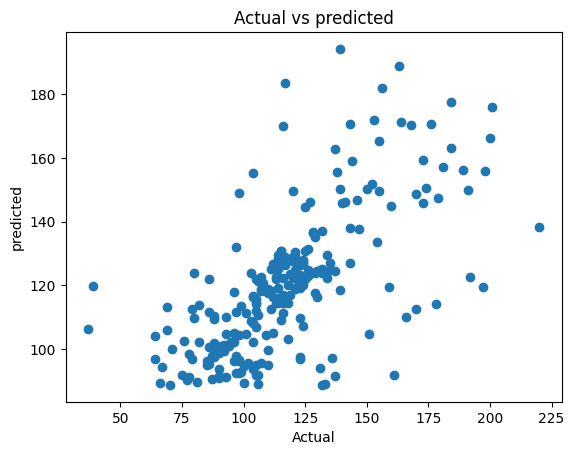

In [21]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test2, np.squeeze(model3.predict(X_test2)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test2, np.squeeze(model3.predict(X_test2)) )
mae= mean_absolute_error(Y_test2, np.squeeze(model3.predict(X_test2)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test2, np.squeeze(model3.predict(X_test2)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [22]:
prediction3 =np.squeeze(model3.predict([[80,2,2,prediction1]]))
print("Prediction: {}".format(prediction3))

y_prd=np.squeeze(np.squeeze(model3.predict(X_test2)) )
predic_dif=pd.DataFrame({'Actual':Y_test2,'predict':y_prd,"differences":Y_test2-y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 160ms/step
Prediction: 122.75299072265625
8/8 [==============================] - 0s 2ms/step


,Actual,predict,differences
22,117,183.459137,-66.459137
905,123,123.210190,-0.210190
619,125,130.923553,-5.923553
1063,113,126.474045,-13.474045
1003,129,124.076149,4.923851
890,124,127.298035,-3.298035
2126,82,113.753922,-31.753922
1101,110,118.998947,-8.998947
2658,81,89.833618,-8.833618
1074,130,124.646317,5.353683


## Random forest with keras tuner RNN

In [23]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
RF= RandomForestRegressor(n_estimators=200,random_state=30)
RF.fit(X_train.values,Y_train.values)

RandomForestRegressor(n_estimators=200, random_state=30)

In [24]:
prediction4 = np.squeeze(RF.predict([[80,2,2]]))
print("Prediction: {}".format(prediction4))

Prediction: 123.135


In [25]:
y_prd=np.squeeze(np.squeeze(model2.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

26/26 [==============================] - 0s 8ms/step
      Actual     predict  differences
352      167  169.542694    -2.542694
1460      95   94.884064     0.115936
1023     123  119.177124     3.822876
2178     100   91.022636     8.977364
2630      87   89.865837    -2.865837
...      ...         ...          ...
305      104  158.539154   -54.539154
1242     125  117.995338     7.004662
442      173  152.371674    20.628326
1703      92   93.056831    -1.056831
1489     107  114.362160    -7.362160

[826 rows x 3 columns]


In [26]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

104.45012664794922
82.26202392578125
-82.54240417480469
112.08887481689453
125.49942016601562
82.27361297607422
133.15432739257812
86.6783447265625
-92.4969482421875
90.68585968017578
81.00790405273438
110.0601577758789
-93.07525634765625
96.57830810546875
-89.088134765625
144.52312469482422
168.21920776367188
128.45784759521484
-95.08271789550781
-87.38644409179688
-89.44937133789062
lower bound: -82.36495449814453
upper bound: 80.3103621531354


In [27]:
A.drop(A[(A['differences'] >80)].index, inplace=True)
A.drop(A[(A['differences'] <-82)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X3=B.drop('Actual',axis=1)
Y3=B['Actual']
X_train3, X_test3, Y_train3, Y_test3 =train_test_split(X3,Y3, test_size=0.3, random_state = 0)

      AverageFloorArea  Quarter  Property Type  Actual     predict
1                    0        1              2     142  167.191650
4                    0        2              1     200  170.510742
9                    0        4              2     174  150.995544
10                   0        4              3     108  149.636017
11                   0        4              4     165  144.501953
...                ...      ...            ...     ...         ...
2734               232        1              1      75   92.398743
2736               232        2              1      96  103.632614
2739               232        3              3     132   89.324921
2740               232        4              3      70   89.595589
2746               233        4              3      74   89.582397

[805 rows x 5 columns]


In [28]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.LSTM(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                                           input_shape=(X_train3.shape[1],1),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [29]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train3,Y_train3 ,epochs=100,validation_data=(X_test3,Y_test3))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model4 = tuner.hypermodel.build(best_hps)

model4.fit(X_train3, Y_train3, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
13/13 [==============================] - 8s 139ms/step - loss: 64.3149 - mean_absolute_error: 64.3149 - val_loss: 17.5331 - val_mean_absolute_error: 17.5331
Epoch 2/2000
13/13 [==============================] - 1s 43ms/step - loss: 16.7665 - mean_absolute_error: 16.7665 - val_loss: 15.5133 - val_mean_absolute_error: 15.5133
Epoch 3/2000
13/13 [==============================] - 0s 36ms/step - loss: 15.3368 - mean_absolute_error: 15.3368 - val_loss: 16.9294 - val_mean_absolute_error: 16.9294
Epoch 4/2000
13/13 [==============================] - 1s 49ms/step - loss: 15.3549 - mean_absolute_error: 15.3549 - val_loss: 22.8820 - val_mean_absolute_error: 22.8820
Epoch 5/2000
13/13 [==============================] - 1s 44ms/step - loss: 18.1226 - mean_absolute_error: 18.1226 - val_loss: 13.6411 - val_mean_

13/13 [==============================] - 0s 38ms/step - loss: 14.3273 - mean_absolute_error: 14.3273 - val_loss: 13.8906 - val_mean_absolute_error: 13.8906
Epoch 49/2000
13/13 [==============================] - 0s 35ms/step - loss: 14.5859 - mean_absolute_error: 14.5859 - val_loss: 14.4207 - val_mean_absolute_error: 14.4207
Epoch 50/2000
13/13 [==============================] - 0s 38ms/step - loss: 15.4542 - mean_absolute_error: 15.4542 - val_loss: 14.9533 - val_mean_absolute_error: 14.9533
Epoch 51/2000
13/13 [==============================] - 0s 35ms/step - loss: 15.5584 - mean_absolute_error: 15.5584 - val_loss: 13.6977 - val_mean_absolute_error: 13.6977
Epoch 52/2000
13/13 [==============================] - 1s 40ms/step - loss: 16.6274 - mean_absolute_error: 16.6274 - val_loss: 15.2164 - val_mean_absolute_error: 15.2164
Epoch 53/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.9669 - mean_absolute_error: 14.9669 - val_loss: 14.2239 - val_mean_absolute_error: 14

13/13 [==============================] - 0s 34ms/step - loss: 14.7404 - mean_absolute_error: 14.7404 - val_loss: 13.7200 - val_mean_absolute_error: 13.7200
Epoch 97/2000
13/13 [==============================] - 0s 39ms/step - loss: 14.3804 - mean_absolute_error: 14.3804 - val_loss: 13.3878 - val_mean_absolute_error: 13.3878
Epoch 98/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.8380 - mean_absolute_error: 14.8380 - val_loss: 13.6749 - val_mean_absolute_error: 13.6749
Epoch 99/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.2980 - mean_absolute_error: 14.2980 - val_loss: 15.0168 - val_mean_absolute_error: 15.0168
Epoch 100/2000
13/13 [==============================] - 0s 35ms/step - loss: 14.8274 - mean_absolute_error: 14.8274 - val_loss: 14.1719 - val_mean_absolute_error: 14.1719
Epoch 101/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.7624 - mean_absolute_error: 14.7624 - val_loss: 13.4082 - val_mean_absolute_error: 

13/13 [==============================] - 1s 51ms/step - loss: 14.4869 - mean_absolute_error: 14.4869 - val_loss: 13.6990 - val_mean_absolute_error: 13.6990
Epoch 145/2000
13/13 [==============================] - 1s 62ms/step - loss: 14.6712 - mean_absolute_error: 14.6712 - val_loss: 13.8113 - val_mean_absolute_error: 13.8113
Epoch 146/2000
13/13 [==============================] - 1s 56ms/step - loss: 14.2650 - mean_absolute_error: 14.2650 - val_loss: 13.4775 - val_mean_absolute_error: 13.4775
Epoch 147/2000
13/13 [==============================] - 1s 53ms/step - loss: 14.2750 - mean_absolute_error: 14.2750 - val_loss: 13.4688 - val_mean_absolute_error: 13.4688
Epoch 148/2000
13/13 [==============================] - 1s 66ms/step - loss: 14.0596 - mean_absolute_error: 14.0596 - val_loss: 13.4231 - val_mean_absolute_error: 13.4231
Epoch 149/2000
13/13 [==============================] - 1s 52ms/step - loss: 14.0173 - mean_absolute_error: 14.0173 - val_loss: 13.4274 - val_mean_absolute_erro

Epoch 192/2000
13/13 [==============================] - 1s 58ms/step - loss: 14.6621 - mean_absolute_error: 14.6621 - val_loss: 13.8818 - val_mean_absolute_error: 13.8818
Epoch 193/2000
13/13 [==============================] - 1s 63ms/step - loss: 14.5504 - mean_absolute_error: 14.5504 - val_loss: 13.5571 - val_mean_absolute_error: 13.5571
Epoch 194/2000
13/13 [==============================] - 1s 47ms/step - loss: 14.2913 - mean_absolute_error: 14.2913 - val_loss: 13.5508 - val_mean_absolute_error: 13.5508
Epoch 195/2000
13/13 [==============================] - 1s 53ms/step - loss: 14.2064 - mean_absolute_error: 14.2064 - val_loss: 13.7316 - val_mean_absolute_error: 13.7316
Epoch 196/2000
13/13 [==============================] - 1s 60ms/step - loss: 15.0090 - mean_absolute_error: 15.0090 - val_loss: 14.1686 - val_mean_absolute_error: 14.1686
Epoch 197/2000
13/13 [==============================] - 1s 52ms/step - loss: 14.5113 - mean_absolute_error: 14.5113 - val_loss: 13.4771 - val_mea

Epoch 240/2000
13/13 [==============================] - 1s 42ms/step - loss: 14.0506 - mean_absolute_error: 14.0506 - val_loss: 14.4613 - val_mean_absolute_error: 14.4613
Epoch 241/2000
13/13 [==============================] - 1s 46ms/step - loss: 14.2189 - mean_absolute_error: 14.2189 - val_loss: 14.3194 - val_mean_absolute_error: 14.3194
Epoch 242/2000
13/13 [==============================] - 1s 49ms/step - loss: 14.0781 - mean_absolute_error: 14.0781 - val_loss: 15.2540 - val_mean_absolute_error: 15.2540
Epoch 243/2000
13/13 [==============================] - 1s 58ms/step - loss: 14.1139 - mean_absolute_error: 14.1139 - val_loss: 14.0906 - val_mean_absolute_error: 14.0906
Epoch 244/2000
13/13 [==============================] - 1s 55ms/step - loss: 14.0183 - mean_absolute_error: 14.0183 - val_loss: 14.1236 - val_mean_absolute_error: 14.1236
Epoch 245/2000
13/13 [==============================] - 1s 55ms/step - loss: 14.1968 - mean_absolute_error: 14.1968 - val_loss: 14.2873 - val_mea

Epoch 288/2000
13/13 [==============================] - 1s 65ms/step - loss: 13.8774 - mean_absolute_error: 13.8774 - val_loss: 14.4151 - val_mean_absolute_error: 14.4151
Epoch 289/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.6795 - mean_absolute_error: 13.6795 - val_loss: 15.3111 - val_mean_absolute_error: 15.3111
Epoch 290/2000
13/13 [==============================] - 1s 55ms/step - loss: 14.2033 - mean_absolute_error: 14.2033 - val_loss: 13.9567 - val_mean_absolute_error: 13.9567
Epoch 291/2000
13/13 [==============================] - 1s 54ms/step - loss: 13.7328 - mean_absolute_error: 13.7328 - val_loss: 14.0275 - val_mean_absolute_error: 14.0275
Epoch 292/2000
13/13 [==============================] - 1s 64ms/step - loss: 13.6824 - mean_absolute_error: 13.6824 - val_loss: 13.5374 - val_mean_absolute_error: 13.5374
Epoch 293/2000
13/13 [==============================] - 1s 56ms/step - loss: 13.6895 - mean_absolute_error: 13.6895 - val_loss: 14.3305 - val_mea

Epoch 336/2000
13/13 [==============================] - 1s 55ms/step - loss: 14.4858 - mean_absolute_error: 14.4858 - val_loss: 13.7566 - val_mean_absolute_error: 13.7566
Epoch 337/2000
13/13 [==============================] - 1s 53ms/step - loss: 14.2508 - mean_absolute_error: 14.2508 - val_loss: 13.7797 - val_mean_absolute_error: 13.7797
Epoch 338/2000
13/13 [==============================] - 1s 50ms/step - loss: 14.1189 - mean_absolute_error: 14.1189 - val_loss: 13.6658 - val_mean_absolute_error: 13.6658
Epoch 339/2000
13/13 [==============================] - 1s 61ms/step - loss: 14.2219 - mean_absolute_error: 14.2219 - val_loss: 13.5383 - val_mean_absolute_error: 13.5383
Epoch 340/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.8488 - mean_absolute_error: 13.8488 - val_loss: 13.8077 - val_mean_absolute_error: 13.8077
Epoch 341/2000
13/13 [==============================] - 1s 52ms/step - loss: 13.7521 - mean_absolute_error: 13.7521 - val_loss: 13.5518 - val_mea

Epoch 384/2000
13/13 [==============================] - 1s 52ms/step - loss: 13.8394 - mean_absolute_error: 13.8394 - val_loss: 14.2467 - val_mean_absolute_error: 14.2467
Epoch 385/2000
13/13 [==============================] - 1s 56ms/step - loss: 13.6902 - mean_absolute_error: 13.6902 - val_loss: 13.9257 - val_mean_absolute_error: 13.9257
Epoch 386/2000
13/13 [==============================] - 1s 58ms/step - loss: 13.5525 - mean_absolute_error: 13.5525 - val_loss: 13.7586 - val_mean_absolute_error: 13.7586
Epoch 387/2000
13/13 [==============================] - 1s 50ms/step - loss: 13.6869 - mean_absolute_error: 13.6869 - val_loss: 14.7455 - val_mean_absolute_error: 14.7455
Epoch 388/2000
13/13 [==============================] - 1s 55ms/step - loss: 14.0807 - mean_absolute_error: 14.0807 - val_loss: 15.0179 - val_mean_absolute_error: 15.0179
Epoch 389/2000
13/13 [==============================] - 1s 58ms/step - loss: 14.1974 - mean_absolute_error: 14.1974 - val_loss: 14.0658 - val_mea

Epoch 432/2000
13/13 [==============================] - 1s 44ms/step - loss: 13.6384 - mean_absolute_error: 13.6384 - val_loss: 13.9689 - val_mean_absolute_error: 13.9689
Epoch 433/2000
13/13 [==============================] - 1s 55ms/step - loss: 13.5988 - mean_absolute_error: 13.5988 - val_loss: 14.8025 - val_mean_absolute_error: 14.8025
Epoch 434/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.6518 - mean_absolute_error: 13.6518 - val_loss: 14.0143 - val_mean_absolute_error: 14.0143
Epoch 435/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.4674 - mean_absolute_error: 13.4674 - val_loss: 14.0893 - val_mean_absolute_error: 14.0893
Epoch 436/2000
13/13 [==============================] - 1s 67ms/step - loss: 13.3980 - mean_absolute_error: 13.3980 - val_loss: 13.8224 - val_mean_absolute_error: 13.8224
Epoch 437/2000
13/13 [==============================] - 1s 58ms/step - loss: 13.5481 - mean_absolute_error: 13.5481 - val_loss: 14.0685 - val_mea

Epoch 480/2000
13/13 [==============================] - 1s 62ms/step - loss: 13.2860 - mean_absolute_error: 13.2860 - val_loss: 14.4283 - val_mean_absolute_error: 14.4283
Epoch 481/2000
13/13 [==============================] - 1s 61ms/step - loss: 13.4339 - mean_absolute_error: 13.4339 - val_loss: 14.2732 - val_mean_absolute_error: 14.2732
Epoch 482/2000
13/13 [==============================] - 1s 72ms/step - loss: 13.5986 - mean_absolute_error: 13.5986 - val_loss: 13.7514 - val_mean_absolute_error: 13.7514
Epoch 483/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.7508 - mean_absolute_error: 13.7508 - val_loss: 15.4354 - val_mean_absolute_error: 15.4354
Epoch 484/2000
13/13 [==============================] - 1s 56ms/step - loss: 14.6510 - mean_absolute_error: 14.6510 - val_loss: 14.7306 - val_mean_absolute_error: 14.7306
Epoch 485/2000
13/13 [==============================] - 1s 58ms/step - loss: 14.3145 - mean_absolute_error: 14.3145 - val_loss: 14.5235 - val_mea

Epoch 528/2000
13/13 [==============================] - 1s 54ms/step - loss: 14.1350 - mean_absolute_error: 14.1350 - val_loss: 14.1339 - val_mean_absolute_error: 14.1339
Epoch 529/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.8122 - mean_absolute_error: 13.8122 - val_loss: 13.5991 - val_mean_absolute_error: 13.5991
Epoch 530/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.5534 - mean_absolute_error: 13.5534 - val_loss: 13.9907 - val_mean_absolute_error: 13.9907
Epoch 531/2000
13/13 [==============================] - 1s 50ms/step - loss: 13.7713 - mean_absolute_error: 13.7713 - val_loss: 13.8861 - val_mean_absolute_error: 13.8861
Epoch 532/2000
13/13 [==============================] - 1s 58ms/step - loss: 14.3579 - mean_absolute_error: 14.3579 - val_loss: 13.6055 - val_mean_absolute_error: 13.6055
Epoch 533/2000
13/13 [==============================] - 1s 58ms/step - loss: 14.6354 - mean_absolute_error: 14.6354 - val_loss: 14.9729 - val_mea

Epoch 576/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.7981 - mean_absolute_error: 13.7981 - val_loss: 13.4984 - val_mean_absolute_error: 13.4984
Epoch 577/2000
13/13 [==============================] - 1s 52ms/step - loss: 13.7925 - mean_absolute_error: 13.7925 - val_loss: 13.7951 - val_mean_absolute_error: 13.7951
Epoch 578/2000
13/13 [==============================] - 1s 53ms/step - loss: 14.1935 - mean_absolute_error: 14.1935 - val_loss: 14.5111 - val_mean_absolute_error: 14.5111
Epoch 579/2000
13/13 [==============================] - 1s 59ms/step - loss: 14.2392 - mean_absolute_error: 14.2392 - val_loss: 13.3540 - val_mean_absolute_error: 13.3540
Epoch 580/2000
13/13 [==============================] - 1s 47ms/step - loss: 13.9683 - mean_absolute_error: 13.9683 - val_loss: 13.6080 - val_mean_absolute_error: 13.6080
Epoch 581/2000
13/13 [==============================] - 1s 65ms/step - loss: 13.9168 - mean_absolute_error: 13.9168 - val_loss: 13.6698 - val_mea

Epoch 624/2000
13/13 [==============================] - 1s 53ms/step - loss: 14.2513 - mean_absolute_error: 14.2513 - val_loss: 13.7281 - val_mean_absolute_error: 13.7281
Epoch 625/2000
13/13 [==============================] - 1s 61ms/step - loss: 14.4271 - mean_absolute_error: 14.4271 - val_loss: 14.1515 - val_mean_absolute_error: 14.1515
Epoch 626/2000
13/13 [==============================] - 1s 52ms/step - loss: 15.4658 - mean_absolute_error: 15.4658 - val_loss: 15.0265 - val_mean_absolute_error: 15.0265
Epoch 627/2000
13/13 [==============================] - 1s 51ms/step - loss: 14.8114 - mean_absolute_error: 14.8114 - val_loss: 14.4403 - val_mean_absolute_error: 14.4403
Epoch 628/2000
13/13 [==============================] - 1s 45ms/step - loss: 14.1352 - mean_absolute_error: 14.1352 - val_loss: 14.4979 - val_mean_absolute_error: 14.4979
Epoch 629/2000
13/13 [==============================] - 1s 54ms/step - loss: 14.9639 - mean_absolute_error: 14.9639 - val_loss: 14.7167 - val_mea

Epoch 672/2000
13/13 [==============================] - 1s 60ms/step - loss: 13.6324 - mean_absolute_error: 13.6324 - val_loss: 13.9331 - val_mean_absolute_error: 13.9331
Epoch 673/2000
13/13 [==============================] - 1s 57ms/step - loss: 13.6451 - mean_absolute_error: 13.6451 - val_loss: 13.4325 - val_mean_absolute_error: 13.4325
Epoch 674/2000
13/13 [==============================] - 1s 50ms/step - loss: 13.3653 - mean_absolute_error: 13.3653 - val_loss: 13.8038 - val_mean_absolute_error: 13.8038
Epoch 675/2000
13/13 [==============================] - 1s 56ms/step - loss: 13.3160 - mean_absolute_error: 13.3160 - val_loss: 14.2868 - val_mean_absolute_error: 14.2868
Epoch 676/2000
13/13 [==============================] - 1s 56ms/step - loss: 13.6227 - mean_absolute_error: 13.6227 - val_loss: 13.6090 - val_mean_absolute_error: 13.6090
Epoch 677/2000
13/13 [==============================] - 1s 59ms/step - loss: 13.3262 - mean_absolute_error: 13.3262 - val_loss: 13.3903 - val_mea

Epoch 720/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.8437 - mean_absolute_error: 13.8437 - val_loss: 14.0398 - val_mean_absolute_error: 14.0398
Epoch 721/2000
13/13 [==============================] - 1s 59ms/step - loss: 13.6963 - mean_absolute_error: 13.6963 - val_loss: 14.0283 - val_mean_absolute_error: 14.0283
Epoch 722/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.6037 - mean_absolute_error: 13.6037 - val_loss: 14.6688 - val_mean_absolute_error: 14.6688
Epoch 723/2000
13/13 [==============================] - 1s 57ms/step - loss: 13.9165 - mean_absolute_error: 13.9165 - val_loss: 14.5534 - val_mean_absolute_error: 14.5534
Epoch 724/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.8165 - mean_absolute_error: 13.8165 - val_loss: 13.6715 - val_mean_absolute_error: 13.6715
Epoch 725/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.3781 - mean_absolute_error: 13.3781 - val_loss: 14.5659 - val_mea

Epoch 768/2000
13/13 [==============================] - 1s 56ms/step - loss: 13.7373 - mean_absolute_error: 13.7373 - val_loss: 14.1428 - val_mean_absolute_error: 14.1428
Epoch 769/2000
13/13 [==============================] - 1s 67ms/step - loss: 14.2918 - mean_absolute_error: 14.2918 - val_loss: 14.5083 - val_mean_absolute_error: 14.5083
Epoch 770/2000
13/13 [==============================] - 1s 59ms/step - loss: 14.0930 - mean_absolute_error: 14.0930 - val_loss: 13.5863 - val_mean_absolute_error: 13.5863
Epoch 771/2000
13/13 [==============================] - 1s 60ms/step - loss: 13.7834 - mean_absolute_error: 13.7834 - val_loss: 13.5248 - val_mean_absolute_error: 13.5248
Epoch 772/2000
13/13 [==============================] - 1s 55ms/step - loss: 13.9004 - mean_absolute_error: 13.9004 - val_loss: 13.9800 - val_mean_absolute_error: 13.9800
Epoch 773/2000
13/13 [==============================] - 1s 47ms/step - loss: 13.7659 - mean_absolute_error: 13.7659 - val_loss: 13.6832 - val_mea

Epoch 816/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.5191 - mean_absolute_error: 13.5191 - val_loss: 14.0461 - val_mean_absolute_error: 14.0461
Epoch 817/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.3016 - mean_absolute_error: 13.3016 - val_loss: 13.6469 - val_mean_absolute_error: 13.6469
Epoch 818/2000
13/13 [==============================] - 1s 57ms/step - loss: 13.1462 - mean_absolute_error: 13.1462 - val_loss: 13.7034 - val_mean_absolute_error: 13.7034
Epoch 819/2000
13/13 [==============================] - 1s 59ms/step - loss: 13.6108 - mean_absolute_error: 13.6108 - val_loss: 14.1740 - val_mean_absolute_error: 14.1740
Epoch 820/2000
13/13 [==============================] - 1s 54ms/step - loss: 13.5311 - mean_absolute_error: 13.5311 - val_loss: 13.8259 - val_mean_absolute_error: 13.8259
Epoch 821/2000
13/13 [==============================] - 1s 55ms/step - loss: 13.7073 - mean_absolute_error: 13.7073 - val_loss: 14.1921 - val_mea

Epoch 864/2000
13/13 [==============================] - 1s 47ms/step - loss: 13.1789 - mean_absolute_error: 13.1789 - val_loss: 13.5944 - val_mean_absolute_error: 13.5944
Epoch 865/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.2690 - mean_absolute_error: 13.2690 - val_loss: 13.9868 - val_mean_absolute_error: 13.9868
Epoch 866/2000
13/13 [==============================] - 1s 65ms/step - loss: 13.4635 - mean_absolute_error: 13.4635 - val_loss: 14.0668 - val_mean_absolute_error: 14.0668
Epoch 867/2000
13/13 [==============================] - 1s 57ms/step - loss: 13.1523 - mean_absolute_error: 13.1523 - val_loss: 13.8815 - val_mean_absolute_error: 13.8815
Epoch 868/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.1347 - mean_absolute_error: 13.1347 - val_loss: 13.6684 - val_mean_absolute_error: 13.6684
Epoch 869/2000
13/13 [==============================] - 1s 54ms/step - loss: 13.1047 - mean_absolute_error: 13.1047 - val_loss: 13.7668 - val_mea

Epoch 912/2000
13/13 [==============================] - 1s 55ms/step - loss: 13.2479 - mean_absolute_error: 13.2479 - val_loss: 13.8593 - val_mean_absolute_error: 13.8593
Epoch 913/2000
13/13 [==============================] - 1s 66ms/step - loss: 13.2430 - mean_absolute_error: 13.2430 - val_loss: 13.6522 - val_mean_absolute_error: 13.6522
Epoch 914/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.0855 - mean_absolute_error: 13.0855 - val_loss: 13.6761 - val_mean_absolute_error: 13.6761
Epoch 915/2000
13/13 [==============================] - 1s 64ms/step - loss: 13.1725 - mean_absolute_error: 13.1725 - val_loss: 14.1489 - val_mean_absolute_error: 14.1489
Epoch 916/2000
13/13 [==============================] - 1s 60ms/step - loss: 13.2356 - mean_absolute_error: 13.2356 - val_loss: 13.9315 - val_mean_absolute_error: 13.9315
Epoch 917/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.1617 - mean_absolute_error: 13.1617 - val_loss: 13.8604 - val_mea

Epoch 960/2000
13/13 [==============================] - 1s 55ms/step - loss: 13.3730 - mean_absolute_error: 13.3730 - val_loss: 13.7059 - val_mean_absolute_error: 13.7059
Epoch 961/2000
13/13 [==============================] - 1s 56ms/step - loss: 13.8221 - mean_absolute_error: 13.8221 - val_loss: 14.4205 - val_mean_absolute_error: 14.4205
Epoch 962/2000
13/13 [==============================] - 1s 47ms/step - loss: 13.5090 - mean_absolute_error: 13.5090 - val_loss: 13.7789 - val_mean_absolute_error: 13.7789
Epoch 963/2000
13/13 [==============================] - 1s 56ms/step - loss: 13.7870 - mean_absolute_error: 13.7870 - val_loss: 13.9932 - val_mean_absolute_error: 13.9932
Epoch 964/2000
13/13 [==============================] - 1s 47ms/step - loss: 13.7834 - mean_absolute_error: 13.7834 - val_loss: 15.1408 - val_mean_absolute_error: 15.1408
Epoch 965/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.7809 - mean_absolute_error: 13.7809 - val_loss: 13.9726 - val_mea

Epoch 1008/2000
13/13 [==============================] - 1s 54ms/step - loss: 13.3302 - mean_absolute_error: 13.3302 - val_loss: 13.7964 - val_mean_absolute_error: 13.7964
Epoch 1009/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.4741 - mean_absolute_error: 13.4741 - val_loss: 13.5797 - val_mean_absolute_error: 13.5797
Epoch 1010/2000
13/13 [==============================] - 1s 65ms/step - loss: 13.4689 - mean_absolute_error: 13.4689 - val_loss: 14.3433 - val_mean_absolute_error: 14.3433
Epoch 1011/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.3247 - mean_absolute_error: 13.3247 - val_loss: 13.7712 - val_mean_absolute_error: 13.7712
Epoch 1012/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.4911 - mean_absolute_error: 13.4911 - val_loss: 13.5979 - val_mean_absolute_error: 13.5979
Epoch 1013/2000
13/13 [==============================] - 1s 59ms/step - loss: 13.2889 - mean_absolute_error: 13.2889 - val_loss: 13.8472 - v

13/13 [==============================] - 1s 50ms/step - loss: 13.7596 - mean_absolute_error: 13.7596 - val_loss: 14.8782 - val_mean_absolute_error: 14.8782
Epoch 1056/2000
13/13 [==============================] - 1s 50ms/step - loss: 13.9359 - mean_absolute_error: 13.9359 - val_loss: 14.3855 - val_mean_absolute_error: 14.3855
Epoch 1057/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.6425 - mean_absolute_error: 13.6425 - val_loss: 13.4912 - val_mean_absolute_error: 13.4912
Epoch 1058/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.2672 - mean_absolute_error: 13.2672 - val_loss: 13.4271 - val_mean_absolute_error: 13.4271
Epoch 1059/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.2030 - mean_absolute_error: 13.2030 - val_loss: 13.7244 - val_mean_absolute_error: 13.7244
Epoch 1060/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.2600 - mean_absolute_error: 13.2600 - val_loss: 13.8609 - val_mean_absolute

Epoch 1103/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.2829 - mean_absolute_error: 13.2829 - val_loss: 13.6629 - val_mean_absolute_error: 13.6629
Epoch 1104/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.1840 - mean_absolute_error: 13.1840 - val_loss: 13.5026 - val_mean_absolute_error: 13.5026
Epoch 1105/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.2501 - mean_absolute_error: 13.2501 - val_loss: 13.6850 - val_mean_absolute_error: 13.6850
Epoch 1106/2000
13/13 [==============================] - 1s 64ms/step - loss: 13.4352 - mean_absolute_error: 13.4352 - val_loss: 13.7674 - val_mean_absolute_error: 13.7674
Epoch 1107/2000
13/13 [==============================] - 1s 50ms/step - loss: 13.7018 - mean_absolute_error: 13.7018 - val_loss: 13.6201 - val_mean_absolute_error: 13.6201
Epoch 1108/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.7464 - mean_absolute_error: 13.7464 - val_loss: 15.2406 - v

13/13 [==============================] - 1s 48ms/step - loss: 13.1676 - mean_absolute_error: 13.1676 - val_loss: 13.4477 - val_mean_absolute_error: 13.4477
Epoch 1151/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.1209 - mean_absolute_error: 13.1209 - val_loss: 13.4996 - val_mean_absolute_error: 13.4996
Epoch 1152/2000
13/13 [==============================] - 1s 57ms/step - loss: 13.1711 - mean_absolute_error: 13.1711 - val_loss: 13.6475 - val_mean_absolute_error: 13.6475
Epoch 1153/2000
13/13 [==============================] - 1s 46ms/step - loss: 13.1325 - mean_absolute_error: 13.1325 - val_loss: 13.7361 - val_mean_absolute_error: 13.7361
Epoch 1154/2000
13/13 [==============================] - 1s 55ms/step - loss: 13.5369 - mean_absolute_error: 13.5369 - val_loss: 14.3833 - val_mean_absolute_error: 14.3833
Epoch 1155/2000
13/13 [==============================] - 1s 59ms/step - loss: 13.4431 - mean_absolute_error: 13.4431 - val_loss: 13.6161 - val_mean_absolute

Epoch 1198/2000
13/13 [==============================] - 1s 62ms/step - loss: 13.4841 - mean_absolute_error: 13.4841 - val_loss: 13.6834 - val_mean_absolute_error: 13.6834
Epoch 1199/2000
13/13 [==============================] - 1s 59ms/step - loss: 13.2471 - mean_absolute_error: 13.2471 - val_loss: 13.5286 - val_mean_absolute_error: 13.5286
Epoch 1200/2000
13/13 [==============================] - 1s 50ms/step - loss: 13.1219 - mean_absolute_error: 13.1219 - val_loss: 13.6268 - val_mean_absolute_error: 13.6268
Epoch 1201/2000
13/13 [==============================] - 1s 50ms/step - loss: 13.1783 - mean_absolute_error: 13.1783 - val_loss: 13.5899 - val_mean_absolute_error: 13.5899
Epoch 1202/2000
13/13 [==============================] - 1s 63ms/step - loss: 13.1503 - mean_absolute_error: 13.1503 - val_loss: 13.5345 - val_mean_absolute_error: 13.5345
Epoch 1203/2000
13/13 [==============================] - 1s 53ms/step - loss: 13.2613 - mean_absolute_error: 13.2613 - val_loss: 13.7275 - v

13/13 [==============================] - 1s 65ms/step - loss: 13.4049 - mean_absolute_error: 13.4049 - val_loss: 13.5636 - val_mean_absolute_error: 13.5636
Epoch 1246/2000
13/13 [==============================] - 1s 51ms/step - loss: 13.4526 - mean_absolute_error: 13.4526 - val_loss: 13.8049 - val_mean_absolute_error: 13.8049
Epoch 1247/2000
13/13 [==============================] - 1s 74ms/step - loss: 13.7705 - mean_absolute_error: 13.7705 - val_loss: 14.0014 - val_mean_absolute_error: 14.0014
Epoch 1248/2000
13/13 [==============================] - 1s 58ms/step - loss: 13.5545 - mean_absolute_error: 13.5545 - val_loss: 14.1691 - val_mean_absolute_error: 14.1691
Epoch 1249/2000
13/13 [==============================] - 1s 60ms/step - loss: 13.4930 - mean_absolute_error: 13.4930 - val_loss: 13.7847 - val_mean_absolute_error: 13.7847
Epoch 1250/2000
13/13 [==============================] - 1s 60ms/step - loss: 13.3633 - mean_absolute_error: 13.3633 - val_loss: 13.6037 - val_mean_absolute

Epoch 1293/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.4013 - mean_absolute_error: 13.4013 - val_loss: 13.8665 - val_mean_absolute_error: 13.8665
Epoch 1294/2000
13/13 [==============================] - 0s 38ms/step - loss: 13.4122 - mean_absolute_error: 13.4122 - val_loss: 14.7240 - val_mean_absolute_error: 14.7240
Epoch 1295/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.3681 - mean_absolute_error: 13.3681 - val_loss: 13.7743 - val_mean_absolute_error: 13.7743
Epoch 1296/2000
13/13 [==============================] - 0s 34ms/step - loss: 13.2814 - mean_absolute_error: 13.2814 - val_loss: 13.9692 - val_mean_absolute_error: 13.9692
Epoch 1297/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.4155 - mean_absolute_error: 13.4155 - val_loss: 13.6263 - val_mean_absolute_error: 13.6263
Epoch 1298/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.2807 - mean_absolute_error: 13.2807 - val_loss: 13.5468 - v

13/13 [==============================] - 0s 36ms/step - loss: 13.6144 - mean_absolute_error: 13.6144 - val_loss: 14.0693 - val_mean_absolute_error: 14.0693
Epoch 1341/2000
13/13 [==============================] - 0s 34ms/step - loss: 13.4846 - mean_absolute_error: 13.4846 - val_loss: 13.9879 - val_mean_absolute_error: 13.9879
Epoch 1342/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.0456 - mean_absolute_error: 13.0456 - val_loss: 13.8082 - val_mean_absolute_error: 13.8082
Epoch 1343/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.2534 - mean_absolute_error: 13.2534 - val_loss: 13.5634 - val_mean_absolute_error: 13.5634
Epoch 1344/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.5868 - mean_absolute_error: 13.5868 - val_loss: 14.5731 - val_mean_absolute_error: 14.5731
Epoch 1345/2000
13/13 [==============================] - 0s 35ms/step - loss: 14.7408 - mean_absolute_error: 14.7408 - val_loss: 14.1498 - val_mean_absolute

Epoch 1388/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.2383 - mean_absolute_error: 13.2383 - val_loss: 13.4053 - val_mean_absolute_error: 13.4053
Epoch 1389/2000
13/13 [==============================] - 0s 39ms/step - loss: 13.0497 - mean_absolute_error: 13.0497 - val_loss: 13.7869 - val_mean_absolute_error: 13.7869
Epoch 1390/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.2127 - mean_absolute_error: 13.2127 - val_loss: 13.7547 - val_mean_absolute_error: 13.7547
Epoch 1391/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.1403 - mean_absolute_error: 13.1403 - val_loss: 13.7576 - val_mean_absolute_error: 13.7576
Epoch 1392/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.1798 - mean_absolute_error: 13.1798 - val_loss: 13.4929 - val_mean_absolute_error: 13.4929
Epoch 1393/2000
13/13 [==============================] - 0s 33ms/step - loss: 13.0027 - mean_absolute_error: 13.0027 - val_loss: 14.0383 - v

13/13 [==============================] - 0s 36ms/step - loss: 12.8928 - mean_absolute_error: 12.8928 - val_loss: 14.0994 - val_mean_absolute_error: 14.0994
Epoch 1436/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.1821 - mean_absolute_error: 13.1821 - val_loss: 14.0032 - val_mean_absolute_error: 14.0032
Epoch 1437/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.1153 - mean_absolute_error: 13.1153 - val_loss: 13.7644 - val_mean_absolute_error: 13.7644
Epoch 1438/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.8655 - mean_absolute_error: 12.8655 - val_loss: 13.6597 - val_mean_absolute_error: 13.6597
Epoch 1439/2000
13/13 [==============================] - 0s 37ms/step - loss: 12.9594 - mean_absolute_error: 12.9594 - val_loss: 13.7709 - val_mean_absolute_error: 13.7709
Epoch 1440/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.9239 - mean_absolute_error: 12.9239 - val_loss: 13.7462 - val_mean_absolute

Epoch 1483/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.0771 - mean_absolute_error: 13.0771 - val_loss: 13.6425 - val_mean_absolute_error: 13.6425
Epoch 1484/2000
13/13 [==============================] - 0s 35ms/step - loss: 12.9280 - mean_absolute_error: 12.9280 - val_loss: 13.6321 - val_mean_absolute_error: 13.6321
Epoch 1485/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.8833 - mean_absolute_error: 12.8833 - val_loss: 13.7274 - val_mean_absolute_error: 13.7274
Epoch 1486/2000
13/13 [==============================] - 0s 35ms/step - loss: 12.8433 - mean_absolute_error: 12.8433 - val_loss: 13.4190 - val_mean_absolute_error: 13.4190
Epoch 1487/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.1234 - mean_absolute_error: 13.1234 - val_loss: 14.6837 - val_mean_absolute_error: 14.6837
Epoch 1488/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.4012 - mean_absolute_error: 13.4012 - val_loss: 13.9579 - v

13/13 [==============================] - 1s 52ms/step - loss: 13.0821 - mean_absolute_error: 13.0821 - val_loss: 13.5711 - val_mean_absolute_error: 13.5711
Epoch 1531/2000
13/13 [==============================] - 1s 40ms/step - loss: 12.9620 - mean_absolute_error: 12.9620 - val_loss: 13.6246 - val_mean_absolute_error: 13.6246
Epoch 1532/2000
13/13 [==============================] - 0s 39ms/step - loss: 12.8982 - mean_absolute_error: 12.8982 - val_loss: 13.6434 - val_mean_absolute_error: 13.6434
Epoch 1533/2000
13/13 [==============================] - 1s 44ms/step - loss: 12.9083 - mean_absolute_error: 12.9083 - val_loss: 13.5779 - val_mean_absolute_error: 13.5779
Epoch 1534/2000
13/13 [==============================] - 1s 44ms/step - loss: 12.9794 - mean_absolute_error: 12.9794 - val_loss: 13.5801 - val_mean_absolute_error: 13.5801
Epoch 1535/2000
13/13 [==============================] - 1s 46ms/step - loss: 12.9770 - mean_absolute_error: 12.9770 - val_loss: 13.6417 - val_mean_absolute

Epoch 1578/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.8325 - mean_absolute_error: 12.8325 - val_loss: 13.5432 - val_mean_absolute_error: 13.5432
Epoch 1579/2000
13/13 [==============================] - 0s 35ms/step - loss: 12.7796 - mean_absolute_error: 12.7796 - val_loss: 13.4369 - val_mean_absolute_error: 13.4369
Epoch 1580/2000
13/13 [==============================] - 1s 41ms/step - loss: 12.7760 - mean_absolute_error: 12.7760 - val_loss: 13.5468 - val_mean_absolute_error: 13.5468
Epoch 1581/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.7299 - mean_absolute_error: 12.7299 - val_loss: 13.7032 - val_mean_absolute_error: 13.7032
Epoch 1582/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.8819 - mean_absolute_error: 12.8819 - val_loss: 13.8007 - val_mean_absolute_error: 13.8007
Epoch 1583/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.8040 - mean_absolute_error: 12.8040 - val_loss: 13.7683 - v

13/13 [==============================] - 0s 38ms/step - loss: 12.5932 - mean_absolute_error: 12.5932 - val_loss: 13.9058 - val_mean_absolute_error: 13.9058
Epoch 1626/2000
13/13 [==============================] - 0s 38ms/step - loss: 13.2292 - mean_absolute_error: 13.2292 - val_loss: 15.0386 - val_mean_absolute_error: 15.0386
Epoch 1627/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.2346 - mean_absolute_error: 13.2346 - val_loss: 13.6724 - val_mean_absolute_error: 13.6724
Epoch 1628/2000
13/13 [==============================] - 1s 41ms/step - loss: 12.9614 - mean_absolute_error: 12.9614 - val_loss: 13.8419 - val_mean_absolute_error: 13.8419
Epoch 1629/2000
13/13 [==============================] - 0s 39ms/step - loss: 12.6112 - mean_absolute_error: 12.6112 - val_loss: 13.5798 - val_mean_absolute_error: 13.5798
Epoch 1630/2000
13/13 [==============================] - 1s 40ms/step - loss: 12.5689 - mean_absolute_error: 12.5689 - val_loss: 13.8267 - val_mean_absolute

Epoch 1673/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.1999 - mean_absolute_error: 13.1999 - val_loss: 14.0126 - val_mean_absolute_error: 14.0126
Epoch 1674/2000
13/13 [==============================] - 0s 34ms/step - loss: 13.0805 - mean_absolute_error: 13.0805 - val_loss: 13.8633 - val_mean_absolute_error: 13.8633
Epoch 1675/2000
13/13 [==============================] - 0s 35ms/step - loss: 12.9557 - mean_absolute_error: 12.9557 - val_loss: 13.2951 - val_mean_absolute_error: 13.2951
Epoch 1676/2000
13/13 [==============================] - 0s 34ms/step - loss: 13.3466 - mean_absolute_error: 13.3466 - val_loss: 13.9482 - val_mean_absolute_error: 13.9482
Epoch 1677/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.6523 - mean_absolute_error: 13.6523 - val_loss: 14.1803 - val_mean_absolute_error: 14.1803
Epoch 1678/2000
13/13 [==============================] - 0s 39ms/step - loss: 13.1678 - mean_absolute_error: 13.1678 - val_loss: 13.6228 - v

13/13 [==============================] - 1s 47ms/step - loss: 12.9972 - mean_absolute_error: 12.9972 - val_loss: 13.7105 - val_mean_absolute_error: 13.7105
Epoch 1721/2000
13/13 [==============================] - 1s 43ms/step - loss: 13.0725 - mean_absolute_error: 13.0725 - val_loss: 13.5773 - val_mean_absolute_error: 13.5773
Epoch 1722/2000
13/13 [==============================] - 1s 44ms/step - loss: 12.9188 - mean_absolute_error: 12.9188 - val_loss: 13.8824 - val_mean_absolute_error: 13.8824
Epoch 1723/2000
13/13 [==============================] - 0s 37ms/step - loss: 12.9757 - mean_absolute_error: 12.9757 - val_loss: 13.6687 - val_mean_absolute_error: 13.6687
Epoch 1724/2000
13/13 [==============================] - 1s 39ms/step - loss: 12.8840 - mean_absolute_error: 12.8840 - val_loss: 14.0749 - val_mean_absolute_error: 14.0749
Epoch 1725/2000
13/13 [==============================] - 1s 43ms/step - loss: 12.8139 - mean_absolute_error: 12.8139 - val_loss: 13.9296 - val_mean_absolute

Epoch 1768/2000
13/13 [==============================] - 0s 35ms/step - loss: 13.2266 - mean_absolute_error: 13.2266 - val_loss: 14.0869 - val_mean_absolute_error: 14.0869
Epoch 1769/2000
13/13 [==============================] - 0s 34ms/step - loss: 12.7212 - mean_absolute_error: 12.7212 - val_loss: 13.6890 - val_mean_absolute_error: 13.6890
Epoch 1770/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.5687 - mean_absolute_error: 12.5687 - val_loss: 13.5425 - val_mean_absolute_error: 13.5425
Epoch 1771/2000
13/13 [==============================] - 0s 35ms/step - loss: 12.7080 - mean_absolute_error: 12.7080 - val_loss: 13.8387 - val_mean_absolute_error: 13.8387
Epoch 1772/2000
13/13 [==============================] - 0s 33ms/step - loss: 12.5946 - mean_absolute_error: 12.5946 - val_loss: 13.8861 - val_mean_absolute_error: 13.8861
Epoch 1773/2000
13/13 [==============================] - 0s 35ms/step - loss: 12.6753 - mean_absolute_error: 12.6753 - val_loss: 13.8365 - v

13/13 [==============================] - 1s 47ms/step - loss: 12.7449 - mean_absolute_error: 12.7449 - val_loss: 13.7556 - val_mean_absolute_error: 13.7556
Epoch 1816/2000
13/13 [==============================] - 1s 48ms/step - loss: 12.9521 - mean_absolute_error: 12.9521 - val_loss: 13.8140 - val_mean_absolute_error: 13.8140
Epoch 1817/2000
13/13 [==============================] - 1s 48ms/step - loss: 12.6445 - mean_absolute_error: 12.6445 - val_loss: 13.8448 - val_mean_absolute_error: 13.8448
Epoch 1818/2000
13/13 [==============================] - 1s 49ms/step - loss: 12.5166 - mean_absolute_error: 12.5166 - val_loss: 13.7555 - val_mean_absolute_error: 13.7555
Epoch 1819/2000
13/13 [==============================] - 1s 42ms/step - loss: 12.5131 - mean_absolute_error: 12.5131 - val_loss: 14.0013 - val_mean_absolute_error: 14.0013
Epoch 1820/2000
13/13 [==============================] - 0s 39ms/step - loss: 12.7319 - mean_absolute_error: 12.7319 - val_loss: 14.0110 - val_mean_absolute

Epoch 1863/2000
13/13 [==============================] - 1s 43ms/step - loss: 12.5666 - mean_absolute_error: 12.5666 - val_loss: 13.7788 - val_mean_absolute_error: 13.7788
Epoch 1864/2000
13/13 [==============================] - 1s 50ms/step - loss: 12.5896 - mean_absolute_error: 12.5896 - val_loss: 13.7448 - val_mean_absolute_error: 13.7448
Epoch 1865/2000
13/13 [==============================] - 1s 46ms/step - loss: 12.5875 - mean_absolute_error: 12.5875 - val_loss: 13.7023 - val_mean_absolute_error: 13.7023
Epoch 1866/2000
13/13 [==============================] - 1s 49ms/step - loss: 12.5600 - mean_absolute_error: 12.5600 - val_loss: 13.8261 - val_mean_absolute_error: 13.8261
Epoch 1867/2000
13/13 [==============================] - 1s 45ms/step - loss: 12.5850 - mean_absolute_error: 12.5850 - val_loss: 13.9992 - val_mean_absolute_error: 13.9992
Epoch 1868/2000
13/13 [==============================] - 1s 47ms/step - loss: 12.9135 - mean_absolute_error: 12.9135 - val_loss: 14.6369 - v

13/13 [==============================] - 1s 40ms/step - loss: 12.5943 - mean_absolute_error: 12.5943 - val_loss: 13.6646 - val_mean_absolute_error: 13.6646
Epoch 1911/2000
13/13 [==============================] - 1s 42ms/step - loss: 12.6743 - mean_absolute_error: 12.6743 - val_loss: 13.8821 - val_mean_absolute_error: 13.8821
Epoch 1912/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.6142 - mean_absolute_error: 12.6142 - val_loss: 13.7713 - val_mean_absolute_error: 13.7713
Epoch 1913/2000
13/13 [==============================] - 0s 35ms/step - loss: 12.6607 - mean_absolute_error: 12.6607 - val_loss: 13.8396 - val_mean_absolute_error: 13.8396
Epoch 1914/2000
13/13 [==============================] - 0s 36ms/step - loss: 12.5014 - mean_absolute_error: 12.5014 - val_loss: 13.8730 - val_mean_absolute_error: 13.8730
Epoch 1915/2000
13/13 [==============================] - 1s 45ms/step - loss: 12.7181 - mean_absolute_error: 12.7181 - val_loss: 13.8396 - val_mean_absolute

Epoch 1958/2000
13/13 [==============================] - 1s 49ms/step - loss: 13.1769 - mean_absolute_error: 13.1769 - val_loss: 13.9388 - val_mean_absolute_error: 13.9388
Epoch 1959/2000
13/13 [==============================] - 1s 47ms/step - loss: 12.7715 - mean_absolute_error: 12.7715 - val_loss: 14.0982 - val_mean_absolute_error: 14.0982
Epoch 1960/2000
13/13 [==============================] - 1s 40ms/step - loss: 12.9825 - mean_absolute_error: 12.9825 - val_loss: 13.7917 - val_mean_absolute_error: 13.7917
Epoch 1961/2000
13/13 [==============================] - 1s 43ms/step - loss: 12.7900 - mean_absolute_error: 12.7900 - val_loss: 13.8733 - val_mean_absolute_error: 13.8733
Epoch 1962/2000
13/13 [==============================] - 1s 46ms/step - loss: 12.9625 - mean_absolute_error: 12.9625 - val_loss: 14.3226 - val_mean_absolute_error: 14.3226
Epoch 1963/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.6030 - mean_absolute_error: 13.6030 - val_loss: 14.1700 - v

8/8 [==============================] - 1s 10ms/step
r2_score: 0.36696182120194154
8/8 [==============================] - 0s 11ms/step
mean squired error: 561.9452370992435
mean absolute error: 15.84718209258781
8/8 [==============================] - 0s 13ms/step


Text(0.5, 1.0, 'Actual vs predicted')

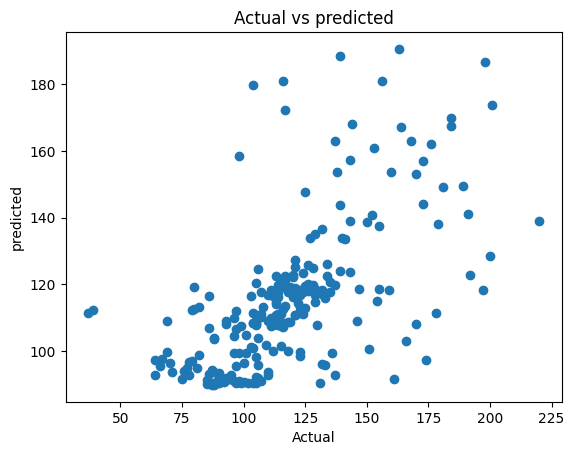

In [30]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test3, np.squeeze(model4.predict(X_test3)) )
r2_score=print('r2_score:', r2_score)


from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test3, np.squeeze(model4.predict(X_test3)) )
mae= mean_absolute_error(Y_test3, np.squeeze(model4.predict(X_test3)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test3, np.squeeze(model4.predict(X_test3)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [31]:
prediction5 =np.squeeze(model4.predict([[80,2,2,prediction4]]))
print("Prediction: {}".format(prediction5))

y_prd=np.squeeze(np.squeeze(model4.predict(X_test3)) )
predic_dif=pd.DataFrame({'Actual':Y_test3,'predict':y_prd,"differences":Y_test3-y_prd})
predic_dif[0:15]

1/1 [==============================] - 1s 856ms/step
Prediction: 118.43585205078125
8/8 [==============================] - 0s 12ms/step


,Actual,predict,differences
22,117,172.175476,-55.175476
905,123,118.427689,4.572311
619,125,119.482422,5.517578
1063,113,122.488121,-9.488121
1003,129,118.625122,10.374878
890,124,118.216057,5.783943
2126,82,113.149490,-31.149490
1101,110,116.890160,-6.890160
2658,81,94.747574,-13.747574
1074,130,117.840576,12.159424


## Dense with keras tuner RNN

In [32]:
from keras.layers import Dense, Dropout,Activation
from keras.models import Sequential
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
model5=Sequential()
model5.add(Dense(128, input_dim=3, activation='relu'))
model5.add(Dense(64,activation='relu'))
model5.add(Dense(1,activation='linear'))
model5.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               512       
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [33]:
model5.fit(X_train,Y_train ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
43/43 [==============================] - 1s 11ms/step - loss: 8314.3213 - mae: 76.4177 - val_loss: 6092.3569 - val_mae: 62.2134
Epoch 2/2000
43/43 [==============================] - 0s 4ms/step - loss: 6317.7124 - mae: 63.8339 - val_loss: 5818.4624 - val_mae: 60.3742
Epoch 3/2000
43/43 [==============================] - 0s 4ms/step - loss: 5947.8291 - mae: 61.7598 - val_loss: 5295.9810 - val_mae: 57.1765
Epoch 4/2000
43/43 [==============================] - 0s 4ms/step - loss: 5185.7412 - mae: 57.3741 - val_loss: 4282.3975 - val_mae: 50.6473
Epoch 5/2000
43/43 [==============================] - 0s 4ms/step - loss: 3920.3623 - mae: 49.3897 - val_loss: 3208.2654 - val_mae: 44.9528
Epoch 6/2000
43/43 [==============================] - 0s 4ms/step - loss: 2785.6614 - mae: 41.3659 - val_loss: 2246.6807 - val_mae: 36.1806
Epoch 7/2000
43/43 [==============================] - 0s 4ms/step - loss: 2101.1199 - mae: 35.6264 - val_loss: 2085.2786 - val_mae: 36.5184
Epoch 8/2000
43/43 

43/43 [==============================] - 0s 4ms/step - loss: 677.8298 - mae: 18.5000 - val_loss: 526.6576 - val_mae: 15.9772
Epoch 60/2000
43/43 [==============================] - 0s 4ms/step - loss: 658.7708 - mae: 17.9513 - val_loss: 512.3403 - val_mae: 16.7025
Epoch 61/2000
43/43 [==============================] - 0s 4ms/step - loss: 644.3021 - mae: 17.6359 - val_loss: 504.1885 - val_mae: 16.4871
Epoch 62/2000
43/43 [==============================] - 0s 4ms/step - loss: 662.9341 - mae: 17.6576 - val_loss: 530.4816 - val_mae: 17.3717
Epoch 63/2000
43/43 [==============================] - 0s 4ms/step - loss: 637.4548 - mae: 17.4981 - val_loss: 662.9775 - val_mae: 20.7851
Epoch 64/2000
43/43 [==============================] - 0s 4ms/step - loss: 660.6757 - mae: 18.0666 - val_loss: 550.2176 - val_mae: 16.2789
Epoch 65/2000
43/43 [==============================] - 0s 4ms/step - loss: 675.7950 - mae: 18.0659 - val_loss: 506.6979 - val_mae: 15.9697
Epoch 66/2000
43/43 [====================

Epoch 118/2000
43/43 [==============================] - 0s 4ms/step - loss: 632.1302 - mae: 17.3539 - val_loss: 508.0917 - val_mae: 15.5184
Epoch 119/2000
43/43 [==============================] - 0s 4ms/step - loss: 611.9346 - mae: 16.8961 - val_loss: 513.3238 - val_mae: 15.6640
Epoch 120/2000
43/43 [==============================] - 0s 4ms/step - loss: 618.1975 - mae: 17.0488 - val_loss: 495.8270 - val_mae: 15.3308
Epoch 121/2000
43/43 [==============================] - 0s 4ms/step - loss: 616.0131 - mae: 17.0028 - val_loss: 481.3567 - val_mae: 15.9874
Epoch 122/2000
43/43 [==============================] - 0s 4ms/step - loss: 635.1553 - mae: 17.4236 - val_loss: 584.0273 - val_mae: 16.9481
Epoch 123/2000
43/43 [==============================] - 0s 4ms/step - loss: 649.5530 - mae: 17.5080 - val_loss: 477.4170 - val_mae: 15.2632
Epoch 124/2000
43/43 [==============================] - 0s 4ms/step - loss: 616.3946 - mae: 16.9531 - val_loss: 476.1197 - val_mae: 15.5688
Epoch 125/2000
43/43

43/43 [==============================] - 0s 4ms/step - loss: 603.1244 - mae: 16.8222 - val_loss: 473.0733 - val_mae: 15.6415
Epoch 177/2000
43/43 [==============================] - 0s 4ms/step - loss: 598.3361 - mae: 16.6999 - val_loss: 467.5777 - val_mae: 15.0263
Epoch 178/2000
43/43 [==============================] - 0s 4ms/step - loss: 605.2966 - mae: 16.9045 - val_loss: 466.6333 - val_mae: 15.2219
Epoch 179/2000
43/43 [==============================] - 0s 4ms/step - loss: 599.4233 - mae: 16.6220 - val_loss: 568.5748 - val_mae: 18.5314
Epoch 180/2000
43/43 [==============================] - 0s 4ms/step - loss: 622.3719 - mae: 17.2807 - val_loss: 486.8112 - val_mae: 15.1064
Epoch 181/2000
43/43 [==============================] - 0s 4ms/step - loss: 604.2891 - mae: 16.8481 - val_loss: 467.6490 - val_mae: 15.3681
Epoch 182/2000
43/43 [==============================] - 0s 4ms/step - loss: 611.7690 - mae: 16.9084 - val_loss: 468.9987 - val_mae: 15.6525
Epoch 183/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 614.7896 - mae: 17.3094 - val_loss: 514.5012 - val_mae: 15.4663
Epoch 235/2000
43/43 [==============================] - 0s 4ms/step - loss: 604.2029 - mae: 16.6452 - val_loss: 465.2389 - val_mae: 15.1594
Epoch 236/2000
43/43 [==============================] - 0s 4ms/step - loss: 611.7031 - mae: 16.8720 - val_loss: 471.2077 - val_mae: 15.5286
Epoch 237/2000
43/43 [==============================] - 0s 5ms/step - loss: 591.4787 - mae: 16.5250 - val_loss: 479.0515 - val_mae: 14.9205
Epoch 238/2000
43/43 [==============================] - 0s 4ms/step - loss: 599.5508 - mae: 16.6054 - val_loss: 459.4241 - val_mae: 14.8298
Epoch 239/2000
43/43 [==============================] - 0s 5ms/step - loss: 592.9733 - mae: 16.4933 - val_loss: 501.4497 - val_mae: 15.5571
Epoch 240/2000
43/43 [==============================] - 0s 4ms/step - loss: 587.8820 - mae: 16.3841 - val_loss: 475.3861 - val_mae: 15.6303
Epoch 241/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 579.5876 - mae: 16.0950 - val_loss: 482.1029 - val_mae: 16.1429
Epoch 293/2000
43/43 [==============================] - 0s 4ms/step - loss: 574.6995 - mae: 16.1760 - val_loss: 473.6743 - val_mae: 14.8964
Epoch 294/2000
43/43 [==============================] - 0s 4ms/step - loss: 573.4933 - mae: 16.1282 - val_loss: 485.6008 - val_mae: 14.9331
Epoch 295/2000
43/43 [==============================] - 0s 4ms/step - loss: 585.2095 - mae: 16.4022 - val_loss: 452.9817 - val_mae: 14.8628
Epoch 296/2000
43/43 [==============================] - 0s 4ms/step - loss: 588.5164 - mae: 16.6489 - val_loss: 447.3862 - val_mae: 14.5787
Epoch 297/2000
43/43 [==============================] - 0s 4ms/step - loss: 578.5238 - mae: 16.2859 - val_loss: 556.4232 - val_mae: 18.1038
Epoch 298/2000
43/43 [==============================] - 0s 4ms/step - loss: 596.1580 - mae: 16.4650 - val_loss: 488.4726 - val_mae: 16.2151
Epoch 299/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 569.9304 - mae: 16.1904 - val_loss: 450.3620 - val_mae: 14.5461
Epoch 351/2000
43/43 [==============================] - 0s 4ms/step - loss: 567.9679 - mae: 15.9666 - val_loss: 447.2828 - val_mae: 14.5926
Epoch 352/2000
43/43 [==============================] - 0s 4ms/step - loss: 584.4420 - mae: 16.2295 - val_loss: 449.7881 - val_mae: 14.9264
Epoch 353/2000
43/43 [==============================] - 0s 4ms/step - loss: 569.3600 - mae: 16.0277 - val_loss: 466.0067 - val_mae: 14.4157
Epoch 354/2000
43/43 [==============================] - 0s 4ms/step - loss: 569.1621 - mae: 15.9241 - val_loss: 501.6572 - val_mae: 15.0782
Epoch 355/2000
43/43 [==============================] - 0s 4ms/step - loss: 564.7257 - mae: 15.9217 - val_loss: 495.7144 - val_mae: 16.3814
Epoch 356/2000
43/43 [==============================] - 0s 4ms/step - loss: 625.0363 - mae: 17.7612 - val_loss: 511.4740 - val_mae: 15.3068
Epoch 357/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 559.0184 - mae: 15.8369 - val_loss: 484.4158 - val_mae: 14.7618
Epoch 409/2000
43/43 [==============================] - 0s 4ms/step - loss: 556.0261 - mae: 15.5798 - val_loss: 496.7033 - val_mae: 16.6167
Epoch 410/2000
43/43 [==============================] - 0s 4ms/step - loss: 596.0049 - mae: 16.8251 - val_loss: 456.0388 - val_mae: 14.4803
Epoch 411/2000
43/43 [==============================] - 0s 4ms/step - loss: 556.7061 - mae: 15.7659 - val_loss: 449.2325 - val_mae: 14.2510
Epoch 412/2000
43/43 [==============================] - 0s 4ms/step - loss: 563.7782 - mae: 16.1530 - val_loss: 440.0316 - val_mae: 14.1868
Epoch 413/2000
43/43 [==============================] - 0s 4ms/step - loss: 569.7601 - mae: 15.9513 - val_loss: 503.1078 - val_mae: 15.0877
Epoch 414/2000
43/43 [==============================] - 0s 4ms/step - loss: 578.0552 - mae: 16.2708 - val_loss: 462.7506 - val_mae: 14.4928
Epoch 415/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 555.6729 - mae: 15.9331 - val_loss: 445.4838 - val_mae: 14.5038
Epoch 467/2000
43/43 [==============================] - 0s 4ms/step - loss: 576.2425 - mae: 16.2025 - val_loss: 438.3323 - val_mae: 14.6510
Epoch 468/2000
43/43 [==============================] - 0s 4ms/step - loss: 545.7021 - mae: 15.6274 - val_loss: 431.1387 - val_mae: 14.2571
Epoch 469/2000
43/43 [==============================] - 0s 4ms/step - loss: 548.2772 - mae: 15.7737 - val_loss: 482.0113 - val_mae: 14.7594
Epoch 470/2000
43/43 [==============================] - 0s 4ms/step - loss: 570.7894 - mae: 16.2862 - val_loss: 491.3810 - val_mae: 14.9239
Epoch 471/2000
43/43 [==============================] - 0s 4ms/step - loss: 551.7854 - mae: 15.5422 - val_loss: 467.8406 - val_mae: 14.5992
Epoch 472/2000
43/43 [==============================] - 0s 4ms/step - loss: 575.5019 - mae: 16.4678 - val_loss: 472.3700 - val_mae: 14.7446
Epoch 473/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 581.1725 - mae: 16.2659 - val_loss: 443.0441 - val_mae: 14.8342
Epoch 525/2000
43/43 [==============================] - 0s 4ms/step - loss: 553.5006 - mae: 15.9903 - val_loss: 434.8898 - val_mae: 14.3113
Epoch 526/2000
43/43 [==============================] - 0s 4ms/step - loss: 538.9595 - mae: 15.5409 - val_loss: 458.1664 - val_mae: 14.4878
Epoch 527/2000
43/43 [==============================] - 0s 4ms/step - loss: 552.9888 - mae: 15.8201 - val_loss: 430.2405 - val_mae: 14.5615
Epoch 528/2000
43/43 [==============================] - 0s 4ms/step - loss: 532.9928 - mae: 15.4435 - val_loss: 444.5271 - val_mae: 14.2961
Epoch 529/2000
43/43 [==============================] - 0s 4ms/step - loss: 563.0527 - mae: 16.0739 - val_loss: 444.3202 - val_mae: 14.8329
Epoch 530/2000
43/43 [==============================] - 0s 4ms/step - loss: 533.0939 - mae: 15.5471 - val_loss: 446.6965 - val_mae: 14.1754
Epoch 531/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 545.2222 - mae: 15.5018 - val_loss: 457.8609 - val_mae: 15.4747
Epoch 583/2000
43/43 [==============================] - 0s 4ms/step - loss: 548.1854 - mae: 15.6216 - val_loss: 462.1850 - val_mae: 15.5768
Epoch 584/2000
43/43 [==============================] - 0s 4ms/step - loss: 536.3608 - mae: 15.6023 - val_loss: 448.8953 - val_mae: 14.2021
Epoch 585/2000
43/43 [==============================] - 0s 4ms/step - loss: 555.9438 - mae: 15.9827 - val_loss: 472.0160 - val_mae: 15.9986
Epoch 586/2000
43/43 [==============================] - 0s 4ms/step - loss: 547.3273 - mae: 15.8960 - val_loss: 454.4927 - val_mae: 14.3608
Epoch 587/2000
43/43 [==============================] - 0s 4ms/step - loss: 540.9604 - mae: 15.4368 - val_loss: 455.8626 - val_mae: 14.3069
Epoch 588/2000
43/43 [==============================] - 0s 4ms/step - loss: 551.0301 - mae: 15.9750 - val_loss: 601.7469 - val_mae: 17.6983
Epoch 589/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 542.3193 - mae: 15.6756 - val_loss: 435.6316 - val_mae: 14.2153
Epoch 641/2000
43/43 [==============================] - 0s 4ms/step - loss: 523.7351 - mae: 15.1539 - val_loss: 506.0495 - val_mae: 16.8099
Epoch 642/2000
43/43 [==============================] - 0s 4ms/step - loss: 543.0690 - mae: 15.8710 - val_loss: 454.3648 - val_mae: 15.1550
Epoch 643/2000
43/43 [==============================] - 0s 4ms/step - loss: 526.6029 - mae: 15.2356 - val_loss: 428.5703 - val_mae: 14.2113
Epoch 644/2000
43/43 [==============================] - 0s 4ms/step - loss: 521.4612 - mae: 15.2589 - val_loss: 441.0197 - val_mae: 14.1054
Epoch 645/2000
43/43 [==============================] - 0s 4ms/step - loss: 524.9911 - mae: 15.2262 - val_loss: 438.6587 - val_mae: 14.8049
Epoch 646/2000
43/43 [==============================] - 0s 4ms/step - loss: 516.5799 - mae: 15.3853 - val_loss: 477.9243 - val_mae: 14.8026
Epoch 647/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 531.2133 - mae: 15.4563 - val_loss: 437.7253 - val_mae: 14.1806
Epoch 699/2000
43/43 [==============================] - 0s 4ms/step - loss: 527.0126 - mae: 15.3359 - val_loss: 455.5071 - val_mae: 14.5186
Epoch 700/2000
43/43 [==============================] - 0s 4ms/step - loss: 521.8154 - mae: 15.2704 - val_loss: 446.2296 - val_mae: 14.4420
Epoch 701/2000
43/43 [==============================] - 0s 4ms/step - loss: 522.1093 - mae: 15.3032 - val_loss: 446.6666 - val_mae: 14.5062
Epoch 702/2000
43/43 [==============================] - 0s 4ms/step - loss: 525.6740 - mae: 15.3709 - val_loss: 448.4038 - val_mae: 15.0795
Epoch 703/2000
43/43 [==============================] - 0s 4ms/step - loss: 515.5148 - mae: 15.1147 - val_loss: 463.5715 - val_mae: 14.8977
Epoch 704/2000
43/43 [==============================] - 0s 4ms/step - loss: 527.8078 - mae: 15.5374 - val_loss: 442.7086 - val_mae: 14.3785
Epoch 705/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 531.2936 - mae: 15.5818 - val_loss: 452.6603 - val_mae: 14.5858
Epoch 757/2000
43/43 [==============================] - 0s 4ms/step - loss: 519.2891 - mae: 15.1851 - val_loss: 452.9939 - val_mae: 14.5066
Epoch 758/2000
43/43 [==============================] - 0s 4ms/step - loss: 509.0336 - mae: 15.0753 - val_loss: 486.8888 - val_mae: 16.3907
Epoch 759/2000
43/43 [==============================] - 0s 4ms/step - loss: 541.7213 - mae: 15.7219 - val_loss: 433.6146 - val_mae: 14.2612
Epoch 760/2000
43/43 [==============================] - 0s 4ms/step - loss: 553.5850 - mae: 16.1925 - val_loss: 482.4451 - val_mae: 14.9354
Epoch 761/2000
43/43 [==============================] - 0s 5ms/step - loss: 521.9385 - mae: 15.2174 - val_loss: 439.0488 - val_mae: 14.4391
Epoch 762/2000
43/43 [==============================] - 0s 4ms/step - loss: 513.7893 - mae: 15.1458 - val_loss: 479.0829 - val_mae: 14.9222
Epoch 763/2000
43/43 [=============

43/43 [==============================] - 0s 5ms/step - loss: 521.9622 - mae: 15.4595 - val_loss: 451.2567 - val_mae: 14.6357
Epoch 815/2000
43/43 [==============================] - 0s 4ms/step - loss: 509.5771 - mae: 15.0870 - val_loss: 471.5429 - val_mae: 15.3241
Epoch 816/2000
43/43 [==============================] - 0s 4ms/step - loss: 517.0306 - mae: 15.2250 - val_loss: 435.3277 - val_mae: 14.3088
Epoch 817/2000
43/43 [==============================] - 0s 4ms/step - loss: 512.1351 - mae: 14.9414 - val_loss: 456.7154 - val_mae: 14.4027
Epoch 818/2000
43/43 [==============================] - 0s 5ms/step - loss: 519.5830 - mae: 15.4716 - val_loss: 443.0679 - val_mae: 14.4754
Epoch 819/2000
43/43 [==============================] - 0s 4ms/step - loss: 506.7078 - mae: 15.2682 - val_loss: 445.0454 - val_mae: 14.8334
Epoch 820/2000
43/43 [==============================] - 0s 4ms/step - loss: 507.3362 - mae: 15.0242 - val_loss: 442.4983 - val_mae: 14.5852
Epoch 821/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 510.5602 - mae: 15.3115 - val_loss: 437.0536 - val_mae: 14.2935
Epoch 873/2000
43/43 [==============================] - 0s 4ms/step - loss: 512.3080 - mae: 15.0803 - val_loss: 483.1176 - val_mae: 14.8734
Epoch 874/2000
43/43 [==============================] - 0s 4ms/step - loss: 516.1649 - mae: 15.1556 - val_loss: 456.5176 - val_mae: 15.0887
Epoch 875/2000
43/43 [==============================] - 0s 4ms/step - loss: 519.2750 - mae: 15.4439 - val_loss: 451.4006 - val_mae: 14.3663
Epoch 876/2000
43/43 [==============================] - 0s 4ms/step - loss: 500.1696 - mae: 14.9460 - val_loss: 449.6888 - val_mae: 14.3696
Epoch 877/2000
43/43 [==============================] - 0s 4ms/step - loss: 504.5298 - mae: 14.8618 - val_loss: 450.1528 - val_mae: 14.7531
Epoch 878/2000
43/43 [==============================] - 0s 4ms/step - loss: 502.9205 - mae: 14.9579 - val_loss: 467.1517 - val_mae: 14.6638
Epoch 879/2000
43/43 [=============

43/43 [==============================] - 0s 5ms/step - loss: 510.7221 - mae: 14.9916 - val_loss: 447.4683 - val_mae: 14.8224
Epoch 931/2000
43/43 [==============================] - 0s 4ms/step - loss: 525.1517 - mae: 15.6804 - val_loss: 467.5645 - val_mae: 14.8698
Epoch 932/2000
43/43 [==============================] - 0s 4ms/step - loss: 510.6953 - mae: 15.1127 - val_loss: 467.5107 - val_mae: 14.5133
Epoch 933/2000
43/43 [==============================] - 0s 4ms/step - loss: 505.8433 - mae: 15.0300 - val_loss: 470.4893 - val_mae: 14.5595
Epoch 934/2000
43/43 [==============================] - 0s 4ms/step - loss: 498.0963 - mae: 14.7966 - val_loss: 565.7071 - val_mae: 18.2026
Epoch 935/2000
43/43 [==============================] - 0s 4ms/step - loss: 533.8155 - mae: 15.7640 - val_loss: 469.8041 - val_mae: 14.6031
Epoch 936/2000
43/43 [==============================] - 0s 4ms/step - loss: 513.4027 - mae: 15.3162 - val_loss: 460.3568 - val_mae: 14.3791
Epoch 937/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 508.4715 - mae: 14.9546 - val_loss: 509.4261 - val_mae: 16.6789
Epoch 989/2000
43/43 [==============================] - 0s 4ms/step - loss: 536.0681 - mae: 15.9705 - val_loss: 453.8448 - val_mae: 14.3871
Epoch 990/2000
43/43 [==============================] - 0s 4ms/step - loss: 500.4338 - mae: 14.9463 - val_loss: 444.3183 - val_mae: 14.3169
Epoch 991/2000
43/43 [==============================] - 0s 4ms/step - loss: 518.2820 - mae: 15.3580 - val_loss: 485.3194 - val_mae: 14.8079
Epoch 992/2000
43/43 [==============================] - 0s 4ms/step - loss: 506.7610 - mae: 15.2636 - val_loss: 461.0150 - val_mae: 14.4112
Epoch 993/2000
43/43 [==============================] - 0s 5ms/step - loss: 500.9303 - mae: 14.9124 - val_loss: 446.1438 - val_mae: 14.1298
Epoch 994/2000
43/43 [==============================] - 0s 4ms/step - loss: 514.9277 - mae: 15.5165 - val_loss: 507.7551 - val_mae: 15.4262
Epoch 995/2000
43/43 [=============

43/43 [==============================] - 0s 4ms/step - loss: 499.9048 - mae: 14.9971 - val_loss: 443.0390 - val_mae: 14.3428
Epoch 1047/2000
43/43 [==============================] - 0s 4ms/step - loss: 525.8425 - mae: 15.9115 - val_loss: 502.0107 - val_mae: 15.3915
Epoch 1048/2000
43/43 [==============================] - 0s 4ms/step - loss: 523.4360 - mae: 15.5259 - val_loss: 449.1401 - val_mae: 14.2197
Epoch 1049/2000
43/43 [==============================] - 0s 4ms/step - loss: 498.2404 - mae: 14.8945 - val_loss: 446.9338 - val_mae: 14.1823
Epoch 1050/2000
43/43 [==============================] - 0s 4ms/step - loss: 504.1761 - mae: 15.0424 - val_loss: 481.9429 - val_mae: 14.8420
Epoch 1051/2000
43/43 [==============================] - 0s 4ms/step - loss: 493.8651 - mae: 14.8021 - val_loss: 463.9700 - val_mae: 14.5562
Epoch 1052/2000
43/43 [==============================] - 0s 4ms/step - loss: 504.9164 - mae: 15.0009 - val_loss: 460.9202 - val_mae: 15.1433
Epoch 1053/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 501.5671 - mae: 15.1505 - val_loss: 473.2836 - val_mae: 14.9535
Epoch 1105/2000
43/43 [==============================] - 0s 4ms/step - loss: 497.3355 - mae: 14.8134 - val_loss: 454.3081 - val_mae: 14.4057
Epoch 1106/2000
43/43 [==============================] - 0s 4ms/step - loss: 498.1238 - mae: 14.9130 - val_loss: 449.8279 - val_mae: 14.4276
Epoch 1107/2000
43/43 [==============================] - 0s 4ms/step - loss: 490.1023 - mae: 14.6892 - val_loss: 457.3990 - val_mae: 14.5299
Epoch 1108/2000
43/43 [==============================] - 0s 4ms/step - loss: 499.8637 - mae: 14.9507 - val_loss: 451.7979 - val_mae: 14.7461
Epoch 1109/2000
43/43 [==============================] - 0s 4ms/step - loss: 500.6828 - mae: 14.8491 - val_loss: 474.1720 - val_mae: 15.3876
Epoch 1110/2000
43/43 [==============================] - 0s 4ms/step - loss: 512.5400 - mae: 15.3360 - val_loss: 448.6647 - val_mae: 14.4971
Epoch 1111/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 500.3696 - mae: 14.9333 - val_loss: 456.3014 - val_mae: 14.6885
Epoch 1163/2000
43/43 [==============================] - 0s 4ms/step - loss: 485.9911 - mae: 14.7055 - val_loss: 464.6164 - val_mae: 14.3422
Epoch 1164/2000
43/43 [==============================] - 0s 4ms/step - loss: 498.5928 - mae: 14.9700 - val_loss: 500.0627 - val_mae: 15.3225
Epoch 1165/2000
43/43 [==============================] - 0s 4ms/step - loss: 496.1828 - mae: 14.9678 - val_loss: 457.6486 - val_mae: 14.3018
Epoch 1166/2000
43/43 [==============================] - 0s 4ms/step - loss: 492.6740 - mae: 14.8844 - val_loss: 470.9461 - val_mae: 15.2520
Epoch 1167/2000
43/43 [==============================] - 0s 4ms/step - loss: 495.0652 - mae: 14.8127 - val_loss: 463.8094 - val_mae: 14.6654
Epoch 1168/2000
43/43 [==============================] - 0s 4ms/step - loss: 491.0915 - mae: 14.8122 - val_loss: 458.6174 - val_mae: 14.3842
Epoch 1169/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 500.4461 - mae: 15.0901 - val_loss: 462.0063 - val_mae: 14.2882
Epoch 1221/2000
43/43 [==============================] - 0s 4ms/step - loss: 495.7442 - mae: 14.8003 - val_loss: 458.6811 - val_mae: 14.4171
Epoch 1222/2000
43/43 [==============================] - 0s 4ms/step - loss: 483.5523 - mae: 14.7968 - val_loss: 451.5095 - val_mae: 14.4430
Epoch 1223/2000
43/43 [==============================] - 0s 4ms/step - loss: 493.7067 - mae: 15.0136 - val_loss: 476.0673 - val_mae: 14.6025
Epoch 1224/2000
43/43 [==============================] - 0s 4ms/step - loss: 498.1877 - mae: 14.8763 - val_loss: 493.3103 - val_mae: 14.9581
Epoch 1225/2000
43/43 [==============================] - 0s 4ms/step - loss: 494.8337 - mae: 14.9516 - val_loss: 464.2588 - val_mae: 14.4048
Epoch 1226/2000
43/43 [==============================] - 0s 4ms/step - loss: 490.7854 - mae: 14.8331 - val_loss: 550.3669 - val_mae: 16.2506
Epoch 1227/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 512.8244 - mae: 15.3234 - val_loss: 456.0477 - val_mae: 14.4418
Epoch 1279/2000
43/43 [==============================] - 0s 4ms/step - loss: 484.0481 - mae: 14.6890 - val_loss: 479.3419 - val_mae: 14.7596
Epoch 1280/2000
43/43 [==============================] - 0s 4ms/step - loss: 511.1761 - mae: 15.2313 - val_loss: 482.6988 - val_mae: 15.3647
Epoch 1281/2000
43/43 [==============================] - 0s 4ms/step - loss: 484.4230 - mae: 14.5962 - val_loss: 444.7526 - val_mae: 14.2234
Epoch 1282/2000
43/43 [==============================] - 0s 4ms/step - loss: 514.9250 - mae: 15.4164 - val_loss: 458.3268 - val_mae: 14.8059
Epoch 1283/2000
43/43 [==============================] - 0s 4ms/step - loss: 487.1055 - mae: 14.6656 - val_loss: 453.2325 - val_mae: 14.4841
Epoch 1284/2000
43/43 [==============================] - 0s 4ms/step - loss: 482.2971 - mae: 14.5620 - val_loss: 449.6177 - val_mae: 14.2357
Epoch 1285/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 480.3109 - mae: 14.5457 - val_loss: 472.7483 - val_mae: 14.7561
Epoch 1337/2000
43/43 [==============================] - 0s 4ms/step - loss: 482.5255 - mae: 14.5456 - val_loss: 461.4860 - val_mae: 14.7573
Epoch 1338/2000
43/43 [==============================] - 0s 4ms/step - loss: 475.3244 - mae: 14.4497 - val_loss: 446.8357 - val_mae: 14.2434
Epoch 1339/2000
43/43 [==============================] - 0s 4ms/step - loss: 485.7862 - mae: 14.5734 - val_loss: 472.0682 - val_mae: 14.5060
Epoch 1340/2000
43/43 [==============================] - 0s 4ms/step - loss: 504.8555 - mae: 15.2565 - val_loss: 484.7203 - val_mae: 14.9411
Epoch 1341/2000
43/43 [==============================] - 0s 4ms/step - loss: 482.1471 - mae: 14.6324 - val_loss: 469.5143 - val_mae: 14.4815
Epoch 1342/2000
43/43 [==============================] - 0s 4ms/step - loss: 480.5575 - mae: 14.5392 - val_loss: 483.0230 - val_mae: 14.9635
Epoch 1343/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 479.6648 - mae: 14.4180 - val_loss: 478.9256 - val_mae: 14.5985
Epoch 1395/2000
43/43 [==============================] - 0s 4ms/step - loss: 476.9930 - mae: 14.5187 - val_loss: 463.6173 - val_mae: 14.4076
Epoch 1396/2000
43/43 [==============================] - 0s 4ms/step - loss: 490.1339 - mae: 14.8294 - val_loss: 462.2116 - val_mae: 14.4010
Epoch 1397/2000
43/43 [==============================] - 0s 4ms/step - loss: 487.4544 - mae: 14.6042 - val_loss: 480.8145 - val_mae: 15.5354
Epoch 1398/2000
43/43 [==============================] - 0s 4ms/step - loss: 487.7167 - mae: 14.9533 - val_loss: 476.8646 - val_mae: 15.5042
Epoch 1399/2000
43/43 [==============================] - 0s 4ms/step - loss: 497.2074 - mae: 14.9767 - val_loss: 466.4838 - val_mae: 14.4173
Epoch 1400/2000
43/43 [==============================] - 0s 4ms/step - loss: 497.3390 - mae: 14.9335 - val_loss: 459.2556 - val_mae: 14.4864
Epoch 1401/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 479.1605 - mae: 14.5430 - val_loss: 465.1261 - val_mae: 14.5916
Epoch 1453/2000
43/43 [==============================] - 0s 4ms/step - loss: 475.2486 - mae: 14.4781 - val_loss: 482.5598 - val_mae: 14.8042
Epoch 1454/2000
43/43 [==============================] - 0s 4ms/step - loss: 491.4952 - mae: 14.9378 - val_loss: 550.2376 - val_mae: 16.2625
Epoch 1455/2000
43/43 [==============================] - 0s 4ms/step - loss: 499.1625 - mae: 14.9495 - val_loss: 476.0386 - val_mae: 14.4377
Epoch 1456/2000
43/43 [==============================] - 0s 4ms/step - loss: 489.0508 - mae: 14.6386 - val_loss: 470.3350 - val_mae: 14.8295
Epoch 1457/2000
43/43 [==============================] - 0s 5ms/step - loss: 477.0854 - mae: 14.4535 - val_loss: 474.6921 - val_mae: 14.4275
Epoch 1458/2000
43/43 [==============================] - 0s 4ms/step - loss: 498.1727 - mae: 15.1060 - val_loss: 485.9207 - val_mae: 14.7396
Epoch 1459/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 498.1325 - mae: 15.0917 - val_loss: 482.1491 - val_mae: 15.0028
Epoch 1511/2000
43/43 [==============================] - 0s 4ms/step - loss: 487.6031 - mae: 14.8763 - val_loss: 460.4726 - val_mae: 14.3720
Epoch 1512/2000
43/43 [==============================] - 0s 4ms/step - loss: 479.2173 - mae: 14.4998 - val_loss: 471.1406 - val_mae: 14.5134
Epoch 1513/2000
43/43 [==============================] - 0s 4ms/step - loss: 479.2293 - mae: 14.6103 - val_loss: 466.0337 - val_mae: 14.5923
Epoch 1514/2000
43/43 [==============================] - 0s 4ms/step - loss: 472.8723 - mae: 14.4194 - val_loss: 473.2539 - val_mae: 14.5714
Epoch 1515/2000
43/43 [==============================] - 0s 4ms/step - loss: 483.2067 - mae: 14.6808 - val_loss: 502.5977 - val_mae: 15.0391
Epoch 1516/2000
43/43 [==============================] - 0s 4ms/step - loss: 486.0066 - mae: 14.7026 - val_loss: 478.7998 - val_mae: 14.4495
Epoch 1517/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 508.6979 - mae: 15.3122 - val_loss: 490.0253 - val_mae: 14.7887
Epoch 1569/2000
43/43 [==============================] - 0s 4ms/step - loss: 476.4712 - mae: 14.5915 - val_loss: 509.7471 - val_mae: 15.0794
Epoch 1570/2000
43/43 [==============================] - 0s 4ms/step - loss: 496.5175 - mae: 15.0431 - val_loss: 483.7414 - val_mae: 14.8370
Epoch 1571/2000
43/43 [==============================] - 0s 4ms/step - loss: 481.2089 - mae: 14.6325 - val_loss: 466.2694 - val_mae: 14.6738
Epoch 1572/2000
43/43 [==============================] - 0s 4ms/step - loss: 484.7607 - mae: 14.7511 - val_loss: 492.0010 - val_mae: 14.9255
Epoch 1573/2000
43/43 [==============================] - 0s 4ms/step - loss: 485.5856 - mae: 14.8301 - val_loss: 489.1064 - val_mae: 15.1299
Epoch 1574/2000
43/43 [==============================] - 0s 4ms/step - loss: 484.6612 - mae: 14.7582 - val_loss: 460.0615 - val_mae: 14.2890
Epoch 1575/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 472.6543 - mae: 14.4325 - val_loss: 466.7975 - val_mae: 14.4611
Epoch 1627/2000
43/43 [==============================] - 0s 4ms/step - loss: 478.7208 - mae: 14.5668 - val_loss: 474.1645 - val_mae: 14.6958
Epoch 1628/2000
43/43 [==============================] - 0s 4ms/step - loss: 472.1070 - mae: 14.6195 - val_loss: 489.4796 - val_mae: 14.9128
Epoch 1629/2000
43/43 [==============================] - 0s 4ms/step - loss: 494.0204 - mae: 15.2420 - val_loss: 468.6225 - val_mae: 14.4746
Epoch 1630/2000
43/43 [==============================] - 0s 4ms/step - loss: 477.7188 - mae: 14.5230 - val_loss: 470.4249 - val_mae: 14.4872
Epoch 1631/2000
43/43 [==============================] - 0s 4ms/step - loss: 465.0587 - mae: 14.4644 - val_loss: 469.2661 - val_mae: 14.5557
Epoch 1632/2000
43/43 [==============================] - 0s 4ms/step - loss: 476.4788 - mae: 14.4929 - val_loss: 508.8000 - val_mae: 15.5721
Epoch 1633/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 471.1990 - mae: 14.4377 - val_loss: 495.7107 - val_mae: 14.8335
Epoch 1685/2000
43/43 [==============================] - 0s 4ms/step - loss: 476.3463 - mae: 14.4110 - val_loss: 479.8411 - val_mae: 15.2907
Epoch 1686/2000
43/43 [==============================] - 0s 4ms/step - loss: 479.0209 - mae: 14.5236 - val_loss: 470.9773 - val_mae: 14.4271
Epoch 1687/2000
43/43 [==============================] - 0s 4ms/step - loss: 476.3456 - mae: 14.4913 - val_loss: 481.3242 - val_mae: 14.7829
Epoch 1688/2000
43/43 [==============================] - 0s 4ms/step - loss: 477.5526 - mae: 14.5426 - val_loss: 461.0977 - val_mae: 14.3910
Epoch 1689/2000
43/43 [==============================] - 0s 4ms/step - loss: 485.0881 - mae: 14.7271 - val_loss: 474.8752 - val_mae: 14.6368
Epoch 1690/2000
43/43 [==============================] - 0s 4ms/step - loss: 469.8190 - mae: 14.2030 - val_loss: 467.9281 - val_mae: 14.3015
Epoch 1691/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 481.0547 - mae: 14.5974 - val_loss: 484.3968 - val_mae: 15.2690
Epoch 1743/2000
43/43 [==============================] - 0s 4ms/step - loss: 479.1165 - mae: 14.5211 - val_loss: 468.5870 - val_mae: 14.4007
Epoch 1744/2000
43/43 [==============================] - 0s 4ms/step - loss: 464.6812 - mae: 14.2511 - val_loss: 510.3780 - val_mae: 15.8735
Epoch 1745/2000
43/43 [==============================] - 0s 4ms/step - loss: 505.7887 - mae: 15.2832 - val_loss: 481.4099 - val_mae: 14.7902
Epoch 1746/2000
43/43 [==============================] - 0s 4ms/step - loss: 467.5978 - mae: 14.1982 - val_loss: 460.5908 - val_mae: 14.2939
Epoch 1747/2000
43/43 [==============================] - 0s 4ms/step - loss: 476.5785 - mae: 14.6324 - val_loss: 480.8636 - val_mae: 14.9111
Epoch 1748/2000
43/43 [==============================] - 0s 4ms/step - loss: 467.4879 - mae: 14.3420 - val_loss: 465.5809 - val_mae: 14.2789
Epoch 1749/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 478.9545 - mae: 14.5178 - val_loss: 505.1669 - val_mae: 15.0781
Epoch 1801/2000
43/43 [==============================] - 0s 4ms/step - loss: 466.7979 - mae: 14.3789 - val_loss: 513.4648 - val_mae: 15.3899
Epoch 1802/2000
43/43 [==============================] - 0s 3ms/step - loss: 470.8730 - mae: 14.4021 - val_loss: 491.8143 - val_mae: 14.7983
Epoch 1803/2000
43/43 [==============================] - 0s 4ms/step - loss: 467.4161 - mae: 14.2304 - val_loss: 495.4773 - val_mae: 14.7349
Epoch 1804/2000
43/43 [==============================] - 0s 3ms/step - loss: 472.9482 - mae: 14.3813 - val_loss: 487.1573 - val_mae: 14.7531
Epoch 1805/2000
43/43 [==============================] - 0s 4ms/step - loss: 471.7939 - mae: 14.4868 - val_loss: 479.9959 - val_mae: 14.4916
Epoch 1806/2000
43/43 [==============================] - 0s 3ms/step - loss: 472.3725 - mae: 14.3328 - val_loss: 496.1843 - val_mae: 15.3446
Epoch 1807/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 460.6559 - mae: 14.1043 - val_loss: 482.5268 - val_mae: 15.0820
Epoch 1859/2000
43/43 [==============================] - 0s 3ms/step - loss: 477.0110 - mae: 14.6281 - val_loss: 507.5995 - val_mae: 15.0257
Epoch 1860/2000
43/43 [==============================] - 0s 4ms/step - loss: 483.4588 - mae: 14.7786 - val_loss: 468.7602 - val_mae: 14.6113
Epoch 1861/2000
43/43 [==============================] - 0s 4ms/step - loss: 467.6114 - mae: 14.3522 - val_loss: 512.9651 - val_mae: 15.2115
Epoch 1862/2000
43/43 [==============================] - 0s 3ms/step - loss: 473.4647 - mae: 14.5810 - val_loss: 485.5371 - val_mae: 14.5154
Epoch 1863/2000
43/43 [==============================] - 0s 4ms/step - loss: 486.4507 - mae: 14.6639 - val_loss: 480.0548 - val_mae: 14.5825
Epoch 1864/2000
43/43 [==============================] - 0s 4ms/step - loss: 465.0592 - mae: 14.3039 - val_loss: 468.5283 - val_mae: 14.3329
Epoch 1865/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 468.1048 - mae: 14.4324 - val_loss: 485.0057 - val_mae: 14.5910
Epoch 1917/2000
43/43 [==============================] - 0s 4ms/step - loss: 485.6117 - mae: 14.6837 - val_loss: 470.0756 - val_mae: 14.3803
Epoch 1918/2000
43/43 [==============================] - 0s 4ms/step - loss: 462.1999 - mae: 14.2321 - val_loss: 487.2199 - val_mae: 14.6167
Epoch 1919/2000
43/43 [==============================] - 0s 4ms/step - loss: 472.1298 - mae: 14.4141 - val_loss: 513.5292 - val_mae: 15.1872
Epoch 1920/2000
43/43 [==============================] - 0s 3ms/step - loss: 462.3765 - mae: 14.1568 - val_loss: 479.8924 - val_mae: 14.4972
Epoch 1921/2000
43/43 [==============================] - 0s 3ms/step - loss: 463.3257 - mae: 14.2890 - val_loss: 482.6256 - val_mae: 14.4453
Epoch 1922/2000
43/43 [==============================] - 0s 4ms/step - loss: 468.5442 - mae: 14.3443 - val_loss: 482.7821 - val_mae: 14.9718
Epoch 1923/2000
43/43 [======

43/43 [==============================] - 0s 4ms/step - loss: 468.5967 - mae: 14.5668 - val_loss: 547.3652 - val_mae: 16.4482
Epoch 1975/2000
43/43 [==============================] - 0s 4ms/step - loss: 478.7495 - mae: 14.9054 - val_loss: 493.9978 - val_mae: 14.6550
Epoch 1976/2000
43/43 [==============================] - 0s 4ms/step - loss: 457.7809 - mae: 14.1182 - val_loss: 474.8822 - val_mae: 14.5375
Epoch 1977/2000
43/43 [==============================] - 0s 4ms/step - loss: 465.3403 - mae: 14.1337 - val_loss: 479.6791 - val_mae: 14.5940
Epoch 1978/2000
43/43 [==============================] - 0s 4ms/step - loss: 460.0969 - mae: 14.1724 - val_loss: 482.4127 - val_mae: 14.6100
Epoch 1979/2000
43/43 [==============================] - 0s 4ms/step - loss: 468.0473 - mae: 14.3673 - val_loss: 497.8195 - val_mae: 14.9797
Epoch 1980/2000
43/43 [==============================] - 0s 4ms/step - loss: 465.9454 - mae: 14.3301 - val_loss: 497.6384 - val_mae: 14.9399
Epoch 1981/2000
43/43 [======

In [34]:
prediction6 = np.squeeze(model5.predict([[80,2,2]]))
print("Prediction: {}".format(prediction6))

1/1 [==============================] - 0s 122ms/step
Prediction: 128.59463500976562


In [35]:
y_prd=np.squeeze(np.squeeze(model5.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

26/26 [==============================] - 0s 2ms/step
      Actual     predict  differences
352      167  153.197617    13.802383
1460      95  104.508881    -9.508881
1023     123  121.876091     1.123909
2178     100   99.470306     0.529694
2630      87   98.157059   -11.157059
...      ...         ...          ...
305      104  182.655075   -78.655075
1242     125  124.345863     0.654137
442      173  147.277664    25.722336
1703      92   98.730865    -6.730865
1489     107  123.061493   -16.061493

[826 rows x 3 columns]


In [36]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

93.6982364654541
98.08851623535156
83.76795959472656
104.50082397460938
128.8340606689453
125.00138854980469
90.30522155761719
132.13388442993164
103.33121490478516
96.73506164550781
102.39891815185547
112.62144470214844
139.4918212890625
170.49212646484375
118.19886779785156
-97.06122589111328
97.64306640625
lower bound: -87.75672651465747
upper bound: 80.10989961586559


In [37]:
A.drop(A[(A['differences'] >80)].index, inplace=True)
A.drop(A[(A['differences'] <-87)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X4=B.drop('Actual',axis=1)
Y4=B['Actual']
X_train4, X_test4, Y_train4, Y_test4 =train_test_split(X4,Y4, test_size=0.3, random_state = 0)

      AverageFloorArea  Quarter  Property Type  Actual     predict
1                    0        1              2     142  195.296860
4                    0        2              1     200  169.263580
10                   0        4              3     108   43.354702
17                   2        2              4     151  151.983612
20                   2        4              2     156  147.967514
...                ...      ...            ...     ...         ...
2734               232        1              1      75  104.704277
2736               232        2              1      96  108.724289
2739               232        3              3     132   95.556030
2740               232        4              3      70   95.253006
2746               233        4              3      74   95.208412

[809 rows x 5 columns]


In [38]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.LSTM(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                                           input_shape=(X_train4.shape[1],1),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [39]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train4,Y_train4 ,epochs=100,validation_data=(X_test4,Y_test4))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model6 = tuner.hypermodel.build(best_hps)

model6.fit(X_train4, Y_train4, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
13/13 [==============================] - 3s 63ms/step - loss: 63.3506 - mean_absolute_error: 63.3506 - val_loss: 24.0789 - val_mean_absolute_error: 24.0789
Epoch 2/2000
13/13 [==============================] - 0s 30ms/step - loss: 17.9556 - mean_absolute_error: 17.9556 - val_loss: 15.1962 - val_mean_absolute_error: 15.1962
Epoch 3/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.6877 - mean_absolute_error: 15.6877 - val_loss: 14.4824 - val_mean_absolute_error: 14.4824
Epoch 4/2000
13/13 [==============================] - 0s 30ms/step - loss: 15.0413 - mean_absolute_error: 15.0413 - val_loss: 14.7339 - val_mean_absolute_error: 14.7339
Epoch 5/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.9141 - mean_absolute_error: 15.9141 - val_loss: 14.4432 - val_mean_a

13/13 [==============================] - 0s 24ms/step - loss: 15.1762 - mean_absolute_error: 15.1762 - val_loss: 17.3987 - val_mean_absolute_error: 17.3987
Epoch 49/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.8802 - mean_absolute_error: 14.8802 - val_loss: 15.4030 - val_mean_absolute_error: 15.4030
Epoch 50/2000
13/13 [==============================] - 0s 25ms/step - loss: 14.9994 - mean_absolute_error: 14.9994 - val_loss: 14.9920 - val_mean_absolute_error: 14.9920
Epoch 51/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.6283 - mean_absolute_error: 14.6283 - val_loss: 14.5604 - val_mean_absolute_error: 14.5604
Epoch 52/2000
13/13 [==============================] - 0s 26ms/step - loss: 15.3594 - mean_absolute_error: 15.3594 - val_loss: 14.7097 - val_mean_absolute_error: 14.7097
Epoch 53/2000
13/13 [==============================] - 0s 25ms/step - loss: 15.3509 - mean_absolute_error: 15.3509 - val_loss: 16.0165 - val_mean_absolute_error: 16

13/13 [==============================] - 0s 31ms/step - loss: 14.6696 - mean_absolute_error: 14.6696 - val_loss: 16.1530 - val_mean_absolute_error: 16.1530
Epoch 97/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.8589 - mean_absolute_error: 14.8589 - val_loss: 16.3625 - val_mean_absolute_error: 16.3625
Epoch 98/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.7501 - mean_absolute_error: 14.7501 - val_loss: 14.2736 - val_mean_absolute_error: 14.2736
Epoch 99/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.3211 - mean_absolute_error: 14.3211 - val_loss: 14.7994 - val_mean_absolute_error: 14.7994
Epoch 100/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.4970 - mean_absolute_error: 14.4970 - val_loss: 14.7668 - val_mean_absolute_error: 14.7668
Epoch 101/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.5444 - mean_absolute_error: 14.5444 - val_loss: 14.6653 - val_mean_absolute_error: 

13/13 [==============================] - 0s 25ms/step - loss: 14.0812 - mean_absolute_error: 14.0812 - val_loss: 14.6016 - val_mean_absolute_error: 14.6016
Epoch 145/2000
13/13 [==============================] - 0s 25ms/step - loss: 13.9817 - mean_absolute_error: 13.9817 - val_loss: 14.2740 - val_mean_absolute_error: 14.2740
Epoch 146/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.3306 - mean_absolute_error: 14.3306 - val_loss: 14.1492 - val_mean_absolute_error: 14.1492
Epoch 147/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.8659 - mean_absolute_error: 14.8659 - val_loss: 15.6724 - val_mean_absolute_error: 15.6724
Epoch 148/2000
13/13 [==============================] - 0s 25ms/step - loss: 15.3953 - mean_absolute_error: 15.3953 - val_loss: 16.5204 - val_mean_absolute_error: 16.5204
Epoch 149/2000
13/13 [==============================] - 0s 25ms/step - loss: 15.2524 - mean_absolute_error: 15.2524 - val_loss: 14.0751 - val_mean_absolute_erro

Epoch 192/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.0545 - mean_absolute_error: 14.0545 - val_loss: 14.5265 - val_mean_absolute_error: 14.5265
Epoch 193/2000
13/13 [==============================] - 0s 25ms/step - loss: 13.9949 - mean_absolute_error: 13.9949 - val_loss: 15.5716 - val_mean_absolute_error: 15.5716
Epoch 194/2000
13/13 [==============================] - 0s 25ms/step - loss: 14.1174 - mean_absolute_error: 14.1174 - val_loss: 14.1040 - val_mean_absolute_error: 14.1040
Epoch 195/2000
13/13 [==============================] - 0s 25ms/step - loss: 14.3994 - mean_absolute_error: 14.3994 - val_loss: 15.7237 - val_mean_absolute_error: 15.7237
Epoch 196/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.6385 - mean_absolute_error: 14.6385 - val_loss: 14.1538 - val_mean_absolute_error: 14.1538
Epoch 197/2000
13/13 [==============================] - 0s 25ms/step - loss: 14.3927 - mean_absolute_error: 14.3927 - val_loss: 14.5846 - val_mea

Epoch 240/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.2651 - mean_absolute_error: 14.2651 - val_loss: 16.0021 - val_mean_absolute_error: 16.0021
Epoch 241/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.3347 - mean_absolute_error: 14.3347 - val_loss: 14.7052 - val_mean_absolute_error: 14.7052
Epoch 242/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.2604 - mean_absolute_error: 14.2604 - val_loss: 14.7868 - val_mean_absolute_error: 14.7868
Epoch 243/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.9855 - mean_absolute_error: 13.9855 - val_loss: 14.6512 - val_mean_absolute_error: 14.6512
Epoch 244/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.0819 - mean_absolute_error: 14.0819 - val_loss: 14.3068 - val_mean_absolute_error: 14.3068
Epoch 245/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.3192 - mean_absolute_error: 14.3192 - val_loss: 15.4468 - val_mea

Epoch 288/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.5317 - mean_absolute_error: 13.5317 - val_loss: 14.4676 - val_mean_absolute_error: 14.4676
Epoch 289/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8336 - mean_absolute_error: 13.8336 - val_loss: 14.0843 - val_mean_absolute_error: 14.0843
Epoch 290/2000
13/13 [==============================] - 0s 26ms/step - loss: 15.0582 - mean_absolute_error: 15.0582 - val_loss: 14.9463 - val_mean_absolute_error: 14.9463
Epoch 291/2000
13/13 [==============================] - 0s 25ms/step - loss: 15.0051 - mean_absolute_error: 15.0051 - val_loss: 14.2522 - val_mean_absolute_error: 14.2522
Epoch 292/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.4336 - mean_absolute_error: 15.4336 - val_loss: 15.8842 - val_mean_absolute_error: 15.8842
Epoch 293/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.2490 - mean_absolute_error: 14.2490 - val_loss: 14.6849 - val_mea

Epoch 336/2000
13/13 [==============================] - 0s 28ms/step - loss: 17.8548 - mean_absolute_error: 17.8548 - val_loss: 16.2661 - val_mean_absolute_error: 16.2661
Epoch 337/2000
13/13 [==============================] - 0s 30ms/step - loss: 15.6556 - mean_absolute_error: 15.6556 - val_loss: 15.1534 - val_mean_absolute_error: 15.1534
Epoch 338/2000
13/13 [==============================] - 0s 25ms/step - loss: 16.1816 - mean_absolute_error: 16.1816 - val_loss: 20.4811 - val_mean_absolute_error: 20.4811
Epoch 339/2000
13/13 [==============================] - 0s 31ms/step - loss: 16.5790 - mean_absolute_error: 16.5790 - val_loss: 16.0552 - val_mean_absolute_error: 16.0552
Epoch 340/2000
13/13 [==============================] - 0s 31ms/step - loss: 15.1276 - mean_absolute_error: 15.1276 - val_loss: 14.3873 - val_mean_absolute_error: 14.3873
Epoch 341/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.4801 - mean_absolute_error: 14.4801 - val_loss: 15.1384 - val_mea

Epoch 384/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.2792 - mean_absolute_error: 14.2792 - val_loss: 15.8563 - val_mean_absolute_error: 15.8563
Epoch 385/2000
13/13 [==============================] - 0s 25ms/step - loss: 15.4371 - mean_absolute_error: 15.4371 - val_loss: 14.3644 - val_mean_absolute_error: 14.3644
Epoch 386/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.0854 - mean_absolute_error: 14.0854 - val_loss: 14.1977 - val_mean_absolute_error: 14.1977
Epoch 387/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.1599 - mean_absolute_error: 14.1599 - val_loss: 14.2900 - val_mean_absolute_error: 14.2900
Epoch 388/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.4440 - mean_absolute_error: 14.4440 - val_loss: 14.5589 - val_mean_absolute_error: 14.5589
Epoch 389/2000
13/13 [==============================] - 0s 25ms/step - loss: 14.3384 - mean_absolute_error: 14.3384 - val_loss: 14.2895 - val_mea

Epoch 432/2000
13/13 [==============================] - 0s 39ms/step - loss: 14.4518 - mean_absolute_error: 14.4518 - val_loss: 13.9777 - val_mean_absolute_error: 13.9777
Epoch 433/2000
13/13 [==============================] - 0s 35ms/step - loss: 14.6134 - mean_absolute_error: 14.6134 - val_loss: 14.1818 - val_mean_absolute_error: 14.1818
Epoch 434/2000
13/13 [==============================] - 0s 34ms/step - loss: 14.0308 - mean_absolute_error: 14.0308 - val_loss: 14.3935 - val_mean_absolute_error: 14.3935
Epoch 435/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.1445 - mean_absolute_error: 14.1445 - val_loss: 14.0671 - val_mean_absolute_error: 14.0671
Epoch 436/2000
13/13 [==============================] - 0s 31ms/step - loss: 13.8600 - mean_absolute_error: 13.8600 - val_loss: 13.7454 - val_mean_absolute_error: 13.7454
Epoch 437/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.0074 - mean_absolute_error: 14.0074 - val_loss: 14.0190 - val_mea

Epoch 480/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.0276 - mean_absolute_error: 14.0276 - val_loss: 14.2828 - val_mean_absolute_error: 14.2828
Epoch 481/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.3650 - mean_absolute_error: 14.3650 - val_loss: 14.4309 - val_mean_absolute_error: 14.4309
Epoch 482/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7721 - mean_absolute_error: 13.7721 - val_loss: 13.9043 - val_mean_absolute_error: 13.9043
Epoch 483/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.1087 - mean_absolute_error: 14.1087 - val_loss: 14.6537 - val_mean_absolute_error: 14.6537
Epoch 484/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.0873 - mean_absolute_error: 14.0873 - val_loss: 14.2572 - val_mean_absolute_error: 14.2572
Epoch 485/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8083 - mean_absolute_error: 13.8083 - val_loss: 13.9125 - val_mea

Epoch 528/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.0619 - mean_absolute_error: 14.0619 - val_loss: 14.1349 - val_mean_absolute_error: 14.1349
Epoch 529/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8805 - mean_absolute_error: 13.8805 - val_loss: 14.6172 - val_mean_absolute_error: 14.6172
Epoch 530/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8294 - mean_absolute_error: 13.8294 - val_loss: 14.6328 - val_mean_absolute_error: 14.6328
Epoch 531/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9122 - mean_absolute_error: 13.9122 - val_loss: 14.7639 - val_mean_absolute_error: 14.7639
Epoch 532/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.9309 - mean_absolute_error: 13.9309 - val_loss: 14.6051 - val_mean_absolute_error: 14.6051
Epoch 533/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8932 - mean_absolute_error: 13.8932 - val_loss: 14.5298 - val_mea

Epoch 576/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.0427 - mean_absolute_error: 14.0427 - val_loss: 14.3594 - val_mean_absolute_error: 14.3594
Epoch 577/2000
13/13 [==============================] - 0s 34ms/step - loss: 13.9403 - mean_absolute_error: 13.9403 - val_loss: 14.7183 - val_mean_absolute_error: 14.7183
Epoch 578/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.1421 - mean_absolute_error: 14.1421 - val_loss: 14.4554 - val_mean_absolute_error: 14.4554
Epoch 579/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.1160 - mean_absolute_error: 14.1160 - val_loss: 14.7525 - val_mean_absolute_error: 14.7525
Epoch 580/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6545 - mean_absolute_error: 13.6545 - val_loss: 14.4579 - val_mean_absolute_error: 14.4579
Epoch 581/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7455 - mean_absolute_error: 13.7455 - val_loss: 14.7602 - val_mea

Epoch 624/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.3707 - mean_absolute_error: 14.3707 - val_loss: 14.9163 - val_mean_absolute_error: 14.9163
Epoch 625/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8067 - mean_absolute_error: 13.8067 - val_loss: 15.0467 - val_mean_absolute_error: 15.0467
Epoch 626/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.1141 - mean_absolute_error: 14.1141 - val_loss: 14.6465 - val_mean_absolute_error: 14.6465
Epoch 627/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.1291 - mean_absolute_error: 14.1291 - val_loss: 15.1767 - val_mean_absolute_error: 15.1767
Epoch 628/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.0583 - mean_absolute_error: 14.0583 - val_loss: 14.9256 - val_mean_absolute_error: 14.9256
Epoch 629/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8957 - mean_absolute_error: 13.8957 - val_loss: 14.5343 - val_mea

Epoch 672/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8010 - mean_absolute_error: 13.8010 - val_loss: 14.2975 - val_mean_absolute_error: 14.2975
Epoch 673/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.9186 - mean_absolute_error: 13.9186 - val_loss: 14.1906 - val_mean_absolute_error: 14.1906
Epoch 674/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8814 - mean_absolute_error: 13.8814 - val_loss: 14.2639 - val_mean_absolute_error: 14.2639
Epoch 675/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5526 - mean_absolute_error: 13.5526 - val_loss: 14.3342 - val_mean_absolute_error: 14.3342
Epoch 676/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8884 - mean_absolute_error: 13.8884 - val_loss: 14.6774 - val_mean_absolute_error: 14.6774
Epoch 677/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8728 - mean_absolute_error: 13.8728 - val_loss: 14.3736 - val_mea

Epoch 720/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5648 - mean_absolute_error: 13.5648 - val_loss: 14.3753 - val_mean_absolute_error: 14.3753
Epoch 721/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8769 - mean_absolute_error: 13.8769 - val_loss: 14.3116 - val_mean_absolute_error: 14.3116
Epoch 722/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.9372 - mean_absolute_error: 13.9372 - val_loss: 14.2564 - val_mean_absolute_error: 14.2564
Epoch 723/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7866 - mean_absolute_error: 13.7866 - val_loss: 14.4440 - val_mean_absolute_error: 14.4440
Epoch 724/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8294 - mean_absolute_error: 13.8294 - val_loss: 14.7201 - val_mean_absolute_error: 14.7201
Epoch 725/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6093 - mean_absolute_error: 13.6093 - val_loss: 14.5945 - val_mea

Epoch 768/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.9475 - mean_absolute_error: 13.9475 - val_loss: 14.4383 - val_mean_absolute_error: 14.4383
Epoch 769/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8062 - mean_absolute_error: 13.8062 - val_loss: 14.0000 - val_mean_absolute_error: 14.0000
Epoch 770/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7636 - mean_absolute_error: 13.7636 - val_loss: 14.1243 - val_mean_absolute_error: 14.1243
Epoch 771/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.8823 - mean_absolute_error: 13.8823 - val_loss: 14.3894 - val_mean_absolute_error: 14.3894
Epoch 772/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.7179 - mean_absolute_error: 13.7179 - val_loss: 14.3161 - val_mean_absolute_error: 14.3161
Epoch 773/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8937 - mean_absolute_error: 13.8937 - val_loss: 14.4362 - val_mea

Epoch 816/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.0016 - mean_absolute_error: 14.0016 - val_loss: 14.5357 - val_mean_absolute_error: 14.5357
Epoch 817/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7220 - mean_absolute_error: 13.7220 - val_loss: 14.1477 - val_mean_absolute_error: 14.1477
Epoch 818/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6317 - mean_absolute_error: 13.6317 - val_loss: 14.0219 - val_mean_absolute_error: 14.0219
Epoch 819/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.6265 - mean_absolute_error: 13.6265 - val_loss: 14.4055 - val_mean_absolute_error: 14.4055
Epoch 820/2000
13/13 [==============================] - 0s 32ms/step - loss: 13.7491 - mean_absolute_error: 13.7491 - val_loss: 14.1231 - val_mean_absolute_error: 14.1231
Epoch 821/2000
13/13 [==============================] - 0s 31ms/step - loss: 13.6943 - mean_absolute_error: 13.6943 - val_loss: 14.2411 - val_mea

Epoch 864/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8403 - mean_absolute_error: 13.8403 - val_loss: 14.7051 - val_mean_absolute_error: 14.7051
Epoch 865/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6733 - mean_absolute_error: 13.6733 - val_loss: 14.4896 - val_mean_absolute_error: 14.4896
Epoch 866/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5965 - mean_absolute_error: 13.5965 - val_loss: 14.3180 - val_mean_absolute_error: 14.3180
Epoch 867/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5692 - mean_absolute_error: 13.5692 - val_loss: 14.3367 - val_mean_absolute_error: 14.3367
Epoch 868/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.3789 - mean_absolute_error: 13.3789 - val_loss: 14.8934 - val_mean_absolute_error: 14.8934
Epoch 869/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5595 - mean_absolute_error: 13.5595 - val_loss: 14.4166 - val_mea

Epoch 912/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.9035 - mean_absolute_error: 13.9035 - val_loss: 14.2879 - val_mean_absolute_error: 14.2879
Epoch 913/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5707 - mean_absolute_error: 13.5707 - val_loss: 14.2952 - val_mean_absolute_error: 14.2952
Epoch 914/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5873 - mean_absolute_error: 13.5873 - val_loss: 14.3885 - val_mean_absolute_error: 14.3885
Epoch 915/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7245 - mean_absolute_error: 13.7245 - val_loss: 14.2766 - val_mean_absolute_error: 14.2766
Epoch 916/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7781 - mean_absolute_error: 13.7781 - val_loss: 14.2506 - val_mean_absolute_error: 14.2506
Epoch 917/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6917 - mean_absolute_error: 13.6917 - val_loss: 14.9179 - val_mea

Epoch 960/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.8727 - mean_absolute_error: 13.8727 - val_loss: 14.3025 - val_mean_absolute_error: 14.3025
Epoch 961/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9131 - mean_absolute_error: 13.9131 - val_loss: 15.3043 - val_mean_absolute_error: 15.3043
Epoch 962/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.8782 - mean_absolute_error: 13.8782 - val_loss: 13.9568 - val_mean_absolute_error: 13.9568
Epoch 963/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.1507 - mean_absolute_error: 14.1507 - val_loss: 14.6493 - val_mean_absolute_error: 14.6493
Epoch 964/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9722 - mean_absolute_error: 13.9722 - val_loss: 14.3016 - val_mean_absolute_error: 14.3016
Epoch 965/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.4974 - mean_absolute_error: 13.4974 - val_loss: 14.5223 - val_mea

Epoch 1008/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.5848 - mean_absolute_error: 14.5848 - val_loss: 14.5026 - val_mean_absolute_error: 14.5026
Epoch 1009/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.0569 - mean_absolute_error: 14.0569 - val_loss: 14.1218 - val_mean_absolute_error: 14.1218
Epoch 1010/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.2421 - mean_absolute_error: 14.2421 - val_loss: 14.4973 - val_mean_absolute_error: 14.4973
Epoch 1011/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8233 - mean_absolute_error: 13.8233 - val_loss: 14.3263 - val_mean_absolute_error: 14.3263
Epoch 1012/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9042 - mean_absolute_error: 13.9042 - val_loss: 14.4939 - val_mean_absolute_error: 14.4939
Epoch 1013/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9952 - mean_absolute_error: 13.9952 - val_loss: 14.4707 - v

13/13 [==============================] - 0s 28ms/step - loss: 13.7086 - mean_absolute_error: 13.7086 - val_loss: 13.9857 - val_mean_absolute_error: 13.9857
Epoch 1056/2000
13/13 [==============================] - 0s 32ms/step - loss: 13.6329 - mean_absolute_error: 13.6329 - val_loss: 13.9821 - val_mean_absolute_error: 13.9821
Epoch 1057/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7108 - mean_absolute_error: 13.7108 - val_loss: 14.0857 - val_mean_absolute_error: 14.0857
Epoch 1058/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7391 - mean_absolute_error: 13.7391 - val_loss: 14.9219 - val_mean_absolute_error: 14.9219
Epoch 1059/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7012 - mean_absolute_error: 13.7012 - val_loss: 13.8132 - val_mean_absolute_error: 13.8132
Epoch 1060/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5803 - mean_absolute_error: 13.5803 - val_loss: 14.0477 - val_mean_absolute

Epoch 1103/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5462 - mean_absolute_error: 13.5462 - val_loss: 14.7208 - val_mean_absolute_error: 14.7208
Epoch 1104/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6623 - mean_absolute_error: 13.6623 - val_loss: 14.7214 - val_mean_absolute_error: 14.7214
Epoch 1105/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7144 - mean_absolute_error: 13.7144 - val_loss: 14.6445 - val_mean_absolute_error: 14.6445
Epoch 1106/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7393 - mean_absolute_error: 13.7393 - val_loss: 14.8901 - val_mean_absolute_error: 14.8901
Epoch 1107/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.8171 - mean_absolute_error: 13.8171 - val_loss: 15.4379 - val_mean_absolute_error: 15.4379
Epoch 1108/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.3242 - mean_absolute_error: 14.3242 - val_loss: 15.7044 - v

13/13 [==============================] - 0s 28ms/step - loss: 13.7287 - mean_absolute_error: 13.7287 - val_loss: 14.3178 - val_mean_absolute_error: 14.3178
Epoch 1151/2000
13/13 [==============================] - 0s 31ms/step - loss: 13.6074 - mean_absolute_error: 13.6074 - val_loss: 14.1838 - val_mean_absolute_error: 14.1838
Epoch 1152/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.4600 - mean_absolute_error: 13.4600 - val_loss: 14.3168 - val_mean_absolute_error: 14.3168
Epoch 1153/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.6200 - mean_absolute_error: 13.6200 - val_loss: 14.3186 - val_mean_absolute_error: 14.3186
Epoch 1154/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.7372 - mean_absolute_error: 13.7372 - val_loss: 14.2160 - val_mean_absolute_error: 14.2160
Epoch 1155/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8104 - mean_absolute_error: 13.8104 - val_loss: 14.8759 - val_mean_absolute

Epoch 1198/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8745 - mean_absolute_error: 13.8745 - val_loss: 14.4258 - val_mean_absolute_error: 14.4258
Epoch 1199/2000
13/13 [==============================] - 0s 32ms/step - loss: 13.5095 - mean_absolute_error: 13.5095 - val_loss: 14.3119 - val_mean_absolute_error: 14.3119
Epoch 1200/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.4683 - mean_absolute_error: 13.4683 - val_loss: 14.8497 - val_mean_absolute_error: 14.8497
Epoch 1201/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9128 - mean_absolute_error: 13.9128 - val_loss: 14.3731 - val_mean_absolute_error: 14.3731
Epoch 1202/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6345 - mean_absolute_error: 13.6345 - val_loss: 14.5521 - val_mean_absolute_error: 14.5521
Epoch 1203/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.5468 - mean_absolute_error: 13.5468 - val_loss: 14.7841 - v

13/13 [==============================] - 0s 27ms/step - loss: 14.0175 - mean_absolute_error: 14.0175 - val_loss: 15.1748 - val_mean_absolute_error: 15.1748
Epoch 1246/2000
13/13 [==============================] - 0s 33ms/step - loss: 13.7943 - mean_absolute_error: 13.7943 - val_loss: 14.9886 - val_mean_absolute_error: 14.9886
Epoch 1247/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8784 - mean_absolute_error: 13.8784 - val_loss: 15.4394 - val_mean_absolute_error: 15.4394
Epoch 1248/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.4652 - mean_absolute_error: 14.4652 - val_loss: 15.3446 - val_mean_absolute_error: 15.3446
Epoch 1249/2000
13/13 [==============================] - 0s 34ms/step - loss: 14.2394 - mean_absolute_error: 14.2394 - val_loss: 15.1061 - val_mean_absolute_error: 15.1061
Epoch 1250/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6866 - mean_absolute_error: 13.6866 - val_loss: 15.2686 - val_mean_absolute

Epoch 1293/2000
13/13 [==============================] - 0s 32ms/step - loss: 13.5317 - mean_absolute_error: 13.5317 - val_loss: 14.2756 - val_mean_absolute_error: 14.2756
Epoch 1294/2000
13/13 [==============================] - 0s 31ms/step - loss: 13.8271 - mean_absolute_error: 13.8271 - val_loss: 14.8873 - val_mean_absolute_error: 14.8873
Epoch 1295/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.5313 - mean_absolute_error: 13.5313 - val_loss: 14.4842 - val_mean_absolute_error: 14.4842
Epoch 1296/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.6748 - mean_absolute_error: 13.6748 - val_loss: 15.5927 - val_mean_absolute_error: 15.5927
Epoch 1297/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.6152 - mean_absolute_error: 13.6152 - val_loss: 14.8866 - val_mean_absolute_error: 14.8866
Epoch 1298/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.6809 - mean_absolute_error: 13.6809 - val_loss: 14.9296 - v

13/13 [==============================] - 0s 27ms/step - loss: 13.6230 - mean_absolute_error: 13.6230 - val_loss: 14.1434 - val_mean_absolute_error: 14.1434
Epoch 1341/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6245 - mean_absolute_error: 13.6245 - val_loss: 14.2768 - val_mean_absolute_error: 14.2768
Epoch 1342/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.4400 - mean_absolute_error: 13.4400 - val_loss: 14.2619 - val_mean_absolute_error: 14.2619
Epoch 1343/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6414 - mean_absolute_error: 13.6414 - val_loss: 14.3217 - val_mean_absolute_error: 14.3217
Epoch 1344/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.6949 - mean_absolute_error: 13.6949 - val_loss: 14.1193 - val_mean_absolute_error: 14.1193
Epoch 1345/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.8768 - mean_absolute_error: 13.8768 - val_loss: 15.0961 - val_mean_absolute

Epoch 1388/2000
13/13 [==============================] - 0s 27ms/step - loss: 15.2434 - mean_absolute_error: 15.2434 - val_loss: 15.9179 - val_mean_absolute_error: 15.9179
Epoch 1389/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7051 - mean_absolute_error: 13.7051 - val_loss: 14.4027 - val_mean_absolute_error: 14.4027
Epoch 1390/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8729 - mean_absolute_error: 13.8729 - val_loss: 14.7643 - val_mean_absolute_error: 14.7643
Epoch 1391/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.8101 - mean_absolute_error: 13.8101 - val_loss: 14.1425 - val_mean_absolute_error: 14.1425
Epoch 1392/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6436 - mean_absolute_error: 13.6436 - val_loss: 15.0291 - val_mean_absolute_error: 15.0291
Epoch 1393/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8640 - mean_absolute_error: 13.8640 - val_loss: 14.4169 - v

13/13 [==============================] - 0s 28ms/step - loss: 13.9856 - mean_absolute_error: 13.9856 - val_loss: 14.3765 - val_mean_absolute_error: 14.3765
Epoch 1436/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6919 - mean_absolute_error: 13.6919 - val_loss: 14.2435 - val_mean_absolute_error: 14.2435
Epoch 1437/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5325 - mean_absolute_error: 13.5325 - val_loss: 14.4004 - val_mean_absolute_error: 14.4004
Epoch 1438/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.4358 - mean_absolute_error: 13.4358 - val_loss: 15.2622 - val_mean_absolute_error: 15.2622
Epoch 1439/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.1748 - mean_absolute_error: 14.1748 - val_loss: 15.2598 - val_mean_absolute_error: 15.2598
Epoch 1440/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.0560 - mean_absolute_error: 14.0560 - val_loss: 14.2531 - val_mean_absolute

Epoch 1483/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6262 - mean_absolute_error: 13.6262 - val_loss: 14.9984 - val_mean_absolute_error: 14.9984
Epoch 1484/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7576 - mean_absolute_error: 13.7576 - val_loss: 14.4814 - val_mean_absolute_error: 14.4814
Epoch 1485/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.4036 - mean_absolute_error: 13.4036 - val_loss: 14.7753 - val_mean_absolute_error: 14.7753
Epoch 1486/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.4692 - mean_absolute_error: 13.4692 - val_loss: 14.2957 - val_mean_absolute_error: 14.2957
Epoch 1487/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.4367 - mean_absolute_error: 13.4367 - val_loss: 14.6209 - val_mean_absolute_error: 14.6209
Epoch 1488/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9193 - mean_absolute_error: 13.9193 - val_loss: 15.4898 - v

13/13 [==============================] - 0s 28ms/step - loss: 13.5138 - mean_absolute_error: 13.5138 - val_loss: 14.3486 - val_mean_absolute_error: 14.3486
Epoch 1531/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5697 - mean_absolute_error: 13.5697 - val_loss: 14.2105 - val_mean_absolute_error: 14.2105
Epoch 1532/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5104 - mean_absolute_error: 13.5104 - val_loss: 14.3328 - val_mean_absolute_error: 14.3328
Epoch 1533/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.3967 - mean_absolute_error: 13.3967 - val_loss: 14.4612 - val_mean_absolute_error: 14.4612
Epoch 1534/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6621 - mean_absolute_error: 13.6621 - val_loss: 14.5954 - val_mean_absolute_error: 14.5954
Epoch 1535/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.3727 - mean_absolute_error: 13.3727 - val_loss: 14.5880 - val_mean_absolute

Epoch 1578/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8005 - mean_absolute_error: 13.8005 - val_loss: 14.4282 - val_mean_absolute_error: 14.4282
Epoch 1579/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5554 - mean_absolute_error: 13.5554 - val_loss: 14.4657 - val_mean_absolute_error: 14.4657
Epoch 1580/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.8789 - mean_absolute_error: 13.8789 - val_loss: 14.6637 - val_mean_absolute_error: 14.6637
Epoch 1581/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5433 - mean_absolute_error: 13.5433 - val_loss: 14.5395 - val_mean_absolute_error: 14.5395
Epoch 1582/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.4840 - mean_absolute_error: 13.4840 - val_loss: 14.2019 - val_mean_absolute_error: 14.2019
Epoch 1583/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.4841 - mean_absolute_error: 13.4841 - val_loss: 14.3197 - v

13/13 [==============================] - 0s 27ms/step - loss: 14.0289 - mean_absolute_error: 14.0289 - val_loss: 14.6362 - val_mean_absolute_error: 14.6362
Epoch 1626/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.0091 - mean_absolute_error: 14.0091 - val_loss: 14.8723 - val_mean_absolute_error: 14.8723
Epoch 1627/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7499 - mean_absolute_error: 13.7499 - val_loss: 14.5978 - val_mean_absolute_error: 14.5978
Epoch 1628/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7032 - mean_absolute_error: 13.7032 - val_loss: 14.7225 - val_mean_absolute_error: 14.7225
Epoch 1629/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.8082 - mean_absolute_error: 13.8082 - val_loss: 14.6188 - val_mean_absolute_error: 14.6188
Epoch 1630/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6150 - mean_absolute_error: 13.6150 - val_loss: 14.4728 - val_mean_absolute

Epoch 1673/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.6043 - mean_absolute_error: 13.6043 - val_loss: 14.8186 - val_mean_absolute_error: 14.8186
Epoch 1674/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.6069 - mean_absolute_error: 13.6069 - val_loss: 14.5661 - val_mean_absolute_error: 14.5661
Epoch 1675/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6322 - mean_absolute_error: 13.6322 - val_loss: 14.7419 - val_mean_absolute_error: 14.7419
Epoch 1676/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7900 - mean_absolute_error: 13.7900 - val_loss: 15.3703 - val_mean_absolute_error: 15.3703
Epoch 1677/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7527 - mean_absolute_error: 13.7527 - val_loss: 14.6817 - val_mean_absolute_error: 14.6817
Epoch 1678/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7122 - mean_absolute_error: 13.7122 - val_loss: 14.6472 - v

13/13 [==============================] - 0s 29ms/step - loss: 13.5471 - mean_absolute_error: 13.5471 - val_loss: 14.9812 - val_mean_absolute_error: 14.9812
Epoch 1721/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.5869 - mean_absolute_error: 13.5869 - val_loss: 14.6173 - val_mean_absolute_error: 14.6173
Epoch 1722/2000
13/13 [==============================] - 0s 31ms/step - loss: 13.6532 - mean_absolute_error: 13.6532 - val_loss: 14.7364 - val_mean_absolute_error: 14.7364
Epoch 1723/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.7683 - mean_absolute_error: 13.7683 - val_loss: 14.6727 - val_mean_absolute_error: 14.6727
Epoch 1724/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.5750 - mean_absolute_error: 13.5750 - val_loss: 14.5203 - val_mean_absolute_error: 14.5203
Epoch 1725/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.7311 - mean_absolute_error: 13.7311 - val_loss: 14.6091 - val_mean_absolute

Epoch 1768/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6989 - mean_absolute_error: 13.6989 - val_loss: 14.4892 - val_mean_absolute_error: 14.4892
Epoch 1769/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.5070 - mean_absolute_error: 13.5070 - val_loss: 14.2531 - val_mean_absolute_error: 14.2531
Epoch 1770/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.5836 - mean_absolute_error: 13.5836 - val_loss: 14.4770 - val_mean_absolute_error: 14.4770
Epoch 1771/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5025 - mean_absolute_error: 13.5025 - val_loss: 15.1727 - val_mean_absolute_error: 15.1727
Epoch 1772/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.4773 - mean_absolute_error: 14.4773 - val_loss: 14.5555 - val_mean_absolute_error: 14.5555
Epoch 1773/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.1918 - mean_absolute_error: 14.1918 - val_loss: 15.2286 - v

13/13 [==============================] - 0s 27ms/step - loss: 13.5127 - mean_absolute_error: 13.5127 - val_loss: 14.3869 - val_mean_absolute_error: 14.3869
Epoch 1816/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.5158 - mean_absolute_error: 13.5158 - val_loss: 15.1786 - val_mean_absolute_error: 15.1786
Epoch 1817/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.8668 - mean_absolute_error: 13.8668 - val_loss: 14.8819 - val_mean_absolute_error: 14.8819
Epoch 1818/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.3954 - mean_absolute_error: 14.3954 - val_loss: 15.0692 - val_mean_absolute_error: 15.0692
Epoch 1819/2000
13/13 [==============================] - 0s 25ms/step - loss: 13.5825 - mean_absolute_error: 13.5825 - val_loss: 14.4714 - val_mean_absolute_error: 14.4714
Epoch 1820/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.3855 - mean_absolute_error: 13.3855 - val_loss: 14.7293 - val_mean_absolute

Epoch 1863/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.6956 - mean_absolute_error: 13.6956 - val_loss: 14.5177 - val_mean_absolute_error: 14.5177
Epoch 1864/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.6411 - mean_absolute_error: 13.6411 - val_loss: 14.1871 - val_mean_absolute_error: 14.1871
Epoch 1865/2000
13/13 [==============================] - 0s 26ms/step - loss: 13.4451 - mean_absolute_error: 13.4451 - val_loss: 14.6416 - val_mean_absolute_error: 14.6416
Epoch 1866/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.6707 - mean_absolute_error: 13.6707 - val_loss: 14.2802 - val_mean_absolute_error: 14.2802
Epoch 1867/2000
13/13 [==============================] - 0s 25ms/step - loss: 13.7485 - mean_absolute_error: 13.7485 - val_loss: 14.4213 - val_mean_absolute_error: 14.4213
Epoch 1868/2000
13/13 [==============================] - 0s 25ms/step - loss: 13.5414 - mean_absolute_error: 13.5414 - val_loss: 14.6143 - v

13/13 [==============================] - 0s 24ms/step - loss: 13.7113 - mean_absolute_error: 13.7113 - val_loss: 14.5101 - val_mean_absolute_error: 14.5101
Epoch 1911/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.4691 - mean_absolute_error: 13.4691 - val_loss: 14.2464 - val_mean_absolute_error: 14.2464
Epoch 1912/2000
13/13 [==============================] - 0s 25ms/step - loss: 13.4121 - mean_absolute_error: 13.4121 - val_loss: 14.1405 - val_mean_absolute_error: 14.1405
Epoch 1913/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.4597 - mean_absolute_error: 13.4597 - val_loss: 14.6227 - val_mean_absolute_error: 14.6227
Epoch 1914/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.4607 - mean_absolute_error: 13.4607 - val_loss: 15.0653 - val_mean_absolute_error: 15.0653
Epoch 1915/2000
13/13 [==============================] - 0s 25ms/step - loss: 13.7456 - mean_absolute_error: 13.7456 - val_loss: 14.3778 - val_mean_absolute

Epoch 1958/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.5760 - mean_absolute_error: 13.5760 - val_loss: 14.5819 - val_mean_absolute_error: 14.5819
Epoch 1959/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.5476 - mean_absolute_error: 13.5476 - val_loss: 14.2324 - val_mean_absolute_error: 14.2324
Epoch 1960/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.4340 - mean_absolute_error: 13.4340 - val_loss: 14.2844 - val_mean_absolute_error: 14.2844
Epoch 1961/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.3717 - mean_absolute_error: 13.3717 - val_loss: 14.3778 - val_mean_absolute_error: 14.3778
Epoch 1962/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.7587 - mean_absolute_error: 13.7587 - val_loss: 14.8721 - val_mean_absolute_error: 14.8721
Epoch 1963/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.6533 - mean_absolute_error: 13.6533 - val_loss: 14.9108 - v

8/8 [==============================] - 0s 8ms/step
r2_score: 0.3550957185734057
8/8 [==============================] - 0s 9ms/step
mean squired error: 666.2595480296643
mean absolute error: 17.52852462642968
8/8 [==============================] - 0s 8ms/step


Text(0.5, 1.0, 'Actual vs predicted')

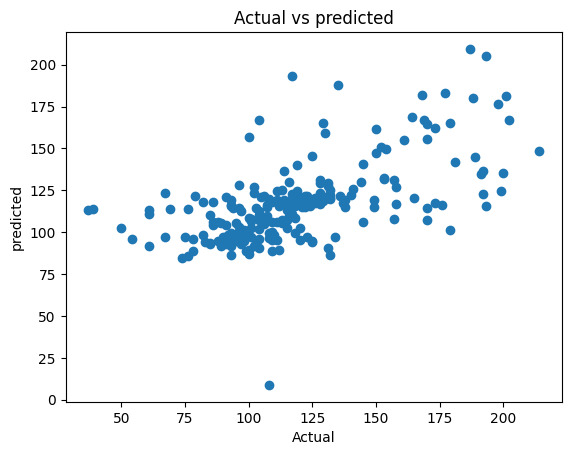

In [40]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test4, np.squeeze(model6.predict(X_test4)) )
print('r2_score:', r2_score)


from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test4, np.squeeze(model6.predict(X_test4)) )
mae= mean_absolute_error(Y_test4, np.squeeze(model6.predict(X_test4)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test4, np.squeeze(model6.predict(X_test4)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [41]:
prediction7 =np.squeeze(model6.predict([[80,2,2,prediction6]]))
print("Prediction: {}".format(prediction7))

y_prd=np.squeeze(np.squeeze(model6.predict(X_test4)) )
predic_dif=pd.DataFrame({'Actual':Y_test4,'predict':y_prd,"differences":Y_test4  -y_prd})
predic_dif[0:15]

1/1 [==============================] - 0s 305ms/step
Prediction: 123.23176574707031
8/8 [==============================] - 0s 8ms/step


,Actual,predict,differences
2126,82,118.184334,-36.184334
703,140,121.997589,18.002411
223,154,149.540009,4.459991
1666,90,97.404510,-7.404510
124,135,187.634628,-52.634628
52,179,101.234993,77.765007
1553,96,114.610825,-18.610825
1713,170,114.201942,55.798058
878,132,119.895828,12.104172
2632,109,88.728470,20.271530


## dense and RNN

In [42]:
from keras.layers import Dense, Dropout,Activation
from keras.models import Sequential
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
model7=Sequential()
model7.add(Dense(128, input_dim=3, activation='relu'))
model7.add(Dense(64,activation='relu'))
model7.add(Dense(1,activation='linear'))
model7.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               512       
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [43]:
model7.fit(X_train,Y_train ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
43/43 [==============================] - 4s 28ms/step - loss: 9143.7314 - mae: 80.5906 - val_loss: 6090.7617 - val_mae: 62.2614
Epoch 2/2000
43/43 [==============================] - 0s 9ms/step - loss: 6254.4141 - mae: 63.4424 - val_loss: 5668.8115 - val_mae: 59.3765
Epoch 3/2000
43/43 [==============================] - 0s 8ms/step - loss: 5656.7090 - mae: 60.1526 - val_loss: 4906.6348 - val_mae: 54.4432
Epoch 4/2000
43/43 [==============================] - 0s 8ms/step - loss: 4567.6387 - mae: 53.6426 - val_loss: 3645.1763 - val_mae: 46.1844
Epoch 5/2000
43/43 [==============================] - 0s 6ms/step - loss: 3201.9507 - mae: 44.2788 - val_loss: 2427.7534 - val_mae: 37.7782
Epoch 6/2000
43/43 [==============================] - 0s 8ms/step - loss: 2224.2195 - mae: 36.4952 - val_loss: 2070.7981 - val_mae: 35.0738
Epoch 7/2000
43/43 [==============================] - 0s 7ms/step - loss: 2041.4681 - mae: 35.3591 - val_loss: 2027.5879 - val_mae: 35.9927
Epoch 8/2000
43/43 

43/43 [==============================] - 0s 6ms/step - loss: 635.6802 - mae: 17.4861 - val_loss: 514.0804 - val_mae: 15.8338
Epoch 60/2000
43/43 [==============================] - 0s 8ms/step - loss: 639.7551 - mae: 17.3015 - val_loss: 575.8015 - val_mae: 18.5665
Epoch 61/2000
43/43 [==============================] - 0s 7ms/step - loss: 658.5482 - mae: 17.8617 - val_loss: 532.7339 - val_mae: 17.2815
Epoch 62/2000
43/43 [==============================] - 0s 7ms/step - loss: 644.4785 - mae: 17.6594 - val_loss: 611.2319 - val_mae: 17.1894
Epoch 63/2000
43/43 [==============================] - 0s 7ms/step - loss: 689.3876 - mae: 18.4419 - val_loss: 508.2433 - val_mae: 16.1749
Epoch 64/2000
43/43 [==============================] - 0s 7ms/step - loss: 641.4933 - mae: 17.6775 - val_loss: 509.1992 - val_mae: 16.7226
Epoch 65/2000
43/43 [==============================] - 0s 6ms/step - loss: 655.6649 - mae: 17.9939 - val_loss: 604.8664 - val_mae: 17.0728
Epoch 66/2000
43/43 [====================

Epoch 118/2000
43/43 [==============================] - 0s 6ms/step - loss: 617.1412 - mae: 17.1905 - val_loss: 606.6607 - val_mae: 17.2027
Epoch 119/2000
43/43 [==============================] - 0s 7ms/step - loss: 654.2614 - mae: 17.7352 - val_loss: 500.3879 - val_mae: 16.3234
Epoch 120/2000
43/43 [==============================] - 0s 6ms/step - loss: 620.5325 - mae: 17.1739 - val_loss: 490.6494 - val_mae: 15.4555
Epoch 121/2000
43/43 [==============================] - 0s 7ms/step - loss: 684.5201 - mae: 18.1327 - val_loss: 510.9854 - val_mae: 15.5283
Epoch 122/2000
43/43 [==============================] - 0s 6ms/step - loss: 625.8144 - mae: 17.1664 - val_loss: 500.7482 - val_mae: 16.1968
Epoch 123/2000
43/43 [==============================] - 0s 6ms/step - loss: 610.4697 - mae: 17.0804 - val_loss: 616.2092 - val_mae: 17.3772
Epoch 124/2000
43/43 [==============================] - 0s 7ms/step - loss: 656.1215 - mae: 17.6451 - val_loss: 516.0899 - val_mae: 16.8867
Epoch 125/2000
43/43

43/43 [==============================] - 0s 6ms/step - loss: 615.6371 - mae: 16.9050 - val_loss: 489.4633 - val_mae: 15.4513
Epoch 177/2000
43/43 [==============================] - 0s 6ms/step - loss: 614.0884 - mae: 16.7704 - val_loss: 496.1306 - val_mae: 16.1239
Epoch 178/2000
43/43 [==============================] - 0s 7ms/step - loss: 627.4227 - mae: 17.1130 - val_loss: 511.3458 - val_mae: 16.4853
Epoch 179/2000
43/43 [==============================] - 0s 7ms/step - loss: 611.6326 - mae: 16.9795 - val_loss: 483.8869 - val_mae: 15.5954
Epoch 180/2000
43/43 [==============================] - 0s 5ms/step - loss: 614.0726 - mae: 16.9038 - val_loss: 504.3537 - val_mae: 15.3920
Epoch 181/2000
43/43 [==============================] - 0s 6ms/step - loss: 610.9536 - mae: 16.9354 - val_loss: 480.6258 - val_mae: 15.1353
Epoch 182/2000
43/43 [==============================] - 0s 7ms/step - loss: 611.7944 - mae: 16.9848 - val_loss: 491.4940 - val_mae: 15.1769
Epoch 183/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 603.1412 - mae: 16.4680 - val_loss: 475.4479 - val_mae: 15.2268
Epoch 235/2000
43/43 [==============================] - 0s 8ms/step - loss: 597.3837 - mae: 16.6424 - val_loss: 530.4266 - val_mae: 15.7893
Epoch 236/2000
43/43 [==============================] - 0s 5ms/step - loss: 602.0914 - mae: 16.7526 - val_loss: 612.2752 - val_mae: 17.3857
Epoch 237/2000
43/43 [==============================] - 0s 6ms/step - loss: 608.8611 - mae: 16.8735 - val_loss: 482.0744 - val_mae: 15.1523
Epoch 238/2000
43/43 [==============================] - 0s 8ms/step - loss: 608.0923 - mae: 16.8379 - val_loss: 483.2753 - val_mae: 15.9599
Epoch 239/2000
43/43 [==============================] - 0s 8ms/step - loss: 608.7298 - mae: 16.8456 - val_loss: 485.0885 - val_mae: 15.1743
Epoch 240/2000
43/43 [==============================] - 0s 7ms/step - loss: 601.5283 - mae: 16.4755 - val_loss: 538.5591 - val_mae: 17.6980
Epoch 241/2000
43/43 [=============

43/43 [==============================] - 0s 6ms/step - loss: 626.1257 - mae: 16.8993 - val_loss: 470.6790 - val_mae: 15.2135
Epoch 293/2000
43/43 [==============================] - 0s 7ms/step - loss: 609.5349 - mae: 16.7087 - val_loss: 481.3402 - val_mae: 14.9861
Epoch 294/2000
43/43 [==============================] - 0s 7ms/step - loss: 609.6167 - mae: 16.7987 - val_loss: 469.8619 - val_mae: 15.3070
Epoch 295/2000
43/43 [==============================] - 0s 7ms/step - loss: 600.4427 - mae: 16.6500 - val_loss: 472.2626 - val_mae: 15.5046
Epoch 296/2000
43/43 [==============================] - 0s 7ms/step - loss: 595.5992 - mae: 16.3845 - val_loss: 525.6321 - val_mae: 17.2792
Epoch 297/2000
43/43 [==============================] - 0s 6ms/step - loss: 591.1712 - mae: 16.4397 - val_loss: 466.0509 - val_mae: 15.2570
Epoch 298/2000
43/43 [==============================] - 0s 6ms/step - loss: 584.0583 - mae: 16.3826 - val_loss: 524.4567 - val_mae: 15.7367
Epoch 299/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 589.5992 - mae: 16.4873 - val_loss: 479.8432 - val_mae: 15.8806
Epoch 351/2000
43/43 [==============================] - 0s 7ms/step - loss: 581.7648 - mae: 16.1668 - val_loss: 505.2278 - val_mae: 16.6893
Epoch 352/2000
43/43 [==============================] - 0s 6ms/step - loss: 582.9098 - mae: 16.3024 - val_loss: 502.2734 - val_mae: 15.3069
Epoch 353/2000
43/43 [==============================] - 0s 7ms/step - loss: 583.6664 - mae: 16.1771 - val_loss: 462.0446 - val_mae: 15.1889
Epoch 354/2000
43/43 [==============================] - 0s 7ms/step - loss: 579.8047 - mae: 16.0351 - val_loss: 488.8473 - val_mae: 16.2345
Epoch 355/2000
43/43 [==============================] - 0s 7ms/step - loss: 608.4829 - mae: 16.6602 - val_loss: 527.5940 - val_mae: 17.4464
Epoch 356/2000
43/43 [==============================] - 0s 6ms/step - loss: 584.8017 - mae: 16.3352 - val_loss: 537.0148 - val_mae: 15.8862
Epoch 357/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 572.6621 - mae: 16.0093 - val_loss: 457.1805 - val_mae: 15.0699
Epoch 409/2000
43/43 [==============================] - 0s 7ms/step - loss: 565.7318 - mae: 16.1311 - val_loss: 470.7386 - val_mae: 14.9771
Epoch 410/2000
43/43 [==============================] - 0s 7ms/step - loss: 565.9614 - mae: 15.9724 - val_loss: 490.9110 - val_mae: 14.9787
Epoch 411/2000
43/43 [==============================] - 0s 6ms/step - loss: 569.0059 - mae: 16.0485 - val_loss: 451.9077 - val_mae: 14.6309
Epoch 412/2000
43/43 [==============================] - 0s 7ms/step - loss: 572.7951 - mae: 16.1763 - val_loss: 542.7679 - val_mae: 16.1267
Epoch 413/2000
43/43 [==============================] - 0s 8ms/step - loss: 570.2184 - mae: 16.0291 - val_loss: 533.0665 - val_mae: 15.8678
Epoch 414/2000
43/43 [==============================] - 0s 6ms/step - loss: 601.1272 - mae: 16.8470 - val_loss: 484.7077 - val_mae: 14.8824
Epoch 415/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 572.3604 - mae: 16.3320 - val_loss: 446.5998 - val_mae: 14.6445
Epoch 467/2000
43/43 [==============================] - 0s 7ms/step - loss: 569.6295 - mae: 16.1212 - val_loss: 452.6207 - val_mae: 15.0195
Epoch 468/2000
43/43 [==============================] - 0s 7ms/step - loss: 557.9579 - mae: 15.8929 - val_loss: 468.7713 - val_mae: 14.7880
Epoch 469/2000
43/43 [==============================] - 0s 6ms/step - loss: 554.2336 - mae: 15.8089 - val_loss: 481.3247 - val_mae: 14.9218
Epoch 470/2000
43/43 [==============================] - 0s 6ms/step - loss: 566.3400 - mae: 16.1959 - val_loss: 456.3468 - val_mae: 14.6494
Epoch 471/2000
43/43 [==============================] - 0s 7ms/step - loss: 547.2495 - mae: 15.6693 - val_loss: 451.6753 - val_mae: 14.8520
Epoch 472/2000
43/43 [==============================] - 0s 7ms/step - loss: 558.4186 - mae: 15.9006 - val_loss: 477.0804 - val_mae: 15.0492
Epoch 473/2000
43/43 [=============

43/43 [==============================] - 0s 8ms/step - loss: 545.2474 - mae: 15.5827 - val_loss: 457.2535 - val_mae: 14.6283
Epoch 525/2000
43/43 [==============================] - 0s 7ms/step - loss: 552.6973 - mae: 15.8027 - val_loss: 465.3677 - val_mae: 14.7470
Epoch 526/2000
43/43 [==============================] - 0s 6ms/step - loss: 550.1758 - mae: 15.8023 - val_loss: 469.1126 - val_mae: 14.6810
Epoch 527/2000
43/43 [==============================] - 0s 7ms/step - loss: 540.4186 - mae: 15.5749 - val_loss: 448.4592 - val_mae: 14.9672
Epoch 528/2000
43/43 [==============================] - 0s 7ms/step - loss: 542.4130 - mae: 15.6032 - val_loss: 451.6976 - val_mae: 14.5458
Epoch 529/2000
43/43 [==============================] - 0s 7ms/step - loss: 558.2237 - mae: 16.0663 - val_loss: 485.2518 - val_mae: 16.3409
Epoch 530/2000
43/43 [==============================] - 0s 9ms/step - loss: 555.2522 - mae: 15.9599 - val_loss: 462.5301 - val_mae: 15.3168
Epoch 531/2000
43/43 [=============

43/43 [==============================] - 0s 6ms/step - loss: 547.1814 - mae: 16.0008 - val_loss: 442.5916 - val_mae: 14.6237
Epoch 583/2000
43/43 [==============================] - 0s 6ms/step - loss: 540.5251 - mae: 15.8164 - val_loss: 470.9315 - val_mae: 15.2973
Epoch 584/2000
43/43 [==============================] - 0s 7ms/step - loss: 543.6624 - mae: 16.0914 - val_loss: 459.6874 - val_mae: 15.4406
Epoch 585/2000
43/43 [==============================] - 0s 8ms/step - loss: 542.2397 - mae: 15.5778 - val_loss: 448.5997 - val_mae: 14.7648
Epoch 586/2000
43/43 [==============================] - 0s 6ms/step - loss: 538.9084 - mae: 15.6614 - val_loss: 477.1725 - val_mae: 15.2066
Epoch 587/2000
43/43 [==============================] - 0s 7ms/step - loss: 536.2968 - mae: 15.5922 - val_loss: 456.8148 - val_mae: 14.8228
Epoch 588/2000
43/43 [==============================] - 0s 6ms/step - loss: 544.6649 - mae: 15.7748 - val_loss: 460.0223 - val_mae: 14.7915
Epoch 589/2000
43/43 [=============

43/43 [==============================] - 0s 8ms/step - loss: 535.2943 - mae: 15.6487 - val_loss: 447.0453 - val_mae: 14.9676
Epoch 641/2000
43/43 [==============================] - 0s 9ms/step - loss: 527.9796 - mae: 15.5459 - val_loss: 465.9404 - val_mae: 15.7217
Epoch 642/2000
43/43 [==============================] - 0s 7ms/step - loss: 545.1878 - mae: 15.8795 - val_loss: 507.7070 - val_mae: 16.8538
Epoch 643/2000
43/43 [==============================] - 0s 6ms/step - loss: 546.2241 - mae: 16.0560 - val_loss: 444.7099 - val_mae: 14.6496
Epoch 644/2000
43/43 [==============================] - 0s 7ms/step - loss: 519.1564 - mae: 15.2500 - val_loss: 487.7190 - val_mae: 16.2046
Epoch 645/2000
43/43 [==============================] - 0s 7ms/step - loss: 545.8237 - mae: 15.9160 - val_loss: 444.2874 - val_mae: 14.7705
Epoch 646/2000
43/43 [==============================] - 0s 7ms/step - loss: 523.2645 - mae: 15.4032 - val_loss: 437.7609 - val_mae: 14.4423
Epoch 647/2000
43/43 [=============

43/43 [==============================] - 0s 6ms/step - loss: 521.4076 - mae: 15.3697 - val_loss: 446.2529 - val_mae: 14.5559
Epoch 699/2000
43/43 [==============================] - 0s 6ms/step - loss: 528.9783 - mae: 15.5732 - val_loss: 444.1767 - val_mae: 14.6034
Epoch 700/2000
43/43 [==============================] - 0s 8ms/step - loss: 521.9216 - mae: 15.3784 - val_loss: 462.8970 - val_mae: 15.3846
Epoch 701/2000
43/43 [==============================] - 0s 7ms/step - loss: 532.2950 - mae: 15.5829 - val_loss: 479.7076 - val_mae: 15.0383
Epoch 702/2000
43/43 [==============================] - 0s 6ms/step - loss: 553.2481 - mae: 16.2488 - val_loss: 481.5687 - val_mae: 14.9183
Epoch 703/2000
43/43 [==============================] - 0s 5ms/step - loss: 535.0942 - mae: 15.6849 - val_loss: 521.6263 - val_mae: 17.2237
Epoch 704/2000
43/43 [==============================] - 0s 7ms/step - loss: 548.4878 - mae: 16.1593 - val_loss: 447.4299 - val_mae: 14.9807
Epoch 705/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 513.0311 - mae: 15.2035 - val_loss: 452.9084 - val_mae: 14.5919
Epoch 757/2000
43/43 [==============================] - 0s 7ms/step - loss: 520.7605 - mae: 15.4039 - val_loss: 478.0300 - val_mae: 15.5830
Epoch 758/2000
43/43 [==============================] - 0s 9ms/step - loss: 526.6544 - mae: 15.7143 - val_loss: 440.7355 - val_mae: 14.4090
Epoch 759/2000
43/43 [==============================] - 0s 7ms/step - loss: 514.9103 - mae: 15.3249 - val_loss: 490.1431 - val_mae: 15.2115
Epoch 760/2000
43/43 [==============================] - 0s 7ms/step - loss: 513.9135 - mae: 15.2307 - val_loss: 483.2689 - val_mae: 15.8914
Epoch 761/2000
43/43 [==============================] - 0s 7ms/step - loss: 517.9650 - mae: 15.5044 - val_loss: 467.3961 - val_mae: 14.7276
Epoch 762/2000
43/43 [==============================] - 0s 8ms/step - loss: 529.2051 - mae: 15.5478 - val_loss: 461.6638 - val_mae: 14.7982
Epoch 763/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 516.9023 - mae: 15.4500 - val_loss: 454.1290 - val_mae: 14.6237
Epoch 815/2000
43/43 [==============================] - 0s 7ms/step - loss: 516.0593 - mae: 15.5173 - val_loss: 441.1661 - val_mae: 14.5301
Epoch 816/2000
43/43 [==============================] - 0s 6ms/step - loss: 516.0711 - mae: 15.3191 - val_loss: 449.1920 - val_mae: 14.4603
Epoch 817/2000
43/43 [==============================] - 0s 7ms/step - loss: 505.1913 - mae: 15.1888 - val_loss: 450.0916 - val_mae: 14.8603
Epoch 818/2000
43/43 [==============================] - 0s 9ms/step - loss: 524.0358 - mae: 15.4378 - val_loss: 447.4536 - val_mae: 14.4647
Epoch 819/2000
43/43 [==============================] - 0s 8ms/step - loss: 521.8431 - mae: 15.3133 - val_loss: 476.2841 - val_mae: 15.6845
Epoch 820/2000
43/43 [==============================] - 0s 8ms/step - loss: 515.9465 - mae: 15.3843 - val_loss: 442.4166 - val_mae: 14.2811
Epoch 821/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 522.1719 - mae: 15.5175 - val_loss: 511.4455 - val_mae: 16.6529
Epoch 873/2000
43/43 [==============================] - 0s 7ms/step - loss: 517.3389 - mae: 15.4591 - val_loss: 532.5208 - val_mae: 16.0593
Epoch 874/2000
43/43 [==============================] - 0s 6ms/step - loss: 539.8446 - mae: 15.7410 - val_loss: 514.9957 - val_mae: 15.6845
Epoch 875/2000
43/43 [==============================] - 0s 6ms/step - loss: 534.7044 - mae: 15.6809 - val_loss: 446.1229 - val_mae: 14.8191
Epoch 876/2000
43/43 [==============================] - 0s 7ms/step - loss: 513.2401 - mae: 15.3877 - val_loss: 477.5974 - val_mae: 14.9228
Epoch 877/2000
43/43 [==============================] - 0s 7ms/step - loss: 512.3585 - mae: 15.3689 - val_loss: 538.5496 - val_mae: 16.1629
Epoch 878/2000
43/43 [==============================] - 0s 6ms/step - loss: 524.9927 - mae: 15.6085 - val_loss: 440.2298 - val_mae: 14.3918
Epoch 879/2000
43/43 [=============

43/43 [==============================] - 0s 6ms/step - loss: 535.6815 - mae: 15.8529 - val_loss: 473.0915 - val_mae: 15.7597
Epoch 931/2000
43/43 [==============================] - 0s 6ms/step - loss: 508.3569 - mae: 15.1960 - val_loss: 444.1456 - val_mae: 14.5638
Epoch 932/2000
43/43 [==============================] - 0s 6ms/step - loss: 504.5761 - mae: 15.2550 - val_loss: 488.9594 - val_mae: 15.2062
Epoch 933/2000
43/43 [==============================] - 0s 7ms/step - loss: 502.6654 - mae: 15.0728 - val_loss: 446.6718 - val_mae: 14.3876
Epoch 934/2000
43/43 [==============================] - 0s 8ms/step - loss: 504.4875 - mae: 15.0470 - val_loss: 456.1699 - val_mae: 14.4811
Epoch 935/2000
43/43 [==============================] - 0s 7ms/step - loss: 505.5785 - mae: 15.1419 - val_loss: 444.1504 - val_mae: 14.2883
Epoch 936/2000
43/43 [==============================] - 0s 7ms/step - loss: 504.2888 - mae: 14.9802 - val_loss: 466.9105 - val_mae: 14.9523
Epoch 937/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 501.1489 - mae: 15.0732 - val_loss: 447.7452 - val_mae: 14.2905
Epoch 989/2000
43/43 [==============================] - 0s 7ms/step - loss: 500.3923 - mae: 14.9933 - val_loss: 471.7933 - val_mae: 15.6084
Epoch 990/2000
43/43 [==============================] - 0s 6ms/step - loss: 522.9075 - mae: 15.8704 - val_loss: 485.1988 - val_mae: 15.0087
Epoch 991/2000
43/43 [==============================] - 0s 7ms/step - loss: 524.3619 - mae: 15.6873 - val_loss: 451.8623 - val_mae: 14.9916
Epoch 992/2000
43/43 [==============================] - 0s 5ms/step - loss: 502.7946 - mae: 14.9756 - val_loss: 470.5358 - val_mae: 14.8024
Epoch 993/2000
43/43 [==============================] - 0s 7ms/step - loss: 528.3500 - mae: 15.9409 - val_loss: 446.3810 - val_mae: 14.3510
Epoch 994/2000
43/43 [==============================] - 0s 7ms/step - loss: 499.8894 - mae: 14.9009 - val_loss: 448.6373 - val_mae: 14.7824
Epoch 995/2000
43/43 [=============

43/43 [==============================] - 0s 7ms/step - loss: 514.8765 - mae: 15.4635 - val_loss: 436.3446 - val_mae: 14.4005
Epoch 1047/2000
43/43 [==============================] - 0s 5ms/step - loss: 508.6273 - mae: 15.2004 - val_loss: 452.8534 - val_mae: 14.5953
Epoch 1048/2000
43/43 [==============================] - 0s 7ms/step - loss: 496.5928 - mae: 15.1152 - val_loss: 472.5251 - val_mae: 14.7958
Epoch 1049/2000
43/43 [==============================] - 0s 7ms/step - loss: 498.3278 - mae: 15.0327 - val_loss: 442.8357 - val_mae: 14.4455
Epoch 1050/2000
43/43 [==============================] - 0s 7ms/step - loss: 495.3313 - mae: 14.8804 - val_loss: 452.8129 - val_mae: 14.4773
Epoch 1051/2000
43/43 [==============================] - 0s 6ms/step - loss: 500.1028 - mae: 15.2495 - val_loss: 440.7846 - val_mae: 14.2560
Epoch 1052/2000
43/43 [==============================] - 0s 7ms/step - loss: 500.0169 - mae: 15.0108 - val_loss: 450.2692 - val_mae: 14.7153
Epoch 1053/2000
43/43 [======

43/43 [==============================] - 0s 8ms/step - loss: 501.1091 - mae: 15.1273 - val_loss: 451.6445 - val_mae: 14.6648
Epoch 1105/2000
43/43 [==============================] - 0s 8ms/step - loss: 502.0694 - mae: 15.2154 - val_loss: 446.3182 - val_mae: 14.5765
Epoch 1106/2000
43/43 [==============================] - 0s 8ms/step - loss: 504.1744 - mae: 15.1591 - val_loss: 455.0183 - val_mae: 14.3867
Epoch 1107/2000
43/43 [==============================] - 0s 7ms/step - loss: 501.3123 - mae: 15.1520 - val_loss: 467.8756 - val_mae: 14.8041
Epoch 1108/2000
43/43 [==============================] - 0s 6ms/step - loss: 500.5980 - mae: 15.0921 - val_loss: 459.0839 - val_mae: 14.4908
Epoch 1109/2000
43/43 [==============================] - 0s 8ms/step - loss: 488.6296 - mae: 14.8304 - val_loss: 448.9748 - val_mae: 14.8127
Epoch 1110/2000
43/43 [==============================] - 0s 7ms/step - loss: 498.8273 - mae: 15.0870 - val_loss: 448.7701 - val_mae: 14.6531
Epoch 1111/2000
43/43 [======

43/43 [==============================] - 0s 7ms/step - loss: 495.5334 - mae: 14.9621 - val_loss: 437.4172 - val_mae: 14.1641
Epoch 1163/2000
43/43 [==============================] - 0s 6ms/step - loss: 492.5384 - mae: 14.9153 - val_loss: 451.6142 - val_mae: 14.4860
Epoch 1164/2000
43/43 [==============================] - 0s 7ms/step - loss: 516.2859 - mae: 15.3964 - val_loss: 456.8951 - val_mae: 15.0136
Epoch 1165/2000
43/43 [==============================] - 0s 7ms/step - loss: 487.2928 - mae: 14.9528 - val_loss: 472.7290 - val_mae: 14.6364
Epoch 1166/2000
43/43 [==============================] - 0s 7ms/step - loss: 508.2308 - mae: 15.1533 - val_loss: 456.6855 - val_mae: 14.8725
Epoch 1167/2000
43/43 [==============================] - 0s 6ms/step - loss: 503.5102 - mae: 15.2384 - val_loss: 485.6350 - val_mae: 16.0022
Epoch 1168/2000
43/43 [==============================] - 0s 7ms/step - loss: 513.3187 - mae: 15.6808 - val_loss: 452.2715 - val_mae: 14.3518
Epoch 1169/2000
43/43 [======

43/43 [==============================] - 0s 6ms/step - loss: 482.2957 - mae: 14.6665 - val_loss: 457.3470 - val_mae: 14.3478
Epoch 1221/2000
43/43 [==============================] - 0s 7ms/step - loss: 509.4144 - mae: 15.4193 - val_loss: 462.4427 - val_mae: 14.4629
Epoch 1222/2000
43/43 [==============================] - 0s 8ms/step - loss: 494.9456 - mae: 15.0331 - val_loss: 470.9298 - val_mae: 15.2260
Epoch 1223/2000
43/43 [==============================] - 0s 6ms/step - loss: 499.6675 - mae: 15.0546 - val_loss: 484.3031 - val_mae: 15.4437
Epoch 1224/2000
43/43 [==============================] - 0s 7ms/step - loss: 495.7327 - mae: 14.9571 - val_loss: 461.3119 - val_mae: 14.5805
Epoch 1225/2000
43/43 [==============================] - 0s 7ms/step - loss: 529.8004 - mae: 15.6279 - val_loss: 446.2394 - val_mae: 14.3471
Epoch 1226/2000
43/43 [==============================] - 0s 7ms/step - loss: 492.7171 - mae: 14.8731 - val_loss: 453.4738 - val_mae: 14.8983
Epoch 1227/2000
43/43 [======

43/43 [==============================] - 0s 7ms/step - loss: 494.4690 - mae: 15.0240 - val_loss: 468.7767 - val_mae: 14.9511
Epoch 1279/2000
43/43 [==============================] - 0s 7ms/step - loss: 489.2554 - mae: 14.7493 - val_loss: 458.1195 - val_mae: 14.6932
Epoch 1280/2000
43/43 [==============================] - 0s 7ms/step - loss: 498.0547 - mae: 15.0208 - val_loss: 449.1360 - val_mae: 14.4410
Epoch 1281/2000
43/43 [==============================] - 0s 7ms/step - loss: 487.5147 - mae: 14.8387 - val_loss: 448.4689 - val_mae: 14.4415
Epoch 1282/2000
43/43 [==============================] - 0s 7ms/step - loss: 484.5671 - mae: 14.7241 - val_loss: 486.1942 - val_mae: 15.8327
Epoch 1283/2000
43/43 [==============================] - 0s 8ms/step - loss: 530.5557 - mae: 15.9168 - val_loss: 463.0611 - val_mae: 14.7081
Epoch 1284/2000
43/43 [==============================] - 0s 8ms/step - loss: 497.0123 - mae: 14.9491 - val_loss: 449.2501 - val_mae: 14.7180
Epoch 1285/2000
43/43 [======

43/43 [==============================] - 0s 6ms/step - loss: 492.3933 - mae: 14.9350 - val_loss: 450.6352 - val_mae: 14.3884
Epoch 1337/2000
43/43 [==============================] - 0s 7ms/step - loss: 488.5885 - mae: 14.7591 - val_loss: 451.6933 - val_mae: 14.3481
Epoch 1338/2000
43/43 [==============================] - 0s 8ms/step - loss: 484.0116 - mae: 14.6887 - val_loss: 461.8355 - val_mae: 15.1706
Epoch 1339/2000
43/43 [==============================] - 0s 7ms/step - loss: 491.4238 - mae: 14.8479 - val_loss: 510.9509 - val_mae: 16.3731
Epoch 1340/2000
43/43 [==============================] - 0s 6ms/step - loss: 535.1741 - mae: 16.2456 - val_loss: 458.3125 - val_mae: 14.8045
Epoch 1341/2000
43/43 [==============================] - 0s 7ms/step - loss: 481.8357 - mae: 14.7090 - val_loss: 450.0360 - val_mae: 14.3423
Epoch 1342/2000
43/43 [==============================] - 0s 8ms/step - loss: 480.1887 - mae: 14.6193 - val_loss: 446.4436 - val_mae: 14.5670
Epoch 1343/2000
43/43 [======

43/43 [==============================] - 0s 7ms/step - loss: 489.1971 - mae: 14.9842 - val_loss: 487.8607 - val_mae: 15.0360
Epoch 1395/2000
43/43 [==============================] - 0s 6ms/step - loss: 501.0520 - mae: 15.1083 - val_loss: 457.7953 - val_mae: 14.8561
Epoch 1396/2000
43/43 [==============================] - 0s 6ms/step - loss: 485.5866 - mae: 14.8699 - val_loss: 453.3412 - val_mae: 14.7435
Epoch 1397/2000
43/43 [==============================] - 0s 7ms/step - loss: 488.6997 - mae: 14.8641 - val_loss: 476.7578 - val_mae: 15.5101
Epoch 1398/2000
43/43 [==============================] - 0s 6ms/step - loss: 513.6525 - mae: 15.6102 - val_loss: 449.2576 - val_mae: 14.2887
Epoch 1399/2000
43/43 [==============================] - 0s 6ms/step - loss: 510.6121 - mae: 15.4759 - val_loss: 456.1950 - val_mae: 14.4285
Epoch 1400/2000
43/43 [==============================] - 0s 7ms/step - loss: 483.5090 - mae: 14.7705 - val_loss: 455.3542 - val_mae: 14.3307
Epoch 1401/2000
43/43 [======

43/43 [==============================] - 0s 7ms/step - loss: 496.7793 - mae: 15.0840 - val_loss: 456.4477 - val_mae: 14.2914
Epoch 1453/2000
43/43 [==============================] - 0s 6ms/step - loss: 481.8963 - mae: 14.7953 - val_loss: 462.6008 - val_mae: 14.5442
Epoch 1454/2000
43/43 [==============================] - 0s 6ms/step - loss: 510.7240 - mae: 15.5607 - val_loss: 466.1841 - val_mae: 14.5192
Epoch 1455/2000
43/43 [==============================] - 0s 6ms/step - loss: 484.0739 - mae: 14.7511 - val_loss: 453.1043 - val_mae: 14.4344
Epoch 1456/2000
43/43 [==============================] - 0s 7ms/step - loss: 478.4383 - mae: 14.6658 - val_loss: 466.9248 - val_mae: 14.8634
Epoch 1457/2000
43/43 [==============================] - 0s 6ms/step - loss: 489.4228 - mae: 14.8320 - val_loss: 454.5200 - val_mae: 14.3662
Epoch 1458/2000
43/43 [==============================] - 0s 6ms/step - loss: 482.2689 - mae: 14.7930 - val_loss: 476.5956 - val_mae: 14.7515
Epoch 1459/2000
43/43 [======

43/43 [==============================] - 0s 5ms/step - loss: 486.8540 - mae: 14.8631 - val_loss: 444.2376 - val_mae: 14.2084
Epoch 1511/2000
43/43 [==============================] - 0s 7ms/step - loss: 481.4955 - mae: 14.5472 - val_loss: 443.7655 - val_mae: 14.1938
Epoch 1512/2000
43/43 [==============================] - 0s 8ms/step - loss: 489.0512 - mae: 14.9018 - val_loss: 509.2767 - val_mae: 15.0778
Epoch 1513/2000
43/43 [==============================] - 0s 6ms/step - loss: 484.2108 - mae: 14.8912 - val_loss: 447.9990 - val_mae: 14.3706
Epoch 1514/2000
43/43 [==============================] - 0s 6ms/step - loss: 484.2458 - mae: 14.9874 - val_loss: 463.6806 - val_mae: 14.5846
Epoch 1515/2000
43/43 [==============================] - 0s 6ms/step - loss: 483.8536 - mae: 14.8928 - val_loss: 442.8778 - val_mae: 14.3458
Epoch 1516/2000
43/43 [==============================] - 0s 7ms/step - loss: 481.4955 - mae: 14.8095 - val_loss: 457.4453 - val_mae: 14.3850
Epoch 1517/2000
43/43 [======

43/43 [==============================] - 0s 7ms/step - loss: 493.2711 - mae: 14.9742 - val_loss: 448.1331 - val_mae: 14.2881
Epoch 1569/2000
43/43 [==============================] - 0s 6ms/step - loss: 483.3969 - mae: 14.7129 - val_loss: 460.6822 - val_mae: 14.3374
Epoch 1570/2000
43/43 [==============================] - 0s 6ms/step - loss: 479.2698 - mae: 14.6395 - val_loss: 459.4043 - val_mae: 14.3681
Epoch 1571/2000
43/43 [==============================] - 0s 8ms/step - loss: 479.5563 - mae: 14.6699 - val_loss: 458.9706 - val_mae: 14.5718
Epoch 1572/2000
43/43 [==============================] - 0s 7ms/step - loss: 472.2669 - mae: 14.5606 - val_loss: 457.3754 - val_mae: 14.4680
Epoch 1573/2000
43/43 [==============================] - 0s 7ms/step - loss: 475.4965 - mae: 14.6672 - val_loss: 448.9598 - val_mae: 14.2635
Epoch 1574/2000
43/43 [==============================] - 0s 6ms/step - loss: 492.0314 - mae: 15.0772 - val_loss: 459.9225 - val_mae: 14.3699
Epoch 1575/2000
43/43 [======

43/43 [==============================] - 0s 6ms/step - loss: 481.3495 - mae: 14.6841 - val_loss: 447.9312 - val_mae: 14.2184
Epoch 1627/2000
43/43 [==============================] - 0s 6ms/step - loss: 488.4411 - mae: 15.0950 - val_loss: 456.2388 - val_mae: 14.5597
Epoch 1628/2000
43/43 [==============================] - 0s 7ms/step - loss: 494.3904 - mae: 15.2586 - val_loss: 464.2211 - val_mae: 14.4992
Epoch 1629/2000
43/43 [==============================] - 0s 6ms/step - loss: 491.7873 - mae: 14.9127 - val_loss: 463.0479 - val_mae: 14.6083
Epoch 1630/2000
43/43 [==============================] - 0s 7ms/step - loss: 488.2537 - mae: 14.8860 - val_loss: 450.1147 - val_mae: 14.2702
Epoch 1631/2000
43/43 [==============================] - 0s 6ms/step - loss: 484.4762 - mae: 14.8526 - val_loss: 452.1098 - val_mae: 14.2868
Epoch 1632/2000
43/43 [==============================] - 0s 7ms/step - loss: 503.2679 - mae: 15.2486 - val_loss: 459.1814 - val_mae: 14.6592
Epoch 1633/2000
43/43 [======

43/43 [==============================] - 0s 6ms/step - loss: 494.3541 - mae: 15.1281 - val_loss: 502.8168 - val_mae: 16.0302
Epoch 1685/2000
43/43 [==============================] - 0s 6ms/step - loss: 485.7003 - mae: 14.8920 - val_loss: 471.1572 - val_mae: 14.7592
Epoch 1686/2000
43/43 [==============================] - 0s 7ms/step - loss: 474.3827 - mae: 14.6071 - val_loss: 470.6421 - val_mae: 15.2869
Epoch 1687/2000
43/43 [==============================] - 0s 5ms/step - loss: 487.4287 - mae: 14.8404 - val_loss: 464.6025 - val_mae: 14.5521
Epoch 1688/2000
43/43 [==============================] - 0s 6ms/step - loss: 497.2519 - mae: 15.1650 - val_loss: 459.3301 - val_mae: 14.3692
Epoch 1689/2000
43/43 [==============================] - 0s 7ms/step - loss: 474.7184 - mae: 14.5397 - val_loss: 477.9766 - val_mae: 15.3816
Epoch 1690/2000
43/43 [==============================] - 0s 6ms/step - loss: 476.6296 - mae: 14.6406 - val_loss: 454.6196 - val_mae: 14.2986
Epoch 1691/2000
43/43 [======

43/43 [==============================] - 0s 6ms/step - loss: 496.9597 - mae: 15.2369 - val_loss: 497.5995 - val_mae: 15.2055
Epoch 1743/2000
43/43 [==============================] - 0s 6ms/step - loss: 513.3424 - mae: 15.6336 - val_loss: 467.0020 - val_mae: 14.7527
Epoch 1744/2000
43/43 [==============================] - 0s 7ms/step - loss: 474.2386 - mae: 14.5709 - val_loss: 456.4222 - val_mae: 14.2939
Epoch 1745/2000
43/43 [==============================] - 0s 7ms/step - loss: 471.1920 - mae: 14.5047 - val_loss: 455.8095 - val_mae: 14.4664
Epoch 1746/2000
43/43 [==============================] - 0s 6ms/step - loss: 482.9599 - mae: 14.7610 - val_loss: 469.2770 - val_mae: 14.5576
Epoch 1747/2000
43/43 [==============================] - 0s 7ms/step - loss: 474.4098 - mae: 14.5130 - val_loss: 461.7607 - val_mae: 14.2913
Epoch 1748/2000
43/43 [==============================] - 0s 6ms/step - loss: 484.8716 - mae: 14.9498 - val_loss: 466.1713 - val_mae: 14.6620
Epoch 1749/2000
43/43 [======

43/43 [==============================] - 0s 6ms/step - loss: 480.2050 - mae: 14.7292 - val_loss: 493.8205 - val_mae: 15.9625
Epoch 1801/2000
43/43 [==============================] - 0s 7ms/step - loss: 494.1028 - mae: 14.9682 - val_loss: 459.7542 - val_mae: 14.2853
Epoch 1802/2000
43/43 [==============================] - 0s 6ms/step - loss: 476.6533 - mae: 14.6557 - val_loss: 464.5957 - val_mae: 14.4430
Epoch 1803/2000
43/43 [==============================] - 0s 6ms/step - loss: 474.9488 - mae: 14.5627 - val_loss: 468.7671 - val_mae: 14.5477
Epoch 1804/2000
43/43 [==============================] - 0s 6ms/step - loss: 520.9814 - mae: 15.2288 - val_loss: 469.5879 - val_mae: 14.6490
Epoch 1805/2000
43/43 [==============================] - 0s 6ms/step - loss: 482.4850 - mae: 14.7639 - val_loss: 468.1060 - val_mae: 14.7029
Epoch 1806/2000
43/43 [==============================] - 0s 7ms/step - loss: 484.1861 - mae: 14.7331 - val_loss: 465.5035 - val_mae: 14.5366
Epoch 1807/2000
43/43 [======

43/43 [==============================] - 0s 7ms/step - loss: 480.8150 - mae: 14.8206 - val_loss: 482.5279 - val_mae: 15.7614
Epoch 1859/2000
43/43 [==============================] - 0s 7ms/step - loss: 488.9316 - mae: 14.8802 - val_loss: 457.8926 - val_mae: 14.4091
Epoch 1860/2000
43/43 [==============================] - 0s 6ms/step - loss: 472.3747 - mae: 14.6413 - val_loss: 468.2005 - val_mae: 14.5251
Epoch 1861/2000
43/43 [==============================] - 0s 6ms/step - loss: 487.2068 - mae: 14.8826 - val_loss: 465.4720 - val_mae: 14.8443
Epoch 1862/2000
43/43 [==============================] - 0s 7ms/step - loss: 473.8380 - mae: 14.6805 - val_loss: 472.7087 - val_mae: 14.8840
Epoch 1863/2000
43/43 [==============================] - 0s 6ms/step - loss: 485.9110 - mae: 14.7447 - val_loss: 501.7416 - val_mae: 15.0361
Epoch 1864/2000
43/43 [==============================] - 0s 6ms/step - loss: 485.1086 - mae: 14.7481 - val_loss: 493.6157 - val_mae: 15.6233
Epoch 1865/2000
43/43 [======

43/43 [==============================] - 0s 9ms/step - loss: 487.6860 - mae: 14.9734 - val_loss: 482.7974 - val_mae: 15.1488
Epoch 1917/2000
43/43 [==============================] - 0s 7ms/step - loss: 489.9043 - mae: 15.0601 - val_loss: 474.1217 - val_mae: 14.6739
Epoch 1918/2000
43/43 [==============================] - 0s 6ms/step - loss: 480.7794 - mae: 14.6946 - val_loss: 470.8484 - val_mae: 14.7118
Epoch 1919/2000
43/43 [==============================] - 0s 6ms/step - loss: 476.6485 - mae: 14.7189 - val_loss: 475.7364 - val_mae: 14.9394
Epoch 1920/2000
43/43 [==============================] - 0s 7ms/step - loss: 479.0615 - mae: 14.6467 - val_loss: 491.7415 - val_mae: 15.3803
Epoch 1921/2000
43/43 [==============================] - 0s 7ms/step - loss: 472.2985 - mae: 14.4829 - val_loss: 461.6049 - val_mae: 14.4528
Epoch 1922/2000
43/43 [==============================] - 0s 6ms/step - loss: 470.4741 - mae: 14.5042 - val_loss: 458.7333 - val_mae: 14.6130
Epoch 1923/2000
43/43 [======

43/43 [==============================] - 0s 7ms/step - loss: 470.7297 - mae: 14.6283 - val_loss: 461.2600 - val_mae: 14.3567
Epoch 1975/2000
43/43 [==============================] - 0s 7ms/step - loss: 470.7878 - mae: 14.3903 - val_loss: 480.5977 - val_mae: 14.7959
Epoch 1976/2000
43/43 [==============================] - 0s 6ms/step - loss: 478.5399 - mae: 14.7926 - val_loss: 505.0225 - val_mae: 15.2014
Epoch 1977/2000
43/43 [==============================] - 0s 8ms/step - loss: 479.2031 - mae: 14.7142 - val_loss: 455.9392 - val_mae: 14.3746
Epoch 1978/2000
43/43 [==============================] - 0s 6ms/step - loss: 478.1830 - mae: 14.7046 - val_loss: 458.9401 - val_mae: 14.4221
Epoch 1979/2000
43/43 [==============================] - 0s 6ms/step - loss: 474.8851 - mae: 14.6346 - val_loss: 454.7965 - val_mae: 14.4658
Epoch 1980/2000
43/43 [==============================] - 0s 6ms/step - loss: 467.5407 - mae: 14.5473 - val_loss: 506.3806 - val_mae: 15.5377
Epoch 1981/2000
43/43 [======

In [44]:
prediction8 = np.squeeze(model7.predict([[80,2,2]]))
print("Prediction: {}".format(prediction8))

1/1 [==============================] - 0s 317ms/step
Prediction: 119.16560363769531


In [45]:
y_prd=np.squeeze(np.squeeze(model7.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

26/26 [==============================] - 0s 3ms/step
      Actual     predict  differences
352      167  147.640518    19.359482
1460      95   95.911057    -0.911057
1023     123  117.310371     5.689629
2178     100   86.343979    13.656021
2630      87   89.662025    -2.662025
...      ...         ...          ...
305      104  177.998184   -73.998184
1242     125  117.870979     7.129021
442      173  140.332321    32.667679
1703      92   94.527390    -2.527390
1489     107  115.412689    -8.412689

[826 rows x 3 columns]


In [46]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

102.59015655517578
93.15887451171875
107.55398559570312
129.84288024902344
124.65748596191406
93.46012878417969
93.63456726074219
92.37919616699219
105.38522338867188
122.0201416015625
144.35679626464844
178.0028076171875
128.5737533569336
-91.75261688232422
83.17308044433594
-89.75547790527344
lower bound: -78.57890086388323
upper bound: 82.33141943231473


In [47]:
A.drop(A[(A['differences'] >82)].index, inplace=True)
A.drop(A[(A['differences'] <-78)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X5=B.drop('Actual',axis=1)
Y5=B['Actual']
X_train5, X_test5, Y_train5, Y_test5 =train_test_split(X5,Y5, test_size=0.3, random_state = 0)

      AverageFloorArea  Quarter  Property Type  Actual     predict
1                    0        1              2     142  142.654083
4                    0        2              1     200  182.141342
9                    0        4              2     174  145.165817
10                   0        4              3     108  154.441391
11                   0        4              4     165  167.709274
...                ...      ...            ...     ...         ...
2734               232        1              1      75   96.879761
2736               232        2              1      96   99.515923
2739               232        3              3     132   90.205612
2740               232        4              3      70   91.536263
2746               233        4              3      74   91.617676

[810 rows x 5 columns]


In [48]:
from keras.layers import Dense, Dropout,Activation, LSTM
from keras.models import Sequential
model8=Sequential()
model8.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train5.shape[1],1)))
model8.add(Dropout(0.2))
model8.add(LSTM(units=64, activation='relu', return_sequences=True))
model8.add(Dropout(0.3))
model8.add(LSTM(units=32, activation='relu', return_sequences=True))
model8.add(Dropout(0.4))
model8.add(LSTM(units=64, activation='relu'))
model8.add(Dropout(0.5))
model8.add(Dense(units=1))
model8.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
model8.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 4, 128)            66560     
                                                                 
 dropout_4 (Dropout)         (None, 4, 128)            0         
                                                                 
 lstm_9 (LSTM)               (None, 4, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_10 (LSTM)              (None, 4, 32)             12416     
                                                                 
 dropout_6 (Dropout)         (None, 4, 32)             0         
                                                                 
 lstm_11 (LSTM)              (None, 64)              

In [49]:
model8.fit(X_train5,Y_train5 ,epochs =2000,batch_size=32,validation_split=0.3)

Epoch 1/2000
13/13 [==============================] - 32s 316ms/step - loss: 14412.2295 - mae: 116.2287 - val_loss: 13965.4580 - val_mae: 112.6153
Epoch 2/2000
13/13 [==============================] - 0s 30ms/step - loss: 10367.5410 - mae: 90.9896 - val_loss: 6874.1953 - val_mae: 65.5891
Epoch 3/2000
13/13 [==============================] - 0s 38ms/step - loss: 7333.0146 - mae: 71.9216 - val_loss: 4371.5581 - val_mae: 46.0245
Epoch 4/2000
13/13 [==============================] - 0s 30ms/step - loss: 5067.1479 - mae: 57.8296 - val_loss: 2460.7866 - val_mae: 31.4203
Epoch 5/2000
13/13 [==============================] - 0s 35ms/step - loss: 3464.3596 - mae: 46.7281 - val_loss: 2561.4785 - val_mae: 39.5617
Epoch 6/2000
13/13 [==============================] - 0s 31ms/step - loss: 3144.4741 - mae: 44.9567 - val_loss: 2283.9517 - val_mae: 38.6169
Epoch 7/2000
13/13 [==============================] - 0s 29ms/step - loss: 3247.0427 - mae: 45.2682 - val_loss: 1284.9095 - val_mae: 25.8635
Epoch 

Epoch 59/2000
13/13 [==============================] - 0s 34ms/step - loss: 1122.8694 - mae: 25.7833 - val_loss: 1167.0834 - val_mae: 26.8072
Epoch 60/2000
13/13 [==============================] - 1s 42ms/step - loss: 959.8923 - mae: 24.0616 - val_loss: 688.4801 - val_mae: 18.9359
Epoch 61/2000
13/13 [==============================] - 0s 38ms/step - loss: 892.3774 - mae: 23.0507 - val_loss: 696.7516 - val_mae: 19.0242
Epoch 62/2000
13/13 [==============================] - 1s 41ms/step - loss: 954.5857 - mae: 23.8890 - val_loss: 711.3239 - val_mae: 19.2929
Epoch 63/2000
13/13 [==============================] - 0s 38ms/step - loss: 984.2029 - mae: 23.7202 - val_loss: 656.0579 - val_mae: 18.3794
Epoch 64/2000
13/13 [==============================] - 1s 45ms/step - loss: 943.4539 - mae: 23.8147 - val_loss: 794.4167 - val_mae: 20.6532
Epoch 65/2000
13/13 [==============================] - 0s 31ms/step - loss: 1017.7088 - mae: 24.8354 - val_loss: 635.0043 - val_mae: 18.0946
Epoch 66/2000
13/

13/13 [==============================] - 0s 30ms/step - loss: 947.1086 - mae: 23.8682 - val_loss: 580.6498 - val_mae: 17.3190
Epoch 118/2000
13/13 [==============================] - 0s 29ms/step - loss: 911.7774 - mae: 23.6531 - val_loss: 817.4072 - val_mae: 21.9935
Epoch 119/2000
13/13 [==============================] - 0s 30ms/step - loss: 1038.0660 - mae: 24.8894 - val_loss: 566.0814 - val_mae: 17.1500
Epoch 120/2000
13/13 [==============================] - 0s 29ms/step - loss: 969.2833 - mae: 24.0325 - val_loss: 508.7867 - val_mae: 16.0779
Epoch 121/2000
13/13 [==============================] - 0s 32ms/step - loss: 837.0897 - mae: 22.5568 - val_loss: 586.2052 - val_mae: 17.4613
Epoch 122/2000
13/13 [==============================] - 0s 29ms/step - loss: 903.9871 - mae: 23.6977 - val_loss: 579.0928 - val_mae: 17.2368
Epoch 123/2000
13/13 [==============================] - 0s 29ms/step - loss: 966.3567 - mae: 23.7621 - val_loss: 515.9896 - val_mae: 16.2593
Epoch 124/2000
13/13 [=====

13/13 [==============================] - 0s 31ms/step - loss: 803.8248 - mae: 22.2065 - val_loss: 529.2849 - val_mae: 16.4021
Epoch 176/2000
13/13 [==============================] - 0s 27ms/step - loss: 910.5186 - mae: 23.1943 - val_loss: 481.8554 - val_mae: 15.8370
Epoch 177/2000
13/13 [==============================] - 0s 31ms/step - loss: 946.6215 - mae: 23.9397 - val_loss: 544.0411 - val_mae: 17.0136
Epoch 178/2000
13/13 [==============================] - 0s 32ms/step - loss: 779.5613 - mae: 21.9360 - val_loss: 486.2596 - val_mae: 15.7207
Epoch 179/2000
13/13 [==============================] - 0s 31ms/step - loss: 884.1501 - mae: 23.2572 - val_loss: 654.5850 - val_mae: 18.5617
Epoch 180/2000
13/13 [==============================] - 0s 31ms/step - loss: 961.1301 - mae: 24.0777 - val_loss: 575.8764 - val_mae: 17.1574
Epoch 181/2000
13/13 [==============================] - 0s 34ms/step - loss: 840.4964 - mae: 22.4462 - val_loss: 539.0040 - val_mae: 16.3441
Epoch 182/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 940.0005 - mae: 23.6218 - val_loss: 544.5107 - val_mae: 16.8673
Epoch 234/2000
13/13 [==============================] - 0s 19ms/step - loss: 807.8439 - mae: 22.2560 - val_loss: 518.4105 - val_mae: 16.2445
Epoch 235/2000
13/13 [==============================] - 0s 20ms/step - loss: 824.1382 - mae: 22.0140 - val_loss: 514.4828 - val_mae: 15.8416
Epoch 236/2000
13/13 [==============================] - 0s 19ms/step - loss: 803.5231 - mae: 21.3158 - val_loss: 637.1912 - val_mae: 18.3968
Epoch 237/2000
13/13 [==============================] - 0s 17ms/step - loss: 821.6218 - mae: 21.7648 - val_loss: 584.2759 - val_mae: 17.2025
Epoch 238/2000
13/13 [==============================] - 0s 17ms/step - loss: 840.1498 - mae: 22.4388 - val_loss: 507.4667 - val_mae: 15.9912
Epoch 239/2000
13/13 [==============================] - 0s 16ms/step - loss: 915.8228 - mae: 23.3235 - val_loss: 486.3677 - val_mae: 15.7889
Epoch 240/2000
13/13 [======

13/13 [==============================] - 0s 23ms/step - loss: 888.0809 - mae: 22.6752 - val_loss: 564.5357 - val_mae: 17.1444
Epoch 292/2000
13/13 [==============================] - 0s 21ms/step - loss: 876.9801 - mae: 23.2043 - val_loss: 591.0908 - val_mae: 17.3309
Epoch 293/2000
13/13 [==============================] - 0s 19ms/step - loss: 780.9916 - mae: 21.1700 - val_loss: 623.3085 - val_mae: 17.8962
Epoch 294/2000
13/13 [==============================] - 0s 19ms/step - loss: 714.7778 - mae: 20.5608 - val_loss: 512.5460 - val_mae: 16.1663
Epoch 295/2000
13/13 [==============================] - 0s 20ms/step - loss: 872.1351 - mae: 22.5551 - val_loss: 591.7985 - val_mae: 17.2277
Epoch 296/2000
13/13 [==============================] - 0s 24ms/step - loss: 994.0698 - mae: 24.5771 - val_loss: 524.2837 - val_mae: 16.2212
Epoch 297/2000
13/13 [==============================] - 0s 21ms/step - loss: 809.4014 - mae: 21.7724 - val_loss: 593.1827 - val_mae: 17.0831
Epoch 298/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 797.3961 - mae: 22.0865 - val_loss: 553.3919 - val_mae: 16.7891
Epoch 350/2000
13/13 [==============================] - 0s 18ms/step - loss: 921.3168 - mae: 23.1071 - val_loss: 576.3901 - val_mae: 16.7903
Epoch 351/2000
13/13 [==============================] - 0s 18ms/step - loss: 916.2437 - mae: 23.3713 - val_loss: 537.0122 - val_mae: 16.4644
Epoch 352/2000
13/13 [==============================] - 0s 18ms/step - loss: 832.2526 - mae: 23.1065 - val_loss: 538.0485 - val_mae: 16.6738
Epoch 353/2000
13/13 [==============================] - 0s 18ms/step - loss: 911.4765 - mae: 23.3943 - val_loss: 594.2307 - val_mae: 17.1937
Epoch 354/2000
13/13 [==============================] - 0s 18ms/step - loss: 830.5908 - mae: 22.1208 - val_loss: 557.7864 - val_mae: 16.7903
Epoch 355/2000
13/13 [==============================] - 0s 19ms/step - loss: 814.6262 - mae: 22.3035 - val_loss: 631.2330 - val_mae: 18.2408
Epoch 356/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 798.8742 - mae: 22.0044 - val_loss: 584.4876 - val_mae: 17.2492
Epoch 408/2000
13/13 [==============================] - 0s 18ms/step - loss: 873.8613 - mae: 22.7317 - val_loss: 527.2662 - val_mae: 15.9040
Epoch 409/2000
13/13 [==============================] - 0s 19ms/step - loss: 842.8216 - mae: 22.2809 - val_loss: 528.4025 - val_mae: 16.1244
Epoch 410/2000
13/13 [==============================] - 0s 19ms/step - loss: 861.8717 - mae: 23.1588 - val_loss: 560.9738 - val_mae: 16.1683
Epoch 411/2000
13/13 [==============================] - 0s 18ms/step - loss: 838.5369 - mae: 22.2301 - val_loss: 628.7488 - val_mae: 18.2497
Epoch 412/2000
13/13 [==============================] - 0s 18ms/step - loss: 868.5000 - mae: 22.9426 - val_loss: 553.2040 - val_mae: 16.1690
Epoch 413/2000
13/13 [==============================] - 0s 19ms/step - loss: 828.6786 - mae: 22.4565 - val_loss: 555.8927 - val_mae: 16.2056
Epoch 414/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 878.2009 - mae: 22.8393 - val_loss: 521.1050 - val_mae: 16.0643
Epoch 466/2000
13/13 [==============================] - 0s 19ms/step - loss: 816.8975 - mae: 21.7604 - val_loss: 591.3894 - val_mae: 17.1908
Epoch 467/2000
13/13 [==============================] - 0s 19ms/step - loss: 821.2444 - mae: 22.1571 - val_loss: 550.2261 - val_mae: 16.3766
Epoch 468/2000
13/13 [==============================] - 0s 20ms/step - loss: 798.0218 - mae: 22.1245 - val_loss: 548.2678 - val_mae: 16.5903
Epoch 469/2000
13/13 [==============================] - 0s 18ms/step - loss: 772.9730 - mae: 21.4620 - val_loss: 549.7491 - val_mae: 16.9767
Epoch 470/2000
13/13 [==============================] - 0s 19ms/step - loss: 731.0359 - mae: 20.7674 - val_loss: 543.8287 - val_mae: 16.3549
Epoch 471/2000
13/13 [==============================] - 0s 19ms/step - loss: 813.6404 - mae: 22.1782 - val_loss: 590.1945 - val_mae: 17.2053
Epoch 472/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 795.4565 - mae: 21.8444 - val_loss: 638.6996 - val_mae: 17.8150
Epoch 524/2000
13/13 [==============================] - 0s 19ms/step - loss: 799.1004 - mae: 22.0223 - val_loss: 567.1528 - val_mae: 16.5483
Epoch 525/2000
13/13 [==============================] - 0s 23ms/step - loss: 794.1880 - mae: 21.2202 - val_loss: 547.5253 - val_mae: 16.3372
Epoch 526/2000
13/13 [==============================] - 0s 19ms/step - loss: 798.7980 - mae: 21.8171 - val_loss: 541.4918 - val_mae: 16.4834
Epoch 527/2000
13/13 [==============================] - 0s 18ms/step - loss: 759.3486 - mae: 20.9049 - val_loss: 539.2921 - val_mae: 16.1793
Epoch 528/2000
13/13 [==============================] - 0s 21ms/step - loss: 793.7964 - mae: 22.2404 - val_loss: 586.0963 - val_mae: 16.6862
Epoch 529/2000
13/13 [==============================] - 0s 18ms/step - loss: 745.3494 - mae: 20.7018 - val_loss: 545.1559 - val_mae: 16.2316
Epoch 530/2000
13/13 [======

13/13 [==============================] - 0s 20ms/step - loss: 836.9073 - mae: 21.8139 - val_loss: 683.8259 - val_mae: 18.7785
Epoch 582/2000
13/13 [==============================] - 0s 18ms/step - loss: 778.3215 - mae: 21.7577 - val_loss: 590.5653 - val_mae: 16.7970
Epoch 583/2000
13/13 [==============================] - 0s 19ms/step - loss: 800.4579 - mae: 21.0741 - val_loss: 549.3402 - val_mae: 16.1090
Epoch 584/2000
13/13 [==============================] - 0s 18ms/step - loss: 866.1831 - mae: 23.2532 - val_loss: 520.4179 - val_mae: 16.2239
Epoch 585/2000
13/13 [==============================] - 0s 19ms/step - loss: 753.3394 - mae: 20.8628 - val_loss: 569.0461 - val_mae: 16.5132
Epoch 586/2000
13/13 [==============================] - 0s 19ms/step - loss: 728.3154 - mae: 20.6891 - val_loss: 582.4479 - val_mae: 16.7859
Epoch 587/2000
13/13 [==============================] - 0s 20ms/step - loss: 727.9882 - mae: 20.7065 - val_loss: 528.8431 - val_mae: 15.9945
Epoch 588/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 737.9515 - mae: 20.8381 - val_loss: 606.3895 - val_mae: 17.4042
Epoch 640/2000
13/13 [==============================] - 0s 19ms/step - loss: 734.5181 - mae: 20.6848 - val_loss: 548.6656 - val_mae: 16.4520
Epoch 641/2000
13/13 [==============================] - 0s 21ms/step - loss: 750.2361 - mae: 21.3397 - val_loss: 573.0406 - val_mae: 16.6420
Epoch 642/2000
13/13 [==============================] - 0s 19ms/step - loss: 665.4249 - mae: 19.7968 - val_loss: 610.9999 - val_mae: 17.0600
Epoch 643/2000
13/13 [==============================] - 0s 19ms/step - loss: 774.9547 - mae: 21.5948 - val_loss: 545.6761 - val_mae: 16.5048
Epoch 644/2000
13/13 [==============================] - 0s 19ms/step - loss: 813.2801 - mae: 21.6834 - val_loss: 566.5348 - val_mae: 16.3309
Epoch 645/2000
13/13 [==============================] - 0s 18ms/step - loss: 737.4924 - mae: 20.7892 - val_loss: 644.9297 - val_mae: 18.3701
Epoch 646/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 697.9851 - mae: 20.2507 - val_loss: 538.0575 - val_mae: 16.3524
Epoch 698/2000
13/13 [==============================] - 0s 20ms/step - loss: 710.9970 - mae: 21.0018 - val_loss: 589.0344 - val_mae: 17.2055
Epoch 699/2000
13/13 [==============================] - 0s 19ms/step - loss: 678.1420 - mae: 20.0283 - val_loss: 539.3373 - val_mae: 16.3262
Epoch 700/2000
13/13 [==============================] - 0s 18ms/step - loss: 780.9179 - mae: 21.1120 - val_loss: 560.4828 - val_mae: 16.6143
Epoch 701/2000
13/13 [==============================] - 0s 20ms/step - loss: 722.0021 - mae: 20.6935 - val_loss: 554.6114 - val_mae: 16.5529
Epoch 702/2000
13/13 [==============================] - 0s 18ms/step - loss: 705.8102 - mae: 20.4376 - val_loss: 581.7296 - val_mae: 17.0572
Epoch 703/2000
13/13 [==============================] - 0s 19ms/step - loss: 723.7899 - mae: 20.4505 - val_loss: 544.9269 - val_mae: 16.2793
Epoch 704/2000
13/13 [======

13/13 [==============================] - 0s 20ms/step - loss: 703.2724 - mae: 19.9446 - val_loss: 574.7910 - val_mae: 17.0172
Epoch 756/2000
13/13 [==============================] - 0s 19ms/step - loss: 724.3465 - mae: 20.5383 - val_loss: 549.6556 - val_mae: 16.4783
Epoch 757/2000
13/13 [==============================] - 0s 21ms/step - loss: 756.2514 - mae: 21.2046 - val_loss: 550.0759 - val_mae: 16.3758
Epoch 758/2000
13/13 [==============================] - 0s 19ms/step - loss: 677.7271 - mae: 20.1880 - val_loss: 572.9991 - val_mae: 16.4289
Epoch 759/2000
13/13 [==============================] - 0s 18ms/step - loss: 666.6658 - mae: 19.7581 - val_loss: 566.7446 - val_mae: 16.1584
Epoch 760/2000
13/13 [==============================] - 0s 19ms/step - loss: 729.1989 - mae: 20.5499 - val_loss: 568.8984 - val_mae: 16.7965
Epoch 761/2000
13/13 [==============================] - 0s 19ms/step - loss: 758.7405 - mae: 20.8309 - val_loss: 617.9393 - val_mae: 17.5755
Epoch 762/2000
13/13 [======

13/13 [==============================] - 0s 20ms/step - loss: 739.3939 - mae: 20.9385 - val_loss: 599.4371 - val_mae: 16.7920
Epoch 814/2000
13/13 [==============================] - 0s 19ms/step - loss: 725.5606 - mae: 20.8295 - val_loss: 612.6322 - val_mae: 17.1595
Epoch 815/2000
13/13 [==============================] - 0s 20ms/step - loss: 671.1505 - mae: 19.8100 - val_loss: 600.8696 - val_mae: 16.7562
Epoch 816/2000
13/13 [==============================] - 0s 19ms/step - loss: 715.8714 - mae: 20.6884 - val_loss: 586.5115 - val_mae: 16.2363
Epoch 817/2000
13/13 [==============================] - 0s 19ms/step - loss: 750.4083 - mae: 21.1473 - val_loss: 625.4451 - val_mae: 17.1986
Epoch 818/2000
13/13 [==============================] - 0s 20ms/step - loss: 644.1029 - mae: 19.4073 - val_loss: 561.7590 - val_mae: 16.1351
Epoch 819/2000
13/13 [==============================] - 0s 19ms/step - loss: 663.3532 - mae: 19.7036 - val_loss: 566.5576 - val_mae: 16.1041
Epoch 820/2000
13/13 [======

13/13 [==============================] - 0s 19ms/step - loss: 706.6207 - mae: 21.1575 - val_loss: 599.0426 - val_mae: 16.7564
Epoch 872/2000
13/13 [==============================] - 0s 18ms/step - loss: 624.3217 - mae: 19.1088 - val_loss: 631.4094 - val_mae: 17.6487
Epoch 873/2000
13/13 [==============================] - 0s 18ms/step - loss: 729.0740 - mae: 20.7745 - val_loss: 594.9760 - val_mae: 17.2238
Epoch 874/2000
13/13 [==============================] - 0s 19ms/step - loss: 659.6332 - mae: 19.5663 - val_loss: 676.7699 - val_mae: 18.4765
Epoch 875/2000
13/13 [==============================] - 0s 18ms/step - loss: 763.9755 - mae: 21.2742 - val_loss: 585.6499 - val_mae: 16.6374
Epoch 876/2000
13/13 [==============================] - 0s 18ms/step - loss: 664.7999 - mae: 19.4540 - val_loss: 587.4237 - val_mae: 16.8587
Epoch 877/2000
13/13 [==============================] - 0s 19ms/step - loss: 690.1188 - mae: 20.9597 - val_loss: 586.8160 - val_mae: 16.8430
Epoch 878/2000
13/13 [======

13/13 [==============================] - 0s 23ms/step - loss: 655.2979 - mae: 19.7988 - val_loss: 594.6104 - val_mae: 16.5975
Epoch 930/2000
13/13 [==============================] - 0s 22ms/step - loss: 664.4176 - mae: 19.7431 - val_loss: 603.4844 - val_mae: 17.1366
Epoch 931/2000
13/13 [==============================] - 0s 20ms/step - loss: 661.4557 - mae: 19.6325 - val_loss: 585.2498 - val_mae: 16.5209
Epoch 932/2000
13/13 [==============================] - 0s 18ms/step - loss: 670.2292 - mae: 20.1486 - val_loss: 575.9105 - val_mae: 16.9163
Epoch 933/2000
13/13 [==============================] - 0s 19ms/step - loss: 775.1116 - mae: 21.5455 - val_loss: 709.2566 - val_mae: 19.3739
Epoch 934/2000
13/13 [==============================] - 0s 20ms/step - loss: 722.9688 - mae: 20.7224 - val_loss: 561.4784 - val_mae: 16.3618
Epoch 935/2000
13/13 [==============================] - 0s 18ms/step - loss: 681.4984 - mae: 20.1294 - val_loss: 597.6635 - val_mae: 17.0907
Epoch 936/2000
13/13 [======

13/13 [==============================] - 0s 18ms/step - loss: 759.1756 - mae: 21.0894 - val_loss: 626.0640 - val_mae: 17.3970
Epoch 988/2000
13/13 [==============================] - 0s 20ms/step - loss: 709.5225 - mae: 19.9574 - val_loss: 593.0526 - val_mae: 16.9434
Epoch 989/2000
13/13 [==============================] - 0s 17ms/step - loss: 680.9606 - mae: 20.3006 - val_loss: 573.6051 - val_mae: 16.4341
Epoch 990/2000
13/13 [==============================] - 0s 18ms/step - loss: 718.9229 - mae: 20.6148 - val_loss: 582.0677 - val_mae: 16.6000
Epoch 991/2000
13/13 [==============================] - 0s 19ms/step - loss: 617.0778 - mae: 19.2458 - val_loss: 567.7515 - val_mae: 16.5059
Epoch 992/2000
13/13 [==============================] - 0s 18ms/step - loss: 668.9016 - mae: 19.7438 - val_loss: 612.4787 - val_mae: 16.9212
Epoch 993/2000
13/13 [==============================] - 0s 18ms/step - loss: 648.9081 - mae: 19.3266 - val_loss: 614.6733 - val_mae: 17.0032
Epoch 994/2000
13/13 [======

Epoch 1045/2000
13/13 [==============================] - 0s 19ms/step - loss: 641.0070 - mae: 19.6018 - val_loss: 593.4238 - val_mae: 17.0971
Epoch 1046/2000
13/13 [==============================] - 0s 20ms/step - loss: 668.7141 - mae: 19.7181 - val_loss: 571.2457 - val_mae: 16.8567
Epoch 1047/2000
13/13 [==============================] - 0s 20ms/step - loss: 692.5221 - mae: 20.2275 - val_loss: 555.2158 - val_mae: 16.2252
Epoch 1048/2000
13/13 [==============================] - 0s 24ms/step - loss: 643.3115 - mae: 19.8601 - val_loss: 620.6032 - val_mae: 16.9541
Epoch 1049/2000
13/13 [==============================] - 0s 23ms/step - loss: 680.9285 - mae: 19.8716 - val_loss: 583.4493 - val_mae: 16.6645
Epoch 1050/2000
13/13 [==============================] - 0s 20ms/step - loss: 686.5339 - mae: 20.3763 - val_loss: 612.6883 - val_mae: 17.2128
Epoch 1051/2000
13/13 [==============================] - 0s 28ms/step - loss: 686.2054 - mae: 20.9057 - val_loss: 596.0299 - val_mae: 16.8283
Epoch 

Epoch 1103/2000
13/13 [==============================] - 0s 18ms/step - loss: 626.3596 - mae: 19.3964 - val_loss: 567.8972 - val_mae: 16.4150
Epoch 1104/2000
13/13 [==============================] - 0s 21ms/step - loss: 744.8270 - mae: 20.9169 - val_loss: 640.1269 - val_mae: 17.4021
Epoch 1105/2000
13/13 [==============================] - 0s 18ms/step - loss: 635.1495 - mae: 19.3997 - val_loss: 668.5558 - val_mae: 17.6808
Epoch 1106/2000
13/13 [==============================] - 0s 18ms/step - loss: 633.8574 - mae: 19.9013 - val_loss: 604.5739 - val_mae: 16.8484
Epoch 1107/2000
13/13 [==============================] - 0s 19ms/step - loss: 643.6155 - mae: 19.4726 - val_loss: 580.8409 - val_mae: 16.6903
Epoch 1108/2000
13/13 [==============================] - 0s 19ms/step - loss: 609.5914 - mae: 19.1169 - val_loss: 566.3329 - val_mae: 16.2818
Epoch 1109/2000
13/13 [==============================] - 0s 19ms/step - loss: 594.1053 - mae: 18.9747 - val_loss: 589.7923 - val_mae: 16.8075
Epoch 

Epoch 1161/2000
13/13 [==============================] - 0s 18ms/step - loss: 639.0763 - mae: 19.5695 - val_loss: 628.9139 - val_mae: 17.4853
Epoch 1162/2000
13/13 [==============================] - 0s 18ms/step - loss: 630.0512 - mae: 19.5562 - val_loss: 577.4384 - val_mae: 16.5249
Epoch 1163/2000
13/13 [==============================] - 0s 18ms/step - loss: 645.8014 - mae: 19.8549 - val_loss: 565.8800 - val_mae: 16.4003
Epoch 1164/2000
13/13 [==============================] - 0s 18ms/step - loss: 686.2946 - mae: 19.9967 - val_loss: 619.4626 - val_mae: 17.0421
Epoch 1165/2000
13/13 [==============================] - 0s 20ms/step - loss: 611.2563 - mae: 18.3680 - val_loss: 606.4668 - val_mae: 17.1114
Epoch 1166/2000
13/13 [==============================] - 0s 18ms/step - loss: 627.4117 - mae: 19.2025 - val_loss: 640.4516 - val_mae: 17.5466
Epoch 1167/2000
13/13 [==============================] - 0s 18ms/step - loss: 667.6703 - mae: 19.4885 - val_loss: 585.8632 - val_mae: 16.5903
Epoch 

Epoch 1219/2000
13/13 [==============================] - 0s 19ms/step - loss: 672.0674 - mae: 20.0376 - val_loss: 624.7748 - val_mae: 17.2579
Epoch 1220/2000
13/13 [==============================] - 0s 18ms/step - loss: 727.2531 - mae: 20.3744 - val_loss: 601.7480 - val_mae: 16.9474
Epoch 1221/2000
13/13 [==============================] - 0s 19ms/step - loss: 700.7955 - mae: 20.6933 - val_loss: 564.3692 - val_mae: 16.5177
Epoch 1222/2000
13/13 [==============================] - 0s 22ms/step - loss: 701.3026 - mae: 20.2548 - val_loss: 578.7559 - val_mae: 16.3868
Epoch 1223/2000
13/13 [==============================] - 0s 19ms/step - loss: 682.4301 - mae: 20.0804 - val_loss: 603.9369 - val_mae: 16.6934
Epoch 1224/2000
13/13 [==============================] - 0s 19ms/step - loss: 673.4034 - mae: 19.5163 - val_loss: 573.9286 - val_mae: 17.0240
Epoch 1225/2000
13/13 [==============================] - 0s 18ms/step - loss: 651.6877 - mae: 19.7586 - val_loss: 541.0977 - val_mae: 16.3950
Epoch 

Epoch 1277/2000
13/13 [==============================] - 0s 18ms/step - loss: 556.8706 - mae: 18.3235 - val_loss: 599.0541 - val_mae: 16.8674
Epoch 1278/2000
13/13 [==============================] - 0s 19ms/step - loss: 599.0602 - mae: 18.8026 - val_loss: 630.6734 - val_mae: 17.2040
Epoch 1279/2000
13/13 [==============================] - 0s 21ms/step - loss: 674.9608 - mae: 19.8467 - val_loss: 593.6514 - val_mae: 17.0825
Epoch 1280/2000
13/13 [==============================] - 0s 20ms/step - loss: 651.0468 - mae: 19.6602 - val_loss: 587.8479 - val_mae: 17.0694
Epoch 1281/2000
13/13 [==============================] - 0s 18ms/step - loss: 716.2273 - mae: 20.2739 - val_loss: 580.5433 - val_mae: 16.6605
Epoch 1282/2000
13/13 [==============================] - 0s 18ms/step - loss: 631.1660 - mae: 19.2648 - val_loss: 578.8190 - val_mae: 16.5707
Epoch 1283/2000
13/13 [==============================] - 0s 20ms/step - loss: 654.0734 - mae: 19.8780 - val_loss: 593.5074 - val_mae: 17.0135
Epoch 

Epoch 1335/2000
13/13 [==============================] - 0s 19ms/step - loss: 624.5600 - mae: 19.1565 - val_loss: 651.7463 - val_mae: 17.9368
Epoch 1336/2000
13/13 [==============================] - 0s 18ms/step - loss: 679.8069 - mae: 20.1192 - val_loss: 532.2334 - val_mae: 16.2002
Epoch 1337/2000
13/13 [==============================] - 0s 19ms/step - loss: 740.1501 - mae: 21.3294 - val_loss: 695.2721 - val_mae: 18.6973
Epoch 1338/2000
13/13 [==============================] - 0s 19ms/step - loss: 642.4150 - mae: 19.0329 - val_loss: 602.3073 - val_mae: 16.9015
Epoch 1339/2000
13/13 [==============================] - 0s 21ms/step - loss: 675.4577 - mae: 19.9245 - val_loss: 591.4378 - val_mae: 17.0954
Epoch 1340/2000
13/13 [==============================] - 0s 19ms/step - loss: 657.0308 - mae: 19.7426 - val_loss: 579.7342 - val_mae: 16.8069
Epoch 1341/2000
13/13 [==============================] - 0s 19ms/step - loss: 707.7355 - mae: 20.3307 - val_loss: 587.4875 - val_mae: 16.6494
Epoch 

Epoch 1393/2000
13/13 [==============================] - 0s 18ms/step - loss: 638.4515 - mae: 19.5100 - val_loss: 597.5562 - val_mae: 16.6570
Epoch 1394/2000
13/13 [==============================] - 0s 19ms/step - loss: 654.2135 - mae: 19.6205 - val_loss: 577.0447 - val_mae: 16.3456
Epoch 1395/2000
13/13 [==============================] - 0s 19ms/step - loss: 591.7498 - mae: 18.4857 - val_loss: 589.3284 - val_mae: 16.5486
Epoch 1396/2000
13/13 [==============================] - 0s 19ms/step - loss: 621.6372 - mae: 19.1272 - val_loss: 591.6972 - val_mae: 16.6092
Epoch 1397/2000
13/13 [==============================] - 0s 20ms/step - loss: 688.0887 - mae: 19.6746 - val_loss: 530.4262 - val_mae: 15.6826
Epoch 1398/2000
13/13 [==============================] - 0s 19ms/step - loss: 611.9075 - mae: 18.9534 - val_loss: 530.8387 - val_mae: 15.5926
Epoch 1399/2000
13/13 [==============================] - 0s 18ms/step - loss: 661.8314 - mae: 19.4233 - val_loss: 583.8780 - val_mae: 16.7872
Epoch 

Epoch 1451/2000
13/13 [==============================] - 0s 20ms/step - loss: 652.3542 - mae: 20.2492 - val_loss: 696.2550 - val_mae: 18.0859
Epoch 1452/2000
13/13 [==============================] - 0s 19ms/step - loss: 614.9687 - mae: 19.6478 - val_loss: 635.0060 - val_mae: 17.2965
Epoch 1453/2000
13/13 [==============================] - 0s 19ms/step - loss: 606.8194 - mae: 18.8186 - val_loss: 690.9437 - val_mae: 18.0077
Epoch 1454/2000
13/13 [==============================] - 0s 19ms/step - loss: 594.8990 - mae: 18.3707 - val_loss: 615.9869 - val_mae: 17.2142
Epoch 1455/2000
13/13 [==============================] - 0s 19ms/step - loss: 582.7258 - mae: 18.0923 - val_loss: 650.3355 - val_mae: 17.3384
Epoch 1456/2000
13/13 [==============================] - 0s 19ms/step - loss: 606.9648 - mae: 19.1651 - val_loss: 635.4650 - val_mae: 17.2685
Epoch 1457/2000
13/13 [==============================] - 0s 19ms/step - loss: 610.0273 - mae: 18.6994 - val_loss: 625.4752 - val_mae: 16.9929
Epoch 

Epoch 1509/2000
13/13 [==============================] - 0s 19ms/step - loss: 627.1260 - mae: 19.5506 - val_loss: 608.0568 - val_mae: 16.7584
Epoch 1510/2000
13/13 [==============================] - 0s 19ms/step - loss: 632.6866 - mae: 19.5129 - val_loss: 636.5787 - val_mae: 17.0280
Epoch 1511/2000
13/13 [==============================] - 0s 20ms/step - loss: 653.0079 - mae: 19.3170 - val_loss: 604.5266 - val_mae: 17.1417
Epoch 1512/2000
13/13 [==============================] - 0s 18ms/step - loss: 703.5914 - mae: 20.0716 - val_loss: 627.5706 - val_mae: 16.8312
Epoch 1513/2000
13/13 [==============================] - 0s 19ms/step - loss: 716.6687 - mae: 20.0503 - val_loss: 606.7110 - val_mae: 16.7405
Epoch 1514/2000
13/13 [==============================] - 0s 18ms/step - loss: 648.1894 - mae: 19.1160 - val_loss: 580.7720 - val_mae: 16.3023
Epoch 1515/2000
13/13 [==============================] - 0s 18ms/step - loss: 619.2703 - mae: 18.8886 - val_loss: 603.5355 - val_mae: 16.4361
Epoch 

Epoch 1567/2000
13/13 [==============================] - 0s 19ms/step - loss: 615.9535 - mae: 19.1263 - val_loss: 644.5345 - val_mae: 17.3177
Epoch 1568/2000
13/13 [==============================] - 0s 19ms/step - loss: 623.9230 - mae: 18.7396 - val_loss: 673.5703 - val_mae: 18.2596
Epoch 1569/2000
13/13 [==============================] - 0s 20ms/step - loss: 683.5986 - mae: 19.4572 - val_loss: 609.9648 - val_mae: 16.9177
Epoch 1570/2000
13/13 [==============================] - 0s 17ms/step - loss: 638.1625 - mae: 19.1878 - val_loss: 578.2559 - val_mae: 16.3612
Epoch 1571/2000
13/13 [==============================] - 0s 19ms/step - loss: 613.1964 - mae: 18.5781 - val_loss: 619.4120 - val_mae: 17.1559
Epoch 1572/2000
13/13 [==============================] - 0s 22ms/step - loss: 616.4874 - mae: 19.1119 - val_loss: 607.8990 - val_mae: 16.7834
Epoch 1573/2000
13/13 [==============================] - 0s 22ms/step - loss: 656.8276 - mae: 19.4658 - val_loss: 611.3390 - val_mae: 16.6180
Epoch 

Epoch 1625/2000
13/13 [==============================] - 0s 18ms/step - loss: 551.0927 - mae: 17.9089 - val_loss: 632.4586 - val_mae: 17.3590
Epoch 1626/2000
13/13 [==============================] - 0s 19ms/step - loss: 649.0669 - mae: 19.5765 - val_loss: 585.0854 - val_mae: 16.9507
Epoch 1627/2000
13/13 [==============================] - 0s 18ms/step - loss: 682.6689 - mae: 20.1120 - val_loss: 619.8402 - val_mae: 16.9019
Epoch 1628/2000
13/13 [==============================] - 0s 19ms/step - loss: 598.0417 - mae: 18.6125 - val_loss: 608.1284 - val_mae: 16.9314
Epoch 1629/2000
13/13 [==============================] - 0s 18ms/step - loss: 563.8593 - mae: 18.2100 - val_loss: 645.4387 - val_mae: 17.4787
Epoch 1630/2000
13/13 [==============================] - 0s 18ms/step - loss: 622.3923 - mae: 19.0010 - val_loss: 631.1965 - val_mae: 17.2124
Epoch 1631/2000
13/13 [==============================] - 0s 22ms/step - loss: 706.1740 - mae: 20.1131 - val_loss: 728.0123 - val_mae: 19.0368
Epoch 

Epoch 1683/2000
13/13 [==============================] - 0s 20ms/step - loss: 608.0355 - mae: 18.7658 - val_loss: 541.1740 - val_mae: 15.8308
Epoch 1684/2000
13/13 [==============================] - 0s 18ms/step - loss: 656.8011 - mae: 19.1041 - val_loss: 590.0219 - val_mae: 16.6563
Epoch 1685/2000
13/13 [==============================] - 0s 21ms/step - loss: 600.0916 - mae: 18.7783 - val_loss: 577.1322 - val_mae: 16.2992
Epoch 1686/2000
13/13 [==============================] - 0s 22ms/step - loss: 590.9642 - mae: 18.2937 - val_loss: 609.8716 - val_mae: 16.8767
Epoch 1687/2000
13/13 [==============================] - 0s 20ms/step - loss: 586.0537 - mae: 18.2143 - val_loss: 564.1891 - val_mae: 16.4720
Epoch 1688/2000
13/13 [==============================] - 0s 21ms/step - loss: 600.1839 - mae: 18.9900 - val_loss: 626.3759 - val_mae: 17.0115
Epoch 1689/2000
13/13 [==============================] - 0s 21ms/step - loss: 585.2425 - mae: 18.0571 - val_loss: 618.1970 - val_mae: 16.7999
Epoch 

Epoch 1741/2000
13/13 [==============================] - 0s 21ms/step - loss: 570.0999 - mae: 18.2396 - val_loss: 582.1573 - val_mae: 16.4924
Epoch 1742/2000
13/13 [==============================] - 0s 24ms/step - loss: 611.8804 - mae: 18.6735 - val_loss: 569.5855 - val_mae: 16.3372
Epoch 1743/2000
13/13 [==============================] - 0s 22ms/step - loss: 616.7462 - mae: 19.4797 - val_loss: 577.0092 - val_mae: 16.4863
Epoch 1744/2000
13/13 [==============================] - 0s 21ms/step - loss: 657.1129 - mae: 19.4832 - val_loss: 576.6080 - val_mae: 16.5279
Epoch 1745/2000
13/13 [==============================] - 0s 21ms/step - loss: 583.4643 - mae: 18.2480 - val_loss: 580.1429 - val_mae: 16.6563
Epoch 1746/2000
13/13 [==============================] - 0s 21ms/step - loss: 545.3074 - mae: 17.6894 - val_loss: 585.6749 - val_mae: 16.6977
Epoch 1747/2000
13/13 [==============================] - 0s 25ms/step - loss: 608.4749 - mae: 18.8356 - val_loss: 568.7639 - val_mae: 16.2444
Epoch 

Epoch 1799/2000
13/13 [==============================] - 0s 21ms/step - loss: 524.1382 - mae: 17.6338 - val_loss: 636.9557 - val_mae: 17.2030
Epoch 1800/2000
13/13 [==============================] - 0s 20ms/step - loss: 530.5519 - mae: 17.6262 - val_loss: 599.1467 - val_mae: 16.4799
Epoch 1801/2000
13/13 [==============================] - 0s 22ms/step - loss: 578.2012 - mae: 18.1727 - val_loss: 686.0132 - val_mae: 18.0498
Epoch 1802/2000
13/13 [==============================] - 0s 20ms/step - loss: 605.0054 - mae: 18.2087 - val_loss: 629.9559 - val_mae: 16.9503
Epoch 1803/2000
13/13 [==============================] - 0s 21ms/step - loss: 548.7215 - mae: 17.9139 - val_loss: 620.3772 - val_mae: 16.6107
Epoch 1804/2000
13/13 [==============================] - 0s 21ms/step - loss: 587.9282 - mae: 18.7171 - val_loss: 611.4545 - val_mae: 16.8212
Epoch 1805/2000
13/13 [==============================] - 0s 22ms/step - loss: 545.9505 - mae: 17.9987 - val_loss: 592.3279 - val_mae: 16.6303
Epoch 

Epoch 1857/2000
13/13 [==============================] - 0s 24ms/step - loss: 643.0484 - mae: 19.4024 - val_loss: 573.4746 - val_mae: 16.4060
Epoch 1858/2000
13/13 [==============================] - 0s 20ms/step - loss: 664.2536 - mae: 19.5224 - val_loss: 653.2654 - val_mae: 17.4766
Epoch 1859/2000
13/13 [==============================] - 0s 22ms/step - loss: 633.4158 - mae: 19.2754 - val_loss: 589.4849 - val_mae: 16.6108
Epoch 1860/2000
13/13 [==============================] - 0s 22ms/step - loss: 599.2603 - mae: 18.8531 - val_loss: 671.4708 - val_mae: 18.2570
Epoch 1861/2000
13/13 [==============================] - 0s 21ms/step - loss: 598.2731 - mae: 18.2964 - val_loss: 572.3218 - val_mae: 16.2319
Epoch 1862/2000
13/13 [==============================] - 0s 21ms/step - loss: 631.2286 - mae: 18.8510 - val_loss: 615.9236 - val_mae: 16.8770
Epoch 1863/2000
13/13 [==============================] - 0s 22ms/step - loss: 581.6152 - mae: 18.8621 - val_loss: 590.8268 - val_mae: 16.5671
Epoch 

Epoch 1915/2000
13/13 [==============================] - 0s 20ms/step - loss: 666.7990 - mae: 19.8881 - val_loss: 598.1346 - val_mae: 16.6476
Epoch 1916/2000
13/13 [==============================] - 0s 20ms/step - loss: 537.1277 - mae: 18.0431 - val_loss: 646.7521 - val_mae: 17.1031
Epoch 1917/2000
13/13 [==============================] - 0s 17ms/step - loss: 580.8944 - mae: 18.6589 - val_loss: 632.7805 - val_mae: 16.8737
Epoch 1918/2000
13/13 [==============================] - 0s 18ms/step - loss: 589.5476 - mae: 18.9430 - val_loss: 626.9917 - val_mae: 16.8095
Epoch 1919/2000
13/13 [==============================] - 0s 17ms/step - loss: 693.1078 - mae: 19.9356 - val_loss: 594.3596 - val_mae: 16.6013
Epoch 1920/2000
13/13 [==============================] - 0s 18ms/step - loss: 540.0087 - mae: 17.8761 - val_loss: 585.1887 - val_mae: 16.0726
Epoch 1921/2000
13/13 [==============================] - 0s 17ms/step - loss: 528.4760 - mae: 17.8531 - val_loss: 607.8660 - val_mae: 16.7222
Epoch 

Epoch 1973/2000
13/13 [==============================] - 0s 21ms/step - loss: 613.8322 - mae: 18.8240 - val_loss: 585.2447 - val_mae: 15.9672
Epoch 1974/2000
13/13 [==============================] - 0s 17ms/step - loss: 575.1484 - mae: 18.4427 - val_loss: 603.6440 - val_mae: 16.3913
Epoch 1975/2000
13/13 [==============================] - 0s 17ms/step - loss: 608.8447 - mae: 19.1956 - val_loss: 616.6807 - val_mae: 16.6647
Epoch 1976/2000
13/13 [==============================] - 0s 18ms/step - loss: 531.5175 - mae: 17.8953 - val_loss: 623.1306 - val_mae: 16.6618
Epoch 1977/2000
13/13 [==============================] - 0s 18ms/step - loss: 527.5689 - mae: 17.1543 - val_loss: 582.7984 - val_mae: 16.1263
Epoch 1978/2000
13/13 [==============================] - 0s 17ms/step - loss: 601.4023 - mae: 18.5450 - val_loss: 617.5162 - val_mae: 16.6862
Epoch 1979/2000
13/13 [==============================] - 0s 17ms/step - loss: 580.4146 - mae: 18.2504 - val_loss: 598.4354 - val_mae: 16.2911
Epoch 

8/8 [==============================] - 1s 5ms/step
r2_score: 0.5220317273127575
8/8 [==============================] - 0s 6ms/step
mean squired error: 464.3235974901508
mean absolute error: 14.464977625466178
8/8 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'Actual vs predicted')

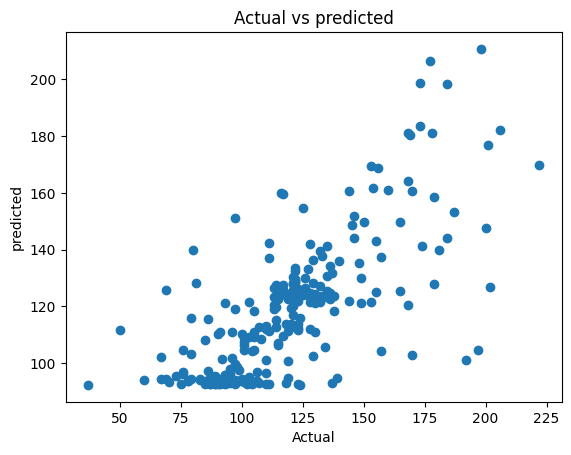

In [50]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test5, np.squeeze(model8.predict(X_test5)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test5, np.squeeze(model8.predict(X_test5)) )
mae= mean_absolute_error(Y_test5, np.squeeze(model8.predict(X_test5)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test5, np.squeeze(model8.predict(X_test5)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [51]:
prediction9 =np.squeeze(model8.predict([[80,2,2,prediction8]]))
print("Prediction: {}".format(prediction9))

y_prd=np.squeeze(np.squeeze(model8.predict(X_test5)) )
predic_dif=pd.DataFrame({'Actual':Y_test5,'predict':y_prd,"differences":Y_test5  -y_prd})
predic_dif[0:15]

1/1 [==============================] - 1s 1s/step
Prediction: 121.6751708984375
8/8 [==============================] - 0s 6ms/step


,Actual,predict,differences
2116,107,93.096695,13.903305
700,121,128.171967,-7.171967
215,187,153.202408,33.797592
1652,92,94.155411,-2.155411
107,146,151.774384,-5.774384
40,160,161.151398,-1.151398
1543,179,127.780441,51.219559
1703,92,93.083969,-1.083969
850,128,123.466583,4.533417
2630,87,92.572861,-5.572861


## keras tuner with dense and keras tuner with RNN

In [52]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [53]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train,Y_train ,epochs=100,validation_data=(X_test,Y_test))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model9 = tuner.hypermodel.build(best_hps)

model9.fit(X_train, Y_train, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
43/43 [==============================] - 2s 16ms/step - loss: 63.7193 - mean_absolute_error: 63.7193 - val_loss: 50.4347 - val_mean_absolute_error: 50.4347
Epoch 2/2000
43/43 [==============================] - 0s 5ms/step - loss: 39.9298 - mean_absolute_error: 39.9298 - val_loss: 38.3933 - val_mean_absolute_error: 38.3933
Epoch 3/2000
43/43 [==============================] - 0s 5ms/step - loss: 34.3833 - mean_absolute_error: 34.3833 - val_loss: 33.6700 - val_mean_absolute_error: 33.6700
Epoch 4/2000
43/43 [==============================] - 0s 6ms/step - loss: 33.7207 - mean_absolute_error: 33.7207 - val_loss: 30.8880 - val_mean_absolute_error: 30.8880
Epoch 5/2000
43/43 [==============================] - 0s 6ms/step - loss: 32.6112 - mean_absolute_error: 32.6112 - val_loss: 29.9832 - val_mean_absol

43/43 [==============================] - 0s 6ms/step - loss: 17.2601 - mean_absolute_error: 17.2601 - val_loss: 17.3953 - val_mean_absolute_error: 17.3953
Epoch 49/2000
43/43 [==============================] - 0s 6ms/step - loss: 18.4618 - mean_absolute_error: 18.4618 - val_loss: 21.7758 - val_mean_absolute_error: 21.7758
Epoch 50/2000
43/43 [==============================] - 0s 6ms/step - loss: 17.8254 - mean_absolute_error: 17.8254 - val_loss: 16.3932 - val_mean_absolute_error: 16.3932
Epoch 51/2000
43/43 [==============================] - 0s 6ms/step - loss: 18.1483 - mean_absolute_error: 18.1483 - val_loss: 16.9084 - val_mean_absolute_error: 16.9084
Epoch 52/2000
43/43 [==============================] - 0s 6ms/step - loss: 17.7999 - mean_absolute_error: 17.7999 - val_loss: 16.5651 - val_mean_absolute_error: 16.5651
Epoch 53/2000
43/43 [==============================] - 0s 5ms/step - loss: 17.6306 - mean_absolute_error: 17.6306 - val_loss: 16.3537 - val_mean_absolute_error: 16.3537


43/43 [==============================] - 0s 7ms/step - loss: 17.1472 - mean_absolute_error: 17.1472 - val_loss: 17.3975 - val_mean_absolute_error: 17.3975
Epoch 97/2000
43/43 [==============================] - 0s 6ms/step - loss: 17.1715 - mean_absolute_error: 17.1715 - val_loss: 15.5011 - val_mean_absolute_error: 15.5011
Epoch 98/2000
43/43 [==============================] - 0s 5ms/step - loss: 19.2088 - mean_absolute_error: 19.2088 - val_loss: 20.8075 - val_mean_absolute_error: 20.8075
Epoch 99/2000
43/43 [==============================] - 0s 5ms/step - loss: 18.1918 - mean_absolute_error: 18.1918 - val_loss: 16.2750 - val_mean_absolute_error: 16.2750
Epoch 100/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.7890 - mean_absolute_error: 16.7890 - val_loss: 16.1326 - val_mean_absolute_error: 16.1326
Epoch 101/2000
43/43 [==============================] - 0s 4ms/step - loss: 16.8260 - mean_absolute_error: 16.8260 - val_loss: 15.7693 - val_mean_absolute_error: 15.769

43/43 [==============================] - 0s 5ms/step - loss: 16.6407 - mean_absolute_error: 16.6407 - val_loss: 18.1917 - val_mean_absolute_error: 18.1917
Epoch 145/2000
43/43 [==============================] - 0s 5ms/step - loss: 17.1845 - mean_absolute_error: 17.1845 - val_loss: 15.1811 - val_mean_absolute_error: 15.1811
Epoch 146/2000
43/43 [==============================] - 0s 5ms/step - loss: 17.9167 - mean_absolute_error: 17.9167 - val_loss: 16.8116 - val_mean_absolute_error: 16.8116
Epoch 147/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.7941 - mean_absolute_error: 16.7941 - val_loss: 15.9948 - val_mean_absolute_error: 15.9948
Epoch 148/2000
43/43 [==============================] - 0s 6ms/step - loss: 16.3562 - mean_absolute_error: 16.3562 - val_loss: 15.5900 - val_mean_absolute_error: 15.5900
Epoch 149/2000
43/43 [==============================] - 0s 6ms/step - loss: 17.1040 - mean_absolute_error: 17.1040 - val_loss: 16.8505 - val_mean_absolute_error: 16.

43/43 [==============================] - 0s 5ms/step - loss: 15.6334 - mean_absolute_error: 15.6334 - val_loss: 14.8728 - val_mean_absolute_error: 14.8728
Epoch 193/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.2538 - mean_absolute_error: 16.2538 - val_loss: 14.7606 - val_mean_absolute_error: 14.7606
Epoch 194/2000
43/43 [==============================] - 0s 4ms/step - loss: 16.6900 - mean_absolute_error: 16.6900 - val_loss: 16.7945 - val_mean_absolute_error: 16.7945
Epoch 195/2000
43/43 [==============================] - 0s 4ms/step - loss: 17.3053 - mean_absolute_error: 17.3053 - val_loss: 15.4795 - val_mean_absolute_error: 15.4795
Epoch 196/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.5817 - mean_absolute_error: 16.5817 - val_loss: 15.7153 - val_mean_absolute_error: 15.7153
Epoch 197/2000
43/43 [==============================] - 0s 5ms/step - loss: 17.1281 - mean_absolute_error: 17.1281 - val_loss: 15.7046 - val_mean_absolute_error: 15.

43/43 [==============================] - 0s 4ms/step - loss: 16.0600 - mean_absolute_error: 16.0600 - val_loss: 14.9670 - val_mean_absolute_error: 14.9670
Epoch 241/2000
43/43 [==============================] - 0s 4ms/step - loss: 16.6248 - mean_absolute_error: 16.6248 - val_loss: 16.6468 - val_mean_absolute_error: 16.6468
Epoch 242/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.4884 - mean_absolute_error: 16.4884 - val_loss: 16.6729 - val_mean_absolute_error: 16.6729
Epoch 243/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.5806 - mean_absolute_error: 16.5806 - val_loss: 15.2551 - val_mean_absolute_error: 15.2551
Epoch 244/2000
43/43 [==============================] - 0s 4ms/step - loss: 16.5271 - mean_absolute_error: 16.5271 - val_loss: 14.9798 - val_mean_absolute_error: 14.9798
Epoch 245/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.6819 - mean_absolute_error: 15.6819 - val_loss: 14.6276 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.8657 - mean_absolute_error: 15.8657 - val_loss: 14.9480 - val_mean_absolute_error: 14.9480
Epoch 289/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.5673 - mean_absolute_error: 15.5673 - val_loss: 15.5781 - val_mean_absolute_error: 15.5781
Epoch 290/2000
43/43 [==============================] - 0s 4ms/step - loss: 16.5343 - mean_absolute_error: 16.5343 - val_loss: 15.6622 - val_mean_absolute_error: 15.6622
Epoch 291/2000
43/43 [==============================] - 0s 4ms/step - loss: 16.4641 - mean_absolute_error: 16.4641 - val_loss: 15.0147 - val_mean_absolute_error: 15.0147
Epoch 292/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.8409 - mean_absolute_error: 15.8409 - val_loss: 15.1523 - val_mean_absolute_error: 15.1523
Epoch 293/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.8238 - mean_absolute_error: 15.8238 - val_loss: 15.0881 - val_mean_absolute_error: 15.

43/43 [==============================] - 0s 5ms/step - loss: 15.9468 - mean_absolute_error: 15.9468 - val_loss: 14.5506 - val_mean_absolute_error: 14.5506
Epoch 337/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.6702 - mean_absolute_error: 15.6702 - val_loss: 14.9215 - val_mean_absolute_error: 14.9215
Epoch 338/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.9576 - mean_absolute_error: 15.9576 - val_loss: 15.6147 - val_mean_absolute_error: 15.6147
Epoch 339/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.8761 - mean_absolute_error: 15.8761 - val_loss: 14.8583 - val_mean_absolute_error: 14.8583
Epoch 340/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.4800 - mean_absolute_error: 15.4800 - val_loss: 14.6085 - val_mean_absolute_error: 14.6085
Epoch 341/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.4729 - mean_absolute_error: 15.4729 - val_loss: 15.2263 - val_mean_absolute_error: 15.

43/43 [==============================] - 0s 5ms/step - loss: 16.2791 - mean_absolute_error: 16.2791 - val_loss: 14.4310 - val_mean_absolute_error: 14.4310
Epoch 385/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.4690 - mean_absolute_error: 15.4690 - val_loss: 14.6798 - val_mean_absolute_error: 14.6798
Epoch 386/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.6142 - mean_absolute_error: 15.6142 - val_loss: 18.2852 - val_mean_absolute_error: 18.2852
Epoch 387/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.9359 - mean_absolute_error: 15.9359 - val_loss: 14.9756 - val_mean_absolute_error: 14.9756
Epoch 388/2000
43/43 [==============================] - 0s 7ms/step - loss: 15.6515 - mean_absolute_error: 15.6515 - val_loss: 15.2203 - val_mean_absolute_error: 15.2203
Epoch 389/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.2790 - mean_absolute_error: 16.2790 - val_loss: 14.3078 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.7028 - mean_absolute_error: 15.7028 - val_loss: 17.1399 - val_mean_absolute_error: 17.1399
Epoch 433/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.7504 - mean_absolute_error: 15.7504 - val_loss: 15.8612 - val_mean_absolute_error: 15.8612
Epoch 434/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.5977 - mean_absolute_error: 15.5977 - val_loss: 15.4011 - val_mean_absolute_error: 15.4011
Epoch 435/2000
43/43 [==============================] - 0s 7ms/step - loss: 15.7142 - mean_absolute_error: 15.7142 - val_loss: 14.9907 - val_mean_absolute_error: 14.9907
Epoch 436/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.3932 - mean_absolute_error: 15.3932 - val_loss: 15.7724 - val_mean_absolute_error: 15.7724
Epoch 437/2000
43/43 [==============================] - 0s 6ms/step - loss: 16.0229 - mean_absolute_error: 16.0229 - val_loss: 14.4456 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 16.1978 - mean_absolute_error: 16.1978 - val_loss: 15.5774 - val_mean_absolute_error: 15.5774
Epoch 481/2000
43/43 [==============================] - 0s 4ms/step - loss: 16.2087 - mean_absolute_error: 16.2087 - val_loss: 14.4961 - val_mean_absolute_error: 14.4961
Epoch 482/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2196 - mean_absolute_error: 15.2196 - val_loss: 15.2818 - val_mean_absolute_error: 15.2818
Epoch 483/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.2245 - mean_absolute_error: 16.2245 - val_loss: 14.8903 - val_mean_absolute_error: 14.8903
Epoch 484/2000
43/43 [==============================] - 0s 5ms/step - loss: 16.1248 - mean_absolute_error: 16.1248 - val_loss: 14.2860 - val_mean_absolute_error: 14.2860
Epoch 485/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5332 - mean_absolute_error: 15.5332 - val_loss: 14.8986 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.4009 - mean_absolute_error: 15.4009 - val_loss: 14.6681 - val_mean_absolute_error: 14.6681
Epoch 529/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3883 - mean_absolute_error: 15.3883 - val_loss: 14.6089 - val_mean_absolute_error: 14.6089
Epoch 530/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3175 - mean_absolute_error: 15.3175 - val_loss: 14.9297 - val_mean_absolute_error: 14.9297
Epoch 531/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.6874 - mean_absolute_error: 15.6874 - val_loss: 16.1562 - val_mean_absolute_error: 16.1562
Epoch 532/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.6113 - mean_absolute_error: 15.6113 - val_loss: 15.7333 - val_mean_absolute_error: 15.7333
Epoch 533/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3753 - mean_absolute_error: 15.3753 - val_loss: 14.8302 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.4128 - mean_absolute_error: 15.4128 - val_loss: 15.0343 - val_mean_absolute_error: 15.0343
Epoch 577/2000
43/43 [==============================] - 0s 6ms/step - loss: 16.4918 - mean_absolute_error: 16.4918 - val_loss: 15.4036 - val_mean_absolute_error: 15.4036
Epoch 578/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.6479 - mean_absolute_error: 15.6479 - val_loss: 14.8284 - val_mean_absolute_error: 14.8284
Epoch 579/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.9647 - mean_absolute_error: 15.9647 - val_loss: 14.3181 - val_mean_absolute_error: 14.3181
Epoch 580/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5730 - mean_absolute_error: 15.5730 - val_loss: 15.0357 - val_mean_absolute_error: 15.0357
Epoch 581/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5402 - mean_absolute_error: 15.5402 - val_loss: 14.8389 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.4569 - mean_absolute_error: 15.4569 - val_loss: 14.6475 - val_mean_absolute_error: 14.6475
Epoch 625/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5238 - mean_absolute_error: 15.5238 - val_loss: 14.5421 - val_mean_absolute_error: 14.5421
Epoch 626/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2223 - mean_absolute_error: 15.2223 - val_loss: 14.4648 - val_mean_absolute_error: 14.4648
Epoch 627/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2224 - mean_absolute_error: 15.2224 - val_loss: 14.7148 - val_mean_absolute_error: 14.7148
Epoch 628/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.6677 - mean_absolute_error: 15.6677 - val_loss: 14.3027 - val_mean_absolute_error: 14.3027
Epoch 629/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1247 - mean_absolute_error: 15.1247 - val_loss: 14.4759 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.6439 - mean_absolute_error: 15.6439 - val_loss: 14.5164 - val_mean_absolute_error: 14.5164
Epoch 673/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1917 - mean_absolute_error: 15.1917 - val_loss: 14.0195 - val_mean_absolute_error: 14.0195
Epoch 674/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1828 - mean_absolute_error: 15.1828 - val_loss: 15.4100 - val_mean_absolute_error: 15.4100
Epoch 675/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2266 - mean_absolute_error: 15.2266 - val_loss: 15.7459 - val_mean_absolute_error: 15.7459
Epoch 676/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5138 - mean_absolute_error: 15.5138 - val_loss: 14.3591 - val_mean_absolute_error: 14.3591
Epoch 677/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3041 - mean_absolute_error: 15.3041 - val_loss: 14.9211 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 6ms/step - loss: 15.3217 - mean_absolute_error: 15.3217 - val_loss: 15.2825 - val_mean_absolute_error: 15.2825
Epoch 721/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5966 - mean_absolute_error: 15.5966 - val_loss: 14.3093 - val_mean_absolute_error: 14.3093
Epoch 722/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0603 - mean_absolute_error: 15.0603 - val_loss: 14.5163 - val_mean_absolute_error: 14.5163
Epoch 723/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1928 - mean_absolute_error: 15.1928 - val_loss: 14.2690 - val_mean_absolute_error: 14.2690
Epoch 724/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5702 - mean_absolute_error: 15.5702 - val_loss: 14.1997 - val_mean_absolute_error: 14.1997
Epoch 725/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.4775 - mean_absolute_error: 15.4775 - val_loss: 14.5621 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 6ms/step - loss: 15.6647 - mean_absolute_error: 15.6647 - val_loss: 14.9484 - val_mean_absolute_error: 14.9484
Epoch 769/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3223 - mean_absolute_error: 15.3223 - val_loss: 14.2878 - val_mean_absolute_error: 14.2878
Epoch 770/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9656 - mean_absolute_error: 14.9656 - val_loss: 14.8561 - val_mean_absolute_error: 14.8561
Epoch 771/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.2525 - mean_absolute_error: 15.2525 - val_loss: 14.3687 - val_mean_absolute_error: 14.3687
Epoch 772/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0929 - mean_absolute_error: 15.0929 - val_loss: 14.4054 - val_mean_absolute_error: 14.4054
Epoch 773/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2047 - mean_absolute_error: 15.2047 - val_loss: 14.5846 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.9981 - mean_absolute_error: 15.9981 - val_loss: 16.5476 - val_mean_absolute_error: 16.5476
Epoch 817/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.6754 - mean_absolute_error: 15.6754 - val_loss: 15.8224 - val_mean_absolute_error: 15.8224
Epoch 818/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.5714 - mean_absolute_error: 15.5714 - val_loss: 14.4116 - val_mean_absolute_error: 14.4116
Epoch 819/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9905 - mean_absolute_error: 14.9905 - val_loss: 14.5411 - val_mean_absolute_error: 14.5411
Epoch 820/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.5820 - mean_absolute_error: 15.5820 - val_loss: 14.3813 - val_mean_absolute_error: 14.3813
Epoch 821/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.4521 - mean_absolute_error: 15.4521 - val_loss: 14.3513 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 6ms/step - loss: 15.1255 - mean_absolute_error: 15.1255 - val_loss: 15.0972 - val_mean_absolute_error: 15.0972
Epoch 865/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.8344 - mean_absolute_error: 15.8344 - val_loss: 14.1795 - val_mean_absolute_error: 14.1795
Epoch 866/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0587 - mean_absolute_error: 15.0587 - val_loss: 14.3409 - val_mean_absolute_error: 14.3409
Epoch 867/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1796 - mean_absolute_error: 15.1796 - val_loss: 14.4710 - val_mean_absolute_error: 14.4710
Epoch 868/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1022 - mean_absolute_error: 15.1022 - val_loss: 14.4849 - val_mean_absolute_error: 14.4849
Epoch 869/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2814 - mean_absolute_error: 15.2814 - val_loss: 14.2584 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 6ms/step - loss: 15.2548 - mean_absolute_error: 15.2548 - val_loss: 14.7237 - val_mean_absolute_error: 14.7237
Epoch 913/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2717 - mean_absolute_error: 15.2717 - val_loss: 15.3551 - val_mean_absolute_error: 15.3551
Epoch 914/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5890 - mean_absolute_error: 15.5890 - val_loss: 14.3608 - val_mean_absolute_error: 14.3608
Epoch 915/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5222 - mean_absolute_error: 15.5222 - val_loss: 14.5970 - val_mean_absolute_error: 14.5970
Epoch 916/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2895 - mean_absolute_error: 15.2895 - val_loss: 14.7999 - val_mean_absolute_error: 14.7999
Epoch 917/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.6725 - mean_absolute_error: 15.6725 - val_loss: 14.3115 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.1683 - mean_absolute_error: 15.1683 - val_loss: 14.2573 - val_mean_absolute_error: 14.2573
Epoch 961/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2253 - mean_absolute_error: 15.2253 - val_loss: 14.8400 - val_mean_absolute_error: 14.8400
Epoch 962/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5319 - mean_absolute_error: 15.5319 - val_loss: 14.5101 - val_mean_absolute_error: 14.5101
Epoch 963/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2428 - mean_absolute_error: 15.2428 - val_loss: 14.8141 - val_mean_absolute_error: 14.8141
Epoch 964/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1006 - mean_absolute_error: 15.1006 - val_loss: 14.0833 - val_mean_absolute_error: 14.0833
Epoch 965/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0926 - mean_absolute_error: 15.0926 - val_loss: 14.2273 - val_mean_absolute_error: 14.

43/43 [==============================] - 0s 5ms/step - loss: 15.3278 - mean_absolute_error: 15.3278 - val_loss: 14.2011 - val_mean_absolute_error: 14.2011
Epoch 1009/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.1440 - mean_absolute_error: 15.1440 - val_loss: 15.6108 - val_mean_absolute_error: 15.6108
Epoch 1010/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.1013 - mean_absolute_error: 15.1013 - val_loss: 14.6323 - val_mean_absolute_error: 14.6323
Epoch 1011/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9855 - mean_absolute_error: 14.9855 - val_loss: 15.0977 - val_mean_absolute_error: 15.0977
Epoch 1012/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3908 - mean_absolute_error: 15.3908 - val_loss: 14.6270 - val_mean_absolute_error: 14.6270
Epoch 1013/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.4725 - mean_absolute_error: 15.4725 - val_loss: 14.8336 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.3190 - mean_absolute_error: 15.3190 - val_loss: 14.3090 - val_mean_absolute_error: 14.3090
Epoch 1057/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3014 - mean_absolute_error: 15.3014 - val_loss: 14.7395 - val_mean_absolute_error: 14.7395
Epoch 1058/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2851 - mean_absolute_error: 15.2851 - val_loss: 14.9033 - val_mean_absolute_error: 14.9033
Epoch 1059/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0156 - mean_absolute_error: 15.0156 - val_loss: 14.8093 - val_mean_absolute_error: 14.8093
Epoch 1060/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2708 - mean_absolute_error: 15.2708 - val_loss: 14.7732 - val_mean_absolute_error: 14.7732
Epoch 1061/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2747 - mean_absolute_error: 15.2747 - val_loss: 15.4169 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.0389 - mean_absolute_error: 15.0389 - val_loss: 14.5570 - val_mean_absolute_error: 14.5570
Epoch 1105/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1629 - mean_absolute_error: 15.1629 - val_loss: 14.4187 - val_mean_absolute_error: 14.4187
Epoch 1106/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9571 - mean_absolute_error: 14.9571 - val_loss: 14.5169 - val_mean_absolute_error: 14.5169
Epoch 1107/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.4464 - mean_absolute_error: 15.4464 - val_loss: 14.9680 - val_mean_absolute_error: 14.9680
Epoch 1108/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0352 - mean_absolute_error: 15.0352 - val_loss: 14.4457 - val_mean_absolute_error: 14.4457
Epoch 1109/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9043 - mean_absolute_error: 14.9043 - val_loss: 14.9767 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.1524 - mean_absolute_error: 15.1524 - val_loss: 14.3644 - val_mean_absolute_error: 14.3644
Epoch 1153/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.1515 - mean_absolute_error: 15.1515 - val_loss: 14.3004 - val_mean_absolute_error: 14.3004
Epoch 1154/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2183 - mean_absolute_error: 15.2183 - val_loss: 14.9432 - val_mean_absolute_error: 14.9432
Epoch 1155/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9580 - mean_absolute_error: 14.9580 - val_loss: 14.7106 - val_mean_absolute_error: 14.7106
Epoch 1156/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.4398 - mean_absolute_error: 15.4398 - val_loss: 14.9444 - val_mean_absolute_error: 14.9444
Epoch 1157/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.6638 - mean_absolute_error: 15.6638 - val_loss: 14.5339 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.0879 - mean_absolute_error: 15.0879 - val_loss: 15.4479 - val_mean_absolute_error: 15.4479
Epoch 1201/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1416 - mean_absolute_error: 15.1416 - val_loss: 14.7342 - val_mean_absolute_error: 14.7342
Epoch 1202/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.0925 - mean_absolute_error: 15.0925 - val_loss: 15.0609 - val_mean_absolute_error: 15.0609
Epoch 1203/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1761 - mean_absolute_error: 15.1761 - val_loss: 15.5562 - val_mean_absolute_error: 15.5562
Epoch 1204/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9741 - mean_absolute_error: 14.9741 - val_loss: 14.8956 - val_mean_absolute_error: 14.8956
Epoch 1205/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.4639 - mean_absolute_error: 15.4639 - val_loss: 15.6640 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.0730 - mean_absolute_error: 15.0730 - val_loss: 14.7564 - val_mean_absolute_error: 14.7564
Epoch 1249/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0461 - mean_absolute_error: 15.0461 - val_loss: 14.2371 - val_mean_absolute_error: 14.2371
Epoch 1250/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.0083 - mean_absolute_error: 15.0083 - val_loss: 14.3798 - val_mean_absolute_error: 14.3798
Epoch 1251/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.0235 - mean_absolute_error: 15.0235 - val_loss: 14.3881 - val_mean_absolute_error: 14.3881
Epoch 1252/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.0253 - mean_absolute_error: 15.0253 - val_loss: 14.5398 - val_mean_absolute_error: 14.5398
Epoch 1253/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8560 - mean_absolute_error: 14.8560 - val_loss: 14.8854 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 14.8581 - mean_absolute_error: 14.8581 - val_loss: 14.7028 - val_mean_absolute_error: 14.7028
Epoch 1297/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2899 - mean_absolute_error: 15.2899 - val_loss: 14.2841 - val_mean_absolute_error: 14.2841
Epoch 1298/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2669 - mean_absolute_error: 15.2669 - val_loss: 14.4073 - val_mean_absolute_error: 14.4073
Epoch 1299/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.4162 - mean_absolute_error: 15.4162 - val_loss: 14.4303 - val_mean_absolute_error: 14.4303
Epoch 1300/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8782 - mean_absolute_error: 14.8782 - val_loss: 14.5838 - val_mean_absolute_error: 14.5838
Epoch 1301/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.0912 - mean_absolute_error: 15.0912 - val_loss: 15.4142 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 14.9217 - mean_absolute_error: 14.9217 - val_loss: 14.7948 - val_mean_absolute_error: 14.7948
Epoch 1345/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1025 - mean_absolute_error: 15.1025 - val_loss: 14.4119 - val_mean_absolute_error: 14.4119
Epoch 1346/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0395 - mean_absolute_error: 15.0395 - val_loss: 14.3786 - val_mean_absolute_error: 14.3786
Epoch 1347/2000
43/43 [==============================] - 0s 4ms/step - loss: 14.8117 - mean_absolute_error: 14.8117 - val_loss: 14.6857 - val_mean_absolute_error: 14.6857
Epoch 1348/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1075 - mean_absolute_error: 15.1075 - val_loss: 14.8454 - val_mean_absolute_error: 14.8454
Epoch 1349/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2030 - mean_absolute_error: 15.2030 - val_loss: 14.7837 - val_mean_absolute_error

43/43 [==============================] - 0s 4ms/step - loss: 15.4117 - mean_absolute_error: 15.4117 - val_loss: 14.5981 - val_mean_absolute_error: 14.5981
Epoch 1393/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8989 - mean_absolute_error: 14.8989 - val_loss: 14.3593 - val_mean_absolute_error: 14.3593
Epoch 1394/2000
43/43 [==============================] - 0s 4ms/step - loss: 14.7294 - mean_absolute_error: 14.7294 - val_loss: 14.6490 - val_mean_absolute_error: 14.6490
Epoch 1395/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.3290 - mean_absolute_error: 15.3290 - val_loss: 15.4665 - val_mean_absolute_error: 15.4665
Epoch 1396/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0266 - mean_absolute_error: 15.0266 - val_loss: 14.7124 - val_mean_absolute_error: 14.7124
Epoch 1397/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.0194 - mean_absolute_error: 15.0194 - val_loss: 14.1521 - val_mean_absolute_error

43/43 [==============================] - 0s 4ms/step - loss: 15.1127 - mean_absolute_error: 15.1127 - val_loss: 14.0955 - val_mean_absolute_error: 14.0955
Epoch 1441/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8609 - mean_absolute_error: 14.8609 - val_loss: 15.9407 - val_mean_absolute_error: 15.9407
Epoch 1442/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1075 - mean_absolute_error: 15.1075 - val_loss: 14.5220 - val_mean_absolute_error: 14.5220
Epoch 1443/2000
43/43 [==============================] - 0s 4ms/step - loss: 14.9987 - mean_absolute_error: 14.9987 - val_loss: 14.5342 - val_mean_absolute_error: 14.5342
Epoch 1444/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9404 - mean_absolute_error: 14.9404 - val_loss: 14.6374 - val_mean_absolute_error: 14.6374
Epoch 1445/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.4124 - mean_absolute_error: 15.4124 - val_loss: 16.9601 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.0035 - mean_absolute_error: 15.0035 - val_loss: 14.2048 - val_mean_absolute_error: 14.2048
Epoch 1489/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.7180 - mean_absolute_error: 14.7180 - val_loss: 14.5066 - val_mean_absolute_error: 14.5066
Epoch 1490/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1028 - mean_absolute_error: 15.1028 - val_loss: 14.3630 - val_mean_absolute_error: 14.3630
Epoch 1491/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1708 - mean_absolute_error: 15.1708 - val_loss: 14.8266 - val_mean_absolute_error: 14.8266
Epoch 1492/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9610 - mean_absolute_error: 14.9610 - val_loss: 14.7551 - val_mean_absolute_error: 14.7551
Epoch 1493/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.4430 - mean_absolute_error: 15.4430 - val_loss: 14.2966 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.1812 - mean_absolute_error: 15.1812 - val_loss: 14.6666 - val_mean_absolute_error: 14.6666
Epoch 1537/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9254 - mean_absolute_error: 14.9254 - val_loss: 14.9681 - val_mean_absolute_error: 14.9681
Epoch 1538/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8351 - mean_absolute_error: 14.8351 - val_loss: 14.7720 - val_mean_absolute_error: 14.7720
Epoch 1539/2000
43/43 [==============================] - 0s 4ms/step - loss: 15.4793 - mean_absolute_error: 15.4793 - val_loss: 14.2980 - val_mean_absolute_error: 14.2980
Epoch 1540/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0093 - mean_absolute_error: 15.0093 - val_loss: 14.3624 - val_mean_absolute_error: 14.3624
Epoch 1541/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.3289 - mean_absolute_error: 15.3289 - val_loss: 14.4898 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.0062 - mean_absolute_error: 15.0062 - val_loss: 14.5830 - val_mean_absolute_error: 14.5830
Epoch 1585/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.0549 - mean_absolute_error: 15.0549 - val_loss: 14.3574 - val_mean_absolute_error: 14.3574
Epoch 1586/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0157 - mean_absolute_error: 15.0157 - val_loss: 16.1291 - val_mean_absolute_error: 16.1291
Epoch 1587/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.6318 - mean_absolute_error: 15.6318 - val_loss: 14.4851 - val_mean_absolute_error: 14.4851
Epoch 1588/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.7450 - mean_absolute_error: 14.7450 - val_loss: 14.5198 - val_mean_absolute_error: 14.5198
Epoch 1589/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3655 - mean_absolute_error: 15.3655 - val_loss: 14.5676 - val_mean_absolute_error

43/43 [==============================] - 0s 6ms/step - loss: 14.7010 - mean_absolute_error: 14.7010 - val_loss: 14.7010 - val_mean_absolute_error: 14.7010
Epoch 1633/2000
43/43 [==============================] - 0s 4ms/step - loss: 14.8802 - mean_absolute_error: 14.8802 - val_loss: 14.7270 - val_mean_absolute_error: 14.7270
Epoch 1634/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9115 - mean_absolute_error: 14.9115 - val_loss: 15.0492 - val_mean_absolute_error: 15.0492
Epoch 1635/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0142 - mean_absolute_error: 15.0142 - val_loss: 14.5579 - val_mean_absolute_error: 14.5579
Epoch 1636/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.6316 - mean_absolute_error: 14.6316 - val_loss: 15.0811 - val_mean_absolute_error: 15.0811
Epoch 1637/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.5505 - mean_absolute_error: 15.5505 - val_loss: 15.0275 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.4866 - mean_absolute_error: 15.4866 - val_loss: 14.7655 - val_mean_absolute_error: 14.7655
Epoch 1681/2000
43/43 [==============================] - 0s 6ms/step - loss: 14.8709 - mean_absolute_error: 14.8709 - val_loss: 14.4116 - val_mean_absolute_error: 14.4116
Epoch 1682/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0830 - mean_absolute_error: 15.0830 - val_loss: 14.6057 - val_mean_absolute_error: 14.6057
Epoch 1683/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8492 - mean_absolute_error: 14.8492 - val_loss: 16.0031 - val_mean_absolute_error: 16.0031
Epoch 1684/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8754 - mean_absolute_error: 14.8754 - val_loss: 14.4836 - val_mean_absolute_error: 14.4836
Epoch 1685/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9654 - mean_absolute_error: 14.9654 - val_loss: 14.2511 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 14.7621 - mean_absolute_error: 14.7621 - val_loss: 14.9445 - val_mean_absolute_error: 14.9445
Epoch 1729/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.5771 - mean_absolute_error: 14.5771 - val_loss: 14.7356 - val_mean_absolute_error: 14.7356
Epoch 1730/2000
43/43 [==============================] - 0s 6ms/step - loss: 14.8874 - mean_absolute_error: 14.8874 - val_loss: 14.5894 - val_mean_absolute_error: 14.5894
Epoch 1731/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1802 - mean_absolute_error: 15.1802 - val_loss: 15.3588 - val_mean_absolute_error: 15.3588
Epoch 1732/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8283 - mean_absolute_error: 14.8283 - val_loss: 14.6492 - val_mean_absolute_error: 14.6492
Epoch 1733/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.3554 - mean_absolute_error: 15.3554 - val_loss: 14.8802 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.6313 - mean_absolute_error: 15.6313 - val_loss: 15.0455 - val_mean_absolute_error: 15.0455
Epoch 1777/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.7043 - mean_absolute_error: 14.7043 - val_loss: 14.3772 - val_mean_absolute_error: 14.3772
Epoch 1778/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.1626 - mean_absolute_error: 15.1626 - val_loss: 14.4652 - val_mean_absolute_error: 14.4652
Epoch 1779/2000
43/43 [==============================] - 0s 6ms/step - loss: 14.9279 - mean_absolute_error: 14.9279 - val_loss: 14.5361 - val_mean_absolute_error: 14.5361
Epoch 1780/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.7104 - mean_absolute_error: 14.7104 - val_loss: 14.3864 - val_mean_absolute_error: 14.3864
Epoch 1781/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.6986 - mean_absolute_error: 14.6986 - val_loss: 14.5677 - val_mean_absolute_error

43/43 [==============================] - 0s 6ms/step - loss: 14.8381 - mean_absolute_error: 14.8381 - val_loss: 16.5223 - val_mean_absolute_error: 16.5223
Epoch 1825/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2914 - mean_absolute_error: 15.2914 - val_loss: 15.0963 - val_mean_absolute_error: 15.0963
Epoch 1826/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8268 - mean_absolute_error: 14.8268 - val_loss: 14.8750 - val_mean_absolute_error: 14.8750
Epoch 1827/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.2419 - mean_absolute_error: 15.2419 - val_loss: 14.9676 - val_mean_absolute_error: 14.9676
Epoch 1828/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.7281 - mean_absolute_error: 14.7281 - val_loss: 14.6386 - val_mean_absolute_error: 14.6386
Epoch 1829/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.6291 - mean_absolute_error: 14.6291 - val_loss: 14.4762 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 15.0378 - mean_absolute_error: 15.0378 - val_loss: 14.6059 - val_mean_absolute_error: 14.6059
Epoch 1873/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8140 - mean_absolute_error: 14.8140 - val_loss: 14.4751 - val_mean_absolute_error: 14.4751
Epoch 1874/2000
43/43 [==============================] - 0s 6ms/step - loss: 14.7241 - mean_absolute_error: 14.7241 - val_loss: 14.6697 - val_mean_absolute_error: 14.6697
Epoch 1875/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.0594 - mean_absolute_error: 15.0594 - val_loss: 15.1380 - val_mean_absolute_error: 15.1380
Epoch 1876/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.4657 - mean_absolute_error: 15.4657 - val_loss: 14.3819 - val_mean_absolute_error: 14.3819
Epoch 1877/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.1065 - mean_absolute_error: 15.1065 - val_loss: 14.4085 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 14.8981 - mean_absolute_error: 14.8981 - val_loss: 14.4171 - val_mean_absolute_error: 14.4171
Epoch 1921/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8260 - mean_absolute_error: 14.8260 - val_loss: 14.7794 - val_mean_absolute_error: 14.7794
Epoch 1922/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9232 - mean_absolute_error: 14.9232 - val_loss: 14.9149 - val_mean_absolute_error: 14.9149
Epoch 1923/2000
43/43 [==============================] - 0s 6ms/step - loss: 14.7709 - mean_absolute_error: 14.7709 - val_loss: 14.4486 - val_mean_absolute_error: 14.4486
Epoch 1924/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.8851 - mean_absolute_error: 14.8851 - val_loss: 14.7369 - val_mean_absolute_error: 14.7369
Epoch 1925/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.7562 - mean_absolute_error: 14.7562 - val_loss: 14.9180 - val_mean_absolute_error

43/43 [==============================] - 0s 5ms/step - loss: 14.8484 - mean_absolute_error: 14.8484 - val_loss: 14.4487 - val_mean_absolute_error: 14.4487
Epoch 1969/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.6115 - mean_absolute_error: 14.6115 - val_loss: 14.5494 - val_mean_absolute_error: 14.5494
Epoch 1970/2000
43/43 [==============================] - 0s 5ms/step - loss: 15.0420 - mean_absolute_error: 15.0420 - val_loss: 14.4354 - val_mean_absolute_error: 14.4354
Epoch 1971/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.9273 - mean_absolute_error: 14.9273 - val_loss: 14.6768 - val_mean_absolute_error: 14.6768
Epoch 1972/2000
43/43 [==============================] - 0s 5ms/step - loss: 14.7465 - mean_absolute_error: 14.7465 - val_loss: 14.3686 - val_mean_absolute_error: 14.3686
Epoch 1973/2000
43/43 [==============================] - 0s 6ms/step - loss: 15.2977 - mean_absolute_error: 15.2977 - val_loss: 14.5029 - val_mean_absolute_error

In [54]:
prediction10 = np.squeeze(model9.predict([[80,2,2]]))
print("Prediction: {}".format(prediction10))

1/1 [==============================] - 0s 343ms/step
Prediction: 108.89163208007812


In [55]:
y_prd=np.squeeze(np.squeeze(model9.predict(X_test)) )
predic_dif=pd.DataFrame({'Actual':Y_test,'predict':y_prd,"differences":Y_test-y_prd})
A=predic_dif
print(A)

26/26 [==============================] - 0s 3ms/step
      Actual     predict  differences
352      167  150.076813    16.923187
1460      95   94.708931     0.291069
1023     123  107.036095    15.963905
2178     100   88.552261    11.447739
2630      87   85.013618     1.986382
...      ...         ...          ...
305      104  186.452667   -82.452667
1242     125  117.933441     7.066559
442      173  134.982712    38.017288
1703      92   90.994812     1.005188
1489     107  112.908951    -5.908951

[826 rows x 3 columns]


In [56]:
import numpy as np
import pandas as pd
mean1= pd.DataFrame.mean (A['differences'])
data_std=pd.DataFrame.std(A['differences'])
cut_off = data_std * 3
lower, upper = mean1 - cut_off, mean1 + cut_off
for x in A['differences']:
     if x <lower or x > upper:
            print(x)
print('lower bound:',lower)
print('upper bound:',upper)

105.10951232910156
94.0648193359375
120.97903442382812
167.9041519165039
135.94656372070312
88.04786682128906
93.27731323242188
97.92826843261719
100.12139129638672
119.03125762939453
149.67972564697266
-106.9879150390625
151.51673126220703
172.33177185058594
-79.30844116210938
133.2962188720703
-79.6272964477539
120.56063842773438
-91.48396301269531
-82.45266723632812
lower bound: -78.90380245500327
upper bound: 87.9701386364961


In [57]:
A.drop(A[(A['differences'] >87)].index, inplace=True)
A.drop(A[(A['differences'] <-78)].index, inplace=True)
del A['differences']


B= pd.concat([dataset, A], axis=1, join='inner')

del B['EnergyUseAveragePerDwelling']

print(B)

from sklearn.model_selection import train_test_split
X6=B.drop('Actual',axis=1)
Y6=B['Actual']
X_train6, X_test6, Y_train6, Y_test6 =train_test_split(X6,Y6, test_size=0.3, random_state = 0)

      AverageFloorArea  Quarter  Property Type  Actual     predict
1                    0        1              2     142  207.563889
4                    0        2              1     200  227.532303
9                    0        4              2     174  139.360199
10                   0        4              3     108  106.780380
11                   0        4              4     165  102.370590
...                ...      ...            ...     ...         ...
2734               232        1              1      75   85.710922
2736               232        2              1      96   86.963150
2739               232        3              3     132   86.085060
2740               232        4              3      70   87.012466
2746               233        4              3      74   86.960236

[806 rows x 5 columns]


In [58]:
from tensorflow import keras
from keras import layers
from keras.layers import Dense,LSTM,Dropout
from kerastuner.tuners import RandomSearch
def build_model(hp):
    model2= keras.Sequential()
    for i in range(hp.Int('num_layers',2,20)):
        model2.add(layers.LSTM(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                                           input_shape=(X_train6.shape[1],1),
                              activation='relu'))
        model2.add(layers.Dense(1, activation='linear',name='Dense_1'))
        model2.compile(
              optimizer=keras.optimizers.Adam(
                 hp.Choice('learning rate', [1e-1,1e-2,1e-3,1e-4,1e-5])),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])
        return model2

In [59]:
tuner=RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=50, executions_per_trial=3,directory='project2',project_name='A2')

tuner.search(X_train6,Y_train6 ,epochs=100,validation_data=(X_test6,Y_test6))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model10 = tuner.hypermodel.build(best_hps)

model10.fit(X_train6, Y_train6, epochs=2000,batch_size=32, validation_split=0.3)

INFO:tensorflow:Reloading Oracle from existing project project2\A2\oracle.json
INFO:tensorflow:Reloading Tuner from project2\A2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
13/13 [==============================] - 4s 69ms/step - loss: 60.1924 - mean_absolute_error: 60.1924 - val_loss: 18.6121 - val_mean_absolute_error: 18.6121
Epoch 2/2000
13/13 [==============================] - 0s 28ms/step - loss: 21.9868 - mean_absolute_error: 21.9868 - val_loss: 17.4938 - val_mean_absolute_error: 17.4938
Epoch 3/2000
13/13 [==============================] - 0s 27ms/step - loss: 15.8969 - mean_absolute_error: 15.8969 - val_loss: 14.9367 - val_mean_absolute_error: 14.9367
Epoch 4/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.5549 - mean_absolute_error: 15.5549 - val_loss: 14.6433 - val_mean_absolute_error: 14.6433
Epoch 5/2000
13/13 [==============================] - 0s 27ms/step - loss: 15.6628 - mean_absolute_error: 15.6628 - val_loss: 14.8594 - val_mean_a

13/13 [==============================] - 0s 27ms/step - loss: 15.2037 - mean_absolute_error: 15.2037 - val_loss: 15.9914 - val_mean_absolute_error: 15.9914
Epoch 49/2000
13/13 [==============================] - 0s 27ms/step - loss: 15.1745 - mean_absolute_error: 15.1745 - val_loss: 14.3717 - val_mean_absolute_error: 14.3717
Epoch 50/2000
13/13 [==============================] - 0s 26ms/step - loss: 15.1567 - mean_absolute_error: 15.1567 - val_loss: 15.8002 - val_mean_absolute_error: 15.8002
Epoch 51/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.9991 - mean_absolute_error: 14.9991 - val_loss: 14.3431 - val_mean_absolute_error: 14.3431
Epoch 52/2000
13/13 [==============================] - 0s 25ms/step - loss: 15.0684 - mean_absolute_error: 15.0684 - val_loss: 14.1665 - val_mean_absolute_error: 14.1665
Epoch 53/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.8641 - mean_absolute_error: 14.8641 - val_loss: 14.3017 - val_mean_absolute_error: 14

13/13 [==============================] - 0s 31ms/step - loss: 14.6385 - mean_absolute_error: 14.6385 - val_loss: 14.2862 - val_mean_absolute_error: 14.2862
Epoch 97/2000
13/13 [==============================] - 0s 34ms/step - loss: 14.7992 - mean_absolute_error: 14.7992 - val_loss: 14.2951 - val_mean_absolute_error: 14.2951
Epoch 98/2000
13/13 [==============================] - 0s 34ms/step - loss: 15.0036 - mean_absolute_error: 15.0036 - val_loss: 14.4606 - val_mean_absolute_error: 14.4606
Epoch 99/2000
13/13 [==============================] - 0s 34ms/step - loss: 14.9894 - mean_absolute_error: 14.9894 - val_loss: 14.3676 - val_mean_absolute_error: 14.3676
Epoch 100/2000
13/13 [==============================] - 0s 33ms/step - loss: 15.3418 - mean_absolute_error: 15.3418 - val_loss: 14.5202 - val_mean_absolute_error: 14.5202
Epoch 101/2000
13/13 [==============================] - 0s 33ms/step - loss: 15.3786 - mean_absolute_error: 15.3786 - val_loss: 14.1643 - val_mean_absolute_error: 

13/13 [==============================] - 0s 29ms/step - loss: 15.7453 - mean_absolute_error: 15.7453 - val_loss: 16.1520 - val_mean_absolute_error: 16.1520
Epoch 145/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.4556 - mean_absolute_error: 15.4556 - val_loss: 15.5259 - val_mean_absolute_error: 15.5259
Epoch 146/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.1184 - mean_absolute_error: 15.1184 - val_loss: 14.6084 - val_mean_absolute_error: 14.6084
Epoch 147/2000
13/13 [==============================] - 0s 30ms/step - loss: 15.6361 - mean_absolute_error: 15.6361 - val_loss: 15.0325 - val_mean_absolute_error: 15.0325
Epoch 148/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.4768 - mean_absolute_error: 15.4768 - val_loss: 14.4691 - val_mean_absolute_error: 14.4691
Epoch 149/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.5598 - mean_absolute_error: 15.5598 - val_loss: 17.0863 - val_mean_absolute_erro

Epoch 192/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.6829 - mean_absolute_error: 15.6829 - val_loss: 14.3784 - val_mean_absolute_error: 14.3784
Epoch 193/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.3211 - mean_absolute_error: 15.3211 - val_loss: 14.3535 - val_mean_absolute_error: 14.3535
Epoch 194/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.6744 - mean_absolute_error: 15.6744 - val_loss: 14.9319 - val_mean_absolute_error: 14.9319
Epoch 195/2000
13/13 [==============================] - 0s 31ms/step - loss: 15.5180 - mean_absolute_error: 15.5180 - val_loss: 14.3482 - val_mean_absolute_error: 14.3482
Epoch 196/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.0303 - mean_absolute_error: 15.0303 - val_loss: 14.3119 - val_mean_absolute_error: 14.3119
Epoch 197/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.8870 - mean_absolute_error: 14.8870 - val_loss: 14.8703 - val_mea

Epoch 240/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.6231 - mean_absolute_error: 15.6231 - val_loss: 16.2263 - val_mean_absolute_error: 16.2263
Epoch 241/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.6876 - mean_absolute_error: 15.6876 - val_loss: 14.4253 - val_mean_absolute_error: 14.4253
Epoch 242/2000
13/13 [==============================] - 0s 32ms/step - loss: 15.3196 - mean_absolute_error: 15.3196 - val_loss: 14.2692 - val_mean_absolute_error: 14.2692
Epoch 243/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.5297 - mean_absolute_error: 15.5297 - val_loss: 14.8299 - val_mean_absolute_error: 14.8299
Epoch 244/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.0140 - mean_absolute_error: 15.0140 - val_loss: 14.8783 - val_mean_absolute_error: 14.8783
Epoch 245/2000
13/13 [==============================] - 0s 34ms/step - loss: 15.7300 - mean_absolute_error: 15.7300 - val_loss: 14.9883 - val_mea

Epoch 288/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.1717 - mean_absolute_error: 15.1717 - val_loss: 14.2268 - val_mean_absolute_error: 14.2268
Epoch 289/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.8764 - mean_absolute_error: 14.8764 - val_loss: 14.2726 - val_mean_absolute_error: 14.2726
Epoch 290/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.7766 - mean_absolute_error: 14.7766 - val_loss: 14.3191 - val_mean_absolute_error: 14.3191
Epoch 291/2000
13/13 [==============================] - 0s 35ms/step - loss: 14.8845 - mean_absolute_error: 14.8845 - val_loss: 14.1571 - val_mean_absolute_error: 14.1571
Epoch 292/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.6056 - mean_absolute_error: 14.6056 - val_loss: 14.1553 - val_mean_absolute_error: 14.1553
Epoch 293/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.6736 - mean_absolute_error: 14.6736 - val_loss: 15.0839 - val_mea

Epoch 336/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.8330 - mean_absolute_error: 14.8330 - val_loss: 14.8178 - val_mean_absolute_error: 14.8178
Epoch 337/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.0438 - mean_absolute_error: 15.0438 - val_loss: 14.9536 - val_mean_absolute_error: 14.9536
Epoch 338/2000
13/13 [==============================] - 0s 31ms/step - loss: 15.0661 - mean_absolute_error: 15.0661 - val_loss: 15.2628 - val_mean_absolute_error: 15.2628
Epoch 339/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.7876 - mean_absolute_error: 14.7876 - val_loss: 14.2498 - val_mean_absolute_error: 14.2498
Epoch 340/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.6172 - mean_absolute_error: 14.6172 - val_loss: 14.0108 - val_mean_absolute_error: 14.0108
Epoch 341/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.5691 - mean_absolute_error: 14.5691 - val_loss: 14.2967 - val_mea

Epoch 384/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.2025 - mean_absolute_error: 15.2025 - val_loss: 15.2262 - val_mean_absolute_error: 15.2262
Epoch 385/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.5969 - mean_absolute_error: 14.5969 - val_loss: 14.0801 - val_mean_absolute_error: 14.0801
Epoch 386/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.5328 - mean_absolute_error: 14.5328 - val_loss: 14.2113 - val_mean_absolute_error: 14.2113
Epoch 387/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.4787 - mean_absolute_error: 14.4787 - val_loss: 14.6243 - val_mean_absolute_error: 14.6243
Epoch 388/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.3966 - mean_absolute_error: 14.3966 - val_loss: 14.6218 - val_mean_absolute_error: 14.6218
Epoch 389/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.4204 - mean_absolute_error: 14.4204 - val_loss: 15.1544 - val_mea

Epoch 432/2000
13/13 [==============================] - 0s 26ms/step - loss: 14.6022 - mean_absolute_error: 14.6022 - val_loss: 14.6725 - val_mean_absolute_error: 14.6725
Epoch 433/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.9693 - mean_absolute_error: 14.9693 - val_loss: 14.4262 - val_mean_absolute_error: 14.4262
Epoch 434/2000
13/13 [==============================] - 0s 34ms/step - loss: 14.5790 - mean_absolute_error: 14.5790 - val_loss: 14.2735 - val_mean_absolute_error: 14.2735
Epoch 435/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.4937 - mean_absolute_error: 14.4937 - val_loss: 14.4120 - val_mean_absolute_error: 14.4120
Epoch 436/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.3251 - mean_absolute_error: 14.3251 - val_loss: 14.1944 - val_mean_absolute_error: 14.1944
Epoch 437/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.3543 - mean_absolute_error: 14.3543 - val_loss: 14.2558 - val_mea

Epoch 480/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.7385 - mean_absolute_error: 14.7385 - val_loss: 14.5878 - val_mean_absolute_error: 14.5878
Epoch 481/2000
13/13 [==============================] - 0s 33ms/step - loss: 15.4555 - mean_absolute_error: 15.4555 - val_loss: 14.2987 - val_mean_absolute_error: 14.2987
Epoch 482/2000
13/13 [==============================] - 0s 33ms/step - loss: 14.4621 - mean_absolute_error: 14.4621 - val_loss: 14.7163 - val_mean_absolute_error: 14.7163
Epoch 483/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.8984 - mean_absolute_error: 14.8984 - val_loss: 14.6856 - val_mean_absolute_error: 14.6856
Epoch 484/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.7433 - mean_absolute_error: 14.7433 - val_loss: 14.7173 - val_mean_absolute_error: 14.7173
Epoch 485/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.6946 - mean_absolute_error: 14.6946 - val_loss: 14.4900 - val_mea

Epoch 528/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.2426 - mean_absolute_error: 14.2426 - val_loss: 14.6847 - val_mean_absolute_error: 14.6847
Epoch 529/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.3055 - mean_absolute_error: 14.3055 - val_loss: 14.4979 - val_mean_absolute_error: 14.4979
Epoch 530/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.6151 - mean_absolute_error: 14.6151 - val_loss: 14.3477 - val_mean_absolute_error: 14.3477
Epoch 531/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.7103 - mean_absolute_error: 14.7103 - val_loss: 14.5408 - val_mean_absolute_error: 14.5408
Epoch 532/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.4976 - mean_absolute_error: 14.4976 - val_loss: 14.2445 - val_mean_absolute_error: 14.2445
Epoch 533/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.4667 - mean_absolute_error: 14.4667 - val_loss: 14.5954 - val_mea

Epoch 576/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.5797 - mean_absolute_error: 14.5797 - val_loss: 14.0047 - val_mean_absolute_error: 14.0047
Epoch 577/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.6867 - mean_absolute_error: 14.6867 - val_loss: 14.6531 - val_mean_absolute_error: 14.6531
Epoch 578/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.4640 - mean_absolute_error: 14.4640 - val_loss: 14.7305 - val_mean_absolute_error: 14.7305
Epoch 579/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.2393 - mean_absolute_error: 14.2393 - val_loss: 13.9961 - val_mean_absolute_error: 13.9961
Epoch 580/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.5311 - mean_absolute_error: 14.5311 - val_loss: 14.0667 - val_mean_absolute_error: 14.0667
Epoch 581/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.0676 - mean_absolute_error: 14.0676 - val_loss: 14.3496 - val_mea

Epoch 624/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.6092 - mean_absolute_error: 14.6092 - val_loss: 14.5395 - val_mean_absolute_error: 14.5395
Epoch 625/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.7766 - mean_absolute_error: 14.7766 - val_loss: 15.2791 - val_mean_absolute_error: 15.2791
Epoch 626/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.0762 - mean_absolute_error: 15.0762 - val_loss: 14.1482 - val_mean_absolute_error: 14.1482
Epoch 627/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.2645 - mean_absolute_error: 14.2645 - val_loss: 14.4857 - val_mean_absolute_error: 14.4857
Epoch 628/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.9441 - mean_absolute_error: 13.9441 - val_loss: 14.7790 - val_mean_absolute_error: 14.7790
Epoch 629/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.0731 - mean_absolute_error: 14.0731 - val_loss: 14.7928 - val_mea

Epoch 672/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.7420 - mean_absolute_error: 13.7420 - val_loss: 14.5207 - val_mean_absolute_error: 14.5207
Epoch 673/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7499 - mean_absolute_error: 13.7499 - val_loss: 14.7190 - val_mean_absolute_error: 14.7190
Epoch 674/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.6239 - mean_absolute_error: 13.6239 - val_loss: 14.7075 - val_mean_absolute_error: 14.7075
Epoch 675/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6872 - mean_absolute_error: 13.6872 - val_loss: 14.8530 - val_mean_absolute_error: 14.8530
Epoch 676/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7163 - mean_absolute_error: 13.7163 - val_loss: 14.6255 - val_mean_absolute_error: 14.6255
Epoch 677/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.0184 - mean_absolute_error: 14.0184 - val_loss: 14.9952 - val_mea

Epoch 720/2000
13/13 [==============================] - 0s 33ms/step - loss: 14.1221 - mean_absolute_error: 14.1221 - val_loss: 14.4361 - val_mean_absolute_error: 14.4361
Epoch 721/2000
13/13 [==============================] - 0s 28ms/step - loss: 16.5818 - mean_absolute_error: 16.5818 - val_loss: 23.2569 - val_mean_absolute_error: 23.2569
Epoch 722/2000
13/13 [==============================] - 0s 32ms/step - loss: 16.1554 - mean_absolute_error: 16.1554 - val_loss: 14.4907 - val_mean_absolute_error: 14.4907
Epoch 723/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.2883 - mean_absolute_error: 14.2883 - val_loss: 14.0666 - val_mean_absolute_error: 14.0666
Epoch 724/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.4664 - mean_absolute_error: 14.4664 - val_loss: 14.3553 - val_mean_absolute_error: 14.3553
Epoch 725/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.3760 - mean_absolute_error: 14.3760 - val_loss: 14.3908 - val_mea

Epoch 768/2000
13/13 [==============================] - 0s 27ms/step - loss: 16.5412 - mean_absolute_error: 16.5412 - val_loss: 21.2207 - val_mean_absolute_error: 21.2207
Epoch 769/2000
13/13 [==============================] - 0s 29ms/step - loss: 16.7732 - mean_absolute_error: 16.7732 - val_loss: 15.3025 - val_mean_absolute_error: 15.3025
Epoch 770/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.5958 - mean_absolute_error: 14.5958 - val_loss: 14.6431 - val_mean_absolute_error: 14.6431
Epoch 771/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.6357 - mean_absolute_error: 14.6357 - val_loss: 14.2847 - val_mean_absolute_error: 14.2847
Epoch 772/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.7068 - mean_absolute_error: 14.7068 - val_loss: 14.5744 - val_mean_absolute_error: 14.5744
Epoch 773/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.8257 - mean_absolute_error: 14.8257 - val_loss: 14.2775 - val_mea

Epoch 816/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.8179 - mean_absolute_error: 14.8179 - val_loss: 15.0698 - val_mean_absolute_error: 15.0698
Epoch 817/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.0583 - mean_absolute_error: 15.0583 - val_loss: 15.7323 - val_mean_absolute_error: 15.7323
Epoch 818/2000
13/13 [==============================] - 0s 31ms/step - loss: 15.0593 - mean_absolute_error: 15.0593 - val_loss: 14.5305 - val_mean_absolute_error: 14.5305
Epoch 819/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.7728 - mean_absolute_error: 14.7728 - val_loss: 14.7622 - val_mean_absolute_error: 14.7622
Epoch 820/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.7585 - mean_absolute_error: 14.7585 - val_loss: 14.5167 - val_mean_absolute_error: 14.5167
Epoch 821/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.5809 - mean_absolute_error: 14.5809 - val_loss: 14.4756 - val_mea

Epoch 864/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.9711 - mean_absolute_error: 14.9711 - val_loss: 14.2860 - val_mean_absolute_error: 14.2860
Epoch 865/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.3156 - mean_absolute_error: 14.3156 - val_loss: 14.0057 - val_mean_absolute_error: 14.0057
Epoch 866/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.3839 - mean_absolute_error: 14.3839 - val_loss: 14.2756 - val_mean_absolute_error: 14.2756
Epoch 867/2000
13/13 [==============================] - 0s 33ms/step - loss: 14.2889 - mean_absolute_error: 14.2889 - val_loss: 14.4328 - val_mean_absolute_error: 14.4328
Epoch 868/2000
13/13 [==============================] - 0s 34ms/step - loss: 14.3910 - mean_absolute_error: 14.3910 - val_loss: 14.6957 - val_mean_absolute_error: 14.6957
Epoch 869/2000
13/13 [==============================] - 0s 34ms/step - loss: 14.2207 - mean_absolute_error: 14.2207 - val_loss: 14.3557 - val_mea

Epoch 912/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.3794 - mean_absolute_error: 14.3794 - val_loss: 15.8053 - val_mean_absolute_error: 15.8053
Epoch 913/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.9953 - mean_absolute_error: 14.9953 - val_loss: 16.3489 - val_mean_absolute_error: 16.3489
Epoch 914/2000
13/13 [==============================] - 0s 29ms/step - loss: 15.7211 - mean_absolute_error: 15.7211 - val_loss: 14.7216 - val_mean_absolute_error: 14.7216
Epoch 915/2000
13/13 [==============================] - 0s 28ms/step - loss: 15.0294 - mean_absolute_error: 15.0294 - val_loss: 14.9506 - val_mean_absolute_error: 14.9506
Epoch 916/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.8323 - mean_absolute_error: 14.8323 - val_loss: 14.9580 - val_mean_absolute_error: 14.9580
Epoch 917/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.2045 - mean_absolute_error: 14.2045 - val_loss: 14.3125 - val_mea

Epoch 960/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.2319 - mean_absolute_error: 14.2319 - val_loss: 14.2569 - val_mean_absolute_error: 14.2569
Epoch 961/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.1869 - mean_absolute_error: 14.1869 - val_loss: 14.9128 - val_mean_absolute_error: 14.9128
Epoch 962/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.0607 - mean_absolute_error: 14.0607 - val_loss: 14.1655 - val_mean_absolute_error: 14.1655
Epoch 963/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.1708 - mean_absolute_error: 14.1708 - val_loss: 14.3073 - val_mean_absolute_error: 14.3073
Epoch 964/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.1811 - mean_absolute_error: 14.1811 - val_loss: 15.0175 - val_mean_absolute_error: 15.0175
Epoch 965/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.6939 - mean_absolute_error: 14.6939 - val_loss: 14.9624 - val_mea

Epoch 1008/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.4733 - mean_absolute_error: 14.4733 - val_loss: 14.5787 - val_mean_absolute_error: 14.5787
Epoch 1009/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.3426 - mean_absolute_error: 14.3426 - val_loss: 14.2194 - val_mean_absolute_error: 14.2194
Epoch 1010/2000
13/13 [==============================] - 0s 32ms/step - loss: 14.0952 - mean_absolute_error: 14.0952 - val_loss: 14.2522 - val_mean_absolute_error: 14.2522
Epoch 1011/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.2289 - mean_absolute_error: 14.2289 - val_loss: 14.5433 - val_mean_absolute_error: 14.5433
Epoch 1012/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.1863 - mean_absolute_error: 14.1863 - val_loss: 14.1890 - val_mean_absolute_error: 14.1890
Epoch 1013/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.2415 - mean_absolute_error: 14.2415 - val_loss: 14.5550 - v

13/13 [==============================] - 0s 28ms/step - loss: 14.0474 - mean_absolute_error: 14.0474 - val_loss: 14.8721 - val_mean_absolute_error: 14.8721
Epoch 1056/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.1003 - mean_absolute_error: 14.1003 - val_loss: 14.4113 - val_mean_absolute_error: 14.4113
Epoch 1057/2000
13/13 [==============================] - 0s 31ms/step - loss: 14.1492 - mean_absolute_error: 14.1492 - val_loss: 14.4893 - val_mean_absolute_error: 14.4893
Epoch 1058/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.0794 - mean_absolute_error: 14.0794 - val_loss: 14.3741 - val_mean_absolute_error: 14.3741
Epoch 1059/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.0787 - mean_absolute_error: 14.0787 - val_loss: 14.6294 - val_mean_absolute_error: 14.6294
Epoch 1060/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.0216 - mean_absolute_error: 14.0216 - val_loss: 15.0645 - val_mean_absolute

Epoch 1103/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.1161 - mean_absolute_error: 14.1161 - val_loss: 14.2871 - val_mean_absolute_error: 14.2871
Epoch 1104/2000
13/13 [==============================] - 0s 33ms/step - loss: 14.0538 - mean_absolute_error: 14.0538 - val_loss: 16.2072 - val_mean_absolute_error: 16.2072
Epoch 1105/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.1663 - mean_absolute_error: 14.1663 - val_loss: 14.7240 - val_mean_absolute_error: 14.7240
Epoch 1106/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.1810 - mean_absolute_error: 14.1810 - val_loss: 14.7634 - val_mean_absolute_error: 14.7634
Epoch 1107/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.9648 - mean_absolute_error: 13.9648 - val_loss: 14.5656 - val_mean_absolute_error: 14.5656
Epoch 1108/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.8519 - mean_absolute_error: 13.8519 - val_loss: 15.6656 - v

13/13 [==============================] - 0s 29ms/step - loss: 14.1763 - mean_absolute_error: 14.1763 - val_loss: 15.1943 - val_mean_absolute_error: 15.1943
Epoch 1151/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.1151 - mean_absolute_error: 14.1151 - val_loss: 14.4612 - val_mean_absolute_error: 14.4612
Epoch 1152/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.0082 - mean_absolute_error: 14.0082 - val_loss: 14.3891 - val_mean_absolute_error: 14.3891
Epoch 1153/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.8362 - mean_absolute_error: 13.8362 - val_loss: 14.4571 - val_mean_absolute_error: 14.4571
Epoch 1154/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.0540 - mean_absolute_error: 14.0540 - val_loss: 14.5158 - val_mean_absolute_error: 14.5158
Epoch 1155/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5517 - mean_absolute_error: 13.5517 - val_loss: 14.3489 - val_mean_absolute

Epoch 1198/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7557 - mean_absolute_error: 13.7557 - val_loss: 14.4718 - val_mean_absolute_error: 14.4718
Epoch 1199/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7482 - mean_absolute_error: 13.7482 - val_loss: 14.6659 - val_mean_absolute_error: 14.6659
Epoch 1200/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5287 - mean_absolute_error: 13.5287 - val_loss: 14.9777 - val_mean_absolute_error: 14.9777
Epoch 1201/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.7769 - mean_absolute_error: 13.7769 - val_loss: 15.0030 - val_mean_absolute_error: 15.0030
Epoch 1202/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.9086 - mean_absolute_error: 13.9086 - val_loss: 15.2425 - val_mean_absolute_error: 15.2425
Epoch 1203/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.1419 - mean_absolute_error: 14.1419 - val_loss: 14.7636 - v

13/13 [==============================] - 0s 28ms/step - loss: 13.9283 - mean_absolute_error: 13.9283 - val_loss: 15.2372 - val_mean_absolute_error: 15.2372
Epoch 1246/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.4365 - mean_absolute_error: 13.4365 - val_loss: 15.1495 - val_mean_absolute_error: 15.1495
Epoch 1247/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.4849 - mean_absolute_error: 13.4849 - val_loss: 15.2369 - val_mean_absolute_error: 15.2369
Epoch 1248/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5453 - mean_absolute_error: 13.5453 - val_loss: 15.0925 - val_mean_absolute_error: 15.0925
Epoch 1249/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.7415 - mean_absolute_error: 13.7415 - val_loss: 14.7954 - val_mean_absolute_error: 14.7954
Epoch 1250/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6965 - mean_absolute_error: 13.6965 - val_loss: 15.5489 - val_mean_absolute

Epoch 1293/2000
13/13 [==============================] - 0s 31ms/step - loss: 13.6493 - mean_absolute_error: 13.6493 - val_loss: 14.6670 - val_mean_absolute_error: 14.6670
Epoch 1294/2000
13/13 [==============================] - 0s 30ms/step - loss: 13.7318 - mean_absolute_error: 13.7318 - val_loss: 14.8948 - val_mean_absolute_error: 14.8948
Epoch 1295/2000
13/13 [==============================] - 0s 32ms/step - loss: 13.4898 - mean_absolute_error: 13.4898 - val_loss: 14.8584 - val_mean_absolute_error: 14.8584
Epoch 1296/2000
13/13 [==============================] - 0s 32ms/step - loss: 13.7662 - mean_absolute_error: 13.7662 - val_loss: 14.5455 - val_mean_absolute_error: 14.5455
Epoch 1297/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5535 - mean_absolute_error: 13.5535 - val_loss: 15.2085 - val_mean_absolute_error: 15.2085
Epoch 1298/2000
13/13 [==============================] - 0s 31ms/step - loss: 13.7028 - mean_absolute_error: 13.7028 - val_loss: 14.8981 - v

13/13 [==============================] - 0s 27ms/step - loss: 13.7292 - mean_absolute_error: 13.7292 - val_loss: 14.6470 - val_mean_absolute_error: 14.6470
Epoch 1341/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.5027 - mean_absolute_error: 13.5027 - val_loss: 14.9579 - val_mean_absolute_error: 14.9579
Epoch 1342/2000
13/13 [==============================] - 0s 27ms/step - loss: 13.3952 - mean_absolute_error: 13.3952 - val_loss: 15.0034 - val_mean_absolute_error: 15.0034
Epoch 1343/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.7977 - mean_absolute_error: 13.7977 - val_loss: 14.7524 - val_mean_absolute_error: 14.7524
Epoch 1344/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.5028 - mean_absolute_error: 13.5028 - val_loss: 14.9018 - val_mean_absolute_error: 14.9018
Epoch 1345/2000
13/13 [==============================] - 0s 28ms/step - loss: 13.6660 - mean_absolute_error: 13.6660 - val_loss: 14.9294 - val_mean_absolute

Epoch 1388/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.4035 - mean_absolute_error: 14.4035 - val_loss: 14.5670 - val_mean_absolute_error: 14.5670
Epoch 1389/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.6498 - mean_absolute_error: 14.6498 - val_loss: 14.4154 - val_mean_absolute_error: 14.4154
Epoch 1390/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.4201 - mean_absolute_error: 14.4201 - val_loss: 14.3863 - val_mean_absolute_error: 14.3863
Epoch 1391/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.1430 - mean_absolute_error: 14.1430 - val_loss: 14.9397 - val_mean_absolute_error: 14.9397
Epoch 1392/2000
13/13 [==============================] - 0s 28ms/step - loss: 14.6460 - mean_absolute_error: 14.6460 - val_loss: 14.6309 - val_mean_absolute_error: 14.6309
Epoch 1393/2000
13/13 [==============================] - 0s 27ms/step - loss: 14.1876 - mean_absolute_error: 14.1876 - val_loss: 14.3662 - v

13/13 [==============================] - 0s 31ms/step - loss: 13.9200 - mean_absolute_error: 13.9200 - val_loss: 14.1492 - val_mean_absolute_error: 14.1492
Epoch 1436/2000
13/13 [==============================] - 0s 29ms/step - loss: 14.2313 - mean_absolute_error: 14.2313 - val_loss: 14.5811 - val_mean_absolute_error: 14.5811
Epoch 1437/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.0632 - mean_absolute_error: 14.0632 - val_loss: 15.0051 - val_mean_absolute_error: 15.0051
Epoch 1438/2000
13/13 [==============================] - 0s 30ms/step - loss: 14.1546 - mean_absolute_error: 14.1546 - val_loss: 14.3003 - val_mean_absolute_error: 14.3003
Epoch 1439/2000
13/13 [==============================] - 0s 29ms/step - loss: 13.9474 - mean_absolute_error: 13.9474 - val_loss: 14.6569 - val_mean_absolute_error: 14.6569
Epoch 1440/2000
13/13 [==============================] - 0s 25ms/step - loss: 14.2346 - mean_absolute_error: 14.2346 - val_loss: 14.9372 - val_mean_absolute

Epoch 1483/2000
13/13 [==============================] - 0s 24ms/step - loss: 14.2148 - mean_absolute_error: 14.2148 - val_loss: 14.4605 - val_mean_absolute_error: 14.4605
Epoch 1484/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.7325 - mean_absolute_error: 13.7325 - val_loss: 14.8685 - val_mean_absolute_error: 14.8685
Epoch 1485/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.9202 - mean_absolute_error: 13.9202 - val_loss: 14.9025 - val_mean_absolute_error: 14.9025
Epoch 1486/2000
13/13 [==============================] - 0s 25ms/step - loss: 14.0426 - mean_absolute_error: 14.0426 - val_loss: 15.2820 - val_mean_absolute_error: 15.2820
Epoch 1487/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.8265 - mean_absolute_error: 13.8265 - val_loss: 14.9849 - val_mean_absolute_error: 14.9849
Epoch 1488/2000
13/13 [==============================] - 0s 24ms/step - loss: 13.7108 - mean_absolute_error: 13.7108 - val_loss: 14.5930 - v

13/13 [==============================] - 0s 35ms/step - loss: 14.7689 - mean_absolute_error: 14.7689 - val_loss: 14.4643 - val_mean_absolute_error: 14.4643
Epoch 1531/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.2970 - mean_absolute_error: 14.2970 - val_loss: 14.3840 - val_mean_absolute_error: 14.3840
Epoch 1532/2000
13/13 [==============================] - 0s 38ms/step - loss: 14.0896 - mean_absolute_error: 14.0896 - val_loss: 14.7694 - val_mean_absolute_error: 14.7694
Epoch 1533/2000
13/13 [==============================] - 0s 37ms/step - loss: 14.4157 - mean_absolute_error: 14.4157 - val_loss: 14.4486 - val_mean_absolute_error: 14.4486
Epoch 1534/2000
13/13 [==============================] - 1s 45ms/step - loss: 14.4559 - mean_absolute_error: 14.4559 - val_loss: 14.7614 - val_mean_absolute_error: 14.7614
Epoch 1535/2000
13/13 [==============================] - 1s 45ms/step - loss: 14.3075 - mean_absolute_error: 14.3075 - val_loss: 14.5705 - val_mean_absolute

Epoch 1578/2000
13/13 [==============================] - 0s 39ms/step - loss: 16.3698 - mean_absolute_error: 16.3698 - val_loss: 14.8551 - val_mean_absolute_error: 14.8551
Epoch 1579/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.2316 - mean_absolute_error: 14.2316 - val_loss: 14.2563 - val_mean_absolute_error: 14.2563
Epoch 1580/2000
13/13 [==============================] - 1s 42ms/step - loss: 14.1381 - mean_absolute_error: 14.1381 - val_loss: 14.2998 - val_mean_absolute_error: 14.2998
Epoch 1581/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.2783 - mean_absolute_error: 14.2783 - val_loss: 14.3636 - val_mean_absolute_error: 14.3636
Epoch 1582/2000
13/13 [==============================] - 0s 39ms/step - loss: 13.9947 - mean_absolute_error: 13.9947 - val_loss: 14.5423 - val_mean_absolute_error: 14.5423
Epoch 1583/2000
13/13 [==============================] - 0s 39ms/step - loss: 14.0004 - mean_absolute_error: 14.0004 - val_loss: 14.2569 - v

13/13 [==============================] - 0s 37ms/step - loss: 14.0950 - mean_absolute_error: 14.0950 - val_loss: 14.3554 - val_mean_absolute_error: 14.3554
Epoch 1626/2000
13/13 [==============================] - 1s 41ms/step - loss: 14.1085 - mean_absolute_error: 14.1085 - val_loss: 14.9982 - val_mean_absolute_error: 14.9982
Epoch 1627/2000
13/13 [==============================] - 0s 38ms/step - loss: 13.9855 - mean_absolute_error: 13.9855 - val_loss: 15.2362 - val_mean_absolute_error: 15.2362
Epoch 1628/2000
13/13 [==============================] - 0s 37ms/step - loss: 14.0357 - mean_absolute_error: 14.0357 - val_loss: 14.5032 - val_mean_absolute_error: 14.5032
Epoch 1629/2000
13/13 [==============================] - 0s 38ms/step - loss: 13.8478 - mean_absolute_error: 13.8478 - val_loss: 14.5686 - val_mean_absolute_error: 14.5686
Epoch 1630/2000
13/13 [==============================] - 0s 37ms/step - loss: 14.0174 - mean_absolute_error: 14.0174 - val_loss: 14.4232 - val_mean_absolute

Epoch 1673/2000
13/13 [==============================] - 1s 44ms/step - loss: 13.7658 - mean_absolute_error: 13.7658 - val_loss: 14.3269 - val_mean_absolute_error: 14.3269
Epoch 1674/2000
13/13 [==============================] - 0s 38ms/step - loss: 14.6809 - mean_absolute_error: 14.6809 - val_loss: 14.8364 - val_mean_absolute_error: 14.8364
Epoch 1675/2000
13/13 [==============================] - 0s 36ms/step - loss: 14.2164 - mean_absolute_error: 14.2164 - val_loss: 15.0617 - val_mean_absolute_error: 15.0617
Epoch 1676/2000
13/13 [==============================] - 1s 41ms/step - loss: 13.8444 - mean_absolute_error: 13.8444 - val_loss: 14.7533 - val_mean_absolute_error: 14.7533
Epoch 1677/2000
13/13 [==============================] - 1s 40ms/step - loss: 13.6593 - mean_absolute_error: 13.6593 - val_loss: 14.4184 - val_mean_absolute_error: 14.4184
Epoch 1678/2000
13/13 [==============================] - 1s 48ms/step - loss: 13.7392 - mean_absolute_error: 13.7392 - val_loss: 14.4966 - v

13/13 [==============================] - 1s 45ms/step - loss: 13.9066 - mean_absolute_error: 13.9066 - val_loss: 14.6906 - val_mean_absolute_error: 14.6906
Epoch 1721/2000
13/13 [==============================] - 0s 38ms/step - loss: 14.4153 - mean_absolute_error: 14.4153 - val_loss: 15.6103 - val_mean_absolute_error: 15.6103
Epoch 1722/2000
13/13 [==============================] - 1s 46ms/step - loss: 13.9676 - mean_absolute_error: 13.9676 - val_loss: 15.4744 - val_mean_absolute_error: 15.4744
Epoch 1723/2000
13/13 [==============================] - 1s 39ms/step - loss: 14.8818 - mean_absolute_error: 14.8818 - val_loss: 14.6235 - val_mean_absolute_error: 14.6235
Epoch 1724/2000
13/13 [==============================] - 1s 42ms/step - loss: 14.8708 - mean_absolute_error: 14.8708 - val_loss: 15.4410 - val_mean_absolute_error: 15.4410
Epoch 1725/2000
13/13 [==============================] - 1s 42ms/step - loss: 14.3830 - mean_absolute_error: 14.3830 - val_loss: 15.3418 - val_mean_absolute

Epoch 1768/2000
13/13 [==============================] - 0s 38ms/step - loss: 14.1592 - mean_absolute_error: 14.1592 - val_loss: 15.7550 - val_mean_absolute_error: 15.7550
Epoch 1769/2000
13/13 [==============================] - 1s 40ms/step - loss: 14.3360 - mean_absolute_error: 14.3360 - val_loss: 14.6056 - val_mean_absolute_error: 14.6056
Epoch 1770/2000
13/13 [==============================] - 0s 39ms/step - loss: 13.7549 - mean_absolute_error: 13.7549 - val_loss: 14.3717 - val_mean_absolute_error: 14.3717
Epoch 1771/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.9150 - mean_absolute_error: 13.9150 - val_loss: 15.0694 - val_mean_absolute_error: 15.0694
Epoch 1772/2000
13/13 [==============================] - 1s 39ms/step - loss: 13.6558 - mean_absolute_error: 13.6558 - val_loss: 14.7662 - val_mean_absolute_error: 14.7662
Epoch 1773/2000
13/13 [==============================] - 0s 39ms/step - loss: 13.5549 - mean_absolute_error: 13.5549 - val_loss: 14.7425 - v

13/13 [==============================] - 1s 41ms/step - loss: 13.4598 - mean_absolute_error: 13.4598 - val_loss: 14.4080 - val_mean_absolute_error: 14.4080
Epoch 1816/2000
13/13 [==============================] - 1s 42ms/step - loss: 13.9584 - mean_absolute_error: 13.9584 - val_loss: 14.6186 - val_mean_absolute_error: 14.6186
Epoch 1817/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.7329 - mean_absolute_error: 13.7329 - val_loss: 14.9470 - val_mean_absolute_error: 14.9470
Epoch 1818/2000
13/13 [==============================] - 1s 40ms/step - loss: 13.9522 - mean_absolute_error: 13.9522 - val_loss: 14.4478 - val_mean_absolute_error: 14.4478
Epoch 1819/2000
13/13 [==============================] - 0s 38ms/step - loss: 13.9407 - mean_absolute_error: 13.9407 - val_loss: 14.9409 - val_mean_absolute_error: 14.9409
Epoch 1820/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.9173 - mean_absolute_error: 13.9173 - val_loss: 14.6555 - val_mean_absolute

Epoch 1863/2000
13/13 [==============================] - 1s 44ms/step - loss: 14.0303 - mean_absolute_error: 14.0303 - val_loss: 13.9770 - val_mean_absolute_error: 13.9770
Epoch 1864/2000
13/13 [==============================] - 1s 41ms/step - loss: 14.0459 - mean_absolute_error: 14.0459 - val_loss: 14.4163 - val_mean_absolute_error: 14.4163
Epoch 1865/2000
13/13 [==============================] - 1s 41ms/step - loss: 13.9480 - mean_absolute_error: 13.9480 - val_loss: 14.1235 - val_mean_absolute_error: 14.1235
Epoch 1866/2000
13/13 [==============================] - 1s 44ms/step - loss: 13.6775 - mean_absolute_error: 13.6775 - val_loss: 14.5843 - val_mean_absolute_error: 14.5843
Epoch 1867/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.7975 - mean_absolute_error: 13.7975 - val_loss: 14.2837 - val_mean_absolute_error: 14.2837
Epoch 1868/2000
13/13 [==============================] - 1s 39ms/step - loss: 14.1595 - mean_absolute_error: 14.1595 - val_loss: 14.4686 - v

13/13 [==============================] - 1s 40ms/step - loss: 14.4105 - mean_absolute_error: 14.4105 - val_loss: 14.3414 - val_mean_absolute_error: 14.3414
Epoch 1911/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.8569 - mean_absolute_error: 13.8569 - val_loss: 14.7678 - val_mean_absolute_error: 14.7678
Epoch 1912/2000
13/13 [==============================] - 0s 38ms/step - loss: 14.0533 - mean_absolute_error: 14.0533 - val_loss: 14.3216 - val_mean_absolute_error: 14.3216
Epoch 1913/2000
13/13 [==============================] - 1s 39ms/step - loss: 20.2571 - mean_absolute_error: 20.2571 - val_loss: 15.2088 - val_mean_absolute_error: 15.2088
Epoch 1914/2000
13/13 [==============================] - 0s 37ms/step - loss: 14.0380 - mean_absolute_error: 14.0380 - val_loss: 14.5270 - val_mean_absolute_error: 14.5270
Epoch 1915/2000
13/13 [==============================] - 1s 42ms/step - loss: 13.9296 - mean_absolute_error: 13.9296 - val_loss: 14.7202 - val_mean_absolute

Epoch 1958/2000
13/13 [==============================] - 0s 37ms/step - loss: 13.7271 - mean_absolute_error: 13.7271 - val_loss: 14.4165 - val_mean_absolute_error: 14.4165
Epoch 1959/2000
13/13 [==============================] - 1s 43ms/step - loss: 13.2919 - mean_absolute_error: 13.2919 - val_loss: 14.5175 - val_mean_absolute_error: 14.5175
Epoch 1960/2000
13/13 [==============================] - 0s 38ms/step - loss: 13.5435 - mean_absolute_error: 13.5435 - val_loss: 15.1645 - val_mean_absolute_error: 15.1645
Epoch 1961/2000
13/13 [==============================] - 1s 43ms/step - loss: 13.4948 - mean_absolute_error: 13.4948 - val_loss: 14.6800 - val_mean_absolute_error: 14.6800
Epoch 1962/2000
13/13 [==============================] - 0s 36ms/step - loss: 13.3074 - mean_absolute_error: 13.3074 - val_loss: 14.4694 - val_mean_absolute_error: 14.4694
Epoch 1963/2000
13/13 [==============================] - 0s 38ms/step - loss: 13.5566 - mean_absolute_error: 13.5566 - val_loss: 14.5768 - v

8/8 [==============================] - 1s 13ms/step
r2_score: 0.4608160762501813
8/8 [==============================] - 0s 14ms/step
mean squired error: 482.79360270071084
mean absolute error: 14.323572458314501
8/8 [==============================] - 0s 10ms/step


Text(0.5, 1.0, 'Actual vs predicted')

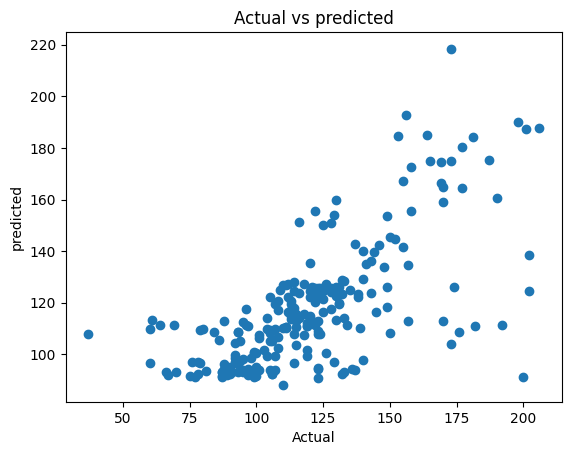

In [60]:
import numpy as np
from sklearn.metrics import r2_score
r2_score=r2_score(Y_test6, np.squeeze(model10.predict(X_test6)) )
print('r2_score:', r2_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse= mean_squared_error(Y_test6, np.squeeze(model10.predict(X_test6)) )
mae= mean_absolute_error(Y_test6, np.squeeze(model10.predict(X_test6)) )
print('mean squired error:', mse)
print('mean absolute error:', mae)

import matplotlib.pyplot as plt
plt.scatter(Y_test6, np.squeeze(model10.predict(X_test6)) )
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title("Actual vs predicted")

In [61]:
prediction11 =np.squeeze(model10.predict([[80,2,2,prediction10]]))
print("Prediction: {}".format(prediction11))

y_prd=np.squeeze(np.squeeze(model10.predict(X_test6)) )
predic_dif=pd.DataFrame({'Actual':Y_test6,'predict':y_prd,"differences":Y_test6-y_prd})
predic_dif[0:15]

1/1 [==============================] - 1s 979ms/step
Prediction: 113.7188720703125
8/8 [==============================] - 0s 13ms/step


,Actual,predict,differences
23,149,153.449875,-4.449875
899,130,113.494675,16.505325
615,131,119.949844,11.050156
1059,122,112.356659,9.643341
998,109,124.938179,-15.938179
883,133,113.943253,19.056747
2116,107,93.876724,13.123276
1098,123,125.595612,-2.595612
2658,81,93.456390,-12.456390
1068,106,105.136383,0.863617
